<a href="https://colab.research.google.com/github/Larraguibel/DNN_neuroscience/blob/main/blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importaciones

In [1]:
!pip install --upgrade torch torchvision

In [2]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

In [3]:
cuda = True
train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = './cifar10'
gsync_save = True

In [4]:
try:
    import torch
except ModuleNotFoundError:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


try:
    import torchvision
except ModuleNotFoundError:
    !pip install -q torchvision

from torchvision import datasets, transforms


if gsync_save:
    try:
        import utils
    except ModuleNotFoundError:
        !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
        import utils

try:
    from allconv import AllConvNet
except ModuleNotFoundError:
    !wget https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
    from allconv import AllConvNet

--2024-01-11 21:08:38--  https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519 (4.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.41K  --.-KB/s    in 0s      

2024-01-11 21:08:38 (52.4 MB/s) - ‘utils.py’ saved [4519/4519]

--2024-01-11 21:08:48--  https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/StefOe/all-conv-pytorch/8545bb3ff7ac4410e52d8db930f0485074073ea9/allconv.py [following]
--2024-01-11 21:08:48--  https://raw.

## 2. Transformacion y carga de datos

In [5]:
# Damos acceso a google drive para guardar modelos

drive.mount('/content/gdrive');

Mounted at /content/gdrive


In [6]:
class NormalizeNegativeImages(object):

    def __call__(self, item):
        min_value_pixel = torch.min(item)
        if min_value_pixel < 0:
            item -= min_value_pixel
            item /= torch.max(item)
        return item

In [7]:
# Semilla para estandarizar resultados
torch.manual_seed(2320)

cuda = cuda and torch.cuda.is_available()
trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255

# Data normal (32x32)

transform_train = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(train_mean, train_std),
     NormalizeNegativeImages(),
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages()
])

#  transformaciones a 8x8 y de vuelta a 32x32 por bilineal

transform_test8x8 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages(),
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
])

transform_train8x8 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages(),
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip()
])

# Crearemos transformaciones sin randomizar nada para la resta de imágenes.

transform_train_no_random = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(train_mean, train_std),
     NormalizeNegativeImages()
])

transform_train8x8_no_random = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages(),
    transforms.Resize((8,8)),
    transforms.Resize((32,32))
])

100%|██████████| 170498071/170498071 [00:02<00:00, 78147192.78it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# Data normal

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True, **kwargs)


test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=True, **kwargs)

# Data de entrenamiento blurreada

train_loader_blur = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader_blur = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test8x8),
    batch_size=test_batch_size, shuffle=True, **kwargs)

# Data sin random ni data augmentation para mostrar imágenes

train_loader_no_random = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_test),
    batch_size=train_batch_size, shuffle=False, **kwargs)

train_loader_blur_no_random = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8_no_random),
    batch_size=train_batch_size, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


<class 'torch.Tensor'>


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<class 'torch.Tensor'>


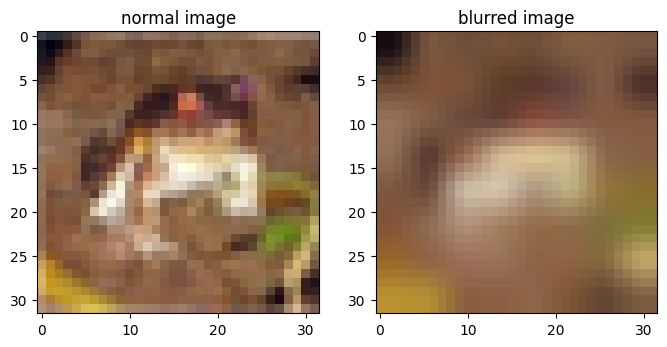

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
loaders = [train_loader_no_random, train_loader_blur_no_random]
label = ['normal image', 'blurred image']

for ax_index, loader in enumerate(loaders):
  for batch_data, batch_labels in loader:
    print(type(batch_data[0]))
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    ax[ax_index].imshow(first_image)
    ax[ax_index].set_title(label[ax_index])
    break

plt.show()

## 3. Entrenamiento

In [10]:
criterion = nn.CrossEntropyLoss()

### 3.1 Funciones auxiliares


In [11]:
# Se definen funciones auxiliares

def initialize_model():

    '''
    Initialize a simple AllConvNet(3) and returns the model and all the
    needed information to train it.
    '''

    global cuda
    global criterion

    model = AllConvNet(3)

    if cuda:
        model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[200, 250, 300],
                gamma=0.1)

    return model, optimizer, criterion, scheduler


def pretty_print(text: str, char='*'):

    '''
    Prints in a prettier way with more space. You can change the asterisks
    if something else is prefered.
    '''

    n_char = len(text)
    print(
    f'''
    {char * n_char}
    {text}
    {char * n_char}
    ''')


def load_pretrained_model(drive_path=None):

    '''
    Reads the google drive path and load the model into an AllConvNet(3). It loads
    the optimizer as well. If no path is given, the function instanciates an
    AllConvNet(3) and the necessary classes for the training and testing.
    '''

    global cuda
    global criterion

    model = AllConvNet(3)

    if cuda:
      model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    if drive_path is None:
      model_data = {
      'pretrained_epochs': 0,
      'model_state_dict': -1,
      'optimizer_state_dict': -1,
      'final_accuracy': 0,
      'training_data_dict': {},
      'test_data_dict': {}}

    else:
      model_data = torch.load(drive_path)
      model_state_dict = model_data['model_state_dict']
      opt_state_dict = model_data['optimizer_state_dict']
      model.load_state_dict(model_state_dict)
      optimizer.load_state_dict(opt_state_dict)

    scheduler = optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[200, 250, 300], gamma=0.1)

    return_dict = {'model': model,
                   'model_data': model_data,
                   'optimizer': optimizer,
                   'scheduler': scheduler}

    return return_dict


def save_training_data(save_dict: dict, acc: int, current_epoch: int,
                       total_epochs: int, save_every=10, altered=False):

    '''
    If the current epoch is a multiple of the a determined number, or is the last
    epoch, the function takes an existing dictionary containing the epochs as
    keys and the accuracy as value, and adds the acc of the current epoch.
    '''

    data_type = 'Normal'
    if altered:
      data_type = 'Altered'

    if current_epoch % save_every == 0 or current_epoch == total_epochs:
      round_acc = round(acc.item(), 2)
      save_dict[f'{current_epoch}'] = round_acc
      pretty_print(f'{data_type} Data Saved: ({current_epoch}, {round_acc})', char='-')
    return save_dict


def save_model(pretrained_epochs, model_state_dict, optimizer_state_dict,
               final_accuracy, training_data_dict, test_data_dict,
               checkpt_path):

    '''
    Saves the AllConvNet model with all the imporatant information in the given
    drive path.
    '''

    checkpoint = {
      'pretrained_epochs': pretrained_epochs,
      'model_state_dict': model_state_dict,
      'optimizer_state_dict': optimizer_state_dict,
      'final_accuracy': round(final_accuracy, 2),
      'training_data_dict': training_data_dict,
      'test_data_dict': test_data_dict}

    torch.save(checkpoint, checkpt_path)


def save_plot(path: str, training_data: dict, altered_testing_data: dict,
              altered_begin: int, blur=False):

    '''
    Generates a graph of epochs vs accuracies by using the keys and values stored
    in a dictionary. Then, the plot is save into the given drive path.
    '''

    epocas = list(training_data.keys())
    accuracies = list(training_data.values())

    title_text = f'Epochs vs Accuracies (Trained with HF images since epoch {altered_begin} for 40 epochs)'
    train_stuff = 'High Frecuency'

    if blur:
        title_text = f'Epochs vs Accuracies (Trained with blurred images since epoch {altered_begin} for 40 epochs)'
        train_stuff = 'Blurred'

    ax = plt.figure(figsize=(12,6))
    plt.plot(epocas, accuracies, label=f'Trained with {train_stuff} Images')
    plt.grid()
    plt.title(title_text)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')

    last_acc, last_ep = accuracies[-1], epocas[-1]
    text_upper_left = f'Last {train_stuff} epoch: {last_ep}\nLast {train_stuff} acc: {last_acc:.2f}'
    plt.text(0.02, 0.79, text_upper_left, transform=plt.gca().transAxes,
            bbox=dict(facecolor='lightgray', edgecolor='lightgray',
                      boxstyle='round,pad=0.5', alpha=0.5))

    # Añadir los cuadros de texto sobre épocas múltiplos de 40.

    for ep, acc in zip(epocas, accuracies):
        if int(ep) % 40 == 0:
            text = f'Epoch: {ep}\nAcc: {acc:.2f}'
            plt.annotate(text, (ep, acc), textcoords="offset points", xytext=(0,-8),
                         ha='center', va='bottom', bbox=dict(facecolor='lightgray',
                         edgecolor='lightgray', boxstyle='round,pad=0.5', alpha=0.5))

    # Plotear el modelo entrenado con imágenes normales.

    std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
    normal_image_training_path = std_text + '/allconv_noblur_checkpts/checkpoint_epoch_360.pt'
    normal_images_data = load_pretrained_model(normal_image_training_path)
    model_data_normal = normal_images_data['model_data']
    train_data_normal = model_data_normal['training_data_dict']

    epochs_normal = list(train_data_normal.keys())
    accs_normal = list(train_data_normal.values())
    plot_length = len(epocas)
    plt.plot(epochs_normal[:plot_length], accs_normal[:plot_length],
              color='lightgreen', linestyle='--', marker='o',
              label='Normal images training')

    # Plotear accuaracy del modelo para clasificar el altered loader

    altered_epochs_test = list(altered_testing_data.keys())
    altered_epochs_acc = list(altered_testing_data.values())
    plt.plot(altered_epochs_test, altered_epochs_acc,
             color='red', linestyle='--', marker='o',
             label=f'Test with {train_stuff} Images')


    plt.scatter(epocas, accuracies, color='orange')
    plt.legend()
    plt.tight_layout()
    plt.savefig(path)

In [12]:
def train(epoch: int, loader: torch.utils.data.DataLoader,
          model: AllConvNet, optimizer):

    global criterion
    global cuda

    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(loader.dataset),
              100. * batch_idx / len(loader), loss.item()))


def test(epoch: int, best_loss: int, best_epoch: int,
         test_loader: torch.utils.data.DataLoader, model: AllConvNet,
         show_altered=False):

    global criterion
    global cuda

    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        acc = 100 * correct / len(test_loader.dataset)

    test_loss /= len(test_loader.dataset)

    altered_text = 'Normal'
    if show_altered:
        altered_text = 'Altered'

    print(
        '\n{} Test set: Average loss: {:.4f}, Accuracy: {} ({:.0f}%)\n'.format(
            altered_text, test_loss, acc, 100. * correct /
            len(test_loader.dataset)))


    if test_loss < best_loss:
        best_epoch = epoch
        best_loss = test_loss

    return best_loss, best_epoch, acc

### 3.2 Definición del modelo

In [13]:
def begin_model_easy(normal_loader: torch.utils.data.DataLoader,
                     altered_loader: torch.utils.data.DataLoader,
                     normal_test: torch.utils.data.DataLoader,
                     altered_test: torch.utils.data.DataLoader,
                     normal_init=0, altered_epochs=40, after_altered=160,
                     model_path=None):

  '''
  Trains the model by using the two given loaders (altered and normal), in the
  periods indicated. If no model path is given, then an AllConvNet(3) is
  instanciated. Parameters related to the number of epochs to train with each
  dataset are set to run as they are in Achille et al. experiment.
  '''

  criterion = nn.CrossEntropyLoss()
  loader_type = torch.utils.data.dataloader.DataLoader
  best_loss = float("inf")
  best_epoch = -1
  num_parameters_not_ok = (normal_init < 0 or altered_epochs < 0 or after_altered < 0)
  loaders_not_ok = (altered_loader is loader_type or normal_loader is loader_type)

  if num_parameters_not_ok or loaders_not_ok:
    raise Exception("There are Inconsistencies in the parameters")

  else:
    packed_data = load_pretrained_model(drive_path=model_path)
    model = packed_data['model']
    model_data = packed_data['model_data']
    scheduler = packed_data['scheduler']
    optimizer = packed_data['optimizer']
    training_data_dict = model_data['training_data_dict']
    test_data_dict = model_data.get('test_data_dict', {})
    pretrained_epochs = model_data['pretrained_epochs']
    orig_acc = model_data['final_accuracy']
    total_epochs = pretrained_epochs + normal_init + altered_epochs + after_altered
    training_begins_from = pretrained_epochs

    if training_begins_from == 0:
      training_begins_from = -1

    if normal_init == 0:

      pretty_print(f'Begin training with altered images')
      pretty_print(f"Accuracy before training: {orig_acc}", ' ')
      for epoch in range(training_begins_from + 1,
                         pretrained_epochs + altered_epochs + 1):
        scheduler.step()
        train(epoch, altered_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

      pretty_print('Altered image training finished. Training with normal images')
      for epoch in range(pretrained_epochs + altered_epochs + 1,
                         pretrained_epochs + altered_epochs + after_altered + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

    elif normal_init != 0:

      pretty_print("Begin training with normal images")
      pretty_print(f"Accuracy before training: {orig_acc}", ' ')

      for epoch in range(training_begins_from + 1,
                         pretrained_epochs + normal_init + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

      pretty_print("Begin training with altered images")

      for epoch in range(pretrained_epochs + normal_init + 1,
                         pretrained_epochs + normal_init + altered_epochs + 1):
        scheduler.step()
        train(epoch, altered_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

      pretty_print('Altered image training finished. Training with normal images')

      for epoch in range(pretrained_epochs + normal_init + altered_epochs + 1,
                         total_epochs + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)
        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)
        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)
        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

  pretty_print(f'final accuracy: {acc.item()}')

  dict_return = {'model': model,
                 'optimizer': optimizer,
                 'final_accuracy': round(acc.item(), 2),
                 'training_data_dict': training_data_dict,
                 'test_data_dict': test_data_dict,
                 'model_data': model_data}

  return dict_return

# Experimento 1 de Achille et al.

Vamos a entrenar con blur por $t_0$ epocas, con $t_0\in \{0, 20, 40, ... , 140\}$ y sucesivamente entrenamos por $160$ epocas sin blur.

Para ahorrar calculos,
* primero entrenamos modelo con blur por $140$ epocas y con un checkpoint cada $20$ epocas,
* sucesivamente entrenamos desde cada checkpoint por $160$ epocas sin blur, (se podra' hacer en paralelo?).



## 4. Entrenar modelos

En primer lugar, entrenamos el modelo que tiene las primeras 40 épocas con blur, y las 120 restantes sin blur. Despues de eso, se entrenarán con blur los modelos normales preentrenados, extraidos de MyDrive.

### 4.1 modelo partiendo en 0

In [ ]:
# Entrenamos modelo que empieza con 40 épocas blur y sigue con 120 normales
#PROXIMO CODIGO A EJECUTAR
std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea Sebastian/resultados experimentos'
whole_data = begin_model_easy(normal_loader=train_loader,
                              altered_loader=train_loader_blur,
                              normal_test=test_loader,
                              altered_test=test_loader_blur)

model_data = whole_data['model_data']
model = whole_data['model']
final_accuracy = whole_data['final_accuracy']
optimizer = whole_data['optimizer']
training_data_dict = whole_data['training_data_dict']
test_data_dict = whole_data['test_data_dict']
pretrained_epochs = model_data['pretrained_epochs']

checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40blurred_from_0.pt"

save_model(began_blur_epoch=pretrained_epochs,
           model_state_dict=model.state_dict(),
           optimizer_state_dict=optimizer.state_dict(),
           final_accuracy=round(final_accuracy, 2),
           training_data_dict=training_data_dict,
           test_data_dict=test_data_dict,
           checkpt_path=checkpoint_save_path)


    **********************************
    Begin training with altered images
    **********************************
    

                               
    Accuracy before training: 0
                               
    


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for

Train epoch: 0 [0/50000 (0%)]	Loss: 2.305534
Train epoch: 0 [3200/50000 (6%)]	Loss: 2.303848
Train epoch: 0 [6400/50000 (13%)]	Loss: 2.300708
Train epoch: 0 [9600/50000 (19%)]	Loss: 2.305184
Train epoch: 0 [12800/50000 (26%)]	Loss: 2.293713
Train epoch: 0 [16000/50000 (32%)]	Loss: 2.299305
Train epoch: 0 [19200/50000 (38%)]	Loss: 2.307136
Train epoch: 0 [22400/50000 (45%)]	Loss: 2.303616
Train epoch: 0 [25600/50000 (51%)]	Loss: 2.301422
Train epoch: 0 [28800/50000 (58%)]	Loss: 2.305568
Train epoch: 0 [32000/50000 (64%)]	Loss: 2.300459
Train epoch: 0 [35200/50000 (70%)]	Loss: 2.298089
Train epoch: 0 [38400/50000 (77%)]	Loss: 2.303315
Train epoch: 0 [41600/50000 (83%)]	Loss: 2.304363
Train epoch: 0 [44800/50000 (90%)]	Loss: 2.303545
Train epoch: 0 [48000/50000 (96%)]	Loss: 2.300589

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)


    ----------------------------
    Normal Data Saved: (0, 10.0)
    ----------------------------
    

    -----------------------------
    Altered Data Saved: (0, 10.0)
    -----------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 1 [0/50000 (0%)]	Loss: 2.303844
Train epoch: 1 [3200/50000 (6%)]	Loss: 2.303416
Train epoch: 1 [6400/50000 (13%)]	Loss: 2.303267
Train epoch: 1 [9600/50000 (19%)]	Loss: 2.302592
Train epoch: 1 [12800/50000 (26%)]	Loss: 2.302582
Train epoch: 1 [16000/50000 (32%)]	Loss: 2.302603
Train epoch: 1 [19200/50000 (38%)]	Loss: 2.302581
Train epoch: 1 [22400/50000 (45%)]	Loss: 2.302596
Train epoch: 1 [25600/50000 (51%)]	Loss: 2.302585
Train epoch: 1 [28800/50000 (58%)]	Loss: 2.302586
Train epoch: 1 [32000/50000 (64%)]	Loss: 2.302585
Train epoch: 1 [35200/50000 (70%)]	Loss: 2.302592
Train epoch: 1 [38400/50000 (77%)]	Loss: 2.302581
Train epoch: 1 [41600/50000 (83%)]	Loss: 2.302577
Train epoch: 1 [44800/50000 (90%)]	Loss: 2.302501
Train epoch: 1 [48000/50000 (96%)]	Loss: 2.302666

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 2 [0/50000 (0%)]	Loss: 2.302078
Train epoch: 2 [3200/50000 (6%)]	Loss: 2.302730
Train epoch: 2 [6400/50000 (13%)]	Loss: 2.301646
Train epoch: 2 [9600/50000 (19%)]	Loss: 2.303118
Train epoch: 2 [12800/50000 (26%)]	Loss: 2.302661
Train epoch: 2 [16000/50000 (32%)]	Loss: 2.302268
Train epoch: 2 [19200/50000 (38%)]	Loss: 2.302741
Train epoch: 2 [22400/50000 (45%)]	Loss: 2.303669
Train epoch: 2 [25600/50000 (51%)]	Loss: 2.302045
Train epoch: 2 [28800/50000 (58%)]	Loss: 2.303153
Train epoch: 2 [32000/50000 (64%)]	Loss: 2.302609
Train epoch: 2 [35200/50000 (70%)]	Loss: 2.301540
Train epoch: 2 [38400/50000 (77%)]	Loss: 2.302600
Train epoch: 2 [41600/50000 (83%)]	Loss: 2.302580
Train epoch: 2 [44800/50000 (90%)]	Loss: 2.302578
Train epoch: 2 [48000/50000 (96%)]	Loss: 2.302218

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 3 [0/50000 (0%)]	Loss: 2.302886
Train epoch: 3 [3200/50000 (6%)]	Loss: 2.302224
Train epoch: 3 [6400/50000 (13%)]	Loss: 2.303151
Train epoch: 3 [9600/50000 (19%)]	Loss: 2.302169
Train epoch: 3 [12800/50000 (26%)]	Loss: 2.303895
Train epoch: 3 [16000/50000 (32%)]	Loss: 2.302580
Train epoch: 3 [19200/50000 (38%)]	Loss: 2.302596
Train epoch: 3 [22400/50000 (45%)]	Loss: 2.302606
Train epoch: 3 [25600/50000 (51%)]	Loss: 2.302586
Train epoch: 3 [28800/50000 (58%)]	Loss: 2.302351
Train epoch: 3 [32000/50000 (64%)]	Loss: 2.302143
Train epoch: 3 [35200/50000 (70%)]	Loss: 2.302577
Train epoch: 3 [38400/50000 (77%)]	Loss: 2.302604
Train epoch: 3 [41600/50000 (83%)]	Loss: 2.302659
Train epoch: 3 [44800/50000 (90%)]	Loss: 2.302643
Train epoch: 3 [48000/50000 (96%)]	Loss: 2.302633

Test set: Average loss: 0.0187, Accuracy: 10.020000457763672 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.020000457763672 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 4 [0/50000 (0%)]	Loss: 2.302605
Train epoch: 4 [3200/50000 (6%)]	Loss: 2.302577
Train epoch: 4 [6400/50000 (13%)]	Loss: 2.302500
Train epoch: 4 [9600/50000 (19%)]	Loss: 2.304066
Train epoch: 4 [12800/50000 (26%)]	Loss: 2.303947
Train epoch: 4 [16000/50000 (32%)]	Loss: 2.303140
Train epoch: 4 [19200/50000 (38%)]	Loss: 2.302625
Train epoch: 4 [22400/50000 (45%)]	Loss: 2.302388
Train epoch: 4 [25600/50000 (51%)]	Loss: 2.301100
Train epoch: 4 [28800/50000 (58%)]	Loss: 2.302736
Train epoch: 4 [32000/50000 (64%)]	Loss: 2.300581
Train epoch: 4 [35200/50000 (70%)]	Loss: 2.302683
Train epoch: 4 [38400/50000 (77%)]	Loss: 2.303005
Train epoch: 4 [41600/50000 (83%)]	Loss: 2.302767
Train epoch: 4 [44800/50000 (90%)]	Loss: 2.302575
Train epoch: 4 [48000/50000 (96%)]	Loss: 2.302575

Test set: Average loss: 0.0187, Accuracy: 10.229999542236328 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.229999542236328 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 5 [0/50000 (0%)]	Loss: 2.302594
Train epoch: 5 [3200/50000 (6%)]	Loss: 2.302206
Train epoch: 5 [6400/50000 (13%)]	Loss: 2.303463
Train epoch: 5 [9600/50000 (19%)]	Loss: 2.301873
Train epoch: 5 [12800/50000 (26%)]	Loss: 2.302582
Train epoch: 5 [16000/50000 (32%)]	Loss: 2.302548
Train epoch: 5 [19200/50000 (38%)]	Loss: 2.303074
Train epoch: 5 [22400/50000 (45%)]	Loss: 2.302218
Train epoch: 5 [25600/50000 (51%)]	Loss: 2.303404
Train epoch: 5 [28800/50000 (58%)]	Loss: 2.301302
Train epoch: 5 [32000/50000 (64%)]	Loss: 2.302689
Train epoch: 5 [35200/50000 (70%)]	Loss: 2.301671
Train epoch: 5 [38400/50000 (77%)]	Loss: 2.301394
Train epoch: 5 [41600/50000 (83%)]	Loss: 2.302358
Train epoch: 5 [44800/50000 (90%)]	Loss: 2.302438
Train epoch: 5 [48000/50000 (96%)]	Loss: 2.302964

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 6 [0/50000 (0%)]	Loss: 2.302829
Train epoch: 6 [3200/50000 (6%)]	Loss: 2.304173
Train epoch: 6 [6400/50000 (13%)]	Loss: 2.303659
Train epoch: 6 [9600/50000 (19%)]	Loss: 2.302633
Train epoch: 6 [12800/50000 (26%)]	Loss: 2.302376
Train epoch: 6 [16000/50000 (32%)]	Loss: 2.301583
Train epoch: 6 [19200/50000 (38%)]	Loss: 2.302299
Train epoch: 6 [22400/50000 (45%)]	Loss: 2.302088
Train epoch: 6 [25600/50000 (51%)]	Loss: 2.302315
Train epoch: 6 [28800/50000 (58%)]	Loss: 2.302536
Train epoch: 6 [32000/50000 (64%)]	Loss: 2.302634
Train epoch: 6 [35200/50000 (70%)]	Loss: 2.302606
Train epoch: 6 [38400/50000 (77%)]	Loss: 2.302626
Train epoch: 6 [41600/50000 (83%)]	Loss: 2.302625
Train epoch: 6 [44800/50000 (90%)]	Loss: 2.302909
Train epoch: 6 [48000/50000 (96%)]	Loss: 2.302615

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 7 [0/50000 (0%)]	Loss: 2.302586
Train epoch: 7 [3200/50000 (6%)]	Loss: 2.302865
Train epoch: 7 [6400/50000 (13%)]	Loss: 2.302589
Train epoch: 7 [9600/50000 (19%)]	Loss: 2.303335
Train epoch: 7 [12800/50000 (26%)]	Loss: 2.302565
Train epoch: 7 [16000/50000 (32%)]	Loss: 2.302489
Train epoch: 7 [19200/50000 (38%)]	Loss: 2.302599
Train epoch: 7 [22400/50000 (45%)]	Loss: 2.302320
Train epoch: 7 [25600/50000 (51%)]	Loss: 2.302807
Train epoch: 7 [28800/50000 (58%)]	Loss: 2.302357
Train epoch: 7 [32000/50000 (64%)]	Loss: 2.302709
Train epoch: 7 [35200/50000 (70%)]	Loss: 2.302559
Train epoch: 7 [38400/50000 (77%)]	Loss: 2.302804
Train epoch: 7 [41600/50000 (83%)]	Loss: 2.302424
Train epoch: 7 [44800/50000 (90%)]	Loss: 2.302594
Train epoch: 7 [48000/50000 (96%)]	Loss: 2.302569

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 8 [0/50000 (0%)]	Loss: 2.303004
Train epoch: 8 [3200/50000 (6%)]	Loss: 2.302085
Train epoch: 8 [6400/50000 (13%)]	Loss: 2.302617
Train epoch: 8 [9600/50000 (19%)]	Loss: 2.302214
Train epoch: 8 [12800/50000 (26%)]	Loss: 2.302012
Train epoch: 8 [16000/50000 (32%)]	Loss: 2.302660
Train epoch: 8 [19200/50000 (38%)]	Loss: 2.302626
Train epoch: 8 [22400/50000 (45%)]	Loss: 2.302672
Train epoch: 8 [25600/50000 (51%)]	Loss: 2.303016
Train epoch: 8 [28800/50000 (58%)]	Loss: 2.302231
Train epoch: 8 [32000/50000 (64%)]	Loss: 2.302839
Train epoch: 8 [35200/50000 (70%)]	Loss: 2.302794
Train epoch: 8 [38400/50000 (77%)]	Loss: 2.302629
Train epoch: 8 [41600/50000 (83%)]	Loss: 2.302546
Train epoch: 8 [44800/50000 (90%)]	Loss: 2.302590
Train epoch: 8 [48000/50000 (96%)]	Loss: 2.302612

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 9 [0/50000 (0%)]	Loss: 2.302443
Train epoch: 9 [3200/50000 (6%)]	Loss: 2.303482
Train epoch: 9 [6400/50000 (13%)]	Loss: 2.302608
Train epoch: 9 [9600/50000 (19%)]	Loss: 2.302394
Train epoch: 9 [12800/50000 (26%)]	Loss: 2.303247
Train epoch: 9 [16000/50000 (32%)]	Loss: 2.302602
Train epoch: 9 [19200/50000 (38%)]	Loss: 2.302583
Train epoch: 9 [22400/50000 (45%)]	Loss: 2.302524
Train epoch: 9 [25600/50000 (51%)]	Loss: 2.302327
Train epoch: 9 [28800/50000 (58%)]	Loss: 2.302597
Train epoch: 9 [32000/50000 (64%)]	Loss: 2.302576
Train epoch: 9 [35200/50000 (70%)]	Loss: 2.302553
Train epoch: 9 [38400/50000 (77%)]	Loss: 2.302643
Train epoch: 9 [41600/50000 (83%)]	Loss: 2.303113
Train epoch: 9 [44800/50000 (90%)]	Loss: 2.302175
Train epoch: 9 [48000/50000 (96%)]	Loss: 2.301006

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 10 [0/50000 (0%)]	Loss: 2.302713
Train epoch: 10 [3200/50000 (6%)]	Loss: 2.299818
Train epoch: 10 [6400/50000 (13%)]	Loss: 2.298889
Train epoch: 10 [9600/50000 (19%)]	Loss: 2.302860
Train epoch: 10 [12800/50000 (26%)]	Loss: 2.302819
Train epoch: 10 [16000/50000 (32%)]	Loss: 2.302787
Train epoch: 10 [19200/50000 (38%)]	Loss: 2.302745
Train epoch: 10 [22400/50000 (45%)]	Loss: 2.303287
Train epoch: 10 [25600/50000 (51%)]	Loss: 2.302522
Train epoch: 10 [28800/50000 (58%)]	Loss: 2.302451
Train epoch: 10 [32000/50000 (64%)]	Loss: 2.302480
Train epoch: 10 [35200/50000 (70%)]	Loss: 2.302620
Train epoch: 10 [38400/50000 (77%)]	Loss: 2.302717
Train epoch: 10 [41600/50000 (83%)]	Loss: 2.302565
Train epoch: 10 [44800/50000 (90%)]	Loss: 2.302186
Train epoch: 10 [48000/50000 (96%)]	Loss: 2.302093

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)


    -----------------------------
    Normal Data Saved: (10, 10.0)
    -----------------------------
    

    ------------------------------
    Altered Data Saved: (10, 10.0)
    ------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 11 [0/50000 (0%)]	Loss: 2.301902
Train epoch: 11 [3200/50000 (6%)]	Loss: 2.303009
Train epoch: 11 [6400/50000 (13%)]	Loss: 2.302306
Train epoch: 11 [9600/50000 (19%)]	Loss: 2.302590
Train epoch: 11 [12800/50000 (26%)]	Loss: 2.302583
Train epoch: 11 [16000/50000 (32%)]	Loss: 2.302177
Train epoch: 11 [19200/50000 (38%)]	Loss: 2.302307
Train epoch: 11 [22400/50000 (45%)]	Loss: 2.302272
Train epoch: 11 [25600/50000 (51%)]	Loss: 2.302120
Train epoch: 11 [28800/50000 (58%)]	Loss: 2.303494
Train epoch: 11 [32000/50000 (64%)]	Loss: 2.303135
Train epoch: 11 [35200/50000 (70%)]	Loss: 2.302228
Train epoch: 11 [38400/50000 (77%)]	Loss: 2.302410
Train epoch: 11 [41600/50000 (83%)]	Loss: 2.302495
Train epoch: 11 [44800/50000 (90%)]	Loss: 2.303206
Train epoch: 11 [48000/50000 (96%)]	Loss: 2.302731

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 12 [0/50000 (0%)]	Loss: 2.303194
Train epoch: 12 [3200/50000 (6%)]	Loss: 2.302717
Train epoch: 12 [6400/50000 (13%)]	Loss: 2.302579
Train epoch: 12 [9600/50000 (19%)]	Loss: 2.301709
Train epoch: 12 [12800/50000 (26%)]	Loss: 2.302606
Train epoch: 12 [16000/50000 (32%)]	Loss: 2.302804
Train epoch: 12 [19200/50000 (38%)]	Loss: 2.302027
Train epoch: 12 [22400/50000 (45%)]	Loss: 2.301374
Train epoch: 12 [25600/50000 (51%)]	Loss: 2.302929
Train epoch: 12 [28800/50000 (58%)]	Loss: 2.302963
Train epoch: 12 [32000/50000 (64%)]	Loss: 2.302967
Train epoch: 12 [35200/50000 (70%)]	Loss: 2.302204
Train epoch: 12 [38400/50000 (77%)]	Loss: 2.303583
Train epoch: 12 [41600/50000 (83%)]	Loss: 2.302841
Train epoch: 12 [44800/50000 (90%)]	Loss: 2.302577
Train epoch: 12 [48000/50000 (96%)]	Loss: 2.302648

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 13 [0/50000 (0%)]	Loss: 2.302537
Train epoch: 13 [3200/50000 (6%)]	Loss: 2.302263
Train epoch: 13 [6400/50000 (13%)]	Loss: 2.301341
Train epoch: 13 [9600/50000 (19%)]	Loss: 2.300930
Train epoch: 13 [12800/50000 (26%)]	Loss: 2.303566
Train epoch: 13 [16000/50000 (32%)]	Loss: 2.303840
Train epoch: 13 [19200/50000 (38%)]	Loss: 2.303829
Train epoch: 13 [22400/50000 (45%)]	Loss: 2.303971
Train epoch: 13 [25600/50000 (51%)]	Loss: 2.301694
Train epoch: 13 [28800/50000 (58%)]	Loss: 2.302628
Train epoch: 13 [32000/50000 (64%)]	Loss: 2.301730
Train epoch: 13 [35200/50000 (70%)]	Loss: 2.302514
Train epoch: 13 [38400/50000 (77%)]	Loss: 2.302182
Train epoch: 13 [41600/50000 (83%)]	Loss: 2.302534
Train epoch: 13 [44800/50000 (90%)]	Loss: 2.302556
Train epoch: 13 [48000/50000 (96%)]	Loss: 2.302318

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 14 [0/50000 (0%)]	Loss: 2.302560
Train epoch: 14 [3200/50000 (6%)]	Loss: 2.302583
Train epoch: 14 [6400/50000 (13%)]	Loss: 2.302510
Train epoch: 14 [9600/50000 (19%)]	Loss: 2.301356
Train epoch: 14 [12800/50000 (26%)]	Loss: 2.304621
Train epoch: 14 [16000/50000 (32%)]	Loss: 2.301939
Train epoch: 14 [19200/50000 (38%)]	Loss: 2.302731
Train epoch: 14 [22400/50000 (45%)]	Loss: 2.303015
Train epoch: 14 [25600/50000 (51%)]	Loss: 2.302656
Train epoch: 14 [28800/50000 (58%)]	Loss: 2.302610
Train epoch: 14 [32000/50000 (64%)]	Loss: 2.301951
Train epoch: 14 [35200/50000 (70%)]	Loss: 2.302438
Train epoch: 14 [38400/50000 (77%)]	Loss: 2.302247
Train epoch: 14 [41600/50000 (83%)]	Loss: 2.302734
Train epoch: 14 [44800/50000 (90%)]	Loss: 2.302426
Train epoch: 14 [48000/50000 (96%)]	Loss: 2.303258

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 15 [0/50000 (0%)]	Loss: 2.302690
Train epoch: 15 [3200/50000 (6%)]	Loss: 2.302577
Train epoch: 15 [6400/50000 (13%)]	Loss: 2.302060
Train epoch: 15 [9600/50000 (19%)]	Loss: 2.303282
Train epoch: 15 [12800/50000 (26%)]	Loss: 2.302144
Train epoch: 15 [16000/50000 (32%)]	Loss: 2.302394
Train epoch: 15 [19200/50000 (38%)]	Loss: 2.303372
Train epoch: 15 [22400/50000 (45%)]	Loss: 2.302719
Train epoch: 15 [25600/50000 (51%)]	Loss: 2.303494
Train epoch: 15 [28800/50000 (58%)]	Loss: 2.302285
Train epoch: 15 [32000/50000 (64%)]	Loss: 2.302256
Train epoch: 15 [35200/50000 (70%)]	Loss: 2.303186
Train epoch: 15 [38400/50000 (77%)]	Loss: 2.302205
Train epoch: 15 [41600/50000 (83%)]	Loss: 2.301396
Train epoch: 15 [44800/50000 (90%)]	Loss: 2.301304
Train epoch: 15 [48000/50000 (96%)]	Loss: 2.301390

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 16 [0/50000 (0%)]	Loss: 2.302148
Train epoch: 16 [3200/50000 (6%)]	Loss: 2.299724
Train epoch: 16 [6400/50000 (13%)]	Loss: 2.302432
Train epoch: 16 [9600/50000 (19%)]	Loss: 2.304357
Train epoch: 16 [12800/50000 (26%)]	Loss: 2.302499
Train epoch: 16 [16000/50000 (32%)]	Loss: 2.304038
Train epoch: 16 [19200/50000 (38%)]	Loss: 2.303108
Train epoch: 16 [22400/50000 (45%)]	Loss: 2.302852
Train epoch: 16 [25600/50000 (51%)]	Loss: 2.303321
Train epoch: 16 [28800/50000 (58%)]	Loss: 2.303363
Train epoch: 16 [32000/50000 (64%)]	Loss: 2.302343
Train epoch: 16 [35200/50000 (70%)]	Loss: 2.305081
Train epoch: 16 [38400/50000 (77%)]	Loss: 2.302676
Train epoch: 16 [41600/50000 (83%)]	Loss: 2.302649
Train epoch: 16 [44800/50000 (90%)]	Loss: 2.301904
Train epoch: 16 [48000/50000 (96%)]	Loss: 2.301786

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 17 [0/50000 (0%)]	Loss: 2.302017
Train epoch: 17 [3200/50000 (6%)]	Loss: 2.301681
Train epoch: 17 [6400/50000 (13%)]	Loss: 2.301642
Train epoch: 17 [9600/50000 (19%)]	Loss: 2.302345
Train epoch: 17 [12800/50000 (26%)]	Loss: 2.301384
Train epoch: 17 [16000/50000 (32%)]	Loss: 2.302286
Train epoch: 17 [19200/50000 (38%)]	Loss: 2.299293
Train epoch: 17 [22400/50000 (45%)]	Loss: 2.304219
Train epoch: 17 [25600/50000 (51%)]	Loss: 2.301803
Train epoch: 17 [28800/50000 (58%)]	Loss: 2.301995
Train epoch: 17 [32000/50000 (64%)]	Loss: 2.303450
Train epoch: 17 [35200/50000 (70%)]	Loss: 2.302588
Train epoch: 17 [38400/50000 (77%)]	Loss: 2.301888
Train epoch: 17 [41600/50000 (83%)]	Loss: 2.302039
Train epoch: 17 [44800/50000 (90%)]	Loss: 2.303140
Train epoch: 17 [48000/50000 (96%)]	Loss: 2.301495

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 18 [0/50000 (0%)]	Loss: 2.303684
Train epoch: 18 [3200/50000 (6%)]	Loss: 2.303512
Train epoch: 18 [6400/50000 (13%)]	Loss: 2.302633
Train epoch: 18 [9600/50000 (19%)]	Loss: 2.299144
Train epoch: 18 [12800/50000 (26%)]	Loss: 2.302757
Train epoch: 18 [16000/50000 (32%)]	Loss: 2.302594
Train epoch: 18 [19200/50000 (38%)]	Loss: 2.301521
Train epoch: 18 [22400/50000 (45%)]	Loss: 2.300183
Train epoch: 18 [25600/50000 (51%)]	Loss: 2.304634
Train epoch: 18 [28800/50000 (58%)]	Loss: 2.300857
Train epoch: 18 [32000/50000 (64%)]	Loss: 2.301198
Train epoch: 18 [35200/50000 (70%)]	Loss: 2.302499
Train epoch: 18 [38400/50000 (77%)]	Loss: 2.303288
Train epoch: 18 [41600/50000 (83%)]	Loss: 2.300117
Train epoch: 18 [44800/50000 (90%)]	Loss: 2.299787
Train epoch: 18 [48000/50000 (96%)]	Loss: 2.301340

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 19 [0/50000 (0%)]	Loss: 2.301835
Train epoch: 19 [3200/50000 (6%)]	Loss: 2.299469
Train epoch: 19 [6400/50000 (13%)]	Loss: 2.303482
Train epoch: 19 [9600/50000 (19%)]	Loss: 2.301561
Train epoch: 19 [12800/50000 (26%)]	Loss: 2.304939
Train epoch: 19 [16000/50000 (32%)]	Loss: 2.304502
Train epoch: 19 [19200/50000 (38%)]	Loss: 2.301374
Train epoch: 19 [22400/50000 (45%)]	Loss: 2.301622
Train epoch: 19 [25600/50000 (51%)]	Loss: 2.302940
Train epoch: 19 [28800/50000 (58%)]	Loss: 2.303628
Train epoch: 19 [32000/50000 (64%)]	Loss: 2.302310
Train epoch: 19 [35200/50000 (70%)]	Loss: 2.298854
Train epoch: 19 [38400/50000 (77%)]	Loss: 2.297722
Train epoch: 19 [41600/50000 (83%)]	Loss: 2.301186
Train epoch: 19 [44800/50000 (90%)]	Loss: 2.301502
Train epoch: 19 [48000/50000 (96%)]	Loss: 2.298732

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 20 [0/50000 (0%)]	Loss: 2.304579
Train epoch: 20 [3200/50000 (6%)]	Loss: 2.305908
Train epoch: 20 [6400/50000 (13%)]	Loss: 2.302149
Train epoch: 20 [9600/50000 (19%)]	Loss: 2.298195
Train epoch: 20 [12800/50000 (26%)]	Loss: 2.301139
Train epoch: 20 [16000/50000 (32%)]	Loss: 2.301798
Train epoch: 20 [19200/50000 (38%)]	Loss: 2.302298
Train epoch: 20 [22400/50000 (45%)]	Loss: 2.303146
Train epoch: 20 [25600/50000 (51%)]	Loss: 2.304076
Train epoch: 20 [28800/50000 (58%)]	Loss: 2.297605
Train epoch: 20 [32000/50000 (64%)]	Loss: 2.300490
Train epoch: 20 [35200/50000 (70%)]	Loss: 2.302751
Train epoch: 20 [38400/50000 (77%)]	Loss: 2.278373
Train epoch: 20 [41600/50000 (83%)]	Loss: 2.299246
Train epoch: 20 [44800/50000 (90%)]	Loss: 2.302078
Train epoch: 20 [48000/50000 (96%)]	Loss: 2.301894

Test set: Average loss: 0.0186, Accuracy: 10.010000228881836 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.020000457763672 (10%)


    ------------------------------
    Normal Data Saved: (20, 10.01)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (20, 10.02)
    -------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 21 [0/50000 (0%)]	Loss: 2.305066
Train epoch: 21 [3200/50000 (6%)]	Loss: 2.304776
Train epoch: 21 [6400/50000 (13%)]	Loss: 2.297121
Train epoch: 21 [9600/50000 (19%)]	Loss: 2.295743
Train epoch: 21 [12800/50000 (26%)]	Loss: 2.300778
Train epoch: 21 [16000/50000 (32%)]	Loss: 2.279380
Train epoch: 21 [19200/50000 (38%)]	Loss: 2.295969
Train epoch: 21 [22400/50000 (45%)]	Loss: 2.312565
Train epoch: 21 [25600/50000 (51%)]	Loss: 2.316892
Train epoch: 21 [28800/50000 (58%)]	Loss: 2.268206
Train epoch: 21 [32000/50000 (64%)]	Loss: 2.262421
Train epoch: 21 [35200/50000 (70%)]	Loss: 2.322567
Train epoch: 21 [38400/50000 (77%)]	Loss: 2.244486
Train epoch: 21 [41600/50000 (83%)]	Loss: 2.290372
Train epoch: 21 [44800/50000 (90%)]	Loss: 2.253055
Train epoch: 21 [48000/50000 (96%)]	Loss: 2.297650

Test set: Average loss: 0.0185, Accuracy: 12.380000114440918 (12%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0185, Accuracy: 12.880000114440918 (13%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 22 [0/50000 (0%)]	Loss: 2.256958
Train epoch: 22 [3200/50000 (6%)]	Loss: 2.209581
Train epoch: 22 [6400/50000 (13%)]	Loss: 2.242279
Train epoch: 22 [9600/50000 (19%)]	Loss: 2.261526
Train epoch: 22 [12800/50000 (26%)]	Loss: 2.286712
Train epoch: 22 [16000/50000 (32%)]	Loss: 2.239591
Train epoch: 22 [19200/50000 (38%)]	Loss: 2.241596
Train epoch: 22 [22400/50000 (45%)]	Loss: 2.293864
Train epoch: 22 [25600/50000 (51%)]	Loss: 2.279661
Train epoch: 22 [28800/50000 (58%)]	Loss: 2.269452
Train epoch: 22 [32000/50000 (64%)]	Loss: 2.217890
Train epoch: 22 [35200/50000 (70%)]	Loss: 2.275155
Train epoch: 22 [38400/50000 (77%)]	Loss: 2.256625
Train epoch: 22 [41600/50000 (83%)]	Loss: 2.239166
Train epoch: 22 [44800/50000 (90%)]	Loss: 2.278318
Train epoch: 22 [48000/50000 (96%)]	Loss: 2.228820

Test set: Average loss: 0.0184, Accuracy: 16.020000457763672 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0184, Accuracy: 16.040000915527344 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 23 [0/50000 (0%)]	Loss: 2.315328
Train epoch: 23 [3200/50000 (6%)]	Loss: 2.267748
Train epoch: 23 [6400/50000 (13%)]	Loss: 2.275513
Train epoch: 23 [9600/50000 (19%)]	Loss: 2.224712
Train epoch: 23 [12800/50000 (26%)]	Loss: 2.253469
Train epoch: 23 [16000/50000 (32%)]	Loss: 2.247569
Train epoch: 23 [19200/50000 (38%)]	Loss: 2.324184
Train epoch: 23 [22400/50000 (45%)]	Loss: 2.287031
Train epoch: 23 [25600/50000 (51%)]	Loss: 2.191730
Train epoch: 23 [28800/50000 (58%)]	Loss: 2.272974
Train epoch: 23 [32000/50000 (64%)]	Loss: 2.310565
Train epoch: 23 [35200/50000 (70%)]	Loss: 2.249145
Train epoch: 23 [38400/50000 (77%)]	Loss: 2.297312
Train epoch: 23 [41600/50000 (83%)]	Loss: 2.286705
Train epoch: 23 [44800/50000 (90%)]	Loss: 2.285458
Train epoch: 23 [48000/50000 (96%)]	Loss: 2.337902

Test set: Average loss: 0.0184, Accuracy: 16.270000457763672 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0184, Accuracy: 16.389999389648438 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 24 [0/50000 (0%)]	Loss: 2.265142
Train epoch: 24 [3200/50000 (6%)]	Loss: 2.203150
Train epoch: 24 [6400/50000 (13%)]	Loss: 2.315995
Train epoch: 24 [9600/50000 (19%)]	Loss: 2.185413
Train epoch: 24 [12800/50000 (26%)]	Loss: 2.287704
Train epoch: 24 [16000/50000 (32%)]	Loss: 2.299430
Train epoch: 24 [19200/50000 (38%)]	Loss: 2.315761
Train epoch: 24 [22400/50000 (45%)]	Loss: 2.297742
Train epoch: 24 [25600/50000 (51%)]	Loss: 2.240301
Train epoch: 24 [28800/50000 (58%)]	Loss: 2.285787
Train epoch: 24 [32000/50000 (64%)]	Loss: 2.288674
Train epoch: 24 [35200/50000 (70%)]	Loss: 2.232620
Train epoch: 24 [38400/50000 (77%)]	Loss: 2.273678
Train epoch: 24 [41600/50000 (83%)]	Loss: 2.141613
Train epoch: 24 [44800/50000 (90%)]	Loss: 2.247686
Train epoch: 24 [48000/50000 (96%)]	Loss: 2.281358

Test set: Average loss: 0.0184, Accuracy: 16.479999542236328 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0184, Accuracy: 16.389999389648438 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 25 [0/50000 (0%)]	Loss: 2.253134
Train epoch: 25 [3200/50000 (6%)]	Loss: 2.173755
Train epoch: 25 [6400/50000 (13%)]	Loss: 2.257622
Train epoch: 25 [9600/50000 (19%)]	Loss: 2.243479
Train epoch: 25 [12800/50000 (26%)]	Loss: 2.225289
Train epoch: 25 [16000/50000 (32%)]	Loss: 2.318657
Train epoch: 25 [19200/50000 (38%)]	Loss: 2.256166
Train epoch: 25 [22400/50000 (45%)]	Loss: 2.277700
Train epoch: 25 [25600/50000 (51%)]	Loss: 2.270860
Train epoch: 25 [28800/50000 (58%)]	Loss: 2.280378
Train epoch: 25 [32000/50000 (64%)]	Loss: 2.336103
Train epoch: 25 [35200/50000 (70%)]	Loss: 2.237112
Train epoch: 25 [38400/50000 (77%)]	Loss: 2.289189
Train epoch: 25 [41600/50000 (83%)]	Loss: 2.243399
Train epoch: 25 [44800/50000 (90%)]	Loss: 2.230118
Train epoch: 25 [48000/50000 (96%)]	Loss: 2.282423

Test set: Average loss: 0.0183, Accuracy: 16.290000915527344 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0183, Accuracy: 16.290000915527344 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 26 [0/50000 (0%)]	Loss: 2.275882
Train epoch: 26 [3200/50000 (6%)]	Loss: 2.306963
Train epoch: 26 [6400/50000 (13%)]	Loss: 2.254330
Train epoch: 26 [9600/50000 (19%)]	Loss: 2.283095
Train epoch: 26 [12800/50000 (26%)]	Loss: 2.224737
Train epoch: 26 [16000/50000 (32%)]	Loss: 2.254452
Train epoch: 26 [19200/50000 (38%)]	Loss: 2.212121
Train epoch: 26 [22400/50000 (45%)]	Loss: 2.266133
Train epoch: 26 [25600/50000 (51%)]	Loss: 2.190460
Train epoch: 26 [28800/50000 (58%)]	Loss: 2.282112
Train epoch: 26 [32000/50000 (64%)]	Loss: 2.245266
Train epoch: 26 [35200/50000 (70%)]	Loss: 2.274454
Train epoch: 26 [38400/50000 (77%)]	Loss: 2.228856
Train epoch: 26 [41600/50000 (83%)]	Loss: 2.349108
Train epoch: 26 [44800/50000 (90%)]	Loss: 2.292487
Train epoch: 26 [48000/50000 (96%)]	Loss: 2.259048

Test set: Average loss: 0.0183, Accuracy: 14.15999984741211 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0183, Accuracy: 14.319999694824219 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 27 [0/50000 (0%)]	Loss: 2.198513
Train epoch: 27 [3200/50000 (6%)]	Loss: 2.286674
Train epoch: 27 [6400/50000 (13%)]	Loss: 2.262738
Train epoch: 27 [9600/50000 (19%)]	Loss: 2.267883
Train epoch: 27 [12800/50000 (26%)]	Loss: 2.235715
Train epoch: 27 [16000/50000 (32%)]	Loss: 2.280241
Train epoch: 27 [19200/50000 (38%)]	Loss: 2.239127
Train epoch: 27 [22400/50000 (45%)]	Loss: 2.215285
Train epoch: 27 [25600/50000 (51%)]	Loss: 2.214750
Train epoch: 27 [28800/50000 (58%)]	Loss: 2.293761
Train epoch: 27 [32000/50000 (64%)]	Loss: 2.273378
Train epoch: 27 [35200/50000 (70%)]	Loss: 2.246890
Train epoch: 27 [38400/50000 (77%)]	Loss: 2.200220
Train epoch: 27 [41600/50000 (83%)]	Loss: 2.138424
Train epoch: 27 [44800/50000 (90%)]	Loss: 2.145403
Train epoch: 27 [48000/50000 (96%)]	Loss: 2.214803

Test set: Average loss: 0.0185, Accuracy: 14.100000381469727 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 13.829999923706055 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 28 [0/50000 (0%)]	Loss: 2.350950
Train epoch: 28 [3200/50000 (6%)]	Loss: 2.291544
Train epoch: 28 [6400/50000 (13%)]	Loss: 2.249242
Train epoch: 28 [9600/50000 (19%)]	Loss: 2.232388
Train epoch: 28 [12800/50000 (26%)]	Loss: 2.218634
Train epoch: 28 [16000/50000 (32%)]	Loss: 2.354853
Train epoch: 28 [19200/50000 (38%)]	Loss: 2.232694
Train epoch: 28 [22400/50000 (45%)]	Loss: 2.268696
Train epoch: 28 [25600/50000 (51%)]	Loss: 2.271336
Train epoch: 28 [28800/50000 (58%)]	Loss: 2.278816
Train epoch: 28 [32000/50000 (64%)]	Loss: 2.325250
Train epoch: 28 [35200/50000 (70%)]	Loss: 2.208811
Train epoch: 28 [38400/50000 (77%)]	Loss: 2.218919
Train epoch: 28 [41600/50000 (83%)]	Loss: 2.201980
Train epoch: 28 [44800/50000 (90%)]	Loss: 2.334724
Train epoch: 28 [48000/50000 (96%)]	Loss: 2.218386

Test set: Average loss: 0.0180, Accuracy: 16.09000015258789 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0181, Accuracy: 15.899999618530273 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 29 [0/50000 (0%)]	Loss: 2.181071
Train epoch: 29 [3200/50000 (6%)]	Loss: 2.263653
Train epoch: 29 [6400/50000 (13%)]	Loss: 2.146491
Train epoch: 29 [9600/50000 (19%)]	Loss: 2.213193
Train epoch: 29 [12800/50000 (26%)]	Loss: 2.180495
Train epoch: 29 [16000/50000 (32%)]	Loss: 2.208576
Train epoch: 29 [19200/50000 (38%)]	Loss: 2.310227
Train epoch: 29 [22400/50000 (45%)]	Loss: 2.166306
Train epoch: 29 [25600/50000 (51%)]	Loss: 2.270818
Train epoch: 29 [28800/50000 (58%)]	Loss: 2.182894
Train epoch: 29 [32000/50000 (64%)]	Loss: 2.277817
Train epoch: 29 [35200/50000 (70%)]	Loss: 2.220995
Train epoch: 29 [38400/50000 (77%)]	Loss: 2.242125
Train epoch: 29 [41600/50000 (83%)]	Loss: 2.220538
Train epoch: 29 [44800/50000 (90%)]	Loss: 2.227439
Train epoch: 29 [48000/50000 (96%)]	Loss: 2.224482

Test set: Average loss: 0.0182, Accuracy: 16.010000228881836 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0182, Accuracy: 15.5 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 30 [0/50000 (0%)]	Loss: 2.286914
Train epoch: 30 [3200/50000 (6%)]	Loss: 2.194202
Train epoch: 30 [6400/50000 (13%)]	Loss: 2.188122
Train epoch: 30 [9600/50000 (19%)]	Loss: 2.199097
Train epoch: 30 [12800/50000 (26%)]	Loss: 2.279699
Train epoch: 30 [16000/50000 (32%)]	Loss: 2.254191
Train epoch: 30 [19200/50000 (38%)]	Loss: 2.303706
Train epoch: 30 [22400/50000 (45%)]	Loss: 2.068370
Train epoch: 30 [25600/50000 (51%)]	Loss: 2.144275
Train epoch: 30 [28800/50000 (58%)]	Loss: 2.335772
Train epoch: 30 [32000/50000 (64%)]	Loss: 2.382573
Train epoch: 30 [35200/50000 (70%)]	Loss: 2.237658
Train epoch: 30 [38400/50000 (77%)]	Loss: 2.185682
Train epoch: 30 [41600/50000 (83%)]	Loss: 2.279679
Train epoch: 30 [44800/50000 (90%)]	Loss: 2.145926
Train epoch: 30 [48000/50000 (96%)]	Loss: 2.201326

Test set: Average loss: 0.0178, Accuracy: 19.290000915527344 (19%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0179, Accuracy: 18.739999771118164 (19%)


    ------------------------------
    Normal Data Saved: (30, 19.29)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (30, 18.74)
    -------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 31 [0/50000 (0%)]	Loss: 2.260337
Train epoch: 31 [3200/50000 (6%)]	Loss: 2.174154
Train epoch: 31 [6400/50000 (13%)]	Loss: 2.149717
Train epoch: 31 [9600/50000 (19%)]	Loss: 2.144910
Train epoch: 31 [12800/50000 (26%)]	Loss: 2.150896
Train epoch: 31 [16000/50000 (32%)]	Loss: 2.200761
Train epoch: 31 [19200/50000 (38%)]	Loss: 2.141160
Train epoch: 31 [22400/50000 (45%)]	Loss: 2.276514
Train epoch: 31 [25600/50000 (51%)]	Loss: 2.206331
Train epoch: 31 [28800/50000 (58%)]	Loss: 2.205575
Train epoch: 31 [32000/50000 (64%)]	Loss: 2.226479
Train epoch: 31 [35200/50000 (70%)]	Loss: 2.151966
Train epoch: 31 [38400/50000 (77%)]	Loss: 2.269119
Train epoch: 31 [41600/50000 (83%)]	Loss: 2.308760
Train epoch: 31 [44800/50000 (90%)]	Loss: 2.141594
Train epoch: 31 [48000/50000 (96%)]	Loss: 2.228616

Test set: Average loss: 0.0177, Accuracy: 20.190000534057617 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pytho


Test set: Average loss: 0.0177, Accuracy: 20.25 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 32 [0/50000 (0%)]	Loss: 2.145839
Train epoch: 32 [3200/50000 (6%)]	Loss: 2.021578
Train epoch: 32 [6400/50000 (13%)]	Loss: 2.249963
Train epoch: 32 [9600/50000 (19%)]	Loss: 2.114193
Train epoch: 32 [12800/50000 (26%)]	Loss: 2.385502
Train epoch: 32 [16000/50000 (32%)]	Loss: 2.066377
Train epoch: 32 [19200/50000 (38%)]	Loss: 2.219976
Train epoch: 32 [22400/50000 (45%)]	Loss: 2.226633
Train epoch: 32 [25600/50000 (51%)]	Loss: 2.164470
Train epoch: 32 [28800/50000 (58%)]	Loss: 2.283122
Train epoch: 32 [32000/50000 (64%)]	Loss: 2.258421
Train epoch: 32 [35200/50000 (70%)]	Loss: 2.092194
Train epoch: 32 [38400/50000 (77%)]	Loss: 2.280818
Train epoch: 32 [41600/50000 (83%)]	Loss: 2.268154
Train epoch: 32 [44800/50000 (90%)]	Loss: 2.167001
Train epoch: 32 [48000/50000 (96%)]	Loss: 2.148643


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test set: Average loss: 0.0175, Accuracy: 21.200000762939453 (21%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pytho


Test set: Average loss: 0.0174, Accuracy: 22.1299991607666 (22%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 33 [0/50000 (0%)]	Loss: 2.270180
Train epoch: 33 [3200/50000 (6%)]	Loss: 2.193165
Train epoch: 33 [6400/50000 (13%)]	Loss: 2.165754
Train epoch: 33 [9600/50000 (19%)]	Loss: 2.130493
Train epoch: 33 [12800/50000 (26%)]	Loss: 2.150285
Train epoch: 33 [16000/50000 (32%)]	Loss: 2.116478
Train epoch: 33 [19200/50000 (38%)]	Loss: 2.221677
Train epoch: 33 [22400/50000 (45%)]	Loss: 2.206341
Train epoch: 33 [25600/50000 (51%)]	Loss: 2.279270
Train epoch: 33 [28800/50000 (58%)]	Loss: 2.317562
Train epoch: 33 [32000/50000 (64%)]	Loss: 2.042765
Train epoch: 33 [35200/50000 (70%)]	Loss: 2.094787
Train epoch: 33 [38400/50000 (77%)]	Loss: 2.197670
Train epoch: 33 [41600/50000 (83%)]	Loss: 2.070244
Train epoch: 33 [44800/50000 (90%)]	Loss: 2.095807
Train epoch: 33 [48000/50000 (96%)]	Loss: 2.116057


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test set: Average loss: 0.0172, Accuracy: 23.81999969482422 (24%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pytho


Test set: Average loss: 0.0173, Accuracy: 24.479999542236328 (24%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 34 [0/50000 (0%)]	Loss: 2.247402


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train epoch: 34 [3200/50000 (6%)]	Loss: 2.144421
Train epoch: 34 [6400/50000 (13%)]	Loss: 2.165229
Train epoch: 34 [9600/50000 (19%)]	Loss: 1.958287
Train epoch: 34 [12800/50000 (26%)]	Loss: 2.184411
Train epoch: 34 [16000/50000 (32%)]	Loss: 2.491221
Train epoch: 34 [19200/50000 (38%)]	Loss: 2.043581
Train epoch: 34 [22400/50000 (45%)]	Loss: 2.037881
Train epoch: 34 [25600/50000 (51%)]	Loss: 2.122978
Train epoch: 34 [28800/50000 (58%)]	Loss: 2.210660
Train epoch: 34 [32000/50000 (64%)]	Loss: 1.768192
Train epoch: 34 [35200/50000 (70%)]	Loss: 2.034808
Train epoch: 34 [38400/50000 (77%)]	Loss: 2.320360
Train epoch: 34 [41600/50000 (83%)]	Loss: 2.112471
Train epoch: 34 [44800/50000 (90%)]	Loss: 2.161278
Train epoch: 34 [48000/50000 (96%)]	Loss: 2.191360

Test set: Average loss: 0.0175, Accuracy: 20.1299991607666 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0173, Accuracy: 22.68000030517578 (23%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 35 [0/50000 (0%)]	Loss: 2.202195
Train epoch: 35 [3200/50000 (6%)]	Loss: 2.080833
Train epoch: 35 [6400/50000 (13%)]	Loss: 1.949169
Train epoch: 35 [9600/50000 (19%)]	Loss: 2.122751
Train epoch: 35 [12800/50000 (26%)]	Loss: 2.324156
Train epoch: 35 [16000/50000 (32%)]	Loss: 2.408347
Train epoch: 35 [19200/50000 (38%)]	Loss: 2.073927
Train epoch: 35 [22400/50000 (45%)]	Loss: 2.293384
Train epoch: 35 [25600/50000 (51%)]	Loss: 2.008331
Train epoch: 35 [28800/50000 (58%)]	Loss: 2.167643
Train epoch: 35 [32000/50000 (64%)]	Loss: 2.003362
Train epoch: 35 [35200/50000 (70%)]	Loss: 2.103984
Train epoch: 35 [38400/50000 (77%)]	Loss: 2.124394
Train epoch: 35 [41600/50000 (83%)]	Loss: 2.152463
Train epoch: 35 [44800/50000 (90%)]	Loss: 2.025123
Train epoch: 35 [48000/50000 (96%)]	Loss: 2.045748

Test set: Average loss: 0.0172, Accuracy: 23.1299991607666 (23%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0170, Accuracy: 24.579999923706055 (25%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 36 [0/50000 (0%)]	Loss: 2.056049
Train epoch: 36 [3200/50000 (6%)]	Loss: 2.060730
Train epoch: 36 [6400/50000 (13%)]	Loss: 2.254744
Train epoch: 36 [9600/50000 (19%)]	Loss: 2.274864
Train epoch: 36 [12800/50000 (26%)]	Loss: 2.135492
Train epoch: 36 [16000/50000 (32%)]	Loss: 2.001626
Train epoch: 36 [19200/50000 (38%)]	Loss: 2.058037
Train epoch: 36 [22400/50000 (45%)]	Loss: 2.120387
Train epoch: 36 [25600/50000 (51%)]	Loss: 2.361912
Train epoch: 36 [28800/50000 (58%)]	Loss: 1.932730
Train epoch: 36 [32000/50000 (64%)]	Loss: 2.143200
Train epoch: 36 [35200/50000 (70%)]	Loss: 2.312156
Train epoch: 36 [38400/50000 (77%)]	Loss: 2.061001
Train epoch: 36 [41600/50000 (83%)]	Loss: 2.244887
Train epoch: 36 [44800/50000 (90%)]	Loss: 2.017293
Train epoch: 36 [48000/50000 (96%)]	Loss: 2.126634

Test set: Average loss: 0.0167, Accuracy: 26.209999084472656 (26%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0171, Accuracy: 24.209999084472656 (24%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 37 [0/50000 (0%)]	Loss: 2.186435
Train epoch: 37 [3200/50000 (6%)]	Loss: 1.983034
Train epoch: 37 [6400/50000 (13%)]	Loss: 2.044355
Train epoch: 37 [9600/50000 (19%)]	Loss: 2.029046
Train epoch: 37 [12800/50000 (26%)]	Loss: 1.925409
Train epoch: 37 [16000/50000 (32%)]	Loss: 2.060874
Train epoch: 37 [19200/50000 (38%)]	Loss: 2.116326
Train epoch: 37 [22400/50000 (45%)]	Loss: 2.123951
Train epoch: 37 [25600/50000 (51%)]	Loss: 1.943763
Train epoch: 37 [28800/50000 (58%)]	Loss: 1.981682
Train epoch: 37 [32000/50000 (64%)]	Loss: 2.117209
Train epoch: 37 [35200/50000 (70%)]	Loss: 2.210354
Train epoch: 37 [38400/50000 (77%)]	Loss: 2.085171
Train epoch: 37 [41600/50000 (83%)]	Loss: 2.147672
Train epoch: 37 [44800/50000 (90%)]	Loss: 1.867360
Train epoch: 37 [48000/50000 (96%)]	Loss: 2.040286

Test set: Average loss: 0.0165, Accuracy: 26.65999984741211 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0166, Accuracy: 26.690000534057617 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 38 [0/50000 (0%)]	Loss: 2.210702
Train epoch: 38 [3200/50000 (6%)]	Loss: 2.154965
Train epoch: 38 [6400/50000 (13%)]	Loss: 2.064740
Train epoch: 38 [9600/50000 (19%)]	Loss: 2.045591
Train epoch: 38 [12800/50000 (26%)]	Loss: 2.129293
Train epoch: 38 [16000/50000 (32%)]	Loss: 2.053431
Train epoch: 38 [19200/50000 (38%)]	Loss: 1.762435
Train epoch: 38 [22400/50000 (45%)]	Loss: 1.967469
Train epoch: 38 [25600/50000 (51%)]	Loss: 2.081023
Train epoch: 38 [28800/50000 (58%)]	Loss: 1.931754
Train epoch: 38 [32000/50000 (64%)]	Loss: 2.174847
Train epoch: 38 [35200/50000 (70%)]	Loss: 2.054370
Train epoch: 38 [38400/50000 (77%)]	Loss: 1.869906
Train epoch: 38 [41600/50000 (83%)]	Loss: 1.933490
Train epoch: 38 [44800/50000 (90%)]	Loss: 1.854827
Train epoch: 38 [48000/50000 (96%)]	Loss: 1.940477

Test set: Average loss: 0.0168, Accuracy: 26.440000534057617 (26%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0166, Accuracy: 26.670000076293945 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 39 [0/50000 (0%)]	Loss: 2.037960
Train epoch: 39 [3200/50000 (6%)]	Loss: 1.950773
Train epoch: 39 [6400/50000 (13%)]	Loss: 1.878545
Train epoch: 39 [9600/50000 (19%)]	Loss: 1.936309
Train epoch: 39 [12800/50000 (26%)]	Loss: 2.047919
Train epoch: 39 [16000/50000 (32%)]	Loss: 2.012864
Train epoch: 39 [19200/50000 (38%)]	Loss: 2.010761
Train epoch: 39 [22400/50000 (45%)]	Loss: 1.835323
Train epoch: 39 [25600/50000 (51%)]	Loss: 1.935709
Train epoch: 39 [28800/50000 (58%)]	Loss: 2.127905
Train epoch: 39 [32000/50000 (64%)]	Loss: 2.020986
Train epoch: 39 [35200/50000 (70%)]	Loss: 1.985352
Train epoch: 39 [38400/50000 (77%)]	Loss: 2.048892
Train epoch: 39 [41600/50000 (83%)]	Loss: 2.405068
Train epoch: 39 [44800/50000 (90%)]	Loss: 2.221590
Train epoch: 39 [48000/50000 (96%)]	Loss: 2.016824

Test set: Average loss: 0.0167, Accuracy: 25.940000534057617 (26%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0166, Accuracy: 27.360000610351562 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 40 [0/50000 (0%)]	Loss: 1.896039
Train epoch: 40 [3200/50000 (6%)]	Loss: 2.041813
Train epoch: 40 [6400/50000 (13%)]	Loss: 1.958848
Train epoch: 40 [9600/50000 (19%)]	Loss: 1.967800
Train epoch: 40 [12800/50000 (26%)]	Loss: 1.924135
Train epoch: 40 [16000/50000 (32%)]	Loss: 1.953838
Train epoch: 40 [19200/50000 (38%)]	Loss: 1.944696
Train epoch: 40 [22400/50000 (45%)]	Loss: 1.838530
Train epoch: 40 [25600/50000 (51%)]	Loss: 1.919537
Train epoch: 40 [28800/50000 (58%)]	Loss: 1.997083
Train epoch: 40 [32000/50000 (64%)]	Loss: 1.868392
Train epoch: 40 [35200/50000 (70%)]	Loss: 1.790776
Train epoch: 40 [38400/50000 (77%)]	Loss: 2.050985
Train epoch: 40 [41600/50000 (83%)]	Loss: 1.930524
Train epoch: 40 [44800/50000 (90%)]	Loss: 1.651660
Train epoch: 40 [48000/50000 (96%)]	Loss: 2.206197

Test set: Average loss: 0.0149, Accuracy: 30.799999237060547 (31%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0150, Accuracy: 30.270000457763672 (30%)


    -----------------------------
    Normal Data Saved: (40, 30.8)
    -----------------------------
    

    -------------------------------
    Altered Data Saved: (40, 30.27)
    -------------------------------
    

    ************************************************************
    Altered image training finished. Training with normal images
    ************************************************************
    
Train epoch: 41 [0/50000 (0%)]	Loss: 1.930308
Train epoch: 41 [3200/50000 (6%)]	Loss: 1.928162
Train epoch: 41 [6400/50000 (13%)]	Loss: 1.770876
Train epoch: 41 [9600/50000 (19%)]	Loss: 1.501683
Train epoch: 41 [12800/50000 (26%)]	Loss: 1.949388
Train epoch: 41 [16000/50000 (32%)]	Loss: 1.692738
Train epoch: 41 [19200/50000 (38%)]	Loss: 1.944155
Train epoch: 41 [22400/50000 (45%)]	Loss: 1.696042
Train epoch: 41 [25600/50000 (51%)]	Loss: 1.886105
Train epoch: 41 [28800/50000 (58%)]	Loss: 1.873917
Train e

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0147, Accuracy: 32.869998931884766 (33%)

Train epoch: 42 [0/50000 (0%)]	Loss: 1.739443
Train epoch: 42 [3200/50000 (6%)]	Loss: 1.943343
Train epoch: 42 [6400/50000 (13%)]	Loss: 1.410221
Train epoch: 42 [9600/50000 (19%)]	Loss: 1.678498
Train epoch: 42 [12800/50000 (26%)]	Loss: 1.856954
Train epoch: 42 [16000/50000 (32%)]	Loss: 1.381845
Train epoch: 42 [19200/50000 (38%)]	Loss: 1.784866
Train epoch: 42 [22400/50000 (45%)]	Loss: 1.636333
Train epoch: 42 [25600/50000 (51%)]	Loss: 1.412814
Train epoch: 42 [28800/50000 (58%)]	Loss: 1.688502
Train epoch: 42 [32000/50000 (64%)]	Loss: 1.572509
Train epoch: 42 [35200/50000 (70%)]	Loss: 1.855588
Train epoch: 42 [38400/50000 (77%)]	Loss: 1.796850
Train epoch: 42 [41600/50000 (83%)]	Loss: 1.590210
Train epoch: 42 [44800/50000 (90%)]	Loss: 1.728197
Train epoch: 42 [48000/50000 (96%)]	Loss: 1.669622

Test set: Average loss: 0.0138, Accuracy: 35.56999969482422 (36%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0153, Accuracy: 29.75 (30%)

Train epoch: 43 [0/50000 (0%)]	Loss: 1.755803
Train epoch: 43 [3200/50000 (6%)]	Loss: 1.902104
Train epoch: 43 [6400/50000 (13%)]	Loss: 1.688259
Train epoch: 43 [9600/50000 (19%)]	Loss: 1.431762
Train epoch: 43 [12800/50000 (26%)]	Loss: 1.864127
Train epoch: 43 [16000/50000 (32%)]	Loss: 1.799208
Train epoch: 43 [19200/50000 (38%)]	Loss: 1.896222
Train epoch: 43 [22400/50000 (45%)]	Loss: 1.487558
Train epoch: 43 [25600/50000 (51%)]	Loss: 2.016139
Train epoch: 43 [28800/50000 (58%)]	Loss: 1.704229
Train epoch: 43 [32000/50000 (64%)]	Loss: 1.822633
Train epoch: 43 [35200/50000 (70%)]	Loss: 1.768621
Train epoch: 43 [38400/50000 (77%)]	Loss: 1.728201
Train epoch: 43 [41600/50000 (83%)]	Loss: 1.553080
Train epoch: 43 [44800/50000 (90%)]	Loss: 1.576107
Train epoch: 43 [48000/50000 (96%)]	Loss: 1.759948

Test set: Average loss: 0.0138, Accuracy: 35.38999938964844 (35%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0149, Accuracy: 30.790000915527344 (31%)

Train epoch: 44 [0/50000 (0%)]	Loss: 1.473113
Train epoch: 44 [3200/50000 (6%)]	Loss: 1.489468
Train epoch: 44 [6400/50000 (13%)]	Loss: 1.605119
Train epoch: 44 [9600/50000 (19%)]	Loss: 1.619811
Train epoch: 44 [12800/50000 (26%)]	Loss: 1.541613
Train epoch: 44 [16000/50000 (32%)]	Loss: 1.786336
Train epoch: 44 [19200/50000 (38%)]	Loss: 1.591039
Train epoch: 44 [22400/50000 (45%)]	Loss: 1.587899
Train epoch: 44 [25600/50000 (51%)]	Loss: 1.779958
Train epoch: 44 [28800/50000 (58%)]	Loss: 1.563137
Train epoch: 44 [32000/50000 (64%)]	Loss: 1.647558
Train epoch: 44 [35200/50000 (70%)]	Loss: 1.923447
Train epoch: 44 [38400/50000 (77%)]	Loss: 1.451775
Train epoch: 44 [41600/50000 (83%)]	Loss: 1.657666
Train epoch: 44 [44800/50000 (90%)]	Loss: 1.664712
Train epoch: 44 [48000/50000 (96%)]	Loss: 1.698228

Test set: Average loss: 0.0136, Accuracy: 37.099998474121094 (37%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0152, Accuracy: 30.719999313354492 (31%)

Train epoch: 45 [0/50000 (0%)]	Loss: 1.568667
Train epoch: 45 [3200/50000 (6%)]	Loss: 1.601003
Train epoch: 45 [6400/50000 (13%)]	Loss: 2.003807
Train epoch: 45 [9600/50000 (19%)]	Loss: 1.326202
Train epoch: 45 [12800/50000 (26%)]	Loss: 1.588193
Train epoch: 45 [16000/50000 (32%)]	Loss: 1.842926
Train epoch: 45 [19200/50000 (38%)]	Loss: 1.633787
Train epoch: 45 [22400/50000 (45%)]	Loss: 1.620205
Train epoch: 45 [25600/50000 (51%)]	Loss: 1.387267
Train epoch: 45 [28800/50000 (58%)]	Loss: 1.720873
Train epoch: 45 [32000/50000 (64%)]	Loss: 1.601108
Train epoch: 45 [35200/50000 (70%)]	Loss: 1.560083
Train epoch: 45 [38400/50000 (77%)]	Loss: 1.818433
Train epoch: 45 [41600/50000 (83%)]	Loss: 1.732225
Train epoch: 45 [44800/50000 (90%)]	Loss: 1.719114
Train epoch: 45 [48000/50000 (96%)]	Loss: 1.846761

Test set: Average loss: 0.0134, Accuracy: 37.66999816894531 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0159, Accuracy: 29.299999237060547 (29%)

Train epoch: 46 [0/50000 (0%)]	Loss: 1.682719
Train epoch: 46 [3200/50000 (6%)]	Loss: 1.815367
Train epoch: 46 [6400/50000 (13%)]	Loss: 1.635220
Train epoch: 46 [9600/50000 (19%)]	Loss: 1.598010
Train epoch: 46 [12800/50000 (26%)]	Loss: 1.745298
Train epoch: 46 [16000/50000 (32%)]	Loss: 1.872205
Train epoch: 46 [19200/50000 (38%)]	Loss: 1.328155
Train epoch: 46 [22400/50000 (45%)]	Loss: 1.315272
Train epoch: 46 [25600/50000 (51%)]	Loss: 1.346368
Train epoch: 46 [28800/50000 (58%)]	Loss: 1.418558
Train epoch: 46 [32000/50000 (64%)]	Loss: 1.527417
Train epoch: 46 [35200/50000 (70%)]	Loss: 1.279931
Train epoch: 46 [38400/50000 (77%)]	Loss: 1.720122
Train epoch: 46 [41600/50000 (83%)]	Loss: 1.481836
Train epoch: 46 [44800/50000 (90%)]	Loss: 1.325125
Train epoch: 46 [48000/50000 (96%)]	Loss: 1.610656

Test set: Average loss: 0.0128, Accuracy: 40.279998779296875 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0155, Accuracy: 30.709999084472656 (31%)

Train epoch: 47 [0/50000 (0%)]	Loss: 1.837680
Train epoch: 47 [3200/50000 (6%)]	Loss: 1.928723
Train epoch: 47 [6400/50000 (13%)]	Loss: 1.537274
Train epoch: 47 [9600/50000 (19%)]	Loss: 1.737554
Train epoch: 47 [12800/50000 (26%)]	Loss: 1.399249
Train epoch: 47 [16000/50000 (32%)]	Loss: 1.890657
Train epoch: 47 [19200/50000 (38%)]	Loss: 1.407552
Train epoch: 47 [22400/50000 (45%)]	Loss: 1.763655
Train epoch: 47 [25600/50000 (51%)]	Loss: 1.801207
Train epoch: 47 [28800/50000 (58%)]	Loss: 1.945352
Train epoch: 47 [32000/50000 (64%)]	Loss: 1.627568
Train epoch: 47 [35200/50000 (70%)]	Loss: 1.589786
Train epoch: 47 [38400/50000 (77%)]	Loss: 1.492307
Train epoch: 47 [41600/50000 (83%)]	Loss: 1.734079
Train epoch: 47 [44800/50000 (90%)]	Loss: 1.586294
Train epoch: 47 [48000/50000 (96%)]	Loss: 1.789924

Test set: Average loss: 0.0127, Accuracy: 41.060001373291016 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0161, Accuracy: 28.799999237060547 (29%)

Train epoch: 48 [0/50000 (0%)]	Loss: 1.520045
Train epoch: 48 [3200/50000 (6%)]	Loss: 1.569174
Train epoch: 48 [6400/50000 (13%)]	Loss: 1.598027
Train epoch: 48 [9600/50000 (19%)]	Loss: 1.324590
Train epoch: 48 [12800/50000 (26%)]	Loss: 1.606353
Train epoch: 48 [16000/50000 (32%)]	Loss: 1.567225
Train epoch: 48 [19200/50000 (38%)]	Loss: 1.581138
Train epoch: 48 [22400/50000 (45%)]	Loss: 1.557933
Train epoch: 48 [25600/50000 (51%)]	Loss: 1.574453
Train epoch: 48 [28800/50000 (58%)]	Loss: 1.396949
Train epoch: 48 [32000/50000 (64%)]	Loss: 1.338004
Train epoch: 48 [35200/50000 (70%)]	Loss: 1.490610
Train epoch: 48 [38400/50000 (77%)]	Loss: 1.651969
Train epoch: 48 [41600/50000 (83%)]	Loss: 1.450186
Train epoch: 48 [44800/50000 (90%)]	Loss: 1.369267
Train epoch: 48 [48000/50000 (96%)]	Loss: 1.644778

Test set: Average loss: 0.0125, Accuracy: 41.61000061035156 (42%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0190, Accuracy: 22.65999984741211 (23%)

Train epoch: 49 [0/50000 (0%)]	Loss: 1.577915
Train epoch: 49 [3200/50000 (6%)]	Loss: 1.431750
Train epoch: 49 [6400/50000 (13%)]	Loss: 1.755601
Train epoch: 49 [9600/50000 (19%)]	Loss: 1.830788
Train epoch: 49 [12800/50000 (26%)]	Loss: 1.660633
Train epoch: 49 [16000/50000 (32%)]	Loss: 1.707280
Train epoch: 49 [19200/50000 (38%)]	Loss: 1.645941
Train epoch: 49 [22400/50000 (45%)]	Loss: 2.188106
Train epoch: 49 [25600/50000 (51%)]	Loss: 1.451509
Train epoch: 49 [28800/50000 (58%)]	Loss: 1.588551
Train epoch: 49 [32000/50000 (64%)]	Loss: 1.423199
Train epoch: 49 [35200/50000 (70%)]	Loss: 1.607038
Train epoch: 49 [38400/50000 (77%)]	Loss: 1.666610
Train epoch: 49 [41600/50000 (83%)]	Loss: 1.556235
Train epoch: 49 [44800/50000 (90%)]	Loss: 1.583129
Train epoch: 49 [48000/50000 (96%)]	Loss: 1.625082

Test set: Average loss: 0.0123, Accuracy: 42.86000061035156 (43%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0181, Accuracy: 26.079999923706055 (26%)

Train epoch: 50 [0/50000 (0%)]	Loss: 1.760679
Train epoch: 50 [3200/50000 (6%)]	Loss: 1.220115
Train epoch: 50 [6400/50000 (13%)]	Loss: 1.580130
Train epoch: 50 [9600/50000 (19%)]	Loss: 1.621820
Train epoch: 50 [12800/50000 (26%)]	Loss: 1.451228
Train epoch: 50 [16000/50000 (32%)]	Loss: 1.833388
Train epoch: 50 [19200/50000 (38%)]	Loss: 1.758572
Train epoch: 50 [22400/50000 (45%)]	Loss: 1.667359
Train epoch: 50 [25600/50000 (51%)]	Loss: 1.345502
Train epoch: 50 [28800/50000 (58%)]	Loss: 1.653273
Train epoch: 50 [32000/50000 (64%)]	Loss: 1.321803
Train epoch: 50 [35200/50000 (70%)]	Loss: 1.678301
Train epoch: 50 [38400/50000 (77%)]	Loss: 1.583003
Train epoch: 50 [41600/50000 (83%)]	Loss: 1.403717
Train epoch: 50 [44800/50000 (90%)]	Loss: 1.664753
Train epoch: 50 [48000/50000 (96%)]	Loss: 1.463562

Test set: Average loss: 0.0121, Accuracy: 43.939998626708984 (44%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0185, Accuracy: 25.81999969482422 (26%)


    ------------------------------
    Normal Data Saved: (50, 43.94)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (50, 25.82)
    -------------------------------
    
Train epoch: 51 [0/50000 (0%)]	Loss: 1.591546
Train epoch: 51 [3200/50000 (6%)]	Loss: 1.467857
Train epoch: 51 [6400/50000 (13%)]	Loss: 1.449756
Train epoch: 51 [9600/50000 (19%)]	Loss: 1.315702
Train epoch: 51 [12800/50000 (26%)]	Loss: 1.554382
Train epoch: 51 [16000/50000 (32%)]	Loss: 1.480917
Train epoch: 51 [19200/50000 (38%)]	Loss: 1.349736
Train epoch: 51 [22400/50000 (45%)]	Loss: 1.354863
Train epoch: 51 [25600/50000 (51%)]	Loss: 1.515240
Train epoch: 51 [28800/50000 (58%)]	Loss: 1.635567
Train epoch: 51 [32000/50000 (64%)]	Loss: 1.738121
Train epoch: 51 [35200/50000 (70%)]	Loss: 1.383530
Train epoch: 51 [38400/50000 (77%)]	Loss: 1.436460
Train epoch: 51 [41600/50000 (83%)]	Loss: 1.499802
Tr

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0178, Accuracy: 28.790000915527344 (29%)

Train epoch: 52 [0/50000 (0%)]	Loss: 1.456498
Train epoch: 52 [3200/50000 (6%)]	Loss: 1.591151
Train epoch: 52 [6400/50000 (13%)]	Loss: 1.518736
Train epoch: 52 [9600/50000 (19%)]	Loss: 1.500432
Train epoch: 52 [12800/50000 (26%)]	Loss: 1.361019
Train epoch: 52 [16000/50000 (32%)]	Loss: 1.557459
Train epoch: 52 [19200/50000 (38%)]	Loss: 1.399901
Train epoch: 52 [22400/50000 (45%)]	Loss: 1.539916
Train epoch: 52 [25600/50000 (51%)]	Loss: 1.526806
Train epoch: 52 [28800/50000 (58%)]	Loss: 1.709426
Train epoch: 52 [32000/50000 (64%)]	Loss: 1.575178
Train epoch: 52 [35200/50000 (70%)]	Loss: 1.463089
Train epoch: 52 [38400/50000 (77%)]	Loss: 1.348587
Train epoch: 52 [41600/50000 (83%)]	Loss: 1.362093
Train epoch: 52 [44800/50000 (90%)]	Loss: 1.681693
Train epoch: 52 [48000/50000 (96%)]	Loss: 1.624408

Test set: Average loss: 0.0117, Accuracy: 46.04999923706055 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0192, Accuracy: 24.850000381469727 (25%)

Train epoch: 53 [0/50000 (0%)]	Loss: 1.665563
Train epoch: 53 [3200/50000 (6%)]	Loss: 1.681675
Train epoch: 53 [6400/50000 (13%)]	Loss: 1.432105
Train epoch: 53 [9600/50000 (19%)]	Loss: 1.254035
Train epoch: 53 [12800/50000 (26%)]	Loss: 1.451267
Train epoch: 53 [16000/50000 (32%)]	Loss: 1.538679
Train epoch: 53 [19200/50000 (38%)]	Loss: 1.359154
Train epoch: 53 [22400/50000 (45%)]	Loss: 1.377268
Train epoch: 53 [25600/50000 (51%)]	Loss: 1.379731
Train epoch: 53 [28800/50000 (58%)]	Loss: 1.370694
Train epoch: 53 [32000/50000 (64%)]	Loss: 1.449276
Train epoch: 53 [35200/50000 (70%)]	Loss: 1.687567
Train epoch: 53 [38400/50000 (77%)]	Loss: 1.333971
Train epoch: 53 [41600/50000 (83%)]	Loss: 1.540642
Train epoch: 53 [44800/50000 (90%)]	Loss: 1.733480
Train epoch: 53 [48000/50000 (96%)]	Loss: 1.662717

Test set: Average loss: 0.0116, Accuracy: 47.0 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0178, Accuracy: 28.729999542236328 (29%)

Train epoch: 54 [0/50000 (0%)]	Loss: 1.260212
Train epoch: 54 [3200/50000 (6%)]	Loss: 1.393878
Train epoch: 54 [6400/50000 (13%)]	Loss: 1.424635
Train epoch: 54 [9600/50000 (19%)]	Loss: 1.360294
Train epoch: 54 [12800/50000 (26%)]	Loss: 1.531604
Train epoch: 54 [16000/50000 (32%)]	Loss: 1.215989
Train epoch: 54 [19200/50000 (38%)]	Loss: 1.355720
Train epoch: 54 [22400/50000 (45%)]	Loss: 1.645485
Train epoch: 54 [25600/50000 (51%)]	Loss: 1.410360
Train epoch: 54 [28800/50000 (58%)]	Loss: 1.792610
Train epoch: 54 [32000/50000 (64%)]	Loss: 1.557132
Train epoch: 54 [35200/50000 (70%)]	Loss: 1.486928
Train epoch: 54 [38400/50000 (77%)]	Loss: 1.499813
Train epoch: 54 [41600/50000 (83%)]	Loss: 1.275685
Train epoch: 54 [44800/50000 (90%)]	Loss: 1.607658
Train epoch: 54 [48000/50000 (96%)]	Loss: 1.242466

Test set: Average loss: 0.0116, Accuracy: 46.83000183105469 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0201, Accuracy: 24.030000686645508 (24%)

Train epoch: 55 [0/50000 (0%)]	Loss: 1.450119
Train epoch: 55 [3200/50000 (6%)]	Loss: 1.286123
Train epoch: 55 [6400/50000 (13%)]	Loss: 1.514125
Train epoch: 55 [9600/50000 (19%)]	Loss: 1.741400
Train epoch: 55 [12800/50000 (26%)]	Loss: 1.716202
Train epoch: 55 [16000/50000 (32%)]	Loss: 1.704438
Train epoch: 55 [19200/50000 (38%)]	Loss: 1.218495
Train epoch: 55 [22400/50000 (45%)]	Loss: 1.219026
Train epoch: 55 [25600/50000 (51%)]	Loss: 1.460025
Train epoch: 55 [28800/50000 (58%)]	Loss: 1.665055
Train epoch: 55 [32000/50000 (64%)]	Loss: 1.912415
Train epoch: 55 [35200/50000 (70%)]	Loss: 1.485642
Train epoch: 55 [38400/50000 (77%)]	Loss: 1.280581
Train epoch: 55 [41600/50000 (83%)]	Loss: 1.251115
Train epoch: 55 [44800/50000 (90%)]	Loss: 1.525428
Train epoch: 55 [48000/50000 (96%)]	Loss: 1.605380

Test set: Average loss: 0.0114, Accuracy: 47.779998779296875 (48%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0178, Accuracy: 30.719999313354492 (31%)

Train epoch: 56 [0/50000 (0%)]	Loss: 1.205192
Train epoch: 56 [3200/50000 (6%)]	Loss: 1.710051
Train epoch: 56 [6400/50000 (13%)]	Loss: 1.434284
Train epoch: 56 [9600/50000 (19%)]	Loss: 1.317747
Train epoch: 56 [12800/50000 (26%)]	Loss: 1.398058
Train epoch: 56 [16000/50000 (32%)]	Loss: 1.655817
Train epoch: 56 [19200/50000 (38%)]	Loss: 1.372965
Train epoch: 56 [22400/50000 (45%)]	Loss: 1.508326
Train epoch: 56 [25600/50000 (51%)]	Loss: 1.436584
Train epoch: 56 [28800/50000 (58%)]	Loss: 1.419494
Train epoch: 56 [32000/50000 (64%)]	Loss: 1.438469
Train epoch: 56 [35200/50000 (70%)]	Loss: 1.555675
Train epoch: 56 [38400/50000 (77%)]	Loss: 1.603658
Train epoch: 56 [41600/50000 (83%)]	Loss: 1.372432
Train epoch: 56 [44800/50000 (90%)]	Loss: 1.696531
Train epoch: 56 [48000/50000 (96%)]	Loss: 1.297774

Test set: Average loss: 0.0113, Accuracy: 48.900001525878906 (49%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0176, Accuracy: 28.520000457763672 (29%)

Train epoch: 57 [0/50000 (0%)]	Loss: 0.936324
Train epoch: 57 [3200/50000 (6%)]	Loss: 1.350486
Train epoch: 57 [6400/50000 (13%)]	Loss: 1.535995
Train epoch: 57 [9600/50000 (19%)]	Loss: 1.333186
Train epoch: 57 [12800/50000 (26%)]	Loss: 1.813676
Train epoch: 57 [16000/50000 (32%)]	Loss: 1.494304
Train epoch: 57 [19200/50000 (38%)]	Loss: 1.463346
Train epoch: 57 [22400/50000 (45%)]	Loss: 1.576647
Train epoch: 57 [25600/50000 (51%)]	Loss: 1.539001
Train epoch: 57 [28800/50000 (58%)]	Loss: 1.242933
Train epoch: 57 [32000/50000 (64%)]	Loss: 1.232692
Train epoch: 57 [35200/50000 (70%)]	Loss: 1.381694
Train epoch: 57 [38400/50000 (77%)]	Loss: 1.340890
Train epoch: 57 [41600/50000 (83%)]	Loss: 1.403486
Train epoch: 57 [44800/50000 (90%)]	Loss: 1.424822
Train epoch: 57 [48000/50000 (96%)]	Loss: 1.277406

Test set: Average loss: 0.0114, Accuracy: 49.040000915527344 (49%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0198, Accuracy: 28.690000534057617 (29%)

Train epoch: 58 [0/50000 (0%)]	Loss: 1.214834
Train epoch: 58 [3200/50000 (6%)]	Loss: 1.399671
Train epoch: 58 [6400/50000 (13%)]	Loss: 1.522124
Train epoch: 58 [9600/50000 (19%)]	Loss: 1.516140
Train epoch: 58 [12800/50000 (26%)]	Loss: 1.263353
Train epoch: 58 [16000/50000 (32%)]	Loss: 1.277264
Train epoch: 58 [19200/50000 (38%)]	Loss: 1.699362
Train epoch: 58 [22400/50000 (45%)]	Loss: 1.258902
Train epoch: 58 [25600/50000 (51%)]	Loss: 1.662809
Train epoch: 58 [28800/50000 (58%)]	Loss: 1.280194
Train epoch: 58 [32000/50000 (64%)]	Loss: 1.091498
Train epoch: 58 [35200/50000 (70%)]	Loss: 1.444335
Train epoch: 58 [38400/50000 (77%)]	Loss: 1.446506
Train epoch: 58 [41600/50000 (83%)]	Loss: 1.255852
Train epoch: 58 [44800/50000 (90%)]	Loss: 1.362009
Train epoch: 58 [48000/50000 (96%)]	Loss: 1.723635

Test set: Average loss: 0.0115, Accuracy: 47.560001373291016 (48%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 27.31999969482422 (27%)

Train epoch: 59 [0/50000 (0%)]	Loss: 1.166606
Train epoch: 59 [3200/50000 (6%)]	Loss: 1.517288
Train epoch: 59 [6400/50000 (13%)]	Loss: 1.286626
Train epoch: 59 [9600/50000 (19%)]	Loss: 1.647039
Train epoch: 59 [12800/50000 (26%)]	Loss: 1.576657
Train epoch: 59 [16000/50000 (32%)]	Loss: 1.787858
Train epoch: 59 [19200/50000 (38%)]	Loss: 1.343642
Train epoch: 59 [22400/50000 (45%)]	Loss: 1.569350
Train epoch: 59 [25600/50000 (51%)]	Loss: 1.192599
Train epoch: 59 [28800/50000 (58%)]	Loss: 1.342617
Train epoch: 59 [32000/50000 (64%)]	Loss: 1.103921
Train epoch: 59 [35200/50000 (70%)]	Loss: 1.587169
Train epoch: 59 [38400/50000 (77%)]	Loss: 1.359156
Train epoch: 59 [41600/50000 (83%)]	Loss: 1.411143
Train epoch: 59 [44800/50000 (90%)]	Loss: 1.704050
Train epoch: 59 [48000/50000 (96%)]	Loss: 1.505783

Test set: Average loss: 0.0111, Accuracy: 49.650001525878906 (50%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0189, Accuracy: 27.760000228881836 (28%)

Train epoch: 60 [0/50000 (0%)]	Loss: 1.407966
Train epoch: 60 [3200/50000 (6%)]	Loss: 1.429052
Train epoch: 60 [6400/50000 (13%)]	Loss: 1.334848
Train epoch: 60 [9600/50000 (19%)]	Loss: 1.597838
Train epoch: 60 [12800/50000 (26%)]	Loss: 1.303291
Train epoch: 60 [16000/50000 (32%)]	Loss: 1.478592
Train epoch: 60 [19200/50000 (38%)]	Loss: 1.399713
Train epoch: 60 [22400/50000 (45%)]	Loss: 1.497832
Train epoch: 60 [25600/50000 (51%)]	Loss: 1.287397
Train epoch: 60 [28800/50000 (58%)]	Loss: 1.424970
Train epoch: 60 [32000/50000 (64%)]	Loss: 1.251999
Train epoch: 60 [35200/50000 (70%)]	Loss: 1.558955
Train epoch: 60 [38400/50000 (77%)]	Loss: 1.660473
Train epoch: 60 [41600/50000 (83%)]	Loss: 1.215414
Train epoch: 60 [44800/50000 (90%)]	Loss: 1.242074
Train epoch: 60 [48000/50000 (96%)]	Loss: 1.174528

Test set: Average loss: 0.0108, Accuracy: 51.04999923706055 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0189, Accuracy: 29.610000610351562 (30%)


    ------------------------------
    Normal Data Saved: (60, 51.05)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (60, 29.61)
    -------------------------------
    
Train epoch: 61 [0/50000 (0%)]	Loss: 1.488911
Train epoch: 61 [3200/50000 (6%)]	Loss: 1.546842
Train epoch: 61 [6400/50000 (13%)]	Loss: 1.352172
Train epoch: 61 [9600/50000 (19%)]	Loss: 1.295735
Train epoch: 61 [12800/50000 (26%)]	Loss: 1.139879
Train epoch: 61 [16000/50000 (32%)]	Loss: 1.315855
Train epoch: 61 [19200/50000 (38%)]	Loss: 1.205236
Train epoch: 61 [22400/50000 (45%)]	Loss: 1.382732
Train epoch: 61 [25600/50000 (51%)]	Loss: 1.252928
Train epoch: 61 [28800/50000 (58%)]	Loss: 1.193107
Train epoch: 61 [32000/50000 (64%)]	Loss: 1.450284
Train epoch: 61 [35200/50000 (70%)]	Loss: 1.483397
Train epoch: 61 [38400/50000 (77%)]	Loss: 1.681728
Train epoch: 61 [41600/50000 (83%)]	Loss: 1.283861
T

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0185, Accuracy: 29.31999969482422 (29%)

Train epoch: 62 [0/50000 (0%)]	Loss: 1.026681
Train epoch: 62 [3200/50000 (6%)]	Loss: 1.790473
Train epoch: 62 [6400/50000 (13%)]	Loss: 1.462484
Train epoch: 62 [9600/50000 (19%)]	Loss: 1.363422
Train epoch: 62 [12800/50000 (26%)]	Loss: 1.308119
Train epoch: 62 [16000/50000 (32%)]	Loss: 1.479619
Train epoch: 62 [19200/50000 (38%)]	Loss: 1.122597
Train epoch: 62 [22400/50000 (45%)]	Loss: 1.283056
Train epoch: 62 [25600/50000 (51%)]	Loss: 1.450518
Train epoch: 62 [28800/50000 (58%)]	Loss: 1.359610
Train epoch: 62 [32000/50000 (64%)]	Loss: 1.618858
Train epoch: 62 [35200/50000 (70%)]	Loss: 1.297942
Train epoch: 62 [38400/50000 (77%)]	Loss: 1.194139
Train epoch: 62 [41600/50000 (83%)]	Loss: 1.629660
Train epoch: 62 [44800/50000 (90%)]	Loss: 1.353395
Train epoch: 62 [48000/50000 (96%)]	Loss: 1.158432

Test set: Average loss: 0.0107, Accuracy: 51.380001068115234 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0173, Accuracy: 28.5 (28%)

Train epoch: 63 [0/50000 (0%)]	Loss: 1.420838
Train epoch: 63 [3200/50000 (6%)]	Loss: 1.252427
Train epoch: 63 [6400/50000 (13%)]	Loss: 1.601872
Train epoch: 63 [9600/50000 (19%)]	Loss: 1.382109
Train epoch: 63 [12800/50000 (26%)]	Loss: 1.055697
Train epoch: 63 [16000/50000 (32%)]	Loss: 1.173626
Train epoch: 63 [19200/50000 (38%)]	Loss: 1.124617
Train epoch: 63 [22400/50000 (45%)]	Loss: 1.276381
Train epoch: 63 [25600/50000 (51%)]	Loss: 1.239162
Train epoch: 63 [28800/50000 (58%)]	Loss: 1.049841
Train epoch: 63 [32000/50000 (64%)]	Loss: 1.196411
Train epoch: 63 [35200/50000 (70%)]	Loss: 1.060338
Train epoch: 63 [38400/50000 (77%)]	Loss: 1.320092
Train epoch: 63 [41600/50000 (83%)]	Loss: 1.416686
Train epoch: 63 [44800/50000 (90%)]	Loss: 1.192188
Train epoch: 63 [48000/50000 (96%)]	Loss: 1.475080

Test set: Average loss: 0.0110, Accuracy: 50.650001525878906 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0200, Accuracy: 30.059999465942383 (30%)

Train epoch: 64 [0/50000 (0%)]	Loss: 1.680603
Train epoch: 64 [3200/50000 (6%)]	Loss: 1.455052
Train epoch: 64 [6400/50000 (13%)]	Loss: 1.207271
Train epoch: 64 [9600/50000 (19%)]	Loss: 0.962692
Train epoch: 64 [12800/50000 (26%)]	Loss: 1.368132
Train epoch: 64 [16000/50000 (32%)]	Loss: 0.954969
Train epoch: 64 [19200/50000 (38%)]	Loss: 1.271566
Train epoch: 64 [22400/50000 (45%)]	Loss: 1.288354
Train epoch: 64 [25600/50000 (51%)]	Loss: 1.583724
Train epoch: 64 [28800/50000 (58%)]	Loss: 1.420086
Train epoch: 64 [32000/50000 (64%)]	Loss: 1.303952
Train epoch: 64 [35200/50000 (70%)]	Loss: 1.707264
Train epoch: 64 [38400/50000 (77%)]	Loss: 1.137472
Train epoch: 64 [41600/50000 (83%)]	Loss: 1.338083
Train epoch: 64 [44800/50000 (90%)]	Loss: 1.098015
Train epoch: 64 [48000/50000 (96%)]	Loss: 1.528230

Test set: Average loss: 0.0110, Accuracy: 51.45000076293945 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0202, Accuracy: 29.90999984741211 (30%)

Train epoch: 65 [0/50000 (0%)]	Loss: 1.355689
Train epoch: 65 [3200/50000 (6%)]	Loss: 1.309651
Train epoch: 65 [6400/50000 (13%)]	Loss: 1.500743
Train epoch: 65 [9600/50000 (19%)]	Loss: 1.330391
Train epoch: 65 [12800/50000 (26%)]	Loss: 1.148303
Train epoch: 65 [16000/50000 (32%)]	Loss: 1.434889
Train epoch: 65 [19200/50000 (38%)]	Loss: 1.278921
Train epoch: 65 [22400/50000 (45%)]	Loss: 1.451354
Train epoch: 65 [25600/50000 (51%)]	Loss: 1.122508
Train epoch: 65 [28800/50000 (58%)]	Loss: 1.240837
Train epoch: 65 [32000/50000 (64%)]	Loss: 0.977463
Train epoch: 65 [35200/50000 (70%)]	Loss: 1.268886
Train epoch: 65 [38400/50000 (77%)]	Loss: 1.324146
Train epoch: 65 [41600/50000 (83%)]	Loss: 1.368804
Train epoch: 65 [44800/50000 (90%)]	Loss: 1.293388
Train epoch: 65 [48000/50000 (96%)]	Loss: 1.557467

Test set: Average loss: 0.0102, Accuracy: 53.25 (53%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0190, Accuracy: 28.979999542236328 (29%)

Train epoch: 66 [0/50000 (0%)]	Loss: 1.257591
Train epoch: 66 [3200/50000 (6%)]	Loss: 1.490004
Train epoch: 66 [6400/50000 (13%)]	Loss: 1.499533
Train epoch: 66 [9600/50000 (19%)]	Loss: 1.565662
Train epoch: 66 [12800/50000 (26%)]	Loss: 1.257671
Train epoch: 66 [16000/50000 (32%)]	Loss: 1.314833
Train epoch: 66 [19200/50000 (38%)]	Loss: 1.405255
Train epoch: 66 [22400/50000 (45%)]	Loss: 1.514634
Train epoch: 66 [25600/50000 (51%)]	Loss: 1.337884
Train epoch: 66 [28800/50000 (58%)]	Loss: 1.293590
Train epoch: 66 [32000/50000 (64%)]	Loss: 1.651360
Train epoch: 66 [35200/50000 (70%)]	Loss: 1.327817
Train epoch: 66 [38400/50000 (77%)]	Loss: 1.452145
Train epoch: 66 [41600/50000 (83%)]	Loss: 1.344405
Train epoch: 66 [44800/50000 (90%)]	Loss: 1.461779
Train epoch: 66 [48000/50000 (96%)]	Loss: 1.079357

Test set: Average loss: 0.0103, Accuracy: 54.060001373291016 (54%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0188, Accuracy: 30.579999923706055 (31%)

Train epoch: 67 [0/50000 (0%)]	Loss: 1.283540
Train epoch: 67 [3200/50000 (6%)]	Loss: 1.486325
Train epoch: 67 [6400/50000 (13%)]	Loss: 0.930679
Train epoch: 67 [9600/50000 (19%)]	Loss: 1.050463
Train epoch: 67 [12800/50000 (26%)]	Loss: 1.387820
Train epoch: 67 [16000/50000 (32%)]	Loss: 1.380611
Train epoch: 67 [19200/50000 (38%)]	Loss: 1.533707
Train epoch: 67 [22400/50000 (45%)]	Loss: 1.191135
Train epoch: 67 [25600/50000 (51%)]	Loss: 1.293950
Train epoch: 67 [28800/50000 (58%)]	Loss: 0.943415
Train epoch: 67 [32000/50000 (64%)]	Loss: 1.378723
Train epoch: 67 [35200/50000 (70%)]	Loss: 1.332026
Train epoch: 67 [38400/50000 (77%)]	Loss: 1.128751
Train epoch: 67 [41600/50000 (83%)]	Loss: 1.260357
Train epoch: 67 [44800/50000 (90%)]	Loss: 1.140249
Train epoch: 67 [48000/50000 (96%)]	Loss: 1.076110

Test set: Average loss: 0.0102, Accuracy: 55.099998474121094 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0199, Accuracy: 28.600000381469727 (29%)

Train epoch: 68 [0/50000 (0%)]	Loss: 1.656002
Train epoch: 68 [3200/50000 (6%)]	Loss: 1.788058
Train epoch: 68 [6400/50000 (13%)]	Loss: 1.521349
Train epoch: 68 [9600/50000 (19%)]	Loss: 1.306299
Train epoch: 68 [12800/50000 (26%)]	Loss: 1.017549
Train epoch: 68 [16000/50000 (32%)]	Loss: 1.532371
Train epoch: 68 [19200/50000 (38%)]	Loss: 1.199243
Train epoch: 68 [22400/50000 (45%)]	Loss: 1.247017
Train epoch: 68 [25600/50000 (51%)]	Loss: 1.208642
Train epoch: 68 [28800/50000 (58%)]	Loss: 1.339437
Train epoch: 68 [32000/50000 (64%)]	Loss: 1.374749
Train epoch: 68 [35200/50000 (70%)]	Loss: 1.058455
Train epoch: 68 [38400/50000 (77%)]	Loss: 1.198769
Train epoch: 68 [41600/50000 (83%)]	Loss: 1.491985
Train epoch: 68 [44800/50000 (90%)]	Loss: 1.241775
Train epoch: 68 [48000/50000 (96%)]	Loss: 1.368436

Test set: Average loss: 0.0099, Accuracy: 55.33000183105469 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0189, Accuracy: 31.1299991607666 (31%)

Train epoch: 69 [0/50000 (0%)]	Loss: 1.069287
Train epoch: 69 [3200/50000 (6%)]	Loss: 1.179369
Train epoch: 69 [6400/50000 (13%)]	Loss: 0.914787
Train epoch: 69 [9600/50000 (19%)]	Loss: 1.444230
Train epoch: 69 [12800/50000 (26%)]	Loss: 1.404727
Train epoch: 69 [16000/50000 (32%)]	Loss: 1.499176
Train epoch: 69 [19200/50000 (38%)]	Loss: 1.073999
Train epoch: 69 [22400/50000 (45%)]	Loss: 1.343054
Train epoch: 69 [25600/50000 (51%)]	Loss: 1.094171
Train epoch: 69 [28800/50000 (58%)]	Loss: 1.452888
Train epoch: 69 [32000/50000 (64%)]	Loss: 1.413100
Train epoch: 69 [35200/50000 (70%)]	Loss: 1.292145
Train epoch: 69 [38400/50000 (77%)]	Loss: 1.254799
Train epoch: 69 [41600/50000 (83%)]	Loss: 1.073585
Train epoch: 69 [44800/50000 (90%)]	Loss: 1.326038
Train epoch: 69 [48000/50000 (96%)]	Loss: 0.983773

Test set: Average loss: 0.0100, Accuracy: 55.369998931884766 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0201, Accuracy: 29.06999969482422 (29%)

Train epoch: 70 [0/50000 (0%)]	Loss: 1.580366
Train epoch: 70 [3200/50000 (6%)]	Loss: 1.189629
Train epoch: 70 [6400/50000 (13%)]	Loss: 1.508196
Train epoch: 70 [9600/50000 (19%)]	Loss: 1.449956
Train epoch: 70 [12800/50000 (26%)]	Loss: 1.129334
Train epoch: 70 [16000/50000 (32%)]	Loss: 1.210455
Train epoch: 70 [19200/50000 (38%)]	Loss: 0.992051
Train epoch: 70 [22400/50000 (45%)]	Loss: 1.382060
Train epoch: 70 [25600/50000 (51%)]	Loss: 1.098718
Train epoch: 70 [28800/50000 (58%)]	Loss: 1.129170
Train epoch: 70 [32000/50000 (64%)]	Loss: 1.230648
Train epoch: 70 [35200/50000 (70%)]	Loss: 1.088786
Train epoch: 70 [38400/50000 (77%)]	Loss: 1.228346
Train epoch: 70 [41600/50000 (83%)]	Loss: 1.676543
Train epoch: 70 [44800/50000 (90%)]	Loss: 1.284893
Train epoch: 70 [48000/50000 (96%)]	Loss: 1.204715

Test set: Average loss: 0.0098, Accuracy: 56.29999923706055 (56%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0196, Accuracy: 28.889999389648438 (29%)


    -----------------------------
    Normal Data Saved: (70, 56.3)
    -----------------------------
    

    -------------------------------
    Altered Data Saved: (70, 28.89)
    -------------------------------
    
Train epoch: 71 [0/50000 (0%)]	Loss: 1.314232
Train epoch: 71 [3200/50000 (6%)]	Loss: 1.223285
Train epoch: 71 [6400/50000 (13%)]	Loss: 1.265379
Train epoch: 71 [9600/50000 (19%)]	Loss: 1.045533
Train epoch: 71 [12800/50000 (26%)]	Loss: 1.405371
Train epoch: 71 [16000/50000 (32%)]	Loss: 1.153769
Train epoch: 71 [19200/50000 (38%)]	Loss: 1.294393
Train epoch: 71 [22400/50000 (45%)]	Loss: 1.098598
Train epoch: 71 [25600/50000 (51%)]	Loss: 1.317992
Train epoch: 71 [28800/50000 (58%)]	Loss: 1.323855
Train epoch: 71 [32000/50000 (64%)]	Loss: 1.044723
Train epoch: 71 [35200/50000 (70%)]	Loss: 1.370032
Train epoch: 71 [38400/50000 (77%)]	Loss: 1.355311
Train epoch: 71 [41600/50000 (83%)]	Loss: 1.283135
Trai

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0199, Accuracy: 29.8799991607666 (30%)

Train epoch: 72 [0/50000 (0%)]	Loss: 1.463974
Train epoch: 72 [3200/50000 (6%)]	Loss: 1.281016
Train epoch: 72 [6400/50000 (13%)]	Loss: 1.009506
Train epoch: 72 [9600/50000 (19%)]	Loss: 1.136252
Train epoch: 72 [12800/50000 (26%)]	Loss: 1.307036
Train epoch: 72 [16000/50000 (32%)]	Loss: 1.043894
Train epoch: 72 [19200/50000 (38%)]	Loss: 1.431753
Train epoch: 72 [22400/50000 (45%)]	Loss: 1.151889
Train epoch: 72 [25600/50000 (51%)]	Loss: 1.058833
Train epoch: 72 [28800/50000 (58%)]	Loss: 1.308774
Train epoch: 72 [32000/50000 (64%)]	Loss: 1.553004
Train epoch: 72 [35200/50000 (70%)]	Loss: 1.349134
Train epoch: 72 [38400/50000 (77%)]	Loss: 1.306604
Train epoch: 72 [41600/50000 (83%)]	Loss: 1.213589
Train epoch: 72 [44800/50000 (90%)]	Loss: 1.073020
Train epoch: 72 [48000/50000 (96%)]	Loss: 1.165176

Test set: Average loss: 0.0096, Accuracy: 57.40999984741211 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0206, Accuracy: 28.770000457763672 (29%)

Train epoch: 73 [0/50000 (0%)]	Loss: 1.109109
Train epoch: 73 [3200/50000 (6%)]	Loss: 1.291797
Train epoch: 73 [6400/50000 (13%)]	Loss: 0.899129
Train epoch: 73 [9600/50000 (19%)]	Loss: 1.001614
Train epoch: 73 [12800/50000 (26%)]	Loss: 0.900079
Train epoch: 73 [16000/50000 (32%)]	Loss: 1.020352
Train epoch: 73 [19200/50000 (38%)]	Loss: 1.214885
Train epoch: 73 [22400/50000 (45%)]	Loss: 1.028936
Train epoch: 73 [25600/50000 (51%)]	Loss: 1.309884
Train epoch: 73 [28800/50000 (58%)]	Loss: 1.205426
Train epoch: 73 [32000/50000 (64%)]	Loss: 1.474443
Train epoch: 73 [35200/50000 (70%)]	Loss: 1.166765
Train epoch: 73 [38400/50000 (77%)]	Loss: 1.156705
Train epoch: 73 [41600/50000 (83%)]	Loss: 1.191215
Train epoch: 73 [44800/50000 (90%)]	Loss: 0.868185
Train epoch: 73 [48000/50000 (96%)]	Loss: 1.426708

Test set: Average loss: 0.0097, Accuracy: 56.93000030517578 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 28.06999969482422 (28%)

Train epoch: 74 [0/50000 (0%)]	Loss: 1.342878
Train epoch: 74 [3200/50000 (6%)]	Loss: 1.187459
Train epoch: 74 [6400/50000 (13%)]	Loss: 1.057336
Train epoch: 74 [9600/50000 (19%)]	Loss: 1.051549
Train epoch: 74 [12800/50000 (26%)]	Loss: 1.218683
Train epoch: 74 [16000/50000 (32%)]	Loss: 1.279341
Train epoch: 74 [19200/50000 (38%)]	Loss: 1.196590
Train epoch: 74 [22400/50000 (45%)]	Loss: 1.258121
Train epoch: 74 [25600/50000 (51%)]	Loss: 1.267416
Train epoch: 74 [28800/50000 (58%)]	Loss: 0.911984
Train epoch: 74 [32000/50000 (64%)]	Loss: 1.383528
Train epoch: 74 [35200/50000 (70%)]	Loss: 1.380146
Train epoch: 74 [38400/50000 (77%)]	Loss: 1.216093
Train epoch: 74 [41600/50000 (83%)]	Loss: 1.371877
Train epoch: 74 [44800/50000 (90%)]	Loss: 1.040135
Train epoch: 74 [48000/50000 (96%)]	Loss: 1.234653

Test set: Average loss: 0.0099, Accuracy: 55.959999084472656 (56%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0218, Accuracy: 26.010000228881836 (26%)

Train epoch: 75 [0/50000 (0%)]	Loss: 1.114378
Train epoch: 75 [3200/50000 (6%)]	Loss: 1.143732
Train epoch: 75 [6400/50000 (13%)]	Loss: 1.433837
Train epoch: 75 [9600/50000 (19%)]	Loss: 0.876279
Train epoch: 75 [12800/50000 (26%)]	Loss: 1.050487
Train epoch: 75 [16000/50000 (32%)]	Loss: 0.881431
Train epoch: 75 [19200/50000 (38%)]	Loss: 1.247247
Train epoch: 75 [22400/50000 (45%)]	Loss: 1.189286
Train epoch: 75 [25600/50000 (51%)]	Loss: 1.337717
Train epoch: 75 [28800/50000 (58%)]	Loss: 1.165954
Train epoch: 75 [32000/50000 (64%)]	Loss: 1.286485
Train epoch: 75 [35200/50000 (70%)]	Loss: 1.302503
Train epoch: 75 [38400/50000 (77%)]	Loss: 1.131425
Train epoch: 75 [41600/50000 (83%)]	Loss: 0.737080
Train epoch: 75 [44800/50000 (90%)]	Loss: 1.040442
Train epoch: 75 [48000/50000 (96%)]	Loss: 0.975930

Test set: Average loss: 0.0094, Accuracy: 58.689998626708984 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0200, Accuracy: 29.850000381469727 (30%)

Train epoch: 76 [0/50000 (0%)]	Loss: 1.309006
Train epoch: 76 [3200/50000 (6%)]	Loss: 1.098471
Train epoch: 76 [6400/50000 (13%)]	Loss: 1.114545
Train epoch: 76 [9600/50000 (19%)]	Loss: 1.086923
Train epoch: 76 [12800/50000 (26%)]	Loss: 1.338894
Train epoch: 76 [16000/50000 (32%)]	Loss: 1.121438
Train epoch: 76 [19200/50000 (38%)]	Loss: 0.908370
Train epoch: 76 [22400/50000 (45%)]	Loss: 1.242428
Train epoch: 76 [25600/50000 (51%)]	Loss: 0.976757
Train epoch: 76 [28800/50000 (58%)]	Loss: 1.064669
Train epoch: 76 [32000/50000 (64%)]	Loss: 1.187445
Train epoch: 76 [35200/50000 (70%)]	Loss: 1.611075
Train epoch: 76 [38400/50000 (77%)]	Loss: 1.276418
Train epoch: 76 [41600/50000 (83%)]	Loss: 1.395596
Train epoch: 76 [44800/50000 (90%)]	Loss: 0.727908
Train epoch: 76 [48000/50000 (96%)]	Loss: 0.939395

Test set: Average loss: 0.0096, Accuracy: 57.209999084472656 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0217, Accuracy: 26.979999542236328 (27%)

Train epoch: 77 [0/50000 (0%)]	Loss: 1.114655
Train epoch: 77 [3200/50000 (6%)]	Loss: 1.079567
Train epoch: 77 [6400/50000 (13%)]	Loss: 1.192690
Train epoch: 77 [9600/50000 (19%)]	Loss: 1.045756
Train epoch: 77 [12800/50000 (26%)]	Loss: 1.240802
Train epoch: 77 [16000/50000 (32%)]	Loss: 0.948794
Train epoch: 77 [19200/50000 (38%)]	Loss: 0.936408
Train epoch: 77 [22400/50000 (45%)]	Loss: 1.172785
Train epoch: 77 [25600/50000 (51%)]	Loss: 1.039767
Train epoch: 77 [28800/50000 (58%)]	Loss: 0.882530
Train epoch: 77 [32000/50000 (64%)]	Loss: 1.099155
Train epoch: 77 [35200/50000 (70%)]	Loss: 1.499569
Train epoch: 77 [38400/50000 (77%)]	Loss: 1.515120
Train epoch: 77 [41600/50000 (83%)]	Loss: 1.009822
Train epoch: 77 [44800/50000 (90%)]	Loss: 0.940671
Train epoch: 77 [48000/50000 (96%)]	Loss: 0.970700

Test set: Average loss: 0.0094, Accuracy: 58.59000015258789 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0201, Accuracy: 28.3799991607666 (28%)

Train epoch: 78 [0/50000 (0%)]	Loss: 1.200266
Train epoch: 78 [3200/50000 (6%)]	Loss: 1.368864
Train epoch: 78 [6400/50000 (13%)]	Loss: 1.241883
Train epoch: 78 [9600/50000 (19%)]	Loss: 1.197077
Train epoch: 78 [12800/50000 (26%)]	Loss: 1.198873
Train epoch: 78 [16000/50000 (32%)]	Loss: 1.033880
Train epoch: 78 [19200/50000 (38%)]	Loss: 1.350131
Train epoch: 78 [22400/50000 (45%)]	Loss: 0.958565
Train epoch: 78 [25600/50000 (51%)]	Loss: 1.222423
Train epoch: 78 [28800/50000 (58%)]	Loss: 0.973871
Train epoch: 78 [32000/50000 (64%)]	Loss: 1.082978
Train epoch: 78 [35200/50000 (70%)]	Loss: 1.330956
Train epoch: 78 [38400/50000 (77%)]	Loss: 1.043587
Train epoch: 78 [41600/50000 (83%)]	Loss: 1.314351
Train epoch: 78 [44800/50000 (90%)]	Loss: 1.069680
Train epoch: 78 [48000/50000 (96%)]	Loss: 0.971944

Test set: Average loss: 0.0091, Accuracy: 59.20000076293945 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0191, Accuracy: 29.239999771118164 (29%)

Train epoch: 79 [0/50000 (0%)]	Loss: 1.125338
Train epoch: 79 [3200/50000 (6%)]	Loss: 1.127994
Train epoch: 79 [6400/50000 (13%)]	Loss: 1.480558
Train epoch: 79 [9600/50000 (19%)]	Loss: 0.956726
Train epoch: 79 [12800/50000 (26%)]	Loss: 1.294962
Train epoch: 79 [16000/50000 (32%)]	Loss: 0.900085
Train epoch: 79 [19200/50000 (38%)]	Loss: 1.114774
Train epoch: 79 [22400/50000 (45%)]	Loss: 0.927897
Train epoch: 79 [25600/50000 (51%)]	Loss: 1.376860
Train epoch: 79 [28800/50000 (58%)]	Loss: 1.333746
Train epoch: 79 [32000/50000 (64%)]	Loss: 1.219951
Train epoch: 79 [35200/50000 (70%)]	Loss: 1.076931
Train epoch: 79 [38400/50000 (77%)]	Loss: 0.922168
Train epoch: 79 [41600/50000 (83%)]	Loss: 1.208145
Train epoch: 79 [44800/50000 (90%)]	Loss: 0.921672
Train epoch: 79 [48000/50000 (96%)]	Loss: 1.159438

Test set: Average loss: 0.0091, Accuracy: 59.060001373291016 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0212, Accuracy: 25.06999969482422 (25%)

Train epoch: 80 [0/50000 (0%)]	Loss: 0.932306
Train epoch: 80 [3200/50000 (6%)]	Loss: 1.498075
Train epoch: 80 [6400/50000 (13%)]	Loss: 1.037683
Train epoch: 80 [9600/50000 (19%)]	Loss: 1.611078
Train epoch: 80 [12800/50000 (26%)]	Loss: 1.323106
Train epoch: 80 [16000/50000 (32%)]	Loss: 1.328897
Train epoch: 80 [19200/50000 (38%)]	Loss: 1.173634
Train epoch: 80 [22400/50000 (45%)]	Loss: 1.042115
Train epoch: 80 [25600/50000 (51%)]	Loss: 1.338544
Train epoch: 80 [28800/50000 (58%)]	Loss: 1.013508
Train epoch: 80 [32000/50000 (64%)]	Loss: 1.180773
Train epoch: 80 [35200/50000 (70%)]	Loss: 1.144233
Train epoch: 80 [38400/50000 (77%)]	Loss: 0.928961
Train epoch: 80 [41600/50000 (83%)]	Loss: 1.404821
Train epoch: 80 [44800/50000 (90%)]	Loss: 0.893769
Train epoch: 80 [48000/50000 (96%)]	Loss: 1.157266

Test set: Average loss: 0.0092, Accuracy: 59.459999084472656 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0211, Accuracy: 27.8700008392334 (28%)


    ------------------------------
    Normal Data Saved: (80, 59.46)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (80, 27.87)
    -------------------------------
    
Train epoch: 81 [0/50000 (0%)]	Loss: 1.475764
Train epoch: 81 [3200/50000 (6%)]	Loss: 1.408584
Train epoch: 81 [6400/50000 (13%)]	Loss: 0.906816
Train epoch: 81 [9600/50000 (19%)]	Loss: 1.148102
Train epoch: 81 [12800/50000 (26%)]	Loss: 1.086700
Train epoch: 81 [16000/50000 (32%)]	Loss: 0.836785
Train epoch: 81 [19200/50000 (38%)]	Loss: 1.142461
Train epoch: 81 [22400/50000 (45%)]	Loss: 1.443330
Train epoch: 81 [25600/50000 (51%)]	Loss: 1.015030
Train epoch: 81 [28800/50000 (58%)]	Loss: 1.027721
Train epoch: 81 [32000/50000 (64%)]	Loss: 1.190567
Train epoch: 81 [35200/50000 (70%)]	Loss: 1.258974
Train epoch: 81 [38400/50000 (77%)]	Loss: 0.829321
Train epoch: 81 [41600/50000 (83%)]	Loss: 1.158118
Tra

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0225, Accuracy: 28.100000381469727 (28%)

Train epoch: 82 [0/50000 (0%)]	Loss: 0.944037
Train epoch: 82 [3200/50000 (6%)]	Loss: 1.181903
Train epoch: 82 [6400/50000 (13%)]	Loss: 1.410206
Train epoch: 82 [9600/50000 (19%)]	Loss: 1.125581
Train epoch: 82 [12800/50000 (26%)]	Loss: 0.806181
Train epoch: 82 [16000/50000 (32%)]	Loss: 1.079743
Train epoch: 82 [19200/50000 (38%)]	Loss: 1.190538
Train epoch: 82 [22400/50000 (45%)]	Loss: 0.636918
Train epoch: 82 [25600/50000 (51%)]	Loss: 0.826674
Train epoch: 82 [28800/50000 (58%)]	Loss: 0.959233
Train epoch: 82 [32000/50000 (64%)]	Loss: 0.731246
Train epoch: 82 [35200/50000 (70%)]	Loss: 0.906478
Train epoch: 82 [38400/50000 (77%)]	Loss: 0.785832
Train epoch: 82 [41600/50000 (83%)]	Loss: 1.112202
Train epoch: 82 [44800/50000 (90%)]	Loss: 0.967359
Train epoch: 82 [48000/50000 (96%)]	Loss: 1.042387

Test set: Average loss: 0.0089, Accuracy: 59.68000030517578 (60%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0237, Accuracy: 24.290000915527344 (24%)

Train epoch: 83 [0/50000 (0%)]	Loss: 1.213610
Train epoch: 83 [3200/50000 (6%)]	Loss: 1.118042
Train epoch: 83 [6400/50000 (13%)]	Loss: 0.940879
Train epoch: 83 [9600/50000 (19%)]	Loss: 0.970463
Train epoch: 83 [12800/50000 (26%)]	Loss: 0.882617
Train epoch: 83 [16000/50000 (32%)]	Loss: 0.781389
Train epoch: 83 [19200/50000 (38%)]	Loss: 0.993395
Train epoch: 83 [22400/50000 (45%)]	Loss: 0.903547
Train epoch: 83 [25600/50000 (51%)]	Loss: 1.161132
Train epoch: 83 [28800/50000 (58%)]	Loss: 0.921546
Train epoch: 83 [32000/50000 (64%)]	Loss: 1.185112
Train epoch: 83 [35200/50000 (70%)]	Loss: 1.527052
Train epoch: 83 [38400/50000 (77%)]	Loss: 1.245624
Train epoch: 83 [41600/50000 (83%)]	Loss: 1.069856
Train epoch: 83 [44800/50000 (90%)]	Loss: 1.276610
Train epoch: 83 [48000/50000 (96%)]	Loss: 1.254901

Test set: Average loss: 0.0091, Accuracy: 59.060001373291016 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0227, Accuracy: 27.809999465942383 (28%)

Train epoch: 84 [0/50000 (0%)]	Loss: 0.960331
Train epoch: 84 [3200/50000 (6%)]	Loss: 1.082520
Train epoch: 84 [6400/50000 (13%)]	Loss: 0.843254
Train epoch: 84 [9600/50000 (19%)]	Loss: 0.655465
Train epoch: 84 [12800/50000 (26%)]	Loss: 1.158652
Train epoch: 84 [16000/50000 (32%)]	Loss: 1.348517
Train epoch: 84 [19200/50000 (38%)]	Loss: 0.923540
Train epoch: 84 [22400/50000 (45%)]	Loss: 1.058442
Train epoch: 84 [25600/50000 (51%)]	Loss: 1.135602
Train epoch: 84 [28800/50000 (58%)]	Loss: 0.794995
Train epoch: 84 [32000/50000 (64%)]	Loss: 1.382831
Train epoch: 84 [35200/50000 (70%)]	Loss: 1.169810
Train epoch: 84 [38400/50000 (77%)]	Loss: 1.139927
Train epoch: 84 [41600/50000 (83%)]	Loss: 0.723460
Train epoch: 84 [44800/50000 (90%)]	Loss: 0.828930
Train epoch: 84 [48000/50000 (96%)]	Loss: 1.248194

Test set: Average loss: 0.0088, Accuracy: 61.45000076293945 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 29.09000015258789 (29%)

Train epoch: 85 [0/50000 (0%)]	Loss: 1.195832
Train epoch: 85 [3200/50000 (6%)]	Loss: 1.194862
Train epoch: 85 [6400/50000 (13%)]	Loss: 1.123518
Train epoch: 85 [9600/50000 (19%)]	Loss: 0.783772
Train epoch: 85 [12800/50000 (26%)]	Loss: 1.006690
Train epoch: 85 [16000/50000 (32%)]	Loss: 1.008350
Train epoch: 85 [19200/50000 (38%)]	Loss: 0.893361
Train epoch: 85 [22400/50000 (45%)]	Loss: 1.134703
Train epoch: 85 [25600/50000 (51%)]	Loss: 0.877441
Train epoch: 85 [28800/50000 (58%)]	Loss: 1.178901
Train epoch: 85 [32000/50000 (64%)]	Loss: 0.946910
Train epoch: 85 [35200/50000 (70%)]	Loss: 1.158757
Train epoch: 85 [38400/50000 (77%)]	Loss: 1.188949
Train epoch: 85 [41600/50000 (83%)]	Loss: 1.165851
Train epoch: 85 [44800/50000 (90%)]	Loss: 1.044882
Train epoch: 85 [48000/50000 (96%)]	Loss: 0.996267

Test set: Average loss: 0.0090, Accuracy: 59.790000915527344 (60%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0231, Accuracy: 26.3700008392334 (26%)

Train epoch: 86 [0/50000 (0%)]	Loss: 1.109045
Train epoch: 86 [3200/50000 (6%)]	Loss: 1.119823
Train epoch: 86 [6400/50000 (13%)]	Loss: 1.105280
Train epoch: 86 [9600/50000 (19%)]	Loss: 1.176355
Train epoch: 86 [12800/50000 (26%)]	Loss: 0.913889
Train epoch: 86 [16000/50000 (32%)]	Loss: 0.993943
Train epoch: 86 [19200/50000 (38%)]	Loss: 1.206970
Train epoch: 86 [22400/50000 (45%)]	Loss: 0.888936
Train epoch: 86 [25600/50000 (51%)]	Loss: 1.182517
Train epoch: 86 [28800/50000 (58%)]	Loss: 0.828192
Train epoch: 86 [32000/50000 (64%)]	Loss: 0.955655
Train epoch: 86 [35200/50000 (70%)]	Loss: 0.950979
Train epoch: 86 [38400/50000 (77%)]	Loss: 1.213928
Train epoch: 86 [41600/50000 (83%)]	Loss: 1.050757
Train epoch: 86 [44800/50000 (90%)]	Loss: 0.994851
Train epoch: 86 [48000/50000 (96%)]	Loss: 1.214050

Test set: Average loss: 0.0090, Accuracy: 60.810001373291016 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0223, Accuracy: 28.969999313354492 (29%)

Train epoch: 87 [0/50000 (0%)]	Loss: 1.498778
Train epoch: 87 [3200/50000 (6%)]	Loss: 1.076098
Train epoch: 87 [6400/50000 (13%)]	Loss: 1.188107
Train epoch: 87 [9600/50000 (19%)]	Loss: 0.959908
Train epoch: 87 [12800/50000 (26%)]	Loss: 0.900674
Train epoch: 87 [16000/50000 (32%)]	Loss: 1.024112
Train epoch: 87 [19200/50000 (38%)]	Loss: 1.223631
Train epoch: 87 [22400/50000 (45%)]	Loss: 1.172856
Train epoch: 87 [25600/50000 (51%)]	Loss: 0.709096
Train epoch: 87 [28800/50000 (58%)]	Loss: 0.853384
Train epoch: 87 [32000/50000 (64%)]	Loss: 1.073833
Train epoch: 87 [35200/50000 (70%)]	Loss: 0.859192
Train epoch: 87 [38400/50000 (77%)]	Loss: 1.039966
Train epoch: 87 [41600/50000 (83%)]	Loss: 1.080775
Train epoch: 87 [44800/50000 (90%)]	Loss: 1.079581
Train epoch: 87 [48000/50000 (96%)]	Loss: 1.327291

Test set: Average loss: 0.0085, Accuracy: 62.43000030517578 (62%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 28.600000381469727 (29%)

Train epoch: 88 [0/50000 (0%)]	Loss: 0.844639
Train epoch: 88 [3200/50000 (6%)]	Loss: 1.008029
Train epoch: 88 [6400/50000 (13%)]	Loss: 1.017258
Train epoch: 88 [9600/50000 (19%)]	Loss: 1.074856
Train epoch: 88 [12800/50000 (26%)]	Loss: 1.148547
Train epoch: 88 [16000/50000 (32%)]	Loss: 1.124878
Train epoch: 88 [19200/50000 (38%)]	Loss: 1.026302
Train epoch: 88 [22400/50000 (45%)]	Loss: 0.708329
Train epoch: 88 [25600/50000 (51%)]	Loss: 1.077505
Train epoch: 88 [28800/50000 (58%)]	Loss: 1.231401
Train epoch: 88 [32000/50000 (64%)]	Loss: 0.775104
Train epoch: 88 [35200/50000 (70%)]	Loss: 0.685540
Train epoch: 88 [38400/50000 (77%)]	Loss: 1.059872
Train epoch: 88 [41600/50000 (83%)]	Loss: 1.113766
Train epoch: 88 [44800/50000 (90%)]	Loss: 1.050852
Train epoch: 88 [48000/50000 (96%)]	Loss: 0.808946

Test set: Average loss: 0.0082, Accuracy: 63.75 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0233, Accuracy: 28.559999465942383 (29%)

Train epoch: 89 [0/50000 (0%)]	Loss: 0.699772
Train epoch: 89 [3200/50000 (6%)]	Loss: 0.990086
Train epoch: 89 [6400/50000 (13%)]	Loss: 0.978717
Train epoch: 89 [9600/50000 (19%)]	Loss: 0.781877
Train epoch: 89 [12800/50000 (26%)]	Loss: 0.920019
Train epoch: 89 [16000/50000 (32%)]	Loss: 0.893550
Train epoch: 89 [19200/50000 (38%)]	Loss: 0.718572
Train epoch: 89 [22400/50000 (45%)]	Loss: 0.929918
Train epoch: 89 [25600/50000 (51%)]	Loss: 0.804579
Train epoch: 89 [28800/50000 (58%)]	Loss: 0.949718
Train epoch: 89 [32000/50000 (64%)]	Loss: 1.037378
Train epoch: 89 [35200/50000 (70%)]	Loss: 0.991751
Train epoch: 89 [38400/50000 (77%)]	Loss: 0.719013
Train epoch: 89 [41600/50000 (83%)]	Loss: 0.819103
Train epoch: 89 [44800/50000 (90%)]	Loss: 1.089659
Train epoch: 89 [48000/50000 (96%)]	Loss: 1.037673

Test set: Average loss: 0.0080, Accuracy: 64.44999694824219 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0219, Accuracy: 27.06999969482422 (27%)

Train epoch: 90 [0/50000 (0%)]	Loss: 0.716351
Train epoch: 90 [3200/50000 (6%)]	Loss: 1.205633
Train epoch: 90 [6400/50000 (13%)]	Loss: 1.074738
Train epoch: 90 [9600/50000 (19%)]	Loss: 1.158874
Train epoch: 90 [12800/50000 (26%)]	Loss: 0.918094
Train epoch: 90 [16000/50000 (32%)]	Loss: 1.079351
Train epoch: 90 [19200/50000 (38%)]	Loss: 0.851262
Train epoch: 90 [22400/50000 (45%)]	Loss: 0.920549
Train epoch: 90 [25600/50000 (51%)]	Loss: 0.962110
Train epoch: 90 [28800/50000 (58%)]	Loss: 0.904379
Train epoch: 90 [32000/50000 (64%)]	Loss: 0.881107
Train epoch: 90 [35200/50000 (70%)]	Loss: 1.118198
Train epoch: 90 [38400/50000 (77%)]	Loss: 0.790432
Train epoch: 90 [41600/50000 (83%)]	Loss: 1.355195
Train epoch: 90 [44800/50000 (90%)]	Loss: 0.770872
Train epoch: 90 [48000/50000 (96%)]	Loss: 1.148398

Test set: Average loss: 0.0083, Accuracy: 63.08000183105469 (63%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0222, Accuracy: 27.65999984741211 (28%)


    ------------------------------
    Normal Data Saved: (90, 63.08)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (90, 27.66)
    -------------------------------
    
Train epoch: 91 [0/50000 (0%)]	Loss: 1.374679
Train epoch: 91 [3200/50000 (6%)]	Loss: 0.742233
Train epoch: 91 [6400/50000 (13%)]	Loss: 1.029387
Train epoch: 91 [9600/50000 (19%)]	Loss: 1.087390
Train epoch: 91 [12800/50000 (26%)]	Loss: 1.134994
Train epoch: 91 [16000/50000 (32%)]	Loss: 1.187448
Train epoch: 91 [19200/50000 (38%)]	Loss: 0.725232
Train epoch: 91 [22400/50000 (45%)]	Loss: 1.324060
Train epoch: 91 [25600/50000 (51%)]	Loss: 1.058478
Train epoch: 91 [28800/50000 (58%)]	Loss: 0.868188
Train epoch: 91 [32000/50000 (64%)]	Loss: 1.164168
Train epoch: 91 [35200/50000 (70%)]	Loss: 0.822492
Train epoch: 91 [38400/50000 (77%)]	Loss: 1.109540
Train epoch: 91 [41600/50000 (83%)]	Loss: 1.016468
Tr

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0222, Accuracy: 27.989999771118164 (28%)

Train epoch: 92 [0/50000 (0%)]	Loss: 0.816271
Train epoch: 92 [3200/50000 (6%)]	Loss: 1.333640
Train epoch: 92 [6400/50000 (13%)]	Loss: 1.120294
Train epoch: 92 [9600/50000 (19%)]	Loss: 0.775851
Train epoch: 92 [12800/50000 (26%)]	Loss: 0.978485
Train epoch: 92 [16000/50000 (32%)]	Loss: 0.694156
Train epoch: 92 [19200/50000 (38%)]	Loss: 0.894652
Train epoch: 92 [22400/50000 (45%)]	Loss: 1.618302
Train epoch: 92 [25600/50000 (51%)]	Loss: 1.354293
Train epoch: 92 [28800/50000 (58%)]	Loss: 0.951869
Train epoch: 92 [32000/50000 (64%)]	Loss: 0.737751
Train epoch: 92 [35200/50000 (70%)]	Loss: 1.079316
Train epoch: 92 [38400/50000 (77%)]	Loss: 1.060854
Train epoch: 92 [41600/50000 (83%)]	Loss: 0.765581
Train epoch: 92 [44800/50000 (90%)]	Loss: 0.665645
Train epoch: 92 [48000/50000 (96%)]	Loss: 0.717994

Test set: Average loss: 0.0079, Accuracy: 66.02999877929688 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0234, Accuracy: 26.270000457763672 (26%)

Train epoch: 93 [0/50000 (0%)]	Loss: 1.242906
Train epoch: 93 [3200/50000 (6%)]	Loss: 0.922613
Train epoch: 93 [6400/50000 (13%)]	Loss: 1.172284
Train epoch: 93 [9600/50000 (19%)]	Loss: 0.846197
Train epoch: 93 [12800/50000 (26%)]	Loss: 1.365995
Train epoch: 93 [16000/50000 (32%)]	Loss: 1.137478
Train epoch: 93 [19200/50000 (38%)]	Loss: 0.835339
Train epoch: 93 [22400/50000 (45%)]	Loss: 0.838708
Train epoch: 93 [25600/50000 (51%)]	Loss: 1.055634
Train epoch: 93 [28800/50000 (58%)]	Loss: 1.212078
Train epoch: 93 [32000/50000 (64%)]	Loss: 1.392654
Train epoch: 93 [35200/50000 (70%)]	Loss: 1.030549
Train epoch: 93 [38400/50000 (77%)]	Loss: 0.891736
Train epoch: 93 [41600/50000 (83%)]	Loss: 0.687991
Train epoch: 93 [44800/50000 (90%)]	Loss: 0.936995
Train epoch: 93 [48000/50000 (96%)]	Loss: 0.888476

Test set: Average loss: 0.0082, Accuracy: 63.97999954223633 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 26.559999465942383 (27%)

Train epoch: 94 [0/50000 (0%)]	Loss: 1.011005
Train epoch: 94 [3200/50000 (6%)]	Loss: 0.766248
Train epoch: 94 [6400/50000 (13%)]	Loss: 0.632351
Train epoch: 94 [9600/50000 (19%)]	Loss: 0.956553
Train epoch: 94 [12800/50000 (26%)]	Loss: 1.120148
Train epoch: 94 [16000/50000 (32%)]	Loss: 1.077581
Train epoch: 94 [19200/50000 (38%)]	Loss: 0.969315
Train epoch: 94 [22400/50000 (45%)]	Loss: 0.892951
Train epoch: 94 [25600/50000 (51%)]	Loss: 1.094033
Train epoch: 94 [28800/50000 (58%)]	Loss: 1.029342
Train epoch: 94 [32000/50000 (64%)]	Loss: 0.858255
Train epoch: 94 [35200/50000 (70%)]	Loss: 0.672906
Train epoch: 94 [38400/50000 (77%)]	Loss: 0.728186
Train epoch: 94 [41600/50000 (83%)]	Loss: 1.158931
Train epoch: 94 [44800/50000 (90%)]	Loss: 0.889334
Train epoch: 94 [48000/50000 (96%)]	Loss: 0.963877

Test set: Average loss: 0.0080, Accuracy: 64.33000183105469 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0217, Accuracy: 26.670000076293945 (27%)

Train epoch: 95 [0/50000 (0%)]	Loss: 0.922535
Train epoch: 95 [3200/50000 (6%)]	Loss: 1.045042
Train epoch: 95 [6400/50000 (13%)]	Loss: 1.051922
Train epoch: 95 [9600/50000 (19%)]	Loss: 1.141800
Train epoch: 95 [12800/50000 (26%)]	Loss: 0.890852
Train epoch: 95 [16000/50000 (32%)]	Loss: 0.754731
Train epoch: 95 [19200/50000 (38%)]	Loss: 1.135253
Train epoch: 95 [22400/50000 (45%)]	Loss: 1.266261
Train epoch: 95 [25600/50000 (51%)]	Loss: 1.307614
Train epoch: 95 [28800/50000 (58%)]	Loss: 1.376772
Train epoch: 95 [32000/50000 (64%)]	Loss: 0.902331
Train epoch: 95 [35200/50000 (70%)]	Loss: 0.921154
Train epoch: 95 [38400/50000 (77%)]	Loss: 1.006453
Train epoch: 95 [41600/50000 (83%)]	Loss: 0.831780
Train epoch: 95 [44800/50000 (90%)]	Loss: 0.938633
Train epoch: 95 [48000/50000 (96%)]	Loss: 0.953875

Test set: Average loss: 0.0078, Accuracy: 66.0999984741211 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0242, Accuracy: 26.440000534057617 (26%)

Train epoch: 96 [0/50000 (0%)]	Loss: 0.933973
Train epoch: 96 [3200/50000 (6%)]	Loss: 0.928554
Train epoch: 96 [6400/50000 (13%)]	Loss: 0.914597
Train epoch: 96 [9600/50000 (19%)]	Loss: 0.647123
Train epoch: 96 [12800/50000 (26%)]	Loss: 1.160950
Train epoch: 96 [16000/50000 (32%)]	Loss: 0.893788
Train epoch: 96 [19200/50000 (38%)]	Loss: 0.817777
Train epoch: 96 [22400/50000 (45%)]	Loss: 0.947906
Train epoch: 96 [25600/50000 (51%)]	Loss: 0.895682
Train epoch: 96 [28800/50000 (58%)]	Loss: 0.923272
Train epoch: 96 [32000/50000 (64%)]	Loss: 0.960796
Train epoch: 96 [35200/50000 (70%)]	Loss: 0.884132
Train epoch: 96 [38400/50000 (77%)]	Loss: 1.016640
Train epoch: 96 [41600/50000 (83%)]	Loss: 1.042431
Train epoch: 96 [44800/50000 (90%)]	Loss: 0.971457
Train epoch: 96 [48000/50000 (96%)]	Loss: 0.944907

Test set: Average loss: 0.0087, Accuracy: 62.91999816894531 (63%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0269, Accuracy: 25.280000686645508 (25%)

Train epoch: 97 [0/50000 (0%)]	Loss: 1.147822
Train epoch: 97 [3200/50000 (6%)]	Loss: 0.779636
Train epoch: 97 [6400/50000 (13%)]	Loss: 0.746868
Train epoch: 97 [9600/50000 (19%)]	Loss: 1.136276
Train epoch: 97 [12800/50000 (26%)]	Loss: 0.863053
Train epoch: 97 [16000/50000 (32%)]	Loss: 1.256307
Train epoch: 97 [19200/50000 (38%)]	Loss: 0.929319
Train epoch: 97 [22400/50000 (45%)]	Loss: 1.182776
Train epoch: 97 [25600/50000 (51%)]	Loss: 0.815308
Train epoch: 97 [28800/50000 (58%)]	Loss: 0.773612
Train epoch: 97 [32000/50000 (64%)]	Loss: 0.958226
Train epoch: 97 [35200/50000 (70%)]	Loss: 0.837999
Train epoch: 97 [38400/50000 (77%)]	Loss: 0.820060
Train epoch: 97 [41600/50000 (83%)]	Loss: 1.332036
Train epoch: 97 [44800/50000 (90%)]	Loss: 0.893483
Train epoch: 97 [48000/50000 (96%)]	Loss: 0.723883

Test set: Average loss: 0.0081, Accuracy: 65.05000305175781 (65%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0235, Accuracy: 27.209999084472656 (27%)

Train epoch: 98 [0/50000 (0%)]	Loss: 1.221707
Train epoch: 98 [3200/50000 (6%)]	Loss: 0.981294
Train epoch: 98 [6400/50000 (13%)]	Loss: 0.710781
Train epoch: 98 [9600/50000 (19%)]	Loss: 1.266780
Train epoch: 98 [12800/50000 (26%)]	Loss: 0.826583
Train epoch: 98 [16000/50000 (32%)]	Loss: 0.708578
Train epoch: 98 [19200/50000 (38%)]	Loss: 0.777487
Train epoch: 98 [22400/50000 (45%)]	Loss: 1.050309
Train epoch: 98 [25600/50000 (51%)]	Loss: 0.767441
Train epoch: 98 [28800/50000 (58%)]	Loss: 0.949318
Train epoch: 98 [32000/50000 (64%)]	Loss: 0.975394
Train epoch: 98 [35200/50000 (70%)]	Loss: 1.062238
Train epoch: 98 [38400/50000 (77%)]	Loss: 1.011440
Train epoch: 98 [41600/50000 (83%)]	Loss: 1.164779
Train epoch: 98 [44800/50000 (90%)]	Loss: 1.178773
Train epoch: 98 [48000/50000 (96%)]	Loss: 1.410623

Test set: Average loss: 0.0078, Accuracy: 65.29000091552734 (65%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0244, Accuracy: 25.850000381469727 (26%)

Train epoch: 99 [0/50000 (0%)]	Loss: 0.877724
Train epoch: 99 [3200/50000 (6%)]	Loss: 1.003112
Train epoch: 99 [6400/50000 (13%)]	Loss: 0.995827
Train epoch: 99 [9600/50000 (19%)]	Loss: 1.271708
Train epoch: 99 [12800/50000 (26%)]	Loss: 1.256018
Train epoch: 99 [16000/50000 (32%)]	Loss: 1.306142
Train epoch: 99 [19200/50000 (38%)]	Loss: 0.670016
Train epoch: 99 [22400/50000 (45%)]	Loss: 0.725056
Train epoch: 99 [25600/50000 (51%)]	Loss: 1.001608
Train epoch: 99 [28800/50000 (58%)]	Loss: 0.859084
Train epoch: 99 [32000/50000 (64%)]	Loss: 1.071951
Train epoch: 99 [35200/50000 (70%)]	Loss: 0.878101
Train epoch: 99 [38400/50000 (77%)]	Loss: 0.757613
Train epoch: 99 [41600/50000 (83%)]	Loss: 1.021478
Train epoch: 99 [44800/50000 (90%)]	Loss: 0.646123
Train epoch: 99 [48000/50000 (96%)]	Loss: 1.183763

Test set: Average loss: 0.0076, Accuracy: 67.4000015258789 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0217, Accuracy: 28.59000015258789 (29%)

Train epoch: 100 [0/50000 (0%)]	Loss: 1.087676
Train epoch: 100 [3200/50000 (6%)]	Loss: 0.846726
Train epoch: 100 [6400/50000 (13%)]	Loss: 0.864852
Train epoch: 100 [9600/50000 (19%)]	Loss: 1.168283
Train epoch: 100 [12800/50000 (26%)]	Loss: 1.036033
Train epoch: 100 [16000/50000 (32%)]	Loss: 0.748856
Train epoch: 100 [19200/50000 (38%)]	Loss: 0.901631
Train epoch: 100 [22400/50000 (45%)]	Loss: 0.745870
Train epoch: 100 [25600/50000 (51%)]	Loss: 1.376499
Train epoch: 100 [28800/50000 (58%)]	Loss: 1.048284
Train epoch: 100 [32000/50000 (64%)]	Loss: 0.868406
Train epoch: 100 [35200/50000 (70%)]	Loss: 0.834058
Train epoch: 100 [38400/50000 (77%)]	Loss: 1.090018
Train epoch: 100 [41600/50000 (83%)]	Loss: 0.790811
Train epoch: 100 [44800/50000 (90%)]	Loss: 1.006637
Train epoch: 100 [48000/50000 (96%)]	Loss: 0.894698

Test set: Average loss: 0.0079, Accuracy: 66.05000305175781 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 30.40999984741211 (30%)


    -------------------------------
    Normal Data Saved: (100, 66.05)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (100, 30.41)
    --------------------------------
    
Train epoch: 101 [0/50000 (0%)]	Loss: 1.005731
Train epoch: 101 [3200/50000 (6%)]	Loss: 0.810024
Train epoch: 101 [6400/50000 (13%)]	Loss: 1.068588
Train epoch: 101 [9600/50000 (19%)]	Loss: 1.184036
Train epoch: 101 [12800/50000 (26%)]	Loss: 0.870415
Train epoch: 101 [16000/50000 (32%)]	Loss: 1.567024
Train epoch: 101 [19200/50000 (38%)]	Loss: 0.618390
Train epoch: 101 [22400/50000 (45%)]	Loss: 0.843535
Train epoch: 101 [25600/50000 (51%)]	Loss: 0.717351
Train epoch: 101 [28800/50000 (58%)]	Loss: 0.964588
Train epoch: 101 [32000/50000 (64%)]	Loss: 0.825312
Train epoch: 101 [35200/50000 (70%)]	Loss: 0.939600
Train epoch: 101 [38400/50000 (77%)]	Loss: 0.591705
Train epoch: 101 [41600/50000 (83%

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0218, Accuracy: 28.010000228881836 (28%)

Train epoch: 102 [0/50000 (0%)]	Loss: 0.653809
Train epoch: 102 [3200/50000 (6%)]	Loss: 1.154137
Train epoch: 102 [6400/50000 (13%)]	Loss: 1.272024
Train epoch: 102 [9600/50000 (19%)]	Loss: 1.036980
Train epoch: 102 [12800/50000 (26%)]	Loss: 1.125951
Train epoch: 102 [16000/50000 (32%)]	Loss: 0.849824
Train epoch: 102 [19200/50000 (38%)]	Loss: 1.030701
Train epoch: 102 [22400/50000 (45%)]	Loss: 0.811831
Train epoch: 102 [25600/50000 (51%)]	Loss: 0.556200
Train epoch: 102 [28800/50000 (58%)]	Loss: 0.743728
Train epoch: 102 [32000/50000 (64%)]	Loss: 1.081961
Train epoch: 102 [35200/50000 (70%)]	Loss: 1.586650
Train epoch: 102 [38400/50000 (77%)]	Loss: 1.231479
Train epoch: 102 [41600/50000 (83%)]	Loss: 0.975089
Train epoch: 102 [44800/50000 (90%)]	Loss: 0.925301
Train epoch: 102 [48000/50000 (96%)]	Loss: 0.840479

Test set: Average loss: 0.0077, Accuracy: 66.27999877929688 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 25.969999313354492 (26%)

Train epoch: 103 [0/50000 (0%)]	Loss: 0.971335
Train epoch: 103 [3200/50000 (6%)]	Loss: 0.739640
Train epoch: 103 [6400/50000 (13%)]	Loss: 0.715200
Train epoch: 103 [9600/50000 (19%)]	Loss: 1.002432
Train epoch: 103 [12800/50000 (26%)]	Loss: 1.064844
Train epoch: 103 [16000/50000 (32%)]	Loss: 0.802292
Train epoch: 103 [19200/50000 (38%)]	Loss: 0.731096
Train epoch: 103 [22400/50000 (45%)]	Loss: 0.654780
Train epoch: 103 [25600/50000 (51%)]	Loss: 0.823822
Train epoch: 103 [28800/50000 (58%)]	Loss: 0.946791
Train epoch: 103 [32000/50000 (64%)]	Loss: 0.804140
Train epoch: 103 [35200/50000 (70%)]	Loss: 0.922772
Train epoch: 103 [38400/50000 (77%)]	Loss: 1.063254
Train epoch: 103 [41600/50000 (83%)]	Loss: 0.814691
Train epoch: 103 [44800/50000 (90%)]	Loss: 0.861341
Train epoch: 103 [48000/50000 (96%)]	Loss: 0.803685

Test set: Average loss: 0.0077, Accuracy: 66.55999755859375 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0223, Accuracy: 26.940000534057617 (27%)

Train epoch: 104 [0/50000 (0%)]	Loss: 0.818510
Train epoch: 104 [3200/50000 (6%)]	Loss: 0.741705
Train epoch: 104 [6400/50000 (13%)]	Loss: 0.879038
Train epoch: 104 [9600/50000 (19%)]	Loss: 1.213206
Train epoch: 104 [12800/50000 (26%)]	Loss: 1.047973
Train epoch: 104 [16000/50000 (32%)]	Loss: 0.788245
Train epoch: 104 [19200/50000 (38%)]	Loss: 0.719359
Train epoch: 104 [22400/50000 (45%)]	Loss: 0.881051
Train epoch: 104 [25600/50000 (51%)]	Loss: 0.830008
Train epoch: 104 [28800/50000 (58%)]	Loss: 0.925747
Train epoch: 104 [32000/50000 (64%)]	Loss: 0.767465
Train epoch: 104 [35200/50000 (70%)]	Loss: 1.124325
Train epoch: 104 [38400/50000 (77%)]	Loss: 0.896282
Train epoch: 104 [41600/50000 (83%)]	Loss: 0.853061
Train epoch: 104 [44800/50000 (90%)]	Loss: 0.941162
Train epoch: 104 [48000/50000 (96%)]	Loss: 0.936649

Test set: Average loss: 0.0075, Accuracy: 67.33999633789062 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0234, Accuracy: 27.770000457763672 (28%)

Train epoch: 105 [0/50000 (0%)]	Loss: 0.786864
Train epoch: 105 [3200/50000 (6%)]	Loss: 1.186589
Train epoch: 105 [6400/50000 (13%)]	Loss: 0.801684
Train epoch: 105 [9600/50000 (19%)]	Loss: 1.042677
Train epoch: 105 [12800/50000 (26%)]	Loss: 0.812475
Train epoch: 105 [16000/50000 (32%)]	Loss: 1.027772
Train epoch: 105 [19200/50000 (38%)]	Loss: 1.027825
Train epoch: 105 [22400/50000 (45%)]	Loss: 0.834702
Train epoch: 105 [25600/50000 (51%)]	Loss: 0.960963
Train epoch: 105 [28800/50000 (58%)]	Loss: 0.668595
Train epoch: 105 [32000/50000 (64%)]	Loss: 0.586160
Train epoch: 105 [35200/50000 (70%)]	Loss: 0.997832
Train epoch: 105 [38400/50000 (77%)]	Loss: 0.680030
Train epoch: 105 [41600/50000 (83%)]	Loss: 0.794268
Train epoch: 105 [44800/50000 (90%)]	Loss: 0.827528
Train epoch: 105 [48000/50000 (96%)]	Loss: 0.581701

Test set: Average loss: 0.0074, Accuracy: 67.20999908447266 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0229, Accuracy: 27.040000915527344 (27%)

Train epoch: 106 [0/50000 (0%)]	Loss: 0.696493
Train epoch: 106 [3200/50000 (6%)]	Loss: 0.820587
Train epoch: 106 [6400/50000 (13%)]	Loss: 0.802954
Train epoch: 106 [9600/50000 (19%)]	Loss: 0.925917
Train epoch: 106 [12800/50000 (26%)]	Loss: 1.169959
Train epoch: 106 [16000/50000 (32%)]	Loss: 0.693148
Train epoch: 106 [19200/50000 (38%)]	Loss: 0.731306
Train epoch: 106 [22400/50000 (45%)]	Loss: 0.725018
Train epoch: 106 [25600/50000 (51%)]	Loss: 1.156638
Train epoch: 106 [28800/50000 (58%)]	Loss: 0.822573
Train epoch: 106 [32000/50000 (64%)]	Loss: 0.582172
Train epoch: 106 [35200/50000 (70%)]	Loss: 0.723656
Train epoch: 106 [38400/50000 (77%)]	Loss: 0.759028
Train epoch: 106 [41600/50000 (83%)]	Loss: 1.045296
Train epoch: 106 [44800/50000 (90%)]	Loss: 0.952625
Train epoch: 106 [48000/50000 (96%)]	Loss: 1.049603

Test set: Average loss: 0.0074, Accuracy: 67.91000366210938 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0212, Accuracy: 28.65999984741211 (29%)

Train epoch: 107 [0/50000 (0%)]	Loss: 0.809340
Train epoch: 107 [3200/50000 (6%)]	Loss: 0.830459
Train epoch: 107 [6400/50000 (13%)]	Loss: 0.755301
Train epoch: 107 [9600/50000 (19%)]	Loss: 0.859485
Train epoch: 107 [12800/50000 (26%)]	Loss: 0.686886
Train epoch: 107 [16000/50000 (32%)]	Loss: 1.137745
Train epoch: 107 [19200/50000 (38%)]	Loss: 0.833018
Train epoch: 107 [22400/50000 (45%)]	Loss: 0.891660
Train epoch: 107 [25600/50000 (51%)]	Loss: 0.935853
Train epoch: 107 [28800/50000 (58%)]	Loss: 1.111645
Train epoch: 107 [32000/50000 (64%)]	Loss: 0.991580
Train epoch: 107 [35200/50000 (70%)]	Loss: 1.165141
Train epoch: 107 [38400/50000 (77%)]	Loss: 0.762434
Train epoch: 107 [41600/50000 (83%)]	Loss: 0.752907
Train epoch: 107 [44800/50000 (90%)]	Loss: 0.625913
Train epoch: 107 [48000/50000 (96%)]	Loss: 0.815020

Test set: Average loss: 0.0072, Accuracy: 68.76000213623047 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0237, Accuracy: 27.010000228881836 (27%)

Train epoch: 108 [0/50000 (0%)]	Loss: 0.979325
Train epoch: 108 [3200/50000 (6%)]	Loss: 1.236642
Train epoch: 108 [6400/50000 (13%)]	Loss: 0.715719
Train epoch: 108 [9600/50000 (19%)]	Loss: 0.701679
Train epoch: 108 [12800/50000 (26%)]	Loss: 0.904775
Train epoch: 108 [16000/50000 (32%)]	Loss: 0.981798
Train epoch: 108 [19200/50000 (38%)]	Loss: 0.578744
Train epoch: 108 [22400/50000 (45%)]	Loss: 1.066037
Train epoch: 108 [25600/50000 (51%)]	Loss: 0.823617
Train epoch: 108 [28800/50000 (58%)]	Loss: 1.079527
Train epoch: 108 [32000/50000 (64%)]	Loss: 1.092009
Train epoch: 108 [35200/50000 (70%)]	Loss: 1.108145
Train epoch: 108 [38400/50000 (77%)]	Loss: 0.938993
Train epoch: 108 [41600/50000 (83%)]	Loss: 0.657393
Train epoch: 108 [44800/50000 (90%)]	Loss: 0.660202
Train epoch: 108 [48000/50000 (96%)]	Loss: 1.099982

Test set: Average loss: 0.0073, Accuracy: 68.05000305175781 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0229, Accuracy: 28.329999923706055 (28%)

Train epoch: 109 [0/50000 (0%)]	Loss: 0.811145
Train epoch: 109 [3200/50000 (6%)]	Loss: 0.808607
Train epoch: 109 [6400/50000 (13%)]	Loss: 0.696021
Train epoch: 109 [9600/50000 (19%)]	Loss: 0.977683
Train epoch: 109 [12800/50000 (26%)]	Loss: 0.958100
Train epoch: 109 [16000/50000 (32%)]	Loss: 0.912174
Train epoch: 109 [19200/50000 (38%)]	Loss: 0.760503
Train epoch: 109 [22400/50000 (45%)]	Loss: 0.761224
Train epoch: 109 [25600/50000 (51%)]	Loss: 0.820964
Train epoch: 109 [28800/50000 (58%)]	Loss: 0.914285
Train epoch: 109 [32000/50000 (64%)]	Loss: 0.755074
Train epoch: 109 [35200/50000 (70%)]	Loss: 0.631707
Train epoch: 109 [38400/50000 (77%)]	Loss: 0.776884
Train epoch: 109 [41600/50000 (83%)]	Loss: 0.715028
Train epoch: 109 [44800/50000 (90%)]	Loss: 0.740241
Train epoch: 109 [48000/50000 (96%)]	Loss: 0.923240

Test set: Average loss: 0.0070, Accuracy: 69.41000366210938 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0222, Accuracy: 28.079999923706055 (28%)

Train epoch: 110 [0/50000 (0%)]	Loss: 1.099508
Train epoch: 110 [3200/50000 (6%)]	Loss: 0.954952
Train epoch: 110 [6400/50000 (13%)]	Loss: 0.667074
Train epoch: 110 [9600/50000 (19%)]	Loss: 0.458356
Train epoch: 110 [12800/50000 (26%)]	Loss: 1.107493
Train epoch: 110 [16000/50000 (32%)]	Loss: 0.995961
Train epoch: 110 [19200/50000 (38%)]	Loss: 0.698933
Train epoch: 110 [22400/50000 (45%)]	Loss: 0.665186
Train epoch: 110 [25600/50000 (51%)]	Loss: 0.980075
Train epoch: 110 [28800/50000 (58%)]	Loss: 0.907680
Train epoch: 110 [32000/50000 (64%)]	Loss: 0.818886
Train epoch: 110 [35200/50000 (70%)]	Loss: 0.890876
Train epoch: 110 [38400/50000 (77%)]	Loss: 0.901170
Train epoch: 110 [41600/50000 (83%)]	Loss: 0.927088
Train epoch: 110 [44800/50000 (90%)]	Loss: 0.944342
Train epoch: 110 [48000/50000 (96%)]	Loss: 1.115761

Test set: Average loss: 0.0071, Accuracy: 69.51000213623047 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0242, Accuracy: 27.719999313354492 (28%)


    -------------------------------
    Normal Data Saved: (110, 69.51)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (110, 27.72)
    --------------------------------
    
Train epoch: 111 [0/50000 (0%)]	Loss: 0.877107
Train epoch: 111 [3200/50000 (6%)]	Loss: 0.797327
Train epoch: 111 [6400/50000 (13%)]	Loss: 0.754999
Train epoch: 111 [9600/50000 (19%)]	Loss: 0.605442
Train epoch: 111 [12800/50000 (26%)]	Loss: 0.991622
Train epoch: 111 [16000/50000 (32%)]	Loss: 0.931236
Train epoch: 111 [19200/50000 (38%)]	Loss: 1.133333
Train epoch: 111 [22400/50000 (45%)]	Loss: 0.716646
Train epoch: 111 [25600/50000 (51%)]	Loss: 0.765931
Train epoch: 111 [28800/50000 (58%)]	Loss: 0.846284
Train epoch: 111 [32000/50000 (64%)]	Loss: 0.380366
Train epoch: 111 [35200/50000 (70%)]	Loss: 0.569580
Train epoch: 111 [38400/50000 (77%)]	Loss: 0.744326
Train epoch: 111 [41600/50000 (83

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0226, Accuracy: 29.459999084472656 (29%)

Train epoch: 112 [0/50000 (0%)]	Loss: 1.115253
Train epoch: 112 [3200/50000 (6%)]	Loss: 1.215812
Train epoch: 112 [6400/50000 (13%)]	Loss: 0.772460
Train epoch: 112 [9600/50000 (19%)]	Loss: 1.026927
Train epoch: 112 [12800/50000 (26%)]	Loss: 0.469979
Train epoch: 112 [16000/50000 (32%)]	Loss: 0.926528
Train epoch: 112 [19200/50000 (38%)]	Loss: 0.585128
Train epoch: 112 [22400/50000 (45%)]	Loss: 0.845686
Train epoch: 112 [25600/50000 (51%)]	Loss: 0.710376
Train epoch: 112 [28800/50000 (58%)]	Loss: 1.392043
Train epoch: 112 [32000/50000 (64%)]	Loss: 0.715944
Train epoch: 112 [35200/50000 (70%)]	Loss: 0.751486
Train epoch: 112 [38400/50000 (77%)]	Loss: 0.502984
Train epoch: 112 [41600/50000 (83%)]	Loss: 0.782553
Train epoch: 112 [44800/50000 (90%)]	Loss: 1.010657
Train epoch: 112 [48000/50000 (96%)]	Loss: 0.799909

Test set: Average loss: 0.0075, Accuracy: 68.19000244140625 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0221, Accuracy: 30.1200008392334 (30%)

Train epoch: 113 [0/50000 (0%)]	Loss: 0.822248
Train epoch: 113 [3200/50000 (6%)]	Loss: 0.637858
Train epoch: 113 [6400/50000 (13%)]	Loss: 0.862036
Train epoch: 113 [9600/50000 (19%)]	Loss: 0.729747
Train epoch: 113 [12800/50000 (26%)]	Loss: 0.823606
Train epoch: 113 [16000/50000 (32%)]	Loss: 0.826312
Train epoch: 113 [19200/50000 (38%)]	Loss: 0.780990
Train epoch: 113 [22400/50000 (45%)]	Loss: 0.737259
Train epoch: 113 [25600/50000 (51%)]	Loss: 0.662460
Train epoch: 113 [28800/50000 (58%)]	Loss: 1.146001
Train epoch: 113 [32000/50000 (64%)]	Loss: 0.647979
Train epoch: 113 [35200/50000 (70%)]	Loss: 0.600249
Train epoch: 113 [38400/50000 (77%)]	Loss: 0.892554
Train epoch: 113 [41600/50000 (83%)]	Loss: 0.674702
Train epoch: 113 [44800/50000 (90%)]	Loss: 0.608140
Train epoch: 113 [48000/50000 (96%)]	Loss: 0.754899

Test set: Average loss: 0.0073, Accuracy: 68.63999938964844 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0255, Accuracy: 24.690000534057617 (25%)

Train epoch: 114 [0/50000 (0%)]	Loss: 0.478445
Train epoch: 114 [3200/50000 (6%)]	Loss: 0.864826
Train epoch: 114 [6400/50000 (13%)]	Loss: 0.637530
Train epoch: 114 [9600/50000 (19%)]	Loss: 0.983794
Train epoch: 114 [12800/50000 (26%)]	Loss: 0.725047
Train epoch: 114 [16000/50000 (32%)]	Loss: 0.521942
Train epoch: 114 [19200/50000 (38%)]	Loss: 0.688717
Train epoch: 114 [22400/50000 (45%)]	Loss: 0.688150
Train epoch: 114 [25600/50000 (51%)]	Loss: 0.548521
Train epoch: 114 [28800/50000 (58%)]	Loss: 0.687073
Train epoch: 114 [32000/50000 (64%)]	Loss: 1.553494
Train epoch: 114 [35200/50000 (70%)]	Loss: 0.642339
Train epoch: 114 [38400/50000 (77%)]	Loss: 0.739315
Train epoch: 114 [41600/50000 (83%)]	Loss: 1.019949
Train epoch: 114 [44800/50000 (90%)]	Loss: 0.822898
Train epoch: 114 [48000/50000 (96%)]	Loss: 0.663249

Test set: Average loss: 0.0069, Accuracy: 70.08000183105469 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0245, Accuracy: 26.1200008392334 (26%)

Train epoch: 115 [0/50000 (0%)]	Loss: 0.797106
Train epoch: 115 [3200/50000 (6%)]	Loss: 0.861487
Train epoch: 115 [6400/50000 (13%)]	Loss: 0.687906
Train epoch: 115 [9600/50000 (19%)]	Loss: 0.771525
Train epoch: 115 [12800/50000 (26%)]	Loss: 1.351893
Train epoch: 115 [16000/50000 (32%)]	Loss: 0.851144
Train epoch: 115 [19200/50000 (38%)]	Loss: 0.946783
Train epoch: 115 [22400/50000 (45%)]	Loss: 0.542390
Train epoch: 115 [25600/50000 (51%)]	Loss: 0.654145
Train epoch: 115 [28800/50000 (58%)]	Loss: 0.618432
Train epoch: 115 [32000/50000 (64%)]	Loss: 0.791535
Train epoch: 115 [35200/50000 (70%)]	Loss: 0.918840
Train epoch: 115 [38400/50000 (77%)]	Loss: 0.728940
Train epoch: 115 [41600/50000 (83%)]	Loss: 0.871054
Train epoch: 115 [44800/50000 (90%)]	Loss: 1.122813
Train epoch: 115 [48000/50000 (96%)]	Loss: 0.919881

Test set: Average loss: 0.0068, Accuracy: 70.12999725341797 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0220, Accuracy: 27.190000534057617 (27%)

Train epoch: 116 [0/50000 (0%)]	Loss: 0.975515
Train epoch: 116 [3200/50000 (6%)]	Loss: 0.766682
Train epoch: 116 [6400/50000 (13%)]	Loss: 0.610731
Train epoch: 116 [9600/50000 (19%)]	Loss: 0.814489
Train epoch: 116 [12800/50000 (26%)]	Loss: 0.600679
Train epoch: 116 [16000/50000 (32%)]	Loss: 0.809989
Train epoch: 116 [19200/50000 (38%)]	Loss: 0.523534
Train epoch: 116 [22400/50000 (45%)]	Loss: 0.824655
Train epoch: 116 [25600/50000 (51%)]	Loss: 0.881268
Train epoch: 116 [28800/50000 (58%)]	Loss: 0.651360
Train epoch: 116 [32000/50000 (64%)]	Loss: 0.673975
Train epoch: 116 [35200/50000 (70%)]	Loss: 0.950381
Train epoch: 116 [38400/50000 (77%)]	Loss: 0.829427
Train epoch: 116 [41600/50000 (83%)]	Loss: 0.601726
Train epoch: 116 [44800/50000 (90%)]	Loss: 0.711853
Train epoch: 116 [48000/50000 (96%)]	Loss: 0.469876

Test set: Average loss: 0.0070, Accuracy: 70.25 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0243, Accuracy: 25.8799991607666 (26%)

Train epoch: 117 [0/50000 (0%)]	Loss: 0.767029
Train epoch: 117 [3200/50000 (6%)]	Loss: 0.913408
Train epoch: 117 [6400/50000 (13%)]	Loss: 1.097806
Train epoch: 117 [9600/50000 (19%)]	Loss: 0.967377
Train epoch: 117 [12800/50000 (26%)]	Loss: 1.025140
Train epoch: 117 [16000/50000 (32%)]	Loss: 0.779838
Train epoch: 117 [19200/50000 (38%)]	Loss: 0.601090
Train epoch: 117 [22400/50000 (45%)]	Loss: 0.705629
Train epoch: 117 [25600/50000 (51%)]	Loss: 0.451582
Train epoch: 117 [28800/50000 (58%)]	Loss: 0.814894
Train epoch: 117 [32000/50000 (64%)]	Loss: 0.607354
Train epoch: 117 [35200/50000 (70%)]	Loss: 0.654357
Train epoch: 117 [38400/50000 (77%)]	Loss: 0.978919
Train epoch: 117 [41600/50000 (83%)]	Loss: 0.914281
Train epoch: 117 [44800/50000 (90%)]	Loss: 0.655313
Train epoch: 117 [48000/50000 (96%)]	Loss: 0.704350

Test set: Average loss: 0.0070, Accuracy: 69.56999969482422 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0253, Accuracy: 26.170000076293945 (26%)

Train epoch: 118 [0/50000 (0%)]	Loss: 0.827298
Train epoch: 118 [3200/50000 (6%)]	Loss: 0.631037
Train epoch: 118 [6400/50000 (13%)]	Loss: 1.045530
Train epoch: 118 [9600/50000 (19%)]	Loss: 0.806881
Train epoch: 118 [12800/50000 (26%)]	Loss: 0.658471
Train epoch: 118 [16000/50000 (32%)]	Loss: 0.806669
Train epoch: 118 [19200/50000 (38%)]	Loss: 0.800087
Train epoch: 118 [22400/50000 (45%)]	Loss: 0.938119
Train epoch: 118 [25600/50000 (51%)]	Loss: 0.726884
Train epoch: 118 [28800/50000 (58%)]	Loss: 0.833656
Train epoch: 118 [32000/50000 (64%)]	Loss: 0.795361
Train epoch: 118 [35200/50000 (70%)]	Loss: 0.861628
Train epoch: 118 [38400/50000 (77%)]	Loss: 0.767014
Train epoch: 118 [41600/50000 (83%)]	Loss: 0.646600
Train epoch: 118 [44800/50000 (90%)]	Loss: 0.796543
Train epoch: 118 [48000/50000 (96%)]	Loss: 0.662542

Test set: Average loss: 0.0072, Accuracy: 69.06999969482422 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0248, Accuracy: 25.540000915527344 (26%)

Train epoch: 119 [0/50000 (0%)]	Loss: 0.706458
Train epoch: 119 [3200/50000 (6%)]	Loss: 0.733068
Train epoch: 119 [6400/50000 (13%)]	Loss: 1.010268
Train epoch: 119 [9600/50000 (19%)]	Loss: 0.926317
Train epoch: 119 [12800/50000 (26%)]	Loss: 0.707934
Train epoch: 119 [16000/50000 (32%)]	Loss: 0.765365
Train epoch: 119 [19200/50000 (38%)]	Loss: 0.640379
Train epoch: 119 [22400/50000 (45%)]	Loss: 0.531654
Train epoch: 119 [25600/50000 (51%)]	Loss: 0.702315
Train epoch: 119 [28800/50000 (58%)]	Loss: 0.672266
Train epoch: 119 [32000/50000 (64%)]	Loss: 0.818620
Train epoch: 119 [35200/50000 (70%)]	Loss: 1.219199
Train epoch: 119 [38400/50000 (77%)]	Loss: 0.479937
Train epoch: 119 [41600/50000 (83%)]	Loss: 0.967807
Train epoch: 119 [44800/50000 (90%)]	Loss: 0.728781
Train epoch: 119 [48000/50000 (96%)]	Loss: 0.658937

Test set: Average loss: 0.0067, Accuracy: 70.83000183105469 (71%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0238, Accuracy: 26.959999084472656 (27%)

Train epoch: 120 [0/50000 (0%)]	Loss: 1.147903
Train epoch: 120 [3200/50000 (6%)]	Loss: 0.827011
Train epoch: 120 [6400/50000 (13%)]	Loss: 0.839204
Train epoch: 120 [9600/50000 (19%)]	Loss: 0.751559
Train epoch: 120 [12800/50000 (26%)]	Loss: 1.000427
Train epoch: 120 [16000/50000 (32%)]	Loss: 0.759116
Train epoch: 120 [19200/50000 (38%)]	Loss: 0.955954
Train epoch: 120 [22400/50000 (45%)]	Loss: 0.594883
Train epoch: 120 [25600/50000 (51%)]	Loss: 0.690546
Train epoch: 120 [28800/50000 (58%)]	Loss: 0.858145
Train epoch: 120 [32000/50000 (64%)]	Loss: 0.498251
Train epoch: 120 [35200/50000 (70%)]	Loss: 1.051587
Train epoch: 120 [38400/50000 (77%)]	Loss: 0.968977
Train epoch: 120 [41600/50000 (83%)]	Loss: 0.642203
Train epoch: 120 [44800/50000 (90%)]	Loss: 0.814472
Train epoch: 120 [48000/50000 (96%)]	Loss: 0.868616

Test set: Average loss: 0.0068, Accuracy: 70.29000091552734 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 24.8799991607666 (25%)


    -------------------------------
    Normal Data Saved: (120, 70.29)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (120, 24.88)
    --------------------------------
    
Train epoch: 121 [0/50000 (0%)]	Loss: 0.961011
Train epoch: 121 [3200/50000 (6%)]	Loss: 0.776350
Train epoch: 121 [6400/50000 (13%)]	Loss: 0.824130
Train epoch: 121 [9600/50000 (19%)]	Loss: 0.874799
Train epoch: 121 [12800/50000 (26%)]	Loss: 0.745678
Train epoch: 121 [16000/50000 (32%)]	Loss: 0.928074
Train epoch: 121 [19200/50000 (38%)]	Loss: 0.727134
Train epoch: 121 [22400/50000 (45%)]	Loss: 1.161447
Train epoch: 121 [25600/50000 (51%)]	Loss: 1.069380
Train epoch: 121 [28800/50000 (58%)]	Loss: 0.538786
Train epoch: 121 [32000/50000 (64%)]	Loss: 0.615943
Train epoch: 121 [35200/50000 (70%)]	Loss: 0.796598
Train epoch: 121 [38400/50000 (77%)]	Loss: 0.610269
Train epoch: 121 [41600/50000 (83%)

In [ ]:
# EJECUTAR PLOT despues de que tengamos modelo normal a 360 épocas

std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40blurred_from_0.pt"
data = load_pretrained_model(checkpoint_save_path)

plot_path = std_text + f"/Graficos/Blur training graphs/Blur_training_from_0"
save_plot(path=plot_path, blur=True, training_data=training_data_dict, altered_begin=0)

### 4.2 Modelo particular

In [15]:
# desde 30 epocas

std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
mod_path = std_text + f'/allconv_noblur_checkpts/checkpoint_epoch_30.pt'

model_info  = begin_model_easy(normal_loader=train_loader,
                               altered_loader=train_loader_blur,
                               normal_test=test_loader,
                               altered_test=test_loader_blur,
                               model_path=mod_path)

model_data = model_info['model_data']

text = f"Training the model with Blur starting from {model_data['pretrained_epochs']} non-blurred epochs"
pretty_print(text, '.')

checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40Blurred_from_30.pt"
save_model(pretrained_epochs=model_data['pretrained_epochs'],
           model_state_dict=model_info['model'].state_dict(),
           optimizer_state_dict=model_info['optimizer'].state_dict(),
           final_accuracy=round(model_info['final_accuracy'], 2),
           training_data_dict=model_info['training_data_dict'],
           test_data_dict=model_info['test_data_dict'],
           checkpt_path=checkpoint_save_path)

plot_path = std_text + f"/Graficos/Blur training graphs/Blur_training_from_30.png"
save_plot(plot_path, training_data=model_info['training_data_dict'],
          altered_testing_data=model_info['test_data_dict'],
          altered_begin='30', blur=True)


    **********************************
    Begin training with altered images
    **********************************
    

                                                
    Accuracy before training: 37.099998474121094
                                                
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 31 [0/50000 (0%)]	Loss: 1.993476
Train epoch: 31 [3200/50000 (6%)]	Loss: 1.894029
Train epoch: 31 [6400/50000 (13%)]	Loss: 1.660289
Train epoch: 31 [9600/50000 (19%)]	Loss: 1.961114
Train epoch: 31 [12800/50000 (26%)]	Loss: 2.079960
Train epoch: 31 [16000/50000 (32%)]	Loss: 1.742903
Train epoch: 31 [19200/50000 (38%)]	Loss: 1.872344
Train epoch: 31 [22400/50000 (45%)]	Loss: 1.994617
Train epoch: 31 [25600/50000 (51%)]	Loss: 1.719185
Train epoch: 31 [28800/50000 (58%)]	Loss: 1.945374
Train epoch: 31 [32000/50000 (64%)]	Loss: 1.598083
Train epoch: 31 [35200/50000 (70%)]	Loss: 1.740895
Train epoch: 31 [38400/50000 (77%)]	Loss: 1.703320
Train epoch: 31 [41600/50000 (83%)]	Loss: 1.624244
Train epoch: 31 [44800/50000 (90%)]	Loss: 2.307968
Train epoch: 31 [48000/50000 (96%)]	Loss: 1.899970

NormalTest set: Average loss: 0.0138, Accuracy: 37.79999923706055 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0143, Accuracy: 36.119998931884766 (36%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 32 [0/50000 (0%)]	Loss: 1.896942
Train epoch: 32 [3200/50000 (6%)]	Loss: 1.622866
Train epoch: 32 [6400/50000 (13%)]	Loss: 1.610490
Train epoch: 32 [9600/50000 (19%)]	Loss: 1.554222
Train epoch: 32 [12800/50000 (26%)]	Loss: 1.880458
Train epoch: 32 [16000/50000 (32%)]	Loss: 1.773173
Train epoch: 32 [19200/50000 (38%)]	Loss: 1.830091
Train epoch: 32 [22400/50000 (45%)]	Loss: 2.023762
Train epoch: 32 [25600/50000 (51%)]	Loss: 1.626623
Train epoch: 32 [28800/50000 (58%)]	Loss: 2.159393
Train epoch: 32 [32000/50000 (64%)]	Loss: 1.692313
Train epoch: 32 [35200/50000 (70%)]	Loss: 1.783002
Train epoch: 32 [38400/50000 (77%)]	Loss: 1.756005
Train epoch: 32 [41600/50000 (83%)]	Loss: 1.769242
Train epoch: 32 [44800/50000 (90%)]	Loss: 1.952726
Train epoch: 32 [48000/50000 (96%)]	Loss: 1.923503

NormalTest set: Average loss: 0.0138, Accuracy: 37.599998474121094 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0139, Accuracy: 37.939998626708984 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 33 [0/50000 (0%)]	Loss: 1.905086
Train epoch: 33 [3200/50000 (6%)]	Loss: 1.845858
Train epoch: 33 [6400/50000 (13%)]	Loss: 1.822795
Train epoch: 33 [9600/50000 (19%)]	Loss: 2.027792
Train epoch: 33 [12800/50000 (26%)]	Loss: 1.601623
Train epoch: 33 [16000/50000 (32%)]	Loss: 1.815181
Train epoch: 33 [19200/50000 (38%)]	Loss: 1.992988
Train epoch: 33 [22400/50000 (45%)]	Loss: 1.638461
Train epoch: 33 [25600/50000 (51%)]	Loss: 1.982906
Train epoch: 33 [28800/50000 (58%)]	Loss: 1.840784
Train epoch: 33 [32000/50000 (64%)]	Loss: 1.785799
Train epoch: 33 [35200/50000 (70%)]	Loss: 1.864179
Train epoch: 33 [38400/50000 (77%)]	Loss: 1.892505
Train epoch: 33 [41600/50000 (83%)]	Loss: 1.911483
Train epoch: 33 [44800/50000 (90%)]	Loss: 1.855353
Train epoch: 33 [48000/50000 (96%)]	Loss: 1.737906

NormalTest set: Average loss: 0.0144, Accuracy: 36.459999084472656 (36%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0140, Accuracy: 37.130001068115234 (37%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 34 [0/50000 (0%)]	Loss: 1.499636
Train epoch: 34 [3200/50000 (6%)]	Loss: 1.796943
Train epoch: 34 [6400/50000 (13%)]	Loss: 1.872390
Train epoch: 34 [9600/50000 (19%)]	Loss: 1.512552
Train epoch: 34 [12800/50000 (26%)]	Loss: 1.736195
Train epoch: 34 [16000/50000 (32%)]	Loss: 1.863480
Train epoch: 34 [19200/50000 (38%)]	Loss: 1.853664
Train epoch: 34 [22400/50000 (45%)]	Loss: 1.553841
Train epoch: 34 [25600/50000 (51%)]	Loss: 1.580442
Train epoch: 34 [28800/50000 (58%)]	Loss: 1.646964
Train epoch: 34 [32000/50000 (64%)]	Loss: 1.814998
Train epoch: 34 [35200/50000 (70%)]	Loss: 1.697588
Train epoch: 34 [38400/50000 (77%)]	Loss: 1.581361
Train epoch: 34 [41600/50000 (83%)]	Loss: 1.527799
Train epoch: 34 [44800/50000 (90%)]	Loss: 1.881166
Train epoch: 34 [48000/50000 (96%)]	Loss: 1.679838

NormalTest set: Average loss: 0.0142, Accuracy: 37.20000076293945 (37%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0136, Accuracy: 38.529998779296875 (39%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 35 [0/50000 (0%)]	Loss: 1.711172
Train epoch: 35 [3200/50000 (6%)]	Loss: 1.690739
Train epoch: 35 [6400/50000 (13%)]	Loss: 1.693940
Train epoch: 35 [9600/50000 (19%)]	Loss: 1.751959
Train epoch: 35 [12800/50000 (26%)]	Loss: 1.749791
Train epoch: 35 [16000/50000 (32%)]	Loss: 1.827261
Train epoch: 35 [19200/50000 (38%)]	Loss: 1.547079
Train epoch: 35 [22400/50000 (45%)]	Loss: 1.704805
Train epoch: 35 [25600/50000 (51%)]	Loss: 1.332790
Train epoch: 35 [28800/50000 (58%)]	Loss: 1.882937
Train epoch: 35 [32000/50000 (64%)]	Loss: 1.720246
Train epoch: 35 [35200/50000 (70%)]	Loss: 2.115902
Train epoch: 35 [38400/50000 (77%)]	Loss: 1.950026
Train epoch: 35 [41600/50000 (83%)]	Loss: 1.474836
Train epoch: 35 [44800/50000 (90%)]	Loss: 1.923766
Train epoch: 35 [48000/50000 (96%)]	Loss: 1.878358

NormalTest set: Average loss: 0.0139, Accuracy: 37.150001525878906 (37%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0134, Accuracy: 38.9900016784668 (39%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 36 [0/50000 (0%)]	Loss: 1.698995
Train epoch: 36 [3200/50000 (6%)]	Loss: 1.872721
Train epoch: 36 [6400/50000 (13%)]	Loss: 1.627237
Train epoch: 36 [9600/50000 (19%)]	Loss: 1.564527
Train epoch: 36 [12800/50000 (26%)]	Loss: 1.543001
Train epoch: 36 [16000/50000 (32%)]	Loss: 1.762574
Train epoch: 36 [19200/50000 (38%)]	Loss: 1.492206
Train epoch: 36 [22400/50000 (45%)]	Loss: 1.415583
Train epoch: 36 [25600/50000 (51%)]	Loss: 1.457169
Train epoch: 36 [28800/50000 (58%)]	Loss: 1.760073
Train epoch: 36 [32000/50000 (64%)]	Loss: 1.714034
Train epoch: 36 [35200/50000 (70%)]	Loss: 2.019335
Train epoch: 36 [38400/50000 (77%)]	Loss: 1.625586
Train epoch: 36 [41600/50000 (83%)]	Loss: 1.567242
Train epoch: 36 [44800/50000 (90%)]	Loss: 1.910201
Train epoch: 36 [48000/50000 (96%)]	Loss: 1.460480

NormalTest set: Average loss: 0.0144, Accuracy: 37.029998779296875 (37%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0139, Accuracy: 37.9900016784668 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 37 [0/50000 (0%)]	Loss: 1.895462
Train epoch: 37 [3200/50000 (6%)]	Loss: 1.563070
Train epoch: 37 [6400/50000 (13%)]	Loss: 1.628333
Train epoch: 37 [9600/50000 (19%)]	Loss: 1.603801
Train epoch: 37 [12800/50000 (26%)]	Loss: 1.692949
Train epoch: 37 [16000/50000 (32%)]	Loss: 1.712173
Train epoch: 37 [19200/50000 (38%)]	Loss: 2.084148
Train epoch: 37 [22400/50000 (45%)]	Loss: 1.758851
Train epoch: 37 [25600/50000 (51%)]	Loss: 1.712509
Train epoch: 37 [28800/50000 (58%)]	Loss: 1.671783
Train epoch: 37 [32000/50000 (64%)]	Loss: 1.842991
Train epoch: 37 [35200/50000 (70%)]	Loss: 1.761342
Train epoch: 37 [38400/50000 (77%)]	Loss: 1.708423
Train epoch: 37 [41600/50000 (83%)]	Loss: 1.944907
Train epoch: 37 [44800/50000 (90%)]	Loss: 1.866256
Train epoch: 37 [48000/50000 (96%)]	Loss: 1.775912

NormalTest set: Average loss: 0.0144, Accuracy: 37.06999969482422 (37%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0133, Accuracy: 40.060001373291016 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 38 [0/50000 (0%)]	Loss: 1.405221
Train epoch: 38 [3200/50000 (6%)]	Loss: 1.754995
Train epoch: 38 [6400/50000 (13%)]	Loss: 1.468078
Train epoch: 38 [9600/50000 (19%)]	Loss: 1.812632
Train epoch: 38 [12800/50000 (26%)]	Loss: 1.617177
Train epoch: 38 [16000/50000 (32%)]	Loss: 1.329689
Train epoch: 38 [19200/50000 (38%)]	Loss: 1.658381
Train epoch: 38 [22400/50000 (45%)]	Loss: 1.651119
Train epoch: 38 [25600/50000 (51%)]	Loss: 1.659291
Train epoch: 38 [28800/50000 (58%)]	Loss: 1.707983
Train epoch: 38 [32000/50000 (64%)]	Loss: 1.586157
Train epoch: 38 [35200/50000 (70%)]	Loss: 1.811196
Train epoch: 38 [38400/50000 (77%)]	Loss: 1.450284
Train epoch: 38 [41600/50000 (83%)]	Loss: 1.565039
Train epoch: 38 [44800/50000 (90%)]	Loss: 1.486485
Train epoch: 38 [48000/50000 (96%)]	Loss: 1.664687

NormalTest set: Average loss: 0.0147, Accuracy: 35.31999969482422 (35%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0133, Accuracy: 40.400001525878906 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 39 [0/50000 (0%)]	Loss: 1.718301
Train epoch: 39 [3200/50000 (6%)]	Loss: 1.834046
Train epoch: 39 [6400/50000 (13%)]	Loss: 1.517511
Train epoch: 39 [9600/50000 (19%)]	Loss: 1.594476
Train epoch: 39 [12800/50000 (26%)]	Loss: 1.612972
Train epoch: 39 [16000/50000 (32%)]	Loss: 1.995634
Train epoch: 39 [19200/50000 (38%)]	Loss: 1.688792
Train epoch: 39 [22400/50000 (45%)]	Loss: 1.507742
Train epoch: 39 [25600/50000 (51%)]	Loss: 1.761933
Train epoch: 39 [28800/50000 (58%)]	Loss: 1.969867
Train epoch: 39 [32000/50000 (64%)]	Loss: 1.644481
Train epoch: 39 [35200/50000 (70%)]	Loss: 1.553523
Train epoch: 39 [38400/50000 (77%)]	Loss: 1.889479
Train epoch: 39 [41600/50000 (83%)]	Loss: 1.375725
Train epoch: 39 [44800/50000 (90%)]	Loss: 1.624730
Train epoch: 39 [48000/50000 (96%)]	Loss: 1.671109

NormalTest set: Average loss: 0.0140, Accuracy: 38.349998474121094 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0131, Accuracy: 40.68000030517578 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 40 [0/50000 (0%)]	Loss: 1.417296
Train epoch: 40 [3200/50000 (6%)]	Loss: 1.553637
Train epoch: 40 [6400/50000 (13%)]	Loss: 1.543033
Train epoch: 40 [9600/50000 (19%)]	Loss: 1.678568
Train epoch: 40 [12800/50000 (26%)]	Loss: 1.612944
Train epoch: 40 [16000/50000 (32%)]	Loss: 1.729345
Train epoch: 40 [19200/50000 (38%)]	Loss: 1.732465
Train epoch: 40 [22400/50000 (45%)]	Loss: 1.615122
Train epoch: 40 [25600/50000 (51%)]	Loss: 1.789377
Train epoch: 40 [28800/50000 (58%)]	Loss: 1.638829
Train epoch: 40 [32000/50000 (64%)]	Loss: 2.213339
Train epoch: 40 [35200/50000 (70%)]	Loss: 1.484738
Train epoch: 40 [38400/50000 (77%)]	Loss: 1.905414
Train epoch: 40 [41600/50000 (83%)]	Loss: 1.561195
Train epoch: 40 [44800/50000 (90%)]	Loss: 1.676804
Train epoch: 40 [48000/50000 (96%)]	Loss: 1.798150

NormalTest set: Average loss: 0.0136, Accuracy: 39.54999923706055 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0130, Accuracy: 41.41999816894531 (41%)


    ------------------------------
    Normal Data Saved: (40, 39.55)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (40, 41.42)
    -------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 41 [0/50000 (0%)]	Loss: 1.447594
Train epoch: 41 [3200/50000 (6%)]	Loss: 1.503383
Train epoch: 41 [6400/50000 (13%)]	Loss: 1.375433
Train epoch: 41 [9600/50000 (19%)]	Loss: 1.468244
Train epoch: 41 [12800/50000 (26%)]	Loss: 1.673352
Train epoch: 41 [16000/50000 (32%)]	Loss: 2.270164
Train epoch: 41 [19200/50000 (38%)]	Loss: 1.551124
Train epoch: 41 [22400/50000 (45%)]	Loss: 1.579272
Train epoch: 41 [25600/50000 (51%)]	Loss: 1.649748
Train epoch: 41 [28800/50000 (58%)]	Loss: 1.741871
Train epoch: 41 [32000/50000 (64%)]	Loss: 1.493589
Train epoch: 41 [35200/50000 (70%)]	Loss: 1.673785
Train epoch: 41 [38400/50000 (77%)]	Loss: 1.395067
Train epoch: 41 [41600/50000 (83%)]	Loss: 1.893469
Train epoch: 41 [44800/50000 (90%)]	Loss: 1.831669
Train epoch: 41 [48000/50000 (96%)]	Loss: 1.950620

NormalTest set: Average loss: 0.0137, Accuracy: 39.47999954223633 (39%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0130, Accuracy: 41.290000915527344 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 42 [0/50000 (0%)]	Loss: 1.734102
Train epoch: 42 [3200/50000 (6%)]	Loss: 1.659211
Train epoch: 42 [6400/50000 (13%)]	Loss: 1.507000
Train epoch: 42 [9600/50000 (19%)]	Loss: 1.506310
Train epoch: 42 [12800/50000 (26%)]	Loss: 1.612778
Train epoch: 42 [16000/50000 (32%)]	Loss: 1.832054
Train epoch: 42 [19200/50000 (38%)]	Loss: 1.738047
Train epoch: 42 [22400/50000 (45%)]	Loss: 1.647421
Train epoch: 42 [25600/50000 (51%)]	Loss: 1.584547
Train epoch: 42 [28800/50000 (58%)]	Loss: 1.541565
Train epoch: 42 [32000/50000 (64%)]	Loss: 1.362447
Train epoch: 42 [35200/50000 (70%)]	Loss: 1.807208
Train epoch: 42 [38400/50000 (77%)]	Loss: 1.554823
Train epoch: 42 [41600/50000 (83%)]	Loss: 1.536682
Train epoch: 42 [44800/50000 (90%)]	Loss: 1.551955
Train epoch: 42 [48000/50000 (96%)]	Loss: 1.425277

NormalTest set: Average loss: 0.0157, Accuracy: 33.630001068115234 (34%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0131, Accuracy: 40.9900016784668 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 43 [0/50000 (0%)]	Loss: 1.883728
Train epoch: 43 [3200/50000 (6%)]	Loss: 1.710294
Train epoch: 43 [6400/50000 (13%)]	Loss: 1.614162
Train epoch: 43 [9600/50000 (19%)]	Loss: 1.872255
Train epoch: 43 [12800/50000 (26%)]	Loss: 1.913042
Train epoch: 43 [16000/50000 (32%)]	Loss: 1.802338
Train epoch: 43 [19200/50000 (38%)]	Loss: 1.825644
Train epoch: 43 [22400/50000 (45%)]	Loss: 1.527795
Train epoch: 43 [25600/50000 (51%)]	Loss: 1.899820
Train epoch: 43 [28800/50000 (58%)]	Loss: 1.684718
Train epoch: 43 [32000/50000 (64%)]	Loss: 1.609652
Train epoch: 43 [35200/50000 (70%)]	Loss: 1.560994
Train epoch: 43 [38400/50000 (77%)]	Loss: 1.828162
Train epoch: 43 [41600/50000 (83%)]	Loss: 1.610732
Train epoch: 43 [44800/50000 (90%)]	Loss: 1.485211
Train epoch: 43 [48000/50000 (96%)]	Loss: 1.594873

NormalTest set: Average loss: 0.0134, Accuracy: 39.84000015258789 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0131, Accuracy: 41.18000030517578 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 44 [0/50000 (0%)]	Loss: 1.635680
Train epoch: 44 [3200/50000 (6%)]	Loss: 1.705997
Train epoch: 44 [6400/50000 (13%)]	Loss: 2.106568
Train epoch: 44 [9600/50000 (19%)]	Loss: 1.715007
Train epoch: 44 [12800/50000 (26%)]	Loss: 1.559895
Train epoch: 44 [16000/50000 (32%)]	Loss: 1.492789
Train epoch: 44 [19200/50000 (38%)]	Loss: 1.649995
Train epoch: 44 [22400/50000 (45%)]	Loss: 1.610794
Train epoch: 44 [25600/50000 (51%)]	Loss: 1.727374
Train epoch: 44 [28800/50000 (58%)]	Loss: 1.473300
Train epoch: 44 [32000/50000 (64%)]	Loss: 1.668698
Train epoch: 44 [35200/50000 (70%)]	Loss: 1.805512
Train epoch: 44 [38400/50000 (77%)]	Loss: 1.786210
Train epoch: 44 [41600/50000 (83%)]	Loss: 1.759909
Train epoch: 44 [44800/50000 (90%)]	Loss: 1.490777
Train epoch: 44 [48000/50000 (96%)]	Loss: 1.439929

NormalTest set: Average loss: 0.0138, Accuracy: 38.15999984741211 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0125, Accuracy: 44.060001373291016 (44%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 45 [0/50000 (0%)]	Loss: 1.564992
Train epoch: 45 [3200/50000 (6%)]	Loss: 2.064860
Train epoch: 45 [6400/50000 (13%)]	Loss: 1.413422
Train epoch: 45 [9600/50000 (19%)]	Loss: 1.666326
Train epoch: 45 [12800/50000 (26%)]	Loss: 1.494536
Train epoch: 45 [16000/50000 (32%)]	Loss: 1.750902
Train epoch: 45 [19200/50000 (38%)]	Loss: 1.388547
Train epoch: 45 [22400/50000 (45%)]	Loss: 1.682532
Train epoch: 45 [25600/50000 (51%)]	Loss: 1.620358
Train epoch: 45 [28800/50000 (58%)]	Loss: 1.661213
Train epoch: 45 [32000/50000 (64%)]	Loss: 1.470494
Train epoch: 45 [35200/50000 (70%)]	Loss: 1.707916
Train epoch: 45 [38400/50000 (77%)]	Loss: 1.470260
Train epoch: 45 [41600/50000 (83%)]	Loss: 1.433702
Train epoch: 45 [44800/50000 (90%)]	Loss: 1.543476
Train epoch: 45 [48000/50000 (96%)]	Loss: 1.559730

NormalTest set: Average loss: 0.0136, Accuracy: 40.08000183105469 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0126, Accuracy: 43.630001068115234 (44%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 46 [0/50000 (0%)]	Loss: 1.666580
Train epoch: 46 [3200/50000 (6%)]	Loss: 1.650873
Train epoch: 46 [6400/50000 (13%)]	Loss: 1.347963
Train epoch: 46 [9600/50000 (19%)]	Loss: 1.572234
Train epoch: 46 [12800/50000 (26%)]	Loss: 1.425165
Train epoch: 46 [16000/50000 (32%)]	Loss: 1.709863
Train epoch: 46 [19200/50000 (38%)]	Loss: 1.610504
Train epoch: 46 [22400/50000 (45%)]	Loss: 1.862629
Train epoch: 46 [25600/50000 (51%)]	Loss: 1.517483
Train epoch: 46 [28800/50000 (58%)]	Loss: 1.560144
Train epoch: 46 [32000/50000 (64%)]	Loss: 1.514427
Train epoch: 46 [35200/50000 (70%)]	Loss: 1.630854
Train epoch: 46 [38400/50000 (77%)]	Loss: 1.694399
Train epoch: 46 [41600/50000 (83%)]	Loss: 1.580219
Train epoch: 46 [44800/50000 (90%)]	Loss: 1.585142
Train epoch: 46 [48000/50000 (96%)]	Loss: 1.732170

NormalTest set: Average loss: 0.0139, Accuracy: 38.5 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0123, Accuracy: 44.90999984741211 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 47 [0/50000 (0%)]	Loss: 1.394364
Train epoch: 47 [3200/50000 (6%)]	Loss: 1.474848
Train epoch: 47 [6400/50000 (13%)]	Loss: 1.505759
Train epoch: 47 [9600/50000 (19%)]	Loss: 1.684510
Train epoch: 47 [12800/50000 (26%)]	Loss: 1.428482
Train epoch: 47 [16000/50000 (32%)]	Loss: 1.373998
Train epoch: 47 [19200/50000 (38%)]	Loss: 1.434992
Train epoch: 47 [22400/50000 (45%)]	Loss: 1.969923
Train epoch: 47 [25600/50000 (51%)]	Loss: 1.646235
Train epoch: 47 [28800/50000 (58%)]	Loss: 1.446081
Train epoch: 47 [32000/50000 (64%)]	Loss: 1.812344
Train epoch: 47 [35200/50000 (70%)]	Loss: 1.969184
Train epoch: 47 [38400/50000 (77%)]	Loss: 1.749150
Train epoch: 47 [41600/50000 (83%)]	Loss: 1.264137
Train epoch: 47 [44800/50000 (90%)]	Loss: 1.562514
Train epoch: 47 [48000/50000 (96%)]	Loss: 1.974733

NormalTest set: Average loss: 0.0132, Accuracy: 41.15999984741211 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0125, Accuracy: 44.13999938964844 (44%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 48 [0/50000 (0%)]	Loss: 1.715554
Train epoch: 48 [3200/50000 (6%)]	Loss: 1.658016
Train epoch: 48 [6400/50000 (13%)]	Loss: 1.315327
Train epoch: 48 [9600/50000 (19%)]	Loss: 1.605207
Train epoch: 48 [12800/50000 (26%)]	Loss: 1.675260
Train epoch: 48 [16000/50000 (32%)]	Loss: 1.518027
Train epoch: 48 [19200/50000 (38%)]	Loss: 1.410861
Train epoch: 48 [22400/50000 (45%)]	Loss: 1.807216
Train epoch: 48 [25600/50000 (51%)]	Loss: 1.545205
Train epoch: 48 [28800/50000 (58%)]	Loss: 1.652298
Train epoch: 48 [32000/50000 (64%)]	Loss: 1.542893
Train epoch: 48 [35200/50000 (70%)]	Loss: 1.352557
Train epoch: 48 [38400/50000 (77%)]	Loss: 1.403623
Train epoch: 48 [41600/50000 (83%)]	Loss: 1.701629
Train epoch: 48 [44800/50000 (90%)]	Loss: 1.730143
Train epoch: 48 [48000/50000 (96%)]	Loss: 1.695332

NormalTest set: Average loss: 0.0135, Accuracy: 40.529998779296875 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0123, Accuracy: 44.63999938964844 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 49 [0/50000 (0%)]	Loss: 1.497376
Train epoch: 49 [3200/50000 (6%)]	Loss: 1.872088
Train epoch: 49 [6400/50000 (13%)]	Loss: 1.418528
Train epoch: 49 [9600/50000 (19%)]	Loss: 1.332138
Train epoch: 49 [12800/50000 (26%)]	Loss: 1.508064
Train epoch: 49 [16000/50000 (32%)]	Loss: 1.888467
Train epoch: 49 [19200/50000 (38%)]	Loss: 1.929032
Train epoch: 49 [22400/50000 (45%)]	Loss: 1.495321
Train epoch: 49 [25600/50000 (51%)]	Loss: 1.960586
Train epoch: 49 [28800/50000 (58%)]	Loss: 1.333386
Train epoch: 49 [32000/50000 (64%)]	Loss: 1.662538
Train epoch: 49 [35200/50000 (70%)]	Loss: 1.307567
Train epoch: 49 [38400/50000 (77%)]	Loss: 1.254387
Train epoch: 49 [41600/50000 (83%)]	Loss: 1.770717
Train epoch: 49 [44800/50000 (90%)]	Loss: 1.519962
Train epoch: 49 [48000/50000 (96%)]	Loss: 1.980614

NormalTest set: Average loss: 0.0132, Accuracy: 40.72999954223633 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0123, Accuracy: 44.86000061035156 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 50 [0/50000 (0%)]	Loss: 1.573361
Train epoch: 50 [3200/50000 (6%)]	Loss: 1.650076
Train epoch: 50 [6400/50000 (13%)]	Loss: 1.522357
Train epoch: 50 [9600/50000 (19%)]	Loss: 1.440662
Train epoch: 50 [12800/50000 (26%)]	Loss: 1.516104
Train epoch: 50 [16000/50000 (32%)]	Loss: 1.465483
Train epoch: 50 [19200/50000 (38%)]	Loss: 1.519390
Train epoch: 50 [22400/50000 (45%)]	Loss: 1.530137
Train epoch: 50 [25600/50000 (51%)]	Loss: 1.572546
Train epoch: 50 [28800/50000 (58%)]	Loss: 1.649269
Train epoch: 50 [32000/50000 (64%)]	Loss: 1.430998
Train epoch: 50 [35200/50000 (70%)]	Loss: 1.465896
Train epoch: 50 [38400/50000 (77%)]	Loss: 1.450949
Train epoch: 50 [41600/50000 (83%)]	Loss: 1.527715
Train epoch: 50 [44800/50000 (90%)]	Loss: 1.970511
Train epoch: 50 [48000/50000 (96%)]	Loss: 1.435459

NormalTest set: Average loss: 0.0131, Accuracy: 41.880001068115234 (42%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0122, Accuracy: 45.0 (45%)


    ------------------------------
    Normal Data Saved: (50, 41.88)
    ------------------------------
    

    ------------------------------
    Altered Data Saved: (50, 45.0)
    ------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 51 [0/50000 (0%)]	Loss: 1.306337
Train epoch: 51 [3200/50000 (6%)]	Loss: 1.557760
Train epoch: 51 [6400/50000 (13%)]	Loss: 1.652119
Train epoch: 51 [9600/50000 (19%)]	Loss: 1.425863
Train epoch: 51 [12800/50000 (26%)]	Loss: 1.427704
Train epoch: 51 [16000/50000 (32%)]	Loss: 1.543877
Train epoch: 51 [19200/50000 (38%)]	Loss: 1.437706
Train epoch: 51 [22400/50000 (45%)]	Loss: 1.495252
Train epoch: 51 [25600/50000 (51%)]	Loss: 1.607507
Train epoch: 51 [28800/50000 (58%)]	Loss: 1.547429
Train epoch: 51 [32000/50000 (64%)]	Loss: 1.650622
Train epoch: 51 [35200/50000 (70%)]	Loss: 1.315429
Train epoch: 51 [38400/50000 (77%)]	Loss: 1.530668
Train epoch: 51 [41600/50000 (83%)]	Loss: 1.736851
Train epoch: 51 [44800/50000 (90%)]	Loss: 1.507363
Train epoch: 51 [48000/50000 (96%)]	Loss: 1.688130

NormalTest set: Average loss: 0.0125, Accuracy: 43.2599983215332 (43%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0126, Accuracy: 44.779998779296875 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 52 [0/50000 (0%)]	Loss: 1.432059
Train epoch: 52 [3200/50000 (6%)]	Loss: 1.329915
Train epoch: 52 [6400/50000 (13%)]	Loss: 1.658397
Train epoch: 52 [9600/50000 (19%)]	Loss: 1.484749
Train epoch: 52 [12800/50000 (26%)]	Loss: 1.253886
Train epoch: 52 [16000/50000 (32%)]	Loss: 1.625320
Train epoch: 52 [19200/50000 (38%)]	Loss: 1.716599
Train epoch: 52 [22400/50000 (45%)]	Loss: 1.964926
Train epoch: 52 [25600/50000 (51%)]	Loss: 1.430707
Train epoch: 52 [28800/50000 (58%)]	Loss: 1.650851
Train epoch: 52 [32000/50000 (64%)]	Loss: 1.419458
Train epoch: 52 [35200/50000 (70%)]	Loss: 1.774466
Train epoch: 52 [38400/50000 (77%)]	Loss: 1.582238
Train epoch: 52 [41600/50000 (83%)]	Loss: 1.495597
Train epoch: 52 [44800/50000 (90%)]	Loss: 1.446764
Train epoch: 52 [48000/50000 (96%)]	Loss: 1.495785

NormalTest set: Average loss: 0.0122, Accuracy: 45.65999984741211 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0127, Accuracy: 43.31999969482422 (43%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 53 [0/50000 (0%)]	Loss: 1.659104
Train epoch: 53 [3200/50000 (6%)]	Loss: 1.439822
Train epoch: 53 [6400/50000 (13%)]	Loss: 1.353307
Train epoch: 53 [9600/50000 (19%)]	Loss: 1.590286
Train epoch: 53 [12800/50000 (26%)]	Loss: 1.618140
Train epoch: 53 [16000/50000 (32%)]	Loss: 1.559338
Train epoch: 53 [19200/50000 (38%)]	Loss: 1.867594
Train epoch: 53 [22400/50000 (45%)]	Loss: 1.535105
Train epoch: 53 [25600/50000 (51%)]	Loss: 1.574198
Train epoch: 53 [28800/50000 (58%)]	Loss: 1.531272
Train epoch: 53 [32000/50000 (64%)]	Loss: 1.523715
Train epoch: 53 [35200/50000 (70%)]	Loss: 1.446084
Train epoch: 53 [38400/50000 (77%)]	Loss: 1.763667
Train epoch: 53 [41600/50000 (83%)]	Loss: 1.469185
Train epoch: 53 [44800/50000 (90%)]	Loss: 1.563270
Train epoch: 53 [48000/50000 (96%)]	Loss: 1.576187

NormalTest set: Average loss: 0.0127, Accuracy: 43.060001373291016 (43%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0123, Accuracy: 45.5099983215332 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 54 [0/50000 (0%)]	Loss: 1.573752
Train epoch: 54 [3200/50000 (6%)]	Loss: 1.558681
Train epoch: 54 [6400/50000 (13%)]	Loss: 1.556669
Train epoch: 54 [9600/50000 (19%)]	Loss: 1.582266
Train epoch: 54 [12800/50000 (26%)]	Loss: 1.481095
Train epoch: 54 [16000/50000 (32%)]	Loss: 1.344107
Train epoch: 54 [19200/50000 (38%)]	Loss: 1.442459
Train epoch: 54 [22400/50000 (45%)]	Loss: 1.754650
Train epoch: 54 [25600/50000 (51%)]	Loss: 1.828324
Train epoch: 54 [28800/50000 (58%)]	Loss: 1.634667
Train epoch: 54 [32000/50000 (64%)]	Loss: 1.749112
Train epoch: 54 [35200/50000 (70%)]	Loss: 1.283383
Train epoch: 54 [38400/50000 (77%)]	Loss: 1.434580
Train epoch: 54 [41600/50000 (83%)]	Loss: 1.257442
Train epoch: 54 [44800/50000 (90%)]	Loss: 1.542168
Train epoch: 54 [48000/50000 (96%)]	Loss: 1.698447

NormalTest set: Average loss: 0.0125, Accuracy: 44.2599983215332 (44%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0123, Accuracy: 45.77000045776367 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 55 [0/50000 (0%)]	Loss: 1.442327
Train epoch: 55 [3200/50000 (6%)]	Loss: 1.300503
Train epoch: 55 [6400/50000 (13%)]	Loss: 1.526031
Train epoch: 55 [9600/50000 (19%)]	Loss: 1.355897
Train epoch: 55 [12800/50000 (26%)]	Loss: 1.482544
Train epoch: 55 [16000/50000 (32%)]	Loss: 1.962164
Train epoch: 55 [19200/50000 (38%)]	Loss: 1.676036
Train epoch: 55 [22400/50000 (45%)]	Loss: 1.390806
Train epoch: 55 [25600/50000 (51%)]	Loss: 1.848483
Train epoch: 55 [28800/50000 (58%)]	Loss: 1.448887
Train epoch: 55 [32000/50000 (64%)]	Loss: 1.756351
Train epoch: 55 [35200/50000 (70%)]	Loss: 1.293920
Train epoch: 55 [38400/50000 (77%)]	Loss: 1.835748
Train epoch: 55 [41600/50000 (83%)]	Loss: 1.668411
Train epoch: 55 [44800/50000 (90%)]	Loss: 1.569239
Train epoch: 55 [48000/50000 (96%)]	Loss: 1.412744

NormalTest set: Average loss: 0.0133, Accuracy: 41.279998779296875 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0120, Accuracy: 45.970001220703125 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 56 [0/50000 (0%)]	Loss: 1.842918
Train epoch: 56 [3200/50000 (6%)]	Loss: 1.414636
Train epoch: 56 [6400/50000 (13%)]	Loss: 1.711459
Train epoch: 56 [9600/50000 (19%)]	Loss: 1.403946
Train epoch: 56 [12800/50000 (26%)]	Loss: 1.512221
Train epoch: 56 [16000/50000 (32%)]	Loss: 1.702510
Train epoch: 56 [19200/50000 (38%)]	Loss: 1.291526
Train epoch: 56 [22400/50000 (45%)]	Loss: 1.698228
Train epoch: 56 [25600/50000 (51%)]	Loss: 1.443001
Train epoch: 56 [28800/50000 (58%)]	Loss: 1.387036
Train epoch: 56 [32000/50000 (64%)]	Loss: 1.505269
Train epoch: 56 [35200/50000 (70%)]	Loss: 1.339348
Train epoch: 56 [38400/50000 (77%)]	Loss: 1.419258
Train epoch: 56 [41600/50000 (83%)]	Loss: 1.613677
Train epoch: 56 [44800/50000 (90%)]	Loss: 1.527838
Train epoch: 56 [48000/50000 (96%)]	Loss: 1.305346

NormalTest set: Average loss: 0.0140, Accuracy: 40.060001373291016 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0119, Accuracy: 47.279998779296875 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 57 [0/50000 (0%)]	Loss: 1.419656
Train epoch: 57 [3200/50000 (6%)]	Loss: 1.412898
Train epoch: 57 [6400/50000 (13%)]	Loss: 1.636887
Train epoch: 57 [9600/50000 (19%)]	Loss: 1.545881
Train epoch: 57 [12800/50000 (26%)]	Loss: 1.430538
Train epoch: 57 [16000/50000 (32%)]	Loss: 1.296765
Train epoch: 57 [19200/50000 (38%)]	Loss: 1.667444
Train epoch: 57 [22400/50000 (45%)]	Loss: 1.294260
Train epoch: 57 [25600/50000 (51%)]	Loss: 1.663307
Train epoch: 57 [28800/50000 (58%)]	Loss: 1.496591
Train epoch: 57 [32000/50000 (64%)]	Loss: 1.198186
Train epoch: 57 [35200/50000 (70%)]	Loss: 1.422183
Train epoch: 57 [38400/50000 (77%)]	Loss: 1.627414
Train epoch: 57 [41600/50000 (83%)]	Loss: 1.164229
Train epoch: 57 [44800/50000 (90%)]	Loss: 1.551462
Train epoch: 57 [48000/50000 (96%)]	Loss: 1.431539

NormalTest set: Average loss: 0.0124, Accuracy: 45.040000915527344 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0120, Accuracy: 46.59000015258789 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 58 [0/50000 (0%)]	Loss: 1.824249
Train epoch: 58 [3200/50000 (6%)]	Loss: 1.371880
Train epoch: 58 [6400/50000 (13%)]	Loss: 1.257713
Train epoch: 58 [9600/50000 (19%)]	Loss: 1.621877
Train epoch: 58 [12800/50000 (26%)]	Loss: 1.546148
Train epoch: 58 [16000/50000 (32%)]	Loss: 1.560257
Train epoch: 58 [19200/50000 (38%)]	Loss: 1.538980
Train epoch: 58 [22400/50000 (45%)]	Loss: 1.599135
Train epoch: 58 [25600/50000 (51%)]	Loss: 1.612857
Train epoch: 58 [28800/50000 (58%)]	Loss: 1.466494
Train epoch: 58 [32000/50000 (64%)]	Loss: 1.353766
Train epoch: 58 [35200/50000 (70%)]	Loss: 1.457383
Train epoch: 58 [38400/50000 (77%)]	Loss: 1.537127
Train epoch: 58 [41600/50000 (83%)]	Loss: 2.224554
Train epoch: 58 [44800/50000 (90%)]	Loss: 1.311626
Train epoch: 58 [48000/50000 (96%)]	Loss: 1.453208

NormalTest set: Average loss: 0.0132, Accuracy: 41.56999969482422 (42%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0117, Accuracy: 47.310001373291016 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 59 [0/50000 (0%)]	Loss: 1.730967
Train epoch: 59 [3200/50000 (6%)]	Loss: 1.640198
Train epoch: 59 [6400/50000 (13%)]	Loss: 1.401302
Train epoch: 59 [9600/50000 (19%)]	Loss: 1.504795
Train epoch: 59 [12800/50000 (26%)]	Loss: 1.264297
Train epoch: 59 [16000/50000 (32%)]	Loss: 1.547674
Train epoch: 59 [19200/50000 (38%)]	Loss: 1.205384
Train epoch: 59 [22400/50000 (45%)]	Loss: 1.083025
Train epoch: 59 [25600/50000 (51%)]	Loss: 1.758170
Train epoch: 59 [28800/50000 (58%)]	Loss: 1.291337
Train epoch: 59 [32000/50000 (64%)]	Loss: 1.683202
Train epoch: 59 [35200/50000 (70%)]	Loss: 1.595822
Train epoch: 59 [38400/50000 (77%)]	Loss: 1.642277
Train epoch: 59 [41600/50000 (83%)]	Loss: 1.254517
Train epoch: 59 [44800/50000 (90%)]	Loss: 1.423638
Train epoch: 59 [48000/50000 (96%)]	Loss: 1.760994

NormalTest set: Average loss: 0.0133, Accuracy: 42.65999984741211 (43%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0118, Accuracy: 47.939998626708984 (48%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 60 [0/50000 (0%)]	Loss: 1.521071
Train epoch: 60 [3200/50000 (6%)]	Loss: 1.535369
Train epoch: 60 [6400/50000 (13%)]	Loss: 1.666880
Train epoch: 60 [9600/50000 (19%)]	Loss: 1.402511
Train epoch: 60 [12800/50000 (26%)]	Loss: 1.328252
Train epoch: 60 [16000/50000 (32%)]	Loss: 1.389447
Train epoch: 60 [19200/50000 (38%)]	Loss: 1.580037
Train epoch: 60 [22400/50000 (45%)]	Loss: 1.048530
Train epoch: 60 [25600/50000 (51%)]	Loss: 1.567758
Train epoch: 60 [28800/50000 (58%)]	Loss: 1.341833
Train epoch: 60 [32000/50000 (64%)]	Loss: 1.680529
Train epoch: 60 [35200/50000 (70%)]	Loss: 1.287913
Train epoch: 60 [38400/50000 (77%)]	Loss: 1.412176
Train epoch: 60 [41600/50000 (83%)]	Loss: 1.541414
Train epoch: 60 [44800/50000 (90%)]	Loss: 1.518680
Train epoch: 60 [48000/50000 (96%)]	Loss: 1.325866

NormalTest set: Average loss: 0.0121, Accuracy: 45.95000076293945 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0119, Accuracy: 47.5099983215332 (48%)


    ------------------------------
    Normal Data Saved: (60, 45.95)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (60, 47.51)
    -------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 61 [0/50000 (0%)]	Loss: 1.293491
Train epoch: 61 [3200/50000 (6%)]	Loss: 1.363578
Train epoch: 61 [6400/50000 (13%)]	Loss: 1.241735
Train epoch: 61 [9600/50000 (19%)]	Loss: 1.356713
Train epoch: 61 [12800/50000 (26%)]	Loss: 1.607309
Train epoch: 61 [16000/50000 (32%)]	Loss: 1.026113
Train epoch: 61 [19200/50000 (38%)]	Loss: 1.595830
Train epoch: 61 [22400/50000 (45%)]	Loss: 1.223085
Train epoch: 61 [25600/50000 (51%)]	Loss: 1.425260
Train epoch: 61 [28800/50000 (58%)]	Loss: 1.477584
Train epoch: 61 [32000/50000 (64%)]	Loss: 1.325929
Train epoch: 61 [35200/50000 (70%)]	Loss: 1.517962
Train epoch: 61 [38400/50000 (77%)]	Loss: 1.442470
Train epoch: 61 [41600/50000 (83%)]	Loss: 1.234143
Train epoch: 61 [44800/50000 (90%)]	Loss: 1.321127
Train epoch: 61 [48000/50000 (96%)]	Loss: 1.507625

NormalTest set: Average loss: 0.0119, Accuracy: 47.11000061035156 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0120, Accuracy: 47.349998474121094 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 62 [0/50000 (0%)]	Loss: 1.670001
Train epoch: 62 [3200/50000 (6%)]	Loss: 1.430614
Train epoch: 62 [6400/50000 (13%)]	Loss: 1.323179
Train epoch: 62 [9600/50000 (19%)]	Loss: 1.376035
Train epoch: 62 [12800/50000 (26%)]	Loss: 1.774920
Train epoch: 62 [16000/50000 (32%)]	Loss: 1.707313
Train epoch: 62 [19200/50000 (38%)]	Loss: 1.512940
Train epoch: 62 [22400/50000 (45%)]	Loss: 1.393656
Train epoch: 62 [25600/50000 (51%)]	Loss: 1.204040
Train epoch: 62 [28800/50000 (58%)]	Loss: 1.484312
Train epoch: 62 [32000/50000 (64%)]	Loss: 1.537039
Train epoch: 62 [35200/50000 (70%)]	Loss: 1.439693
Train epoch: 62 [38400/50000 (77%)]	Loss: 1.733831
Train epoch: 62 [41600/50000 (83%)]	Loss: 1.379493
Train epoch: 62 [44800/50000 (90%)]	Loss: 1.331936
Train epoch: 62 [48000/50000 (96%)]	Loss: 1.630551

NormalTest set: Average loss: 0.0123, Accuracy: 45.439998626708984 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0116, Accuracy: 49.209999084472656 (49%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 63 [0/50000 (0%)]	Loss: 1.495455
Train epoch: 63 [3200/50000 (6%)]	Loss: 1.565064
Train epoch: 63 [6400/50000 (13%)]	Loss: 1.357955
Train epoch: 63 [9600/50000 (19%)]	Loss: 1.280424
Train epoch: 63 [12800/50000 (26%)]	Loss: 1.096416
Train epoch: 63 [16000/50000 (32%)]	Loss: 1.489551
Train epoch: 63 [19200/50000 (38%)]	Loss: 1.114020
Train epoch: 63 [22400/50000 (45%)]	Loss: 1.290528
Train epoch: 63 [25600/50000 (51%)]	Loss: 1.326542
Train epoch: 63 [28800/50000 (58%)]	Loss: 1.408472
Train epoch: 63 [32000/50000 (64%)]	Loss: 1.686257
Train epoch: 63 [35200/50000 (70%)]	Loss: 1.471763
Train epoch: 63 [38400/50000 (77%)]	Loss: 1.607665
Train epoch: 63 [41600/50000 (83%)]	Loss: 1.123162
Train epoch: 63 [44800/50000 (90%)]	Loss: 1.577806
Train epoch: 63 [48000/50000 (96%)]	Loss: 1.723135

NormalTest set: Average loss: 0.0122, Accuracy: 46.869998931884766 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0114, Accuracy: 49.65999984741211 (50%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 64 [0/50000 (0%)]	Loss: 1.243094
Train epoch: 64 [3200/50000 (6%)]	Loss: 1.448521
Train epoch: 64 [6400/50000 (13%)]	Loss: 1.392184
Train epoch: 64 [9600/50000 (19%)]	Loss: 1.257710
Train epoch: 64 [12800/50000 (26%)]	Loss: 1.287618
Train epoch: 64 [16000/50000 (32%)]	Loss: 1.755455
Train epoch: 64 [19200/50000 (38%)]	Loss: 1.333053
Train epoch: 64 [22400/50000 (45%)]	Loss: 1.511375
Train epoch: 64 [25600/50000 (51%)]	Loss: 1.392046
Train epoch: 64 [28800/50000 (58%)]	Loss: 1.250695
Train epoch: 64 [32000/50000 (64%)]	Loss: 1.333635
Train epoch: 64 [35200/50000 (70%)]	Loss: 1.685128
Train epoch: 64 [38400/50000 (77%)]	Loss: 1.424633
Train epoch: 64 [41600/50000 (83%)]	Loss: 1.176217
Train epoch: 64 [44800/50000 (90%)]	Loss: 1.570655
Train epoch: 64 [48000/50000 (96%)]	Loss: 1.478358

NormalTest set: Average loss: 0.0122, Accuracy: 45.900001525878906 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0114, Accuracy: 49.470001220703125 (49%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 65 [0/50000 (0%)]	Loss: 1.454795
Train epoch: 65 [3200/50000 (6%)]	Loss: 1.382781
Train epoch: 65 [6400/50000 (13%)]	Loss: 1.494969
Train epoch: 65 [9600/50000 (19%)]	Loss: 1.556321
Train epoch: 65 [12800/50000 (26%)]	Loss: 1.158773
Train epoch: 65 [16000/50000 (32%)]	Loss: 1.625226
Train epoch: 65 [19200/50000 (38%)]	Loss: 1.632846
Train epoch: 65 [22400/50000 (45%)]	Loss: 1.286625
Train epoch: 65 [25600/50000 (51%)]	Loss: 1.234705
Train epoch: 65 [28800/50000 (58%)]	Loss: 1.264358
Train epoch: 65 [32000/50000 (64%)]	Loss: 1.375889
Train epoch: 65 [35200/50000 (70%)]	Loss: 1.480335
Train epoch: 65 [38400/50000 (77%)]	Loss: 1.339611
Train epoch: 65 [41600/50000 (83%)]	Loss: 1.440585
Train epoch: 65 [44800/50000 (90%)]	Loss: 1.505598
Train epoch: 65 [48000/50000 (96%)]	Loss: 1.498151

NormalTest set: Average loss: 0.0129, Accuracy: 44.720001220703125 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0115, Accuracy: 49.459999084472656 (49%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 66 [0/50000 (0%)]	Loss: 1.375946
Train epoch: 66 [3200/50000 (6%)]	Loss: 1.341908
Train epoch: 66 [6400/50000 (13%)]	Loss: 1.622297
Train epoch: 66 [9600/50000 (19%)]	Loss: 1.459527
Train epoch: 66 [12800/50000 (26%)]	Loss: 1.439615
Train epoch: 66 [16000/50000 (32%)]	Loss: 1.540931
Train epoch: 66 [19200/50000 (38%)]	Loss: 1.237437
Train epoch: 66 [22400/50000 (45%)]	Loss: 1.015096
Train epoch: 66 [25600/50000 (51%)]	Loss: 1.426961
Train epoch: 66 [28800/50000 (58%)]	Loss: 1.518852
Train epoch: 66 [32000/50000 (64%)]	Loss: 0.998950
Train epoch: 66 [35200/50000 (70%)]	Loss: 1.581565
Train epoch: 66 [38400/50000 (77%)]	Loss: 1.540083
Train epoch: 66 [41600/50000 (83%)]	Loss: 1.684408
Train epoch: 66 [44800/50000 (90%)]	Loss: 1.076038
Train epoch: 66 [48000/50000 (96%)]	Loss: 1.542225

NormalTest set: Average loss: 0.0126, Accuracy: 45.75 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0114, Accuracy: 49.61000061035156 (50%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 67 [0/50000 (0%)]	Loss: 1.392684
Train epoch: 67 [3200/50000 (6%)]	Loss: 1.463418
Train epoch: 67 [6400/50000 (13%)]	Loss: 1.372495
Train epoch: 67 [9600/50000 (19%)]	Loss: 1.210399
Train epoch: 67 [12800/50000 (26%)]	Loss: 1.324430
Train epoch: 67 [16000/50000 (32%)]	Loss: 1.331622
Train epoch: 67 [19200/50000 (38%)]	Loss: 1.254379
Train epoch: 67 [22400/50000 (45%)]	Loss: 1.166186
Train epoch: 67 [25600/50000 (51%)]	Loss: 1.355220
Train epoch: 67 [28800/50000 (58%)]	Loss: 1.251783
Train epoch: 67 [32000/50000 (64%)]	Loss: 1.493864
Train epoch: 67 [35200/50000 (70%)]	Loss: 1.212602
Train epoch: 67 [38400/50000 (77%)]	Loss: 1.194717
Train epoch: 67 [41600/50000 (83%)]	Loss: 1.319803
Train epoch: 67 [44800/50000 (90%)]	Loss: 1.413332
Train epoch: 67 [48000/50000 (96%)]	Loss: 1.649833

NormalTest set: Average loss: 0.0126, Accuracy: 45.119998931884766 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0115, Accuracy: 49.369998931884766 (49%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 68 [0/50000 (0%)]	Loss: 1.894715
Train epoch: 68 [3200/50000 (6%)]	Loss: 1.359968
Train epoch: 68 [6400/50000 (13%)]	Loss: 1.054575
Train epoch: 68 [9600/50000 (19%)]	Loss: 1.394272
Train epoch: 68 [12800/50000 (26%)]	Loss: 1.073496
Train epoch: 68 [16000/50000 (32%)]	Loss: 1.300341
Train epoch: 68 [19200/50000 (38%)]	Loss: 0.999443
Train epoch: 68 [22400/50000 (45%)]	Loss: 1.368287
Train epoch: 68 [25600/50000 (51%)]	Loss: 1.524941
Train epoch: 68 [28800/50000 (58%)]	Loss: 1.327217
Train epoch: 68 [32000/50000 (64%)]	Loss: 1.559079
Train epoch: 68 [35200/50000 (70%)]	Loss: 1.328239
Train epoch: 68 [38400/50000 (77%)]	Loss: 1.158417
Train epoch: 68 [41600/50000 (83%)]	Loss: 1.653494
Train epoch: 68 [44800/50000 (90%)]	Loss: 1.273318
Train epoch: 68 [48000/50000 (96%)]	Loss: 1.339732

NormalTest set: Average loss: 0.0127, Accuracy: 45.0099983215332 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0113, Accuracy: 49.959999084472656 (50%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 69 [0/50000 (0%)]	Loss: 1.626883
Train epoch: 69 [3200/50000 (6%)]	Loss: 1.367136
Train epoch: 69 [6400/50000 (13%)]	Loss: 0.949414
Train epoch: 69 [9600/50000 (19%)]	Loss: 1.163260
Train epoch: 69 [12800/50000 (26%)]	Loss: 1.306884
Train epoch: 69 [16000/50000 (32%)]	Loss: 1.114921
Train epoch: 69 [19200/50000 (38%)]	Loss: 1.606217
Train epoch: 69 [22400/50000 (45%)]	Loss: 1.374098
Train epoch: 69 [25600/50000 (51%)]	Loss: 1.269225
Train epoch: 69 [28800/50000 (58%)]	Loss: 1.530664
Train epoch: 69 [32000/50000 (64%)]	Loss: 1.215424
Train epoch: 69 [35200/50000 (70%)]	Loss: 1.478520
Train epoch: 69 [38400/50000 (77%)]	Loss: 1.412397
Train epoch: 69 [41600/50000 (83%)]	Loss: 1.553614
Train epoch: 69 [44800/50000 (90%)]	Loss: 1.850057
Train epoch: 69 [48000/50000 (96%)]	Loss: 1.102533

NormalTest set: Average loss: 0.0125, Accuracy: 44.88999938964844 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0110, Accuracy: 51.13999938964844 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 70 [0/50000 (0%)]	Loss: 1.388835
Train epoch: 70 [3200/50000 (6%)]	Loss: 1.511443
Train epoch: 70 [6400/50000 (13%)]	Loss: 1.351655
Train epoch: 70 [9600/50000 (19%)]	Loss: 1.303161
Train epoch: 70 [12800/50000 (26%)]	Loss: 1.161930
Train epoch: 70 [16000/50000 (32%)]	Loss: 1.205584
Train epoch: 70 [19200/50000 (38%)]	Loss: 1.319996
Train epoch: 70 [22400/50000 (45%)]	Loss: 1.154917
Train epoch: 70 [25600/50000 (51%)]	Loss: 1.406963
Train epoch: 70 [28800/50000 (58%)]	Loss: 1.282664
Train epoch: 70 [32000/50000 (64%)]	Loss: 1.392243
Train epoch: 70 [35200/50000 (70%)]	Loss: 1.489504
Train epoch: 70 [38400/50000 (77%)]	Loss: 1.348788
Train epoch: 70 [41600/50000 (83%)]	Loss: 1.365591
Train epoch: 70 [44800/50000 (90%)]	Loss: 1.230418
Train epoch: 70 [48000/50000 (96%)]	Loss: 1.226385

NormalTest set: Average loss: 0.0138, Accuracy: 42.470001220703125 (42%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0111, Accuracy: 51.11000061035156 (51%)


    ------------------------------
    Normal Data Saved: (70, 42.47)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (70, 51.11)
    -------------------------------
    

    ************************************************************
    Altered image training finished. Training with normal images
    ************************************************************
    
Train epoch: 71 [0/50000 (0%)]	Loss: 1.902373
Train epoch: 71 [3200/50000 (6%)]	Loss: 1.375829
Train epoch: 71 [6400/50000 (13%)]	Loss: 1.434916
Train epoch: 71 [9600/50000 (19%)]	Loss: 1.258892
Train epoch: 71 [12800/50000 (26%)]	Loss: 1.300939
Train epoch: 71 [16000/50000 (32%)]	Loss: 1.620416
Train epoch: 71 [19200/50000 (38%)]	Loss: 1.259358
Train epoch: 71 [22400/50000 (45%)]	Loss: 1.555631
Train epoch: 71 [25600/50000 (51%)]	Loss: 1.105774
Train epoch: 71 [28800/50000 (58%)]	Loss: 1.387929

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0126, Accuracy: 47.0099983215332 (47%)

Train epoch: 72 [0/50000 (0%)]	Loss: 1.137258
Train epoch: 72 [3200/50000 (6%)]	Loss: 1.450111
Train epoch: 72 [6400/50000 (13%)]	Loss: 1.393843
Train epoch: 72 [9600/50000 (19%)]	Loss: 1.370582
Train epoch: 72 [12800/50000 (26%)]	Loss: 1.069787
Train epoch: 72 [16000/50000 (32%)]	Loss: 1.316781
Train epoch: 72 [19200/50000 (38%)]	Loss: 1.196965
Train epoch: 72 [22400/50000 (45%)]	Loss: 1.037067
Train epoch: 72 [25600/50000 (51%)]	Loss: 1.578552
Train epoch: 72 [28800/50000 (58%)]	Loss: 1.382036
Train epoch: 72 [32000/50000 (64%)]	Loss: 1.359332
Train epoch: 72 [35200/50000 (70%)]	Loss: 1.469286
Train epoch: 72 [38400/50000 (77%)]	Loss: 1.162949
Train epoch: 72 [41600/50000 (83%)]	Loss: 1.237010
Train epoch: 72 [44800/50000 (90%)]	Loss: 1.254812
Train epoch: 72 [48000/50000 (96%)]	Loss: 1.136174

NormalTest set: Average loss: 0.0107, Accuracy: 52.869998931884766 (53%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0152, Accuracy: 39.630001068115234 (40%)

Train epoch: 73 [0/50000 (0%)]	Loss: 1.621350
Train epoch: 73 [3200/50000 (6%)]	Loss: 1.504581
Train epoch: 73 [6400/50000 (13%)]	Loss: 1.159863
Train epoch: 73 [9600/50000 (19%)]	Loss: 1.177727
Train epoch: 73 [12800/50000 (26%)]	Loss: 1.250136
Train epoch: 73 [16000/50000 (32%)]	Loss: 1.322246
Train epoch: 73 [19200/50000 (38%)]	Loss: 1.420003
Train epoch: 73 [22400/50000 (45%)]	Loss: 1.207034
Train epoch: 73 [25600/50000 (51%)]	Loss: 1.512963
Train epoch: 73 [28800/50000 (58%)]	Loss: 1.444704
Train epoch: 73 [32000/50000 (64%)]	Loss: 1.230666
Train epoch: 73 [35200/50000 (70%)]	Loss: 1.240988
Train epoch: 73 [38400/50000 (77%)]	Loss: 0.941055
Train epoch: 73 [41600/50000 (83%)]	Loss: 1.476927
Train epoch: 73 [44800/50000 (90%)]	Loss: 1.622257
Train epoch: 73 [48000/50000 (96%)]	Loss: 1.116594

NormalTest set: Average loss: 0.0103, Accuracy: 54.59000015258789 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0135, Accuracy: 44.20000076293945 (44%)

Train epoch: 74 [0/50000 (0%)]	Loss: 1.441455
Train epoch: 74 [3200/50000 (6%)]	Loss: 1.278208
Train epoch: 74 [6400/50000 (13%)]	Loss: 1.103102
Train epoch: 74 [9600/50000 (19%)]	Loss: 1.364308
Train epoch: 74 [12800/50000 (26%)]	Loss: 1.198236
Train epoch: 74 [16000/50000 (32%)]	Loss: 1.087167
Train epoch: 74 [19200/50000 (38%)]	Loss: 1.295214
Train epoch: 74 [22400/50000 (45%)]	Loss: 0.915635
Train epoch: 74 [25600/50000 (51%)]	Loss: 1.136072
Train epoch: 74 [28800/50000 (58%)]	Loss: 1.514266
Train epoch: 74 [32000/50000 (64%)]	Loss: 1.258497
Train epoch: 74 [35200/50000 (70%)]	Loss: 1.465946
Train epoch: 74 [38400/50000 (77%)]	Loss: 1.362630
Train epoch: 74 [41600/50000 (83%)]	Loss: 1.045929
Train epoch: 74 [44800/50000 (90%)]	Loss: 1.202285
Train epoch: 74 [48000/50000 (96%)]	Loss: 1.182703

NormalTest set: Average loss: 0.0105, Accuracy: 53.720001220703125 (54%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0151, Accuracy: 40.939998626708984 (41%)

Train epoch: 75 [0/50000 (0%)]	Loss: 1.264895
Train epoch: 75 [3200/50000 (6%)]	Loss: 1.409143
Train epoch: 75 [6400/50000 (13%)]	Loss: 1.197007
Train epoch: 75 [9600/50000 (19%)]	Loss: 1.329846
Train epoch: 75 [12800/50000 (26%)]	Loss: 1.308132
Train epoch: 75 [16000/50000 (32%)]	Loss: 1.189327
Train epoch: 75 [19200/50000 (38%)]	Loss: 1.198036
Train epoch: 75 [22400/50000 (45%)]	Loss: 1.772158
Train epoch: 75 [25600/50000 (51%)]	Loss: 1.047782
Train epoch: 75 [28800/50000 (58%)]	Loss: 1.385899
Train epoch: 75 [32000/50000 (64%)]	Loss: 1.275648
Train epoch: 75 [35200/50000 (70%)]	Loss: 1.175632
Train epoch: 75 [38400/50000 (77%)]	Loss: 0.984242
Train epoch: 75 [41600/50000 (83%)]	Loss: 1.351440
Train epoch: 75 [44800/50000 (90%)]	Loss: 1.008959
Train epoch: 75 [48000/50000 (96%)]	Loss: 1.133816

NormalTest set: Average loss: 0.0100, Accuracy: 55.709999084472656 (56%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0136, Accuracy: 44.619998931884766 (45%)

Train epoch: 76 [0/50000 (0%)]	Loss: 1.497574
Train epoch: 76 [3200/50000 (6%)]	Loss: 1.388595
Train epoch: 76 [6400/50000 (13%)]	Loss: 1.272597
Train epoch: 76 [9600/50000 (19%)]	Loss: 1.469035
Train epoch: 76 [12800/50000 (26%)]	Loss: 1.161285
Train epoch: 76 [16000/50000 (32%)]	Loss: 1.577717
Train epoch: 76 [19200/50000 (38%)]	Loss: 1.078048
Train epoch: 76 [22400/50000 (45%)]	Loss: 1.604278
Train epoch: 76 [25600/50000 (51%)]	Loss: 1.153273
Train epoch: 76 [28800/50000 (58%)]	Loss: 1.282442
Train epoch: 76 [32000/50000 (64%)]	Loss: 1.258014
Train epoch: 76 [35200/50000 (70%)]	Loss: 1.272081
Train epoch: 76 [38400/50000 (77%)]	Loss: 1.364590
Train epoch: 76 [41600/50000 (83%)]	Loss: 1.203711
Train epoch: 76 [44800/50000 (90%)]	Loss: 1.328427
Train epoch: 76 [48000/50000 (96%)]	Loss: 1.279260

NormalTest set: Average loss: 0.0102, Accuracy: 54.72999954223633 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0132, Accuracy: 44.25 (44%)

Train epoch: 77 [0/50000 (0%)]	Loss: 1.249537
Train epoch: 77 [3200/50000 (6%)]	Loss: 1.199973
Train epoch: 77 [6400/50000 (13%)]	Loss: 1.358376
Train epoch: 77 [9600/50000 (19%)]	Loss: 1.309531
Train epoch: 77 [12800/50000 (26%)]	Loss: 1.284332
Train epoch: 77 [16000/50000 (32%)]	Loss: 1.176856
Train epoch: 77 [19200/50000 (38%)]	Loss: 0.647636
Train epoch: 77 [22400/50000 (45%)]	Loss: 1.489079
Train epoch: 77 [25600/50000 (51%)]	Loss: 1.098165
Train epoch: 77 [28800/50000 (58%)]	Loss: 1.228298
Train epoch: 77 [32000/50000 (64%)]	Loss: 1.426073
Train epoch: 77 [35200/50000 (70%)]	Loss: 1.049478
Train epoch: 77 [38400/50000 (77%)]	Loss: 1.252367
Train epoch: 77 [41600/50000 (83%)]	Loss: 1.360103
Train epoch: 77 [44800/50000 (90%)]	Loss: 1.403786
Train epoch: 77 [48000/50000 (96%)]	Loss: 1.292812

NormalTest set: Average loss: 0.0102, Accuracy: 54.720001220703125 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0152, Accuracy: 40.11000061035156 (40%)

Train epoch: 78 [0/50000 (0%)]	Loss: 1.296839
Train epoch: 78 [3200/50000 (6%)]	Loss: 1.024238
Train epoch: 78 [6400/50000 (13%)]	Loss: 0.949958
Train epoch: 78 [9600/50000 (19%)]	Loss: 1.206335
Train epoch: 78 [12800/50000 (26%)]	Loss: 1.710322
Train epoch: 78 [16000/50000 (32%)]	Loss: 1.433865
Train epoch: 78 [19200/50000 (38%)]	Loss: 1.337015
Train epoch: 78 [22400/50000 (45%)]	Loss: 0.943207
Train epoch: 78 [25600/50000 (51%)]	Loss: 0.811647
Train epoch: 78 [28800/50000 (58%)]	Loss: 0.919299
Train epoch: 78 [32000/50000 (64%)]	Loss: 1.117372
Train epoch: 78 [35200/50000 (70%)]	Loss: 0.947080
Train epoch: 78 [38400/50000 (77%)]	Loss: 1.385085
Train epoch: 78 [41600/50000 (83%)]	Loss: 1.478481
Train epoch: 78 [44800/50000 (90%)]	Loss: 1.377718
Train epoch: 78 [48000/50000 (96%)]	Loss: 1.794273

NormalTest set: Average loss: 0.0108, Accuracy: 53.380001068115234 (53%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0168, Accuracy: 38.75 (39%)

Train epoch: 79 [0/50000 (0%)]	Loss: 1.407105
Train epoch: 79 [3200/50000 (6%)]	Loss: 1.206486
Train epoch: 79 [6400/50000 (13%)]	Loss: 1.311904
Train epoch: 79 [9600/50000 (19%)]	Loss: 1.014457
Train epoch: 79 [12800/50000 (26%)]	Loss: 1.175446
Train epoch: 79 [16000/50000 (32%)]	Loss: 1.086112
Train epoch: 79 [19200/50000 (38%)]	Loss: 1.055687
Train epoch: 79 [22400/50000 (45%)]	Loss: 1.296982
Train epoch: 79 [25600/50000 (51%)]	Loss: 1.169454
Train epoch: 79 [28800/50000 (58%)]	Loss: 1.323760
Train epoch: 79 [32000/50000 (64%)]	Loss: 1.888780
Train epoch: 79 [35200/50000 (70%)]	Loss: 1.081997
Train epoch: 79 [38400/50000 (77%)]	Loss: 1.351571
Train epoch: 79 [41600/50000 (83%)]	Loss: 1.180410
Train epoch: 79 [44800/50000 (90%)]	Loss: 1.179130
Train epoch: 79 [48000/50000 (96%)]	Loss: 0.992321

NormalTest set: Average loss: 0.0099, Accuracy: 56.790000915527344 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0146, Accuracy: 42.939998626708984 (43%)

Train epoch: 80 [0/50000 (0%)]	Loss: 1.306617
Train epoch: 80 [3200/50000 (6%)]	Loss: 1.421561
Train epoch: 80 [6400/50000 (13%)]	Loss: 1.143425
Train epoch: 80 [9600/50000 (19%)]	Loss: 1.608015
Train epoch: 80 [12800/50000 (26%)]	Loss: 1.192439
Train epoch: 80 [16000/50000 (32%)]	Loss: 1.201587
Train epoch: 80 [19200/50000 (38%)]	Loss: 1.282868
Train epoch: 80 [22400/50000 (45%)]	Loss: 1.299080
Train epoch: 80 [25600/50000 (51%)]	Loss: 1.327334
Train epoch: 80 [28800/50000 (58%)]	Loss: 1.245638
Train epoch: 80 [32000/50000 (64%)]	Loss: 1.051065
Train epoch: 80 [35200/50000 (70%)]	Loss: 1.225760
Train epoch: 80 [38400/50000 (77%)]	Loss: 1.282722
Train epoch: 80 [41600/50000 (83%)]	Loss: 1.484413
Train epoch: 80 [44800/50000 (90%)]	Loss: 1.306644
Train epoch: 80 [48000/50000 (96%)]	Loss: 0.973806

NormalTest set: Average loss: 0.0099, Accuracy: 55.970001220703125 (56%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0148, Accuracy: 41.34000015258789 (41%)


    ------------------------------
    Normal Data Saved: (80, 55.97)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (80, 41.34)
    -------------------------------
    
Train epoch: 81 [0/50000 (0%)]	Loss: 0.985363
Train epoch: 81 [3200/50000 (6%)]	Loss: 1.512613
Train epoch: 81 [6400/50000 (13%)]	Loss: 1.030757
Train epoch: 81 [9600/50000 (19%)]	Loss: 1.331493
Train epoch: 81 [12800/50000 (26%)]	Loss: 1.324058
Train epoch: 81 [16000/50000 (32%)]	Loss: 1.235391
Train epoch: 81 [19200/50000 (38%)]	Loss: 0.961775
Train epoch: 81 [22400/50000 (45%)]	Loss: 1.247109
Train epoch: 81 [25600/50000 (51%)]	Loss: 1.244184
Train epoch: 81 [28800/50000 (58%)]	Loss: 1.049021
Train epoch: 81 [32000/50000 (64%)]	Loss: 1.148501
Train epoch: 81 [35200/50000 (70%)]	Loss: 1.481907
Train epoch: 81 [38400/50000 (77%)]	Loss: 1.169878
Train epoch: 81 [41600/50000 (83%)]	Loss: 1.187

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0131, Accuracy: 45.22999954223633 (45%)

Train epoch: 82 [0/50000 (0%)]	Loss: 1.087205
Train epoch: 82 [3200/50000 (6%)]	Loss: 1.142253
Train epoch: 82 [6400/50000 (13%)]	Loss: 1.247320
Train epoch: 82 [9600/50000 (19%)]	Loss: 1.334153
Train epoch: 82 [12800/50000 (26%)]	Loss: 1.079794
Train epoch: 82 [16000/50000 (32%)]	Loss: 1.067830
Train epoch: 82 [19200/50000 (38%)]	Loss: 1.483228
Train epoch: 82 [22400/50000 (45%)]	Loss: 1.292545
Train epoch: 82 [25600/50000 (51%)]	Loss: 1.377778
Train epoch: 82 [28800/50000 (58%)]	Loss: 1.340867
Train epoch: 82 [32000/50000 (64%)]	Loss: 1.251311
Train epoch: 82 [35200/50000 (70%)]	Loss: 1.105955
Train epoch: 82 [38400/50000 (77%)]	Loss: 1.036298
Train epoch: 82 [41600/50000 (83%)]	Loss: 1.130318
Train epoch: 82 [44800/50000 (90%)]	Loss: 1.278676
Train epoch: 82 [48000/50000 (96%)]	Loss: 1.131065

NormalTest set: Average loss: 0.0097, Accuracy: 57.119998931884766 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0140, Accuracy: 43.34000015258789 (43%)

Train epoch: 83 [0/50000 (0%)]	Loss: 1.022157
Train epoch: 83 [3200/50000 (6%)]	Loss: 0.804465
Train epoch: 83 [6400/50000 (13%)]	Loss: 1.270287
Train epoch: 83 [9600/50000 (19%)]	Loss: 1.128308
Train epoch: 83 [12800/50000 (26%)]	Loss: 1.033632
Train epoch: 83 [16000/50000 (32%)]	Loss: 1.043150
Train epoch: 83 [19200/50000 (38%)]	Loss: 1.335855
Train epoch: 83 [22400/50000 (45%)]	Loss: 1.149496
Train epoch: 83 [25600/50000 (51%)]	Loss: 1.192146
Train epoch: 83 [28800/50000 (58%)]	Loss: 1.107523
Train epoch: 83 [32000/50000 (64%)]	Loss: 1.095641
Train epoch: 83 [35200/50000 (70%)]	Loss: 1.326376
Train epoch: 83 [38400/50000 (77%)]	Loss: 1.337509
Train epoch: 83 [41600/50000 (83%)]	Loss: 1.045397
Train epoch: 83 [44800/50000 (90%)]	Loss: 1.566466
Train epoch: 83 [48000/50000 (96%)]	Loss: 0.932717

NormalTest set: Average loss: 0.0097, Accuracy: 56.91999816894531 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0166, Accuracy: 39.130001068115234 (39%)

Train epoch: 84 [0/50000 (0%)]	Loss: 1.045806
Train epoch: 84 [3200/50000 (6%)]	Loss: 1.235127
Train epoch: 84 [6400/50000 (13%)]	Loss: 1.310048
Train epoch: 84 [9600/50000 (19%)]	Loss: 1.011349
Train epoch: 84 [12800/50000 (26%)]	Loss: 1.080083
Train epoch: 84 [16000/50000 (32%)]	Loss: 1.309642
Train epoch: 84 [19200/50000 (38%)]	Loss: 1.525859
Train epoch: 84 [22400/50000 (45%)]	Loss: 1.040029
Train epoch: 84 [25600/50000 (51%)]	Loss: 1.140235
Train epoch: 84 [28800/50000 (58%)]	Loss: 1.161901
Train epoch: 84 [32000/50000 (64%)]	Loss: 1.300678
Train epoch: 84 [35200/50000 (70%)]	Loss: 1.330844
Train epoch: 84 [38400/50000 (77%)]	Loss: 1.128469
Train epoch: 84 [41600/50000 (83%)]	Loss: 1.134867
Train epoch: 84 [44800/50000 (90%)]	Loss: 1.213379
Train epoch: 84 [48000/50000 (96%)]	Loss: 0.857502

NormalTest set: Average loss: 0.0093, Accuracy: 58.56999969482422 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0142, Accuracy: 42.849998474121094 (43%)

Train epoch: 85 [0/50000 (0%)]	Loss: 0.869416
Train epoch: 85 [3200/50000 (6%)]	Loss: 1.070014
Train epoch: 85 [6400/50000 (13%)]	Loss: 1.582326
Train epoch: 85 [9600/50000 (19%)]	Loss: 1.049544
Train epoch: 85 [12800/50000 (26%)]	Loss: 1.127549
Train epoch: 85 [16000/50000 (32%)]	Loss: 1.007405
Train epoch: 85 [19200/50000 (38%)]	Loss: 1.015683
Train epoch: 85 [22400/50000 (45%)]	Loss: 1.157560
Train epoch: 85 [25600/50000 (51%)]	Loss: 1.230334
Train epoch: 85 [28800/50000 (58%)]	Loss: 1.151755
Train epoch: 85 [32000/50000 (64%)]	Loss: 0.955511
Train epoch: 85 [35200/50000 (70%)]	Loss: 1.219850
Train epoch: 85 [38400/50000 (77%)]	Loss: 1.065902
Train epoch: 85 [41600/50000 (83%)]	Loss: 1.040965
Train epoch: 85 [44800/50000 (90%)]	Loss: 1.542017
Train epoch: 85 [48000/50000 (96%)]	Loss: 1.044783

NormalTest set: Average loss: 0.0096, Accuracy: 56.95000076293945 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0158, Accuracy: 39.45000076293945 (39%)

Train epoch: 86 [0/50000 (0%)]	Loss: 1.072904
Train epoch: 86 [3200/50000 (6%)]	Loss: 0.927802
Train epoch: 86 [6400/50000 (13%)]	Loss: 1.176848
Train epoch: 86 [9600/50000 (19%)]	Loss: 1.287204
Train epoch: 86 [12800/50000 (26%)]	Loss: 1.600416
Train epoch: 86 [16000/50000 (32%)]	Loss: 1.255810
Train epoch: 86 [19200/50000 (38%)]	Loss: 0.918037
Train epoch: 86 [22400/50000 (45%)]	Loss: 1.265472
Train epoch: 86 [25600/50000 (51%)]	Loss: 1.042082
Train epoch: 86 [28800/50000 (58%)]	Loss: 1.035709
Train epoch: 86 [32000/50000 (64%)]	Loss: 1.201051
Train epoch: 86 [35200/50000 (70%)]	Loss: 1.117763
Train epoch: 86 [38400/50000 (77%)]	Loss: 1.167102
Train epoch: 86 [41600/50000 (83%)]	Loss: 1.053985
Train epoch: 86 [44800/50000 (90%)]	Loss: 0.913970
Train epoch: 86 [48000/50000 (96%)]	Loss: 1.208212

NormalTest set: Average loss: 0.0095, Accuracy: 58.380001068115234 (58%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0140, Accuracy: 43.88999938964844 (44%)

Train epoch: 87 [0/50000 (0%)]	Loss: 1.626501
Train epoch: 87 [3200/50000 (6%)]	Loss: 1.116851
Train epoch: 87 [6400/50000 (13%)]	Loss: 0.880292
Train epoch: 87 [9600/50000 (19%)]	Loss: 1.056608
Train epoch: 87 [12800/50000 (26%)]	Loss: 1.216432
Train epoch: 87 [16000/50000 (32%)]	Loss: 1.274133
Train epoch: 87 [19200/50000 (38%)]	Loss: 0.990593
Train epoch: 87 [22400/50000 (45%)]	Loss: 1.131820
Train epoch: 87 [25600/50000 (51%)]	Loss: 1.157668
Train epoch: 87 [28800/50000 (58%)]	Loss: 1.131661
Train epoch: 87 [32000/50000 (64%)]	Loss: 1.489143
Train epoch: 87 [35200/50000 (70%)]	Loss: 1.239254
Train epoch: 87 [38400/50000 (77%)]	Loss: 1.192535
Train epoch: 87 [41600/50000 (83%)]	Loss: 0.920490
Train epoch: 87 [44800/50000 (90%)]	Loss: 1.108428
Train epoch: 87 [48000/50000 (96%)]	Loss: 1.006783

NormalTest set: Average loss: 0.0094, Accuracy: 58.650001525878906 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0148, Accuracy: 41.58000183105469 (42%)

Train epoch: 88 [0/50000 (0%)]	Loss: 0.917855
Train epoch: 88 [3200/50000 (6%)]	Loss: 0.914958
Train epoch: 88 [6400/50000 (13%)]	Loss: 1.809964
Train epoch: 88 [9600/50000 (19%)]	Loss: 1.466168
Train epoch: 88 [12800/50000 (26%)]	Loss: 0.844784
Train epoch: 88 [16000/50000 (32%)]	Loss: 1.472196
Train epoch: 88 [19200/50000 (38%)]	Loss: 1.187169
Train epoch: 88 [22400/50000 (45%)]	Loss: 1.001212
Train epoch: 88 [25600/50000 (51%)]	Loss: 0.972922
Train epoch: 88 [28800/50000 (58%)]	Loss: 0.785586
Train epoch: 88 [32000/50000 (64%)]	Loss: 1.300164
Train epoch: 88 [35200/50000 (70%)]	Loss: 0.980116
Train epoch: 88 [38400/50000 (77%)]	Loss: 1.028906
Train epoch: 88 [41600/50000 (83%)]	Loss: 1.080798
Train epoch: 88 [44800/50000 (90%)]	Loss: 1.197594
Train epoch: 88 [48000/50000 (96%)]	Loss: 1.295476

NormalTest set: Average loss: 0.0094, Accuracy: 59.060001373291016 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0162, Accuracy: 40.40999984741211 (40%)

Train epoch: 89 [0/50000 (0%)]	Loss: 1.186000
Train epoch: 89 [3200/50000 (6%)]	Loss: 0.987413
Train epoch: 89 [6400/50000 (13%)]	Loss: 1.055011
Train epoch: 89 [9600/50000 (19%)]	Loss: 1.356362
Train epoch: 89 [12800/50000 (26%)]	Loss: 1.165367
Train epoch: 89 [16000/50000 (32%)]	Loss: 1.003973
Train epoch: 89 [19200/50000 (38%)]	Loss: 0.841431
Train epoch: 89 [22400/50000 (45%)]	Loss: 1.113700
Train epoch: 89 [25600/50000 (51%)]	Loss: 1.138655
Train epoch: 89 [28800/50000 (58%)]	Loss: 1.028497
Train epoch: 89 [32000/50000 (64%)]	Loss: 1.326700
Train epoch: 89 [35200/50000 (70%)]	Loss: 1.004861
Train epoch: 89 [38400/50000 (77%)]	Loss: 1.478781
Train epoch: 89 [41600/50000 (83%)]	Loss: 1.065859
Train epoch: 89 [44800/50000 (90%)]	Loss: 1.256636
Train epoch: 89 [48000/50000 (96%)]	Loss: 1.281622

NormalTest set: Average loss: 0.0093, Accuracy: 58.63999938964844 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0160, Accuracy: 38.619998931884766 (39%)

Train epoch: 90 [0/50000 (0%)]	Loss: 1.017958
Train epoch: 90 [3200/50000 (6%)]	Loss: 1.392947
Train epoch: 90 [6400/50000 (13%)]	Loss: 1.290913
Train epoch: 90 [9600/50000 (19%)]	Loss: 0.956793
Train epoch: 90 [12800/50000 (26%)]	Loss: 1.195527
Train epoch: 90 [16000/50000 (32%)]	Loss: 1.480412
Train epoch: 90 [19200/50000 (38%)]	Loss: 0.936677
Train epoch: 90 [22400/50000 (45%)]	Loss: 1.475950
Train epoch: 90 [25600/50000 (51%)]	Loss: 0.840480
Train epoch: 90 [28800/50000 (58%)]	Loss: 0.934460
Train epoch: 90 [32000/50000 (64%)]	Loss: 0.883884
Train epoch: 90 [35200/50000 (70%)]	Loss: 1.288284
Train epoch: 90 [38400/50000 (77%)]	Loss: 1.280010
Train epoch: 90 [41600/50000 (83%)]	Loss: 0.997208
Train epoch: 90 [44800/50000 (90%)]	Loss: 1.291069
Train epoch: 90 [48000/50000 (96%)]	Loss: 1.172575

NormalTest set: Average loss: 0.0092, Accuracy: 58.84000015258789 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0143, Accuracy: 43.36000061035156 (43%)


    ------------------------------
    Normal Data Saved: (90, 58.84)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (90, 43.36)
    -------------------------------
    
Train epoch: 91 [0/50000 (0%)]	Loss: 1.038030
Train epoch: 91 [3200/50000 (6%)]	Loss: 1.021362
Train epoch: 91 [6400/50000 (13%)]	Loss: 0.981235
Train epoch: 91 [9600/50000 (19%)]	Loss: 1.102322
Train epoch: 91 [12800/50000 (26%)]	Loss: 1.253302
Train epoch: 91 [16000/50000 (32%)]	Loss: 1.102392
Train epoch: 91 [19200/50000 (38%)]	Loss: 1.234100
Train epoch: 91 [22400/50000 (45%)]	Loss: 1.110949
Train epoch: 91 [25600/50000 (51%)]	Loss: 1.121908
Train epoch: 91 [28800/50000 (58%)]	Loss: 1.007680
Train epoch: 91 [32000/50000 (64%)]	Loss: 1.187816
Train epoch: 91 [35200/50000 (70%)]	Loss: 1.136906
Train epoch: 91 [38400/50000 (77%)]	Loss: 0.738538
Train epoch: 91 [41600/50000 (83%)]	Loss: 0.968

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0150, Accuracy: 42.060001373291016 (42%)

Train epoch: 92 [0/50000 (0%)]	Loss: 1.297068
Train epoch: 92 [3200/50000 (6%)]	Loss: 1.370021
Train epoch: 92 [6400/50000 (13%)]	Loss: 1.061139
Train epoch: 92 [9600/50000 (19%)]	Loss: 1.212538
Train epoch: 92 [12800/50000 (26%)]	Loss: 0.889290
Train epoch: 92 [16000/50000 (32%)]	Loss: 1.195587
Train epoch: 92 [19200/50000 (38%)]	Loss: 0.783706
Train epoch: 92 [22400/50000 (45%)]	Loss: 1.100685
Train epoch: 92 [25600/50000 (51%)]	Loss: 0.890153
Train epoch: 92 [28800/50000 (58%)]	Loss: 1.285966
Train epoch: 92 [32000/50000 (64%)]	Loss: 1.119330
Train epoch: 92 [35200/50000 (70%)]	Loss: 1.283096
Train epoch: 92 [38400/50000 (77%)]	Loss: 0.868593
Train epoch: 92 [41600/50000 (83%)]	Loss: 0.807593
Train epoch: 92 [44800/50000 (90%)]	Loss: 1.196155
Train epoch: 92 [48000/50000 (96%)]	Loss: 1.021605

NormalTest set: Average loss: 0.0091, Accuracy: 59.90999984741211 (60%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0155, Accuracy: 40.20000076293945 (40%)

Train epoch: 93 [0/50000 (0%)]	Loss: 1.394238
Train epoch: 93 [3200/50000 (6%)]	Loss: 0.849292
Train epoch: 93 [6400/50000 (13%)]	Loss: 1.373083
Train epoch: 93 [9600/50000 (19%)]	Loss: 1.286978
Train epoch: 93 [12800/50000 (26%)]	Loss: 1.089205
Train epoch: 93 [16000/50000 (32%)]	Loss: 0.890098
Train epoch: 93 [19200/50000 (38%)]	Loss: 1.087702
Train epoch: 93 [22400/50000 (45%)]	Loss: 1.356979
Train epoch: 93 [25600/50000 (51%)]	Loss: 1.039871
Train epoch: 93 [28800/50000 (58%)]	Loss: 0.908616
Train epoch: 93 [32000/50000 (64%)]	Loss: 0.917026
Train epoch: 93 [35200/50000 (70%)]	Loss: 1.215315
Train epoch: 93 [38400/50000 (77%)]	Loss: 0.975317
Train epoch: 93 [41600/50000 (83%)]	Loss: 1.239674
Train epoch: 93 [44800/50000 (90%)]	Loss: 0.884499
Train epoch: 93 [48000/50000 (96%)]	Loss: 1.251401

NormalTest set: Average loss: 0.0089, Accuracy: 61.18000030517578 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0150, Accuracy: 42.290000915527344 (42%)

Train epoch: 94 [0/50000 (0%)]	Loss: 1.256583
Train epoch: 94 [3200/50000 (6%)]	Loss: 0.881076
Train epoch: 94 [6400/50000 (13%)]	Loss: 1.188198
Train epoch: 94 [9600/50000 (19%)]	Loss: 0.865231
Train epoch: 94 [12800/50000 (26%)]	Loss: 1.325651
Train epoch: 94 [16000/50000 (32%)]	Loss: 1.140101
Train epoch: 94 [19200/50000 (38%)]	Loss: 1.239046
Train epoch: 94 [22400/50000 (45%)]	Loss: 0.997514
Train epoch: 94 [25600/50000 (51%)]	Loss: 1.052165
Train epoch: 94 [28800/50000 (58%)]	Loss: 0.838515
Train epoch: 94 [32000/50000 (64%)]	Loss: 1.229037
Train epoch: 94 [35200/50000 (70%)]	Loss: 1.274861
Train epoch: 94 [38400/50000 (77%)]	Loss: 0.792207
Train epoch: 94 [41600/50000 (83%)]	Loss: 0.950643
Train epoch: 94 [44800/50000 (90%)]	Loss: 1.234177
Train epoch: 94 [48000/50000 (96%)]	Loss: 1.005772

NormalTest set: Average loss: 0.0089, Accuracy: 61.400001525878906 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0146, Accuracy: 42.540000915527344 (43%)

Train epoch: 95 [0/50000 (0%)]	Loss: 1.032181
Train epoch: 95 [3200/50000 (6%)]	Loss: 1.202023
Train epoch: 95 [6400/50000 (13%)]	Loss: 0.952892
Train epoch: 95 [9600/50000 (19%)]	Loss: 1.080748
Train epoch: 95 [12800/50000 (26%)]	Loss: 1.355474
Train epoch: 95 [16000/50000 (32%)]	Loss: 0.754259
Train epoch: 95 [19200/50000 (38%)]	Loss: 0.906193
Train epoch: 95 [22400/50000 (45%)]	Loss: 1.307993
Train epoch: 95 [25600/50000 (51%)]	Loss: 0.947786
Train epoch: 95 [28800/50000 (58%)]	Loss: 0.814075
Train epoch: 95 [32000/50000 (64%)]	Loss: 1.476114
Train epoch: 95 [35200/50000 (70%)]	Loss: 1.012394
Train epoch: 95 [38400/50000 (77%)]	Loss: 1.075305
Train epoch: 95 [41600/50000 (83%)]	Loss: 1.239564
Train epoch: 95 [44800/50000 (90%)]	Loss: 0.866211
Train epoch: 95 [48000/50000 (96%)]	Loss: 1.334353

NormalTest set: Average loss: 0.0091, Accuracy: 59.93000030517578 (60%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0177, Accuracy: 38.58000183105469 (39%)

Train epoch: 96 [0/50000 (0%)]	Loss: 0.787725
Train epoch: 96 [3200/50000 (6%)]	Loss: 1.026346
Train epoch: 96 [6400/50000 (13%)]	Loss: 0.895738
Train epoch: 96 [9600/50000 (19%)]	Loss: 0.772226
Train epoch: 96 [12800/50000 (26%)]	Loss: 1.252191
Train epoch: 96 [16000/50000 (32%)]	Loss: 1.080955
Train epoch: 96 [19200/50000 (38%)]	Loss: 1.048386
Train epoch: 96 [22400/50000 (45%)]	Loss: 1.091307
Train epoch: 96 [25600/50000 (51%)]	Loss: 1.140768
Train epoch: 96 [28800/50000 (58%)]	Loss: 0.909221
Train epoch: 96 [32000/50000 (64%)]	Loss: 0.954267
Train epoch: 96 [35200/50000 (70%)]	Loss: 1.006266
Train epoch: 96 [38400/50000 (77%)]	Loss: 1.112747
Train epoch: 96 [41600/50000 (83%)]	Loss: 0.976318
Train epoch: 96 [44800/50000 (90%)]	Loss: 0.929677
Train epoch: 96 [48000/50000 (96%)]	Loss: 0.743480

NormalTest set: Average loss: 0.0087, Accuracy: 62.290000915527344 (62%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0170, Accuracy: 37.52000045776367 (38%)

Train epoch: 97 [0/50000 (0%)]	Loss: 1.157301
Train epoch: 97 [3200/50000 (6%)]	Loss: 0.938718
Train epoch: 97 [6400/50000 (13%)]	Loss: 1.375328
Train epoch: 97 [9600/50000 (19%)]	Loss: 0.744541
Train epoch: 97 [12800/50000 (26%)]	Loss: 1.109709
Train epoch: 97 [16000/50000 (32%)]	Loss: 1.422200
Train epoch: 97 [19200/50000 (38%)]	Loss: 0.791076
Train epoch: 97 [22400/50000 (45%)]	Loss: 1.184893
Train epoch: 97 [25600/50000 (51%)]	Loss: 1.080130
Train epoch: 97 [28800/50000 (58%)]	Loss: 0.929008
Train epoch: 97 [32000/50000 (64%)]	Loss: 1.083322
Train epoch: 97 [35200/50000 (70%)]	Loss: 1.144966
Train epoch: 97 [38400/50000 (77%)]	Loss: 0.978179
Train epoch: 97 [41600/50000 (83%)]	Loss: 0.811773
Train epoch: 97 [44800/50000 (90%)]	Loss: 1.054027
Train epoch: 97 [48000/50000 (96%)]	Loss: 1.300200

NormalTest set: Average loss: 0.0089, Accuracy: 61.720001220703125 (62%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0178, Accuracy: 37.61000061035156 (38%)

Train epoch: 98 [0/50000 (0%)]	Loss: 0.926510
Train epoch: 98 [3200/50000 (6%)]	Loss: 0.828797
Train epoch: 98 [6400/50000 (13%)]	Loss: 1.054260
Train epoch: 98 [9600/50000 (19%)]	Loss: 1.068165
Train epoch: 98 [12800/50000 (26%)]	Loss: 0.716400
Train epoch: 98 [16000/50000 (32%)]	Loss: 0.874206
Train epoch: 98 [19200/50000 (38%)]	Loss: 0.911319
Train epoch: 98 [22400/50000 (45%)]	Loss: 1.068903
Train epoch: 98 [25600/50000 (51%)]	Loss: 0.737004
Train epoch: 98 [28800/50000 (58%)]	Loss: 1.083354
Train epoch: 98 [32000/50000 (64%)]	Loss: 1.024065
Train epoch: 98 [35200/50000 (70%)]	Loss: 0.804788
Train epoch: 98 [38400/50000 (77%)]	Loss: 0.966460
Train epoch: 98 [41600/50000 (83%)]	Loss: 1.035697
Train epoch: 98 [44800/50000 (90%)]	Loss: 1.223133
Train epoch: 98 [48000/50000 (96%)]	Loss: 0.617055

NormalTest set: Average loss: 0.0086, Accuracy: 62.16999816894531 (62%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0168, Accuracy: 37.65999984741211 (38%)

Train epoch: 99 [0/50000 (0%)]	Loss: 0.706746
Train epoch: 99 [3200/50000 (6%)]	Loss: 1.379531
Train epoch: 99 [6400/50000 (13%)]	Loss: 0.981428
Train epoch: 99 [9600/50000 (19%)]	Loss: 1.230356
Train epoch: 99 [12800/50000 (26%)]	Loss: 0.767826
Train epoch: 99 [16000/50000 (32%)]	Loss: 1.451082
Train epoch: 99 [19200/50000 (38%)]	Loss: 0.926124
Train epoch: 99 [22400/50000 (45%)]	Loss: 0.990689
Train epoch: 99 [25600/50000 (51%)]	Loss: 0.981569
Train epoch: 99 [28800/50000 (58%)]	Loss: 1.048349
Train epoch: 99 [32000/50000 (64%)]	Loss: 0.631439
Train epoch: 99 [35200/50000 (70%)]	Loss: 1.040565
Train epoch: 99 [38400/50000 (77%)]	Loss: 0.763018
Train epoch: 99 [41600/50000 (83%)]	Loss: 1.282537
Train epoch: 99 [44800/50000 (90%)]	Loss: 0.940782
Train epoch: 99 [48000/50000 (96%)]	Loss: 1.083380

NormalTest set: Average loss: 0.0087, Accuracy: 61.54999923706055 (62%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0184, Accuracy: 36.619998931884766 (37%)

Train epoch: 100 [0/50000 (0%)]	Loss: 0.867249
Train epoch: 100 [3200/50000 (6%)]	Loss: 1.026491
Train epoch: 100 [6400/50000 (13%)]	Loss: 0.959388
Train epoch: 100 [9600/50000 (19%)]	Loss: 1.431146
Train epoch: 100 [12800/50000 (26%)]	Loss: 0.976439
Train epoch: 100 [16000/50000 (32%)]	Loss: 1.060404
Train epoch: 100 [19200/50000 (38%)]	Loss: 1.217276
Train epoch: 100 [22400/50000 (45%)]	Loss: 0.937265
Train epoch: 100 [25600/50000 (51%)]	Loss: 1.162563
Train epoch: 100 [28800/50000 (58%)]	Loss: 1.309199
Train epoch: 100 [32000/50000 (64%)]	Loss: 1.083098
Train epoch: 100 [35200/50000 (70%)]	Loss: 0.861406
Train epoch: 100 [38400/50000 (77%)]	Loss: 1.140466
Train epoch: 100 [41600/50000 (83%)]	Loss: 1.127513
Train epoch: 100 [44800/50000 (90%)]	Loss: 1.192607
Train epoch: 100 [48000/50000 (96%)]	Loss: 0.883426

NormalTest set: Average loss: 0.0087, Accuracy: 62.63999938964844 (63%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0180, Accuracy: 38.22999954223633 (38%)


    -------------------------------
    Normal Data Saved: (100, 62.64)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (100, 38.23)
    --------------------------------
    
Train epoch: 101 [0/50000 (0%)]	Loss: 1.332055
Train epoch: 101 [3200/50000 (6%)]	Loss: 0.834925
Train epoch: 101 [6400/50000 (13%)]	Loss: 1.307184
Train epoch: 101 [9600/50000 (19%)]	Loss: 1.047772
Train epoch: 101 [12800/50000 (26%)]	Loss: 0.631936
Train epoch: 101 [16000/50000 (32%)]	Loss: 1.071066
Train epoch: 101 [19200/50000 (38%)]	Loss: 1.381585
Train epoch: 101 [22400/50000 (45%)]	Loss: 1.042684
Train epoch: 101 [25600/50000 (51%)]	Loss: 0.909091
Train epoch: 101 [28800/50000 (58%)]	Loss: 0.755862
Train epoch: 101 [32000/50000 (64%)]	Loss: 0.902376
Train epoch: 101 [35200/50000 (70%)]	Loss: 0.735500
Train epoch: 101 [38400/50000 (77%)]	Loss: 1.070592
Train epoch: 101 [41600/5000

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0169, Accuracy: 38.06999969482422 (38%)

Train epoch: 102 [0/50000 (0%)]	Loss: 0.875396
Train epoch: 102 [3200/50000 (6%)]	Loss: 1.114776
Train epoch: 102 [6400/50000 (13%)]	Loss: 1.175090
Train epoch: 102 [9600/50000 (19%)]	Loss: 0.882317
Train epoch: 102 [12800/50000 (26%)]	Loss: 0.815709
Train epoch: 102 [16000/50000 (32%)]	Loss: 1.053525
Train epoch: 102 [19200/50000 (38%)]	Loss: 0.787433
Train epoch: 102 [22400/50000 (45%)]	Loss: 0.919583
Train epoch: 102 [25600/50000 (51%)]	Loss: 1.306837
Train epoch: 102 [28800/50000 (58%)]	Loss: 1.081257
Train epoch: 102 [32000/50000 (64%)]	Loss: 0.860986
Train epoch: 102 [35200/50000 (70%)]	Loss: 1.238798
Train epoch: 102 [38400/50000 (77%)]	Loss: 1.070241
Train epoch: 102 [41600/50000 (83%)]	Loss: 1.395454
Train epoch: 102 [44800/50000 (90%)]	Loss: 1.233525
Train epoch: 102 [48000/50000 (96%)]	Loss: 1.022892

NormalTest set: Average loss: 0.0080, Accuracy: 65.04000091552734 (65%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0154, Accuracy: 38.97999954223633 (39%)

Train epoch: 103 [0/50000 (0%)]	Loss: 0.992123
Train epoch: 103 [3200/50000 (6%)]	Loss: 0.887633
Train epoch: 103 [6400/50000 (13%)]	Loss: 1.480809
Train epoch: 103 [9600/50000 (19%)]	Loss: 1.031005
Train epoch: 103 [12800/50000 (26%)]	Loss: 0.666312
Train epoch: 103 [16000/50000 (32%)]	Loss: 1.254357
Train epoch: 103 [19200/50000 (38%)]	Loss: 1.007536
Train epoch: 103 [22400/50000 (45%)]	Loss: 1.109422
Train epoch: 103 [25600/50000 (51%)]	Loss: 0.928566
Train epoch: 103 [28800/50000 (58%)]	Loss: 1.036295
Train epoch: 103 [32000/50000 (64%)]	Loss: 0.856028
Train epoch: 103 [35200/50000 (70%)]	Loss: 0.682853
Train epoch: 103 [38400/50000 (77%)]	Loss: 1.223001
Train epoch: 103 [41600/50000 (83%)]	Loss: 1.010761
Train epoch: 103 [44800/50000 (90%)]	Loss: 0.903772
Train epoch: 103 [48000/50000 (96%)]	Loss: 1.109282

NormalTest set: Average loss: 0.0085, Accuracy: 63.5099983215332 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0188, Accuracy: 37.16999816894531 (37%)

Train epoch: 104 [0/50000 (0%)]	Loss: 0.772356
Train epoch: 104 [3200/50000 (6%)]	Loss: 0.889294
Train epoch: 104 [6400/50000 (13%)]	Loss: 0.820956
Train epoch: 104 [9600/50000 (19%)]	Loss: 0.982922
Train epoch: 104 [12800/50000 (26%)]	Loss: 1.187835
Train epoch: 104 [16000/50000 (32%)]	Loss: 1.121263
Train epoch: 104 [19200/50000 (38%)]	Loss: 0.853179
Train epoch: 104 [22400/50000 (45%)]	Loss: 0.888987
Train epoch: 104 [25600/50000 (51%)]	Loss: 1.208952
Train epoch: 104 [28800/50000 (58%)]	Loss: 0.861250
Train epoch: 104 [32000/50000 (64%)]	Loss: 1.077275
Train epoch: 104 [35200/50000 (70%)]	Loss: 0.939637
Train epoch: 104 [38400/50000 (77%)]	Loss: 1.056928
Train epoch: 104 [41600/50000 (83%)]	Loss: 0.975483
Train epoch: 104 [44800/50000 (90%)]	Loss: 1.415704
Train epoch: 104 [48000/50000 (96%)]	Loss: 1.339344

NormalTest set: Average loss: 0.0080, Accuracy: 64.66000366210938 (65%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0154, Accuracy: 38.349998474121094 (38%)

Train epoch: 105 [0/50000 (0%)]	Loss: 1.152660
Train epoch: 105 [3200/50000 (6%)]	Loss: 1.077236
Train epoch: 105 [6400/50000 (13%)]	Loss: 0.929505
Train epoch: 105 [9600/50000 (19%)]	Loss: 1.110835
Train epoch: 105 [12800/50000 (26%)]	Loss: 0.984917
Train epoch: 105 [16000/50000 (32%)]	Loss: 1.147280
Train epoch: 105 [19200/50000 (38%)]	Loss: 1.051406
Train epoch: 105 [22400/50000 (45%)]	Loss: 0.968726
Train epoch: 105 [25600/50000 (51%)]	Loss: 1.376884
Train epoch: 105 [28800/50000 (58%)]	Loss: 1.108858
Train epoch: 105 [32000/50000 (64%)]	Loss: 0.621668
Train epoch: 105 [35200/50000 (70%)]	Loss: 0.915090
Train epoch: 105 [38400/50000 (77%)]	Loss: 1.114475
Train epoch: 105 [41600/50000 (83%)]	Loss: 0.896416
Train epoch: 105 [44800/50000 (90%)]	Loss: 1.441653
Train epoch: 105 [48000/50000 (96%)]	Loss: 0.861789

NormalTest set: Average loss: 0.0081, Accuracy: 65.05999755859375 (65%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0171, Accuracy: 37.88999938964844 (38%)

Train epoch: 106 [0/50000 (0%)]	Loss: 0.916198
Train epoch: 106 [3200/50000 (6%)]	Loss: 0.985608
Train epoch: 106 [6400/50000 (13%)]	Loss: 1.080162
Train epoch: 106 [9600/50000 (19%)]	Loss: 0.988981
Train epoch: 106 [12800/50000 (26%)]	Loss: 0.895294
Train epoch: 106 [16000/50000 (32%)]	Loss: 1.160271
Train epoch: 106 [19200/50000 (38%)]	Loss: 1.153820
Train epoch: 106 [22400/50000 (45%)]	Loss: 0.969773
Train epoch: 106 [25600/50000 (51%)]	Loss: 1.123592
Train epoch: 106 [28800/50000 (58%)]	Loss: 0.930242
Train epoch: 106 [32000/50000 (64%)]	Loss: 0.949942
Train epoch: 106 [35200/50000 (70%)]	Loss: 1.103619
Train epoch: 106 [38400/50000 (77%)]	Loss: 1.221295
Train epoch: 106 [41600/50000 (83%)]	Loss: 0.630620
Train epoch: 106 [44800/50000 (90%)]	Loss: 0.925161
Train epoch: 106 [48000/50000 (96%)]	Loss: 1.158461

NormalTest set: Average loss: 0.0084, Accuracy: 64.26000213623047 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0191, Accuracy: 34.59000015258789 (35%)

Train epoch: 107 [0/50000 (0%)]	Loss: 1.108718
Train epoch: 107 [3200/50000 (6%)]	Loss: 0.932421
Train epoch: 107 [6400/50000 (13%)]	Loss: 1.277519
Train epoch: 107 [9600/50000 (19%)]	Loss: 0.680537
Train epoch: 107 [12800/50000 (26%)]	Loss: 0.777811
Train epoch: 107 [16000/50000 (32%)]	Loss: 0.725422
Train epoch: 107 [19200/50000 (38%)]	Loss: 0.789701
Train epoch: 107 [22400/50000 (45%)]	Loss: 0.779923
Train epoch: 107 [25600/50000 (51%)]	Loss: 0.660702
Train epoch: 107 [28800/50000 (58%)]	Loss: 0.897478
Train epoch: 107 [32000/50000 (64%)]	Loss: 1.176736
Train epoch: 107 [35200/50000 (70%)]	Loss: 0.742374
Train epoch: 107 [38400/50000 (77%)]	Loss: 0.721002
Train epoch: 107 [41600/50000 (83%)]	Loss: 1.234470
Train epoch: 107 [44800/50000 (90%)]	Loss: 0.919746
Train epoch: 107 [48000/50000 (96%)]	Loss: 1.191185

NormalTest set: Average loss: 0.0078, Accuracy: 66.19999694824219 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0164, Accuracy: 38.0 (38%)

Train epoch: 108 [0/50000 (0%)]	Loss: 0.747114
Train epoch: 108 [3200/50000 (6%)]	Loss: 0.970342
Train epoch: 108 [6400/50000 (13%)]	Loss: 1.347457
Train epoch: 108 [9600/50000 (19%)]	Loss: 0.806936
Train epoch: 108 [12800/50000 (26%)]	Loss: 0.970484
Train epoch: 108 [16000/50000 (32%)]	Loss: 0.827299
Train epoch: 108 [19200/50000 (38%)]	Loss: 0.912620
Train epoch: 108 [22400/50000 (45%)]	Loss: 1.031586
Train epoch: 108 [25600/50000 (51%)]	Loss: 0.509660
Train epoch: 108 [28800/50000 (58%)]	Loss: 0.676072
Train epoch: 108 [32000/50000 (64%)]	Loss: 0.631595
Train epoch: 108 [35200/50000 (70%)]	Loss: 0.788229
Train epoch: 108 [38400/50000 (77%)]	Loss: 0.892706
Train epoch: 108 [41600/50000 (83%)]	Loss: 0.874664
Train epoch: 108 [44800/50000 (90%)]	Loss: 1.011899
Train epoch: 108 [48000/50000 (96%)]	Loss: 0.846702

NormalTest set: Average loss: 0.0079, Accuracy: 66.41999816894531 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0167, Accuracy: 37.52000045776367 (38%)

Train epoch: 109 [0/50000 (0%)]	Loss: 0.641561
Train epoch: 109 [3200/50000 (6%)]	Loss: 1.114773
Train epoch: 109 [6400/50000 (13%)]	Loss: 1.144610
Train epoch: 109 [9600/50000 (19%)]	Loss: 1.139411
Train epoch: 109 [12800/50000 (26%)]	Loss: 0.811938
Train epoch: 109 [16000/50000 (32%)]	Loss: 0.966876
Train epoch: 109 [19200/50000 (38%)]	Loss: 0.843907
Train epoch: 109 [22400/50000 (45%)]	Loss: 0.880787
Train epoch: 109 [25600/50000 (51%)]	Loss: 0.877145
Train epoch: 109 [28800/50000 (58%)]	Loss: 1.227820
Train epoch: 109 [32000/50000 (64%)]	Loss: 0.745724
Train epoch: 109 [35200/50000 (70%)]	Loss: 0.680327
Train epoch: 109 [38400/50000 (77%)]	Loss: 0.920150
Train epoch: 109 [41600/50000 (83%)]	Loss: 0.933394
Train epoch: 109 [44800/50000 (90%)]	Loss: 0.761635
Train epoch: 109 [48000/50000 (96%)]	Loss: 0.984577

NormalTest set: Average loss: 0.0078, Accuracy: 66.0 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0171, Accuracy: 37.060001373291016 (37%)

Train epoch: 110 [0/50000 (0%)]	Loss: 0.960245
Train epoch: 110 [3200/50000 (6%)]	Loss: 0.932192
Train epoch: 110 [6400/50000 (13%)]	Loss: 0.703887
Train epoch: 110 [9600/50000 (19%)]	Loss: 0.900025
Train epoch: 110 [12800/50000 (26%)]	Loss: 0.841114
Train epoch: 110 [16000/50000 (32%)]	Loss: 0.786645
Train epoch: 110 [19200/50000 (38%)]	Loss: 0.841382
Train epoch: 110 [22400/50000 (45%)]	Loss: 1.290965
Train epoch: 110 [25600/50000 (51%)]	Loss: 0.802596
Train epoch: 110 [28800/50000 (58%)]	Loss: 1.010064
Train epoch: 110 [32000/50000 (64%)]	Loss: 0.677836
Train epoch: 110 [35200/50000 (70%)]	Loss: 0.724441
Train epoch: 110 [38400/50000 (77%)]	Loss: 0.887214
Train epoch: 110 [41600/50000 (83%)]	Loss: 0.638994
Train epoch: 110 [44800/50000 (90%)]	Loss: 0.805365
Train epoch: 110 [48000/50000 (96%)]	Loss: 0.974999

NormalTest set: Average loss: 0.0081, Accuracy: 64.8499984741211 (65%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0197, Accuracy: 31.530000686645508 (32%)


    -------------------------------
    Normal Data Saved: (110, 64.85)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (110, 31.53)
    --------------------------------
    
Train epoch: 111 [0/50000 (0%)]	Loss: 0.691533
Train epoch: 111 [3200/50000 (6%)]	Loss: 1.205721
Train epoch: 111 [6400/50000 (13%)]	Loss: 0.745852
Train epoch: 111 [9600/50000 (19%)]	Loss: 1.074442
Train epoch: 111 [12800/50000 (26%)]	Loss: 0.644624
Train epoch: 111 [16000/50000 (32%)]	Loss: 0.821558
Train epoch: 111 [19200/50000 (38%)]	Loss: 1.153500
Train epoch: 111 [22400/50000 (45%)]	Loss: 0.817452
Train epoch: 111 [25600/50000 (51%)]	Loss: 0.662689
Train epoch: 111 [28800/50000 (58%)]	Loss: 0.840287
Train epoch: 111 [32000/50000 (64%)]	Loss: 0.816636
Train epoch: 111 [35200/50000 (70%)]	Loss: 0.778933
Train epoch: 111 [38400/50000 (77%)]	Loss: 0.863998
Train epoch: 111 [41600/500

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0152, Accuracy: 39.72999954223633 (40%)

Train epoch: 112 [0/50000 (0%)]	Loss: 1.475672
Train epoch: 112 [3200/50000 (6%)]	Loss: 0.639770
Train epoch: 112 [6400/50000 (13%)]	Loss: 1.389599
Train epoch: 112 [9600/50000 (19%)]	Loss: 1.334008
Train epoch: 112 [12800/50000 (26%)]	Loss: 0.763507
Train epoch: 112 [16000/50000 (32%)]	Loss: 1.339407
Train epoch: 112 [19200/50000 (38%)]	Loss: 1.108304
Train epoch: 112 [22400/50000 (45%)]	Loss: 0.979511
Train epoch: 112 [25600/50000 (51%)]	Loss: 0.972890
Train epoch: 112 [28800/50000 (58%)]	Loss: 0.976595
Train epoch: 112 [32000/50000 (64%)]	Loss: 0.654709
Train epoch: 112 [35200/50000 (70%)]	Loss: 0.938117
Train epoch: 112 [38400/50000 (77%)]	Loss: 1.025501
Train epoch: 112 [41600/50000 (83%)]	Loss: 1.098105
Train epoch: 112 [44800/50000 (90%)]	Loss: 0.557330
Train epoch: 112 [48000/50000 (96%)]	Loss: 0.805179

NormalTest set: Average loss: 0.0076, Accuracy: 67.58000183105469 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0173, Accuracy: 36.029998779296875 (36%)

Train epoch: 113 [0/50000 (0%)]	Loss: 0.862433
Train epoch: 113 [3200/50000 (6%)]	Loss: 0.756733
Train epoch: 113 [6400/50000 (13%)]	Loss: 0.917694
Train epoch: 113 [9600/50000 (19%)]	Loss: 1.507208
Train epoch: 113 [12800/50000 (26%)]	Loss: 0.720827
Train epoch: 113 [16000/50000 (32%)]	Loss: 0.964111
Train epoch: 113 [19200/50000 (38%)]	Loss: 0.839374
Train epoch: 113 [22400/50000 (45%)]	Loss: 0.850155
Train epoch: 113 [25600/50000 (51%)]	Loss: 1.020043
Train epoch: 113 [28800/50000 (58%)]	Loss: 0.953098
Train epoch: 113 [32000/50000 (64%)]	Loss: 1.207458
Train epoch: 113 [35200/50000 (70%)]	Loss: 1.050020
Train epoch: 113 [38400/50000 (77%)]	Loss: 0.862895
Train epoch: 113 [41600/50000 (83%)]	Loss: 0.708287
Train epoch: 113 [44800/50000 (90%)]	Loss: 0.760022
Train epoch: 113 [48000/50000 (96%)]	Loss: 0.754268

NormalTest set: Average loss: 0.0076, Accuracy: 67.30000305175781 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0162, Accuracy: 38.66999816894531 (39%)

Train epoch: 114 [0/50000 (0%)]	Loss: 0.790801
Train epoch: 114 [3200/50000 (6%)]	Loss: 1.364956
Train epoch: 114 [6400/50000 (13%)]	Loss: 0.781513
Train epoch: 114 [9600/50000 (19%)]	Loss: 0.739751
Train epoch: 114 [12800/50000 (26%)]	Loss: 1.086010
Train epoch: 114 [16000/50000 (32%)]	Loss: 0.950552
Train epoch: 114 [19200/50000 (38%)]	Loss: 0.729135
Train epoch: 114 [22400/50000 (45%)]	Loss: 0.843960
Train epoch: 114 [25600/50000 (51%)]	Loss: 0.787638
Train epoch: 114 [28800/50000 (58%)]	Loss: 0.869195
Train epoch: 114 [32000/50000 (64%)]	Loss: 1.014576
Train epoch: 114 [35200/50000 (70%)]	Loss: 0.680530
Train epoch: 114 [38400/50000 (77%)]	Loss: 1.287217
Train epoch: 114 [41600/50000 (83%)]	Loss: 0.591652
Train epoch: 114 [44800/50000 (90%)]	Loss: 0.916082
Train epoch: 114 [48000/50000 (96%)]	Loss: 0.777281

NormalTest set: Average loss: 0.0074, Accuracy: 67.8499984741211 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0173, Accuracy: 33.52000045776367 (34%)

Train epoch: 115 [0/50000 (0%)]	Loss: 1.061524
Train epoch: 115 [3200/50000 (6%)]	Loss: 0.762017
Train epoch: 115 [6400/50000 (13%)]	Loss: 0.894734
Train epoch: 115 [9600/50000 (19%)]	Loss: 0.806403
Train epoch: 115 [12800/50000 (26%)]	Loss: 0.942696
Train epoch: 115 [16000/50000 (32%)]	Loss: 1.077263
Train epoch: 115 [19200/50000 (38%)]	Loss: 0.853091
Train epoch: 115 [22400/50000 (45%)]	Loss: 0.975487
Train epoch: 115 [25600/50000 (51%)]	Loss: 0.821368
Train epoch: 115 [28800/50000 (58%)]	Loss: 1.171152
Train epoch: 115 [32000/50000 (64%)]	Loss: 0.846955
Train epoch: 115 [35200/50000 (70%)]	Loss: 1.111692
Train epoch: 115 [38400/50000 (77%)]	Loss: 0.826305
Train epoch: 115 [41600/50000 (83%)]	Loss: 1.149644
Train epoch: 115 [44800/50000 (90%)]	Loss: 1.025678
Train epoch: 115 [48000/50000 (96%)]	Loss: 0.946620

NormalTest set: Average loss: 0.0076, Accuracy: 67.63999938964844 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0176, Accuracy: 35.77000045776367 (36%)

Train epoch: 116 [0/50000 (0%)]	Loss: 0.547344
Train epoch: 116 [3200/50000 (6%)]	Loss: 0.807910
Train epoch: 116 [6400/50000 (13%)]	Loss: 1.089397
Train epoch: 116 [9600/50000 (19%)]	Loss: 0.550577
Train epoch: 116 [12800/50000 (26%)]	Loss: 0.761566
Train epoch: 116 [16000/50000 (32%)]	Loss: 1.010247
Train epoch: 116 [19200/50000 (38%)]	Loss: 1.072229
Train epoch: 116 [22400/50000 (45%)]	Loss: 0.724456
Train epoch: 116 [25600/50000 (51%)]	Loss: 1.163872
Train epoch: 116 [28800/50000 (58%)]	Loss: 0.772288
Train epoch: 116 [32000/50000 (64%)]	Loss: 1.029536
Train epoch: 116 [35200/50000 (70%)]	Loss: 0.945632
Train epoch: 116 [38400/50000 (77%)]	Loss: 0.657564
Train epoch: 116 [41600/50000 (83%)]	Loss: 0.961553
Train epoch: 116 [44800/50000 (90%)]	Loss: 0.687583
Train epoch: 116 [48000/50000 (96%)]	Loss: 0.830920

NormalTest set: Average loss: 0.0074, Accuracy: 67.80999755859375 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0154, Accuracy: 38.400001525878906 (38%)

Train epoch: 117 [0/50000 (0%)]	Loss: 0.670271
Train epoch: 117 [3200/50000 (6%)]	Loss: 0.704862
Train epoch: 117 [6400/50000 (13%)]	Loss: 0.788124
Train epoch: 117 [9600/50000 (19%)]	Loss: 0.672452
Train epoch: 117 [12800/50000 (26%)]	Loss: 0.735669
Train epoch: 117 [16000/50000 (32%)]	Loss: 0.634275
Train epoch: 117 [19200/50000 (38%)]	Loss: 0.620820
Train epoch: 117 [22400/50000 (45%)]	Loss: 1.184237
Train epoch: 117 [25600/50000 (51%)]	Loss: 0.691739
Train epoch: 117 [28800/50000 (58%)]	Loss: 0.774958
Train epoch: 117 [32000/50000 (64%)]	Loss: 0.504928
Train epoch: 117 [35200/50000 (70%)]	Loss: 1.090983
Train epoch: 117 [38400/50000 (77%)]	Loss: 1.035246
Train epoch: 117 [41600/50000 (83%)]	Loss: 0.834285
Train epoch: 117 [44800/50000 (90%)]	Loss: 0.619883
Train epoch: 117 [48000/50000 (96%)]	Loss: 0.861188

NormalTest set: Average loss: 0.0075, Accuracy: 67.83000183105469 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0191, Accuracy: 33.52000045776367 (34%)

Train epoch: 118 [0/50000 (0%)]	Loss: 0.996025
Train epoch: 118 [3200/50000 (6%)]	Loss: 0.779920
Train epoch: 118 [6400/50000 (13%)]	Loss: 0.783805
Train epoch: 118 [9600/50000 (19%)]	Loss: 0.906907
Train epoch: 118 [12800/50000 (26%)]	Loss: 0.998655
Train epoch: 118 [16000/50000 (32%)]	Loss: 1.026433
Train epoch: 118 [19200/50000 (38%)]	Loss: 0.595757
Train epoch: 118 [22400/50000 (45%)]	Loss: 0.822914
Train epoch: 118 [25600/50000 (51%)]	Loss: 0.768426
Train epoch: 118 [28800/50000 (58%)]	Loss: 1.095560
Train epoch: 118 [32000/50000 (64%)]	Loss: 0.871735
Train epoch: 118 [35200/50000 (70%)]	Loss: 0.692026
Train epoch: 118 [38400/50000 (77%)]	Loss: 1.221424
Train epoch: 118 [41600/50000 (83%)]	Loss: 0.529450
Train epoch: 118 [44800/50000 (90%)]	Loss: 0.764716
Train epoch: 118 [48000/50000 (96%)]	Loss: 0.414555

NormalTest set: Average loss: 0.0072, Accuracy: 68.95999908447266 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0183, Accuracy: 34.11000061035156 (34%)

Train epoch: 119 [0/50000 (0%)]	Loss: 1.042834
Train epoch: 119 [3200/50000 (6%)]	Loss: 0.880495
Train epoch: 119 [6400/50000 (13%)]	Loss: 1.050641
Train epoch: 119 [9600/50000 (19%)]	Loss: 0.987023
Train epoch: 119 [12800/50000 (26%)]	Loss: 1.072755
Train epoch: 119 [16000/50000 (32%)]	Loss: 1.239827
Train epoch: 119 [19200/50000 (38%)]	Loss: 0.977496
Train epoch: 119 [22400/50000 (45%)]	Loss: 0.911387
Train epoch: 119 [25600/50000 (51%)]	Loss: 0.731651
Train epoch: 119 [28800/50000 (58%)]	Loss: 0.750336
Train epoch: 119 [32000/50000 (64%)]	Loss: 0.885957
Train epoch: 119 [35200/50000 (70%)]	Loss: 0.484354
Train epoch: 119 [38400/50000 (77%)]	Loss: 0.863498
Train epoch: 119 [41600/50000 (83%)]	Loss: 1.021596
Train epoch: 119 [44800/50000 (90%)]	Loss: 0.633764
Train epoch: 119 [48000/50000 (96%)]	Loss: 0.544531

NormalTest set: Average loss: 0.0074, Accuracy: 67.69000244140625 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0180, Accuracy: 33.97999954223633 (34%)

Train epoch: 120 [0/50000 (0%)]	Loss: 0.861100
Train epoch: 120 [3200/50000 (6%)]	Loss: 0.613926
Train epoch: 120 [6400/50000 (13%)]	Loss: 0.949148
Train epoch: 120 [9600/50000 (19%)]	Loss: 0.734942
Train epoch: 120 [12800/50000 (26%)]	Loss: 0.993422
Train epoch: 120 [16000/50000 (32%)]	Loss: 0.673160
Train epoch: 120 [19200/50000 (38%)]	Loss: 0.625110
Train epoch: 120 [22400/50000 (45%)]	Loss: 1.263878
Train epoch: 120 [25600/50000 (51%)]	Loss: 1.061962
Train epoch: 120 [28800/50000 (58%)]	Loss: 0.631170
Train epoch: 120 [32000/50000 (64%)]	Loss: 0.936717
Train epoch: 120 [35200/50000 (70%)]	Loss: 0.902642
Train epoch: 120 [38400/50000 (77%)]	Loss: 0.947395
Train epoch: 120 [41600/50000 (83%)]	Loss: 0.616844
Train epoch: 120 [44800/50000 (90%)]	Loss: 0.765816
Train epoch: 120 [48000/50000 (96%)]	Loss: 0.963520

NormalTest set: Average loss: 0.0072, Accuracy: 68.31999969482422 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0183, Accuracy: 33.47999954223633 (33%)


    -------------------------------
    Normal Data Saved: (120, 68.32)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (120, 33.48)
    --------------------------------
    
Train epoch: 121 [0/50000 (0%)]	Loss: 0.683843
Train epoch: 121 [3200/50000 (6%)]	Loss: 0.980301
Train epoch: 121 [6400/50000 (13%)]	Loss: 0.550005
Train epoch: 121 [9600/50000 (19%)]	Loss: 1.045248
Train epoch: 121 [12800/50000 (26%)]	Loss: 0.845011
Train epoch: 121 [16000/50000 (32%)]	Loss: 0.975906
Train epoch: 121 [19200/50000 (38%)]	Loss: 1.022754
Train epoch: 121 [22400/50000 (45%)]	Loss: 0.701178
Train epoch: 121 [25600/50000 (51%)]	Loss: 0.773992
Train epoch: 121 [28800/50000 (58%)]	Loss: 1.060697
Train epoch: 121 [32000/50000 (64%)]	Loss: 0.816643
Train epoch: 121 [35200/50000 (70%)]	Loss: 0.998765
Train epoch: 121 [38400/50000 (77%)]	Loss: 0.735770
Train epoch: 121 [41600/5000

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0190, Accuracy: 34.900001525878906 (35%)

Train epoch: 122 [0/50000 (0%)]	Loss: 0.727713
Train epoch: 122 [3200/50000 (6%)]	Loss: 0.677629
Train epoch: 122 [6400/50000 (13%)]	Loss: 0.839178
Train epoch: 122 [9600/50000 (19%)]	Loss: 0.915737
Train epoch: 122 [12800/50000 (26%)]	Loss: 0.923573
Train epoch: 122 [16000/50000 (32%)]	Loss: 0.686369
Train epoch: 122 [19200/50000 (38%)]	Loss: 0.703134
Train epoch: 122 [22400/50000 (45%)]	Loss: 0.840346
Train epoch: 122 [25600/50000 (51%)]	Loss: 0.898102
Train epoch: 122 [28800/50000 (58%)]	Loss: 0.673587
Train epoch: 122 [32000/50000 (64%)]	Loss: 0.947384
Train epoch: 122 [35200/50000 (70%)]	Loss: 0.906911
Train epoch: 122 [38400/50000 (77%)]	Loss: 1.027529
Train epoch: 122 [41600/50000 (83%)]	Loss: 0.642626
Train epoch: 122 [44800/50000 (90%)]	Loss: 0.857653
Train epoch: 122 [48000/50000 (96%)]	Loss: 0.561749

NormalTest set: Average loss: 0.0071, Accuracy: 69.38999938964844 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0187, Accuracy: 34.2599983215332 (34%)

Train epoch: 123 [0/50000 (0%)]	Loss: 1.090341
Train epoch: 123 [3200/50000 (6%)]	Loss: 0.888597
Train epoch: 123 [6400/50000 (13%)]	Loss: 0.760735
Train epoch: 123 [9600/50000 (19%)]	Loss: 0.901388
Train epoch: 123 [12800/50000 (26%)]	Loss: 0.786919
Train epoch: 123 [16000/50000 (32%)]	Loss: 1.022353
Train epoch: 123 [19200/50000 (38%)]	Loss: 0.794778
Train epoch: 123 [22400/50000 (45%)]	Loss: 0.966718
Train epoch: 123 [25600/50000 (51%)]	Loss: 1.042045
Train epoch: 123 [28800/50000 (58%)]	Loss: 1.074851
Train epoch: 123 [32000/50000 (64%)]	Loss: 0.916166
Train epoch: 123 [35200/50000 (70%)]	Loss: 0.759529
Train epoch: 123 [38400/50000 (77%)]	Loss: 0.842734
Train epoch: 123 [41600/50000 (83%)]	Loss: 0.675049
Train epoch: 123 [44800/50000 (90%)]	Loss: 0.865913
Train epoch: 123 [48000/50000 (96%)]	Loss: 0.685009

NormalTest set: Average loss: 0.0072, Accuracy: 69.0999984741211 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0189, Accuracy: 33.61000061035156 (34%)

Train epoch: 124 [0/50000 (0%)]	Loss: 0.876192
Train epoch: 124 [3200/50000 (6%)]	Loss: 0.968398
Train epoch: 124 [6400/50000 (13%)]	Loss: 0.894229
Train epoch: 124 [9600/50000 (19%)]	Loss: 0.860546
Train epoch: 124 [12800/50000 (26%)]	Loss: 0.969759
Train epoch: 124 [16000/50000 (32%)]	Loss: 1.027723
Train epoch: 124 [19200/50000 (38%)]	Loss: 0.806111
Train epoch: 124 [22400/50000 (45%)]	Loss: 0.788566
Train epoch: 124 [25600/50000 (51%)]	Loss: 0.643696
Train epoch: 124 [28800/50000 (58%)]	Loss: 1.237916
Train epoch: 124 [32000/50000 (64%)]	Loss: 0.930925
Train epoch: 124 [35200/50000 (70%)]	Loss: 0.665209
Train epoch: 124 [38400/50000 (77%)]	Loss: 0.985045
Train epoch: 124 [41600/50000 (83%)]	Loss: 1.039698
Train epoch: 124 [44800/50000 (90%)]	Loss: 0.827907
Train epoch: 124 [48000/50000 (96%)]	Loss: 0.836155

NormalTest set: Average loss: 0.0071, Accuracy: 69.54000091552734 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0179, Accuracy: 34.9900016784668 (35%)

Train epoch: 125 [0/50000 (0%)]	Loss: 0.772773
Train epoch: 125 [3200/50000 (6%)]	Loss: 0.786560
Train epoch: 125 [6400/50000 (13%)]	Loss: 0.789041
Train epoch: 125 [9600/50000 (19%)]	Loss: 0.516667
Train epoch: 125 [12800/50000 (26%)]	Loss: 0.780703
Train epoch: 125 [16000/50000 (32%)]	Loss: 0.766797
Train epoch: 125 [19200/50000 (38%)]	Loss: 0.726430
Train epoch: 125 [22400/50000 (45%)]	Loss: 0.947840
Train epoch: 125 [25600/50000 (51%)]	Loss: 1.071225
Train epoch: 125 [28800/50000 (58%)]	Loss: 0.632132
Train epoch: 125 [32000/50000 (64%)]	Loss: 1.243585
Train epoch: 125 [35200/50000 (70%)]	Loss: 0.850527
Train epoch: 125 [38400/50000 (77%)]	Loss: 1.027121
Train epoch: 125 [41600/50000 (83%)]	Loss: 1.016637
Train epoch: 125 [44800/50000 (90%)]	Loss: 0.755784
Train epoch: 125 [48000/50000 (96%)]	Loss: 0.704466

NormalTest set: Average loss: 0.0073, Accuracy: 68.36000061035156 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0201, Accuracy: 31.65999984741211 (32%)

Train epoch: 126 [0/50000 (0%)]	Loss: 0.683371
Train epoch: 126 [3200/50000 (6%)]	Loss: 0.652238
Train epoch: 126 [6400/50000 (13%)]	Loss: 0.892162
Train epoch: 126 [9600/50000 (19%)]	Loss: 0.636164
Train epoch: 126 [12800/50000 (26%)]	Loss: 0.667091
Train epoch: 126 [16000/50000 (32%)]	Loss: 0.739219
Train epoch: 126 [19200/50000 (38%)]	Loss: 0.753260
Train epoch: 126 [22400/50000 (45%)]	Loss: 0.994818
Train epoch: 126 [25600/50000 (51%)]	Loss: 0.811087
Train epoch: 126 [28800/50000 (58%)]	Loss: 0.479989
Train epoch: 126 [32000/50000 (64%)]	Loss: 0.893102
Train epoch: 126 [35200/50000 (70%)]	Loss: 0.912369
Train epoch: 126 [38400/50000 (77%)]	Loss: 0.868038
Train epoch: 126 [41600/50000 (83%)]	Loss: 1.411631
Train epoch: 126 [44800/50000 (90%)]	Loss: 1.008633
Train epoch: 126 [48000/50000 (96%)]	Loss: 0.521330

NormalTest set: Average loss: 0.0071, Accuracy: 69.43000030517578 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0182, Accuracy: 32.56999969482422 (33%)

Train epoch: 127 [0/50000 (0%)]	Loss: 0.970979
Train epoch: 127 [3200/50000 (6%)]	Loss: 0.823431
Train epoch: 127 [6400/50000 (13%)]	Loss: 0.952950
Train epoch: 127 [9600/50000 (19%)]	Loss: 0.811930
Train epoch: 127 [12800/50000 (26%)]	Loss: 1.726689
Train epoch: 127 [16000/50000 (32%)]	Loss: 0.561678
Train epoch: 127 [19200/50000 (38%)]	Loss: 0.911561
Train epoch: 127 [22400/50000 (45%)]	Loss: 0.888236
Train epoch: 127 [25600/50000 (51%)]	Loss: 0.951450
Train epoch: 127 [28800/50000 (58%)]	Loss: 0.707450
Train epoch: 127 [32000/50000 (64%)]	Loss: 0.989921
Train epoch: 127 [35200/50000 (70%)]	Loss: 0.655051
Train epoch: 127 [38400/50000 (77%)]	Loss: 0.918396
Train epoch: 127 [41600/50000 (83%)]	Loss: 0.670403
Train epoch: 127 [44800/50000 (90%)]	Loss: 0.753300
Train epoch: 127 [48000/50000 (96%)]	Loss: 0.714328

NormalTest set: Average loss: 0.0071, Accuracy: 69.62000274658203 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0207, Accuracy: 32.220001220703125 (32%)

Train epoch: 128 [0/50000 (0%)]	Loss: 0.930212
Train epoch: 128 [3200/50000 (6%)]	Loss: 0.985700
Train epoch: 128 [6400/50000 (13%)]	Loss: 0.495597
Train epoch: 128 [9600/50000 (19%)]	Loss: 0.582863
Train epoch: 128 [12800/50000 (26%)]	Loss: 0.812921
Train epoch: 128 [16000/50000 (32%)]	Loss: 0.543279
Train epoch: 128 [19200/50000 (38%)]	Loss: 0.543449
Train epoch: 128 [22400/50000 (45%)]	Loss: 0.598592
Train epoch: 128 [25600/50000 (51%)]	Loss: 0.987849
Train epoch: 128 [28800/50000 (58%)]	Loss: 0.911755
Train epoch: 128 [32000/50000 (64%)]	Loss: 0.598278
Train epoch: 128 [35200/50000 (70%)]	Loss: 0.849389
Train epoch: 128 [38400/50000 (77%)]	Loss: 0.751685
Train epoch: 128 [41600/50000 (83%)]	Loss: 0.549884
Train epoch: 128 [44800/50000 (90%)]	Loss: 0.607676
Train epoch: 128 [48000/50000 (96%)]	Loss: 0.950930

NormalTest set: Average loss: 0.0068, Accuracy: 71.05000305175781 (71%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0186, Accuracy: 34.900001525878906 (35%)

Train epoch: 129 [0/50000 (0%)]	Loss: 1.025397
Train epoch: 129 [3200/50000 (6%)]	Loss: 1.064625
Train epoch: 129 [6400/50000 (13%)]	Loss: 0.791012
Train epoch: 129 [9600/50000 (19%)]	Loss: 0.869001
Train epoch: 129 [12800/50000 (26%)]	Loss: 0.754955
Train epoch: 129 [16000/50000 (32%)]	Loss: 0.913022
Train epoch: 129 [19200/50000 (38%)]	Loss: 0.629487
Train epoch: 129 [22400/50000 (45%)]	Loss: 0.929923
Train epoch: 129 [25600/50000 (51%)]	Loss: 0.747880
Train epoch: 129 [28800/50000 (58%)]	Loss: 0.808193
Train epoch: 129 [32000/50000 (64%)]	Loss: 0.755963
Train epoch: 129 [35200/50000 (70%)]	Loss: 0.972701
Train epoch: 129 [38400/50000 (77%)]	Loss: 0.434747
Train epoch: 129 [41600/50000 (83%)]	Loss: 0.865651
Train epoch: 129 [44800/50000 (90%)]	Loss: 0.745979
Train epoch: 129 [48000/50000 (96%)]	Loss: 0.656092

NormalTest set: Average loss: 0.0071, Accuracy: 70.0199966430664 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0210, Accuracy: 32.63999938964844 (33%)

Train epoch: 130 [0/50000 (0%)]	Loss: 0.485777
Train epoch: 130 [3200/50000 (6%)]	Loss: 0.941337
Train epoch: 130 [6400/50000 (13%)]	Loss: 0.441126
Train epoch: 130 [9600/50000 (19%)]	Loss: 0.542614
Train epoch: 130 [12800/50000 (26%)]	Loss: 0.775697
Train epoch: 130 [16000/50000 (32%)]	Loss: 0.721940
Train epoch: 130 [19200/50000 (38%)]	Loss: 0.960561
Train epoch: 130 [22400/50000 (45%)]	Loss: 0.802789
Train epoch: 130 [25600/50000 (51%)]	Loss: 0.845402
Train epoch: 130 [28800/50000 (58%)]	Loss: 0.743360
Train epoch: 130 [32000/50000 (64%)]	Loss: 1.028437
Train epoch: 130 [35200/50000 (70%)]	Loss: 0.807781
Train epoch: 130 [38400/50000 (77%)]	Loss: 0.890550
Train epoch: 130 [41600/50000 (83%)]	Loss: 0.648628
Train epoch: 130 [44800/50000 (90%)]	Loss: 0.778651
Train epoch: 130 [48000/50000 (96%)]	Loss: 0.966436

NormalTest set: Average loss: 0.0071, Accuracy: 69.86000061035156 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0197, Accuracy: 33.220001220703125 (33%)


    -------------------------------
    Normal Data Saved: (130, 69.86)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (130, 33.22)
    --------------------------------
    
Train epoch: 131 [0/50000 (0%)]	Loss: 0.975515
Train epoch: 131 [3200/50000 (6%)]	Loss: 0.678175
Train epoch: 131 [6400/50000 (13%)]	Loss: 1.028890
Train epoch: 131 [9600/50000 (19%)]	Loss: 0.762706
Train epoch: 131 [12800/50000 (26%)]	Loss: 0.709410
Train epoch: 131 [16000/50000 (32%)]	Loss: 0.792273
Train epoch: 131 [19200/50000 (38%)]	Loss: 0.760091
Train epoch: 131 [22400/50000 (45%)]	Loss: 0.713081
Train epoch: 131 [25600/50000 (51%)]	Loss: 0.673761
Train epoch: 131 [28800/50000 (58%)]	Loss: 0.884902
Train epoch: 131 [32000/50000 (64%)]	Loss: 0.437443
Train epoch: 131 [35200/50000 (70%)]	Loss: 0.632843
Train epoch: 131 [38400/50000 (77%)]	Loss: 0.743062
Train epoch: 131 [41600/500

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0201, Accuracy: 31.6299991607666 (32%)

Train epoch: 132 [0/50000 (0%)]	Loss: 0.718284
Train epoch: 132 [3200/50000 (6%)]	Loss: 1.072064
Train epoch: 132 [6400/50000 (13%)]	Loss: 0.719300
Train epoch: 132 [9600/50000 (19%)]	Loss: 0.445157
Train epoch: 132 [12800/50000 (26%)]	Loss: 0.852109
Train epoch: 132 [16000/50000 (32%)]	Loss: 1.082030
Train epoch: 132 [19200/50000 (38%)]	Loss: 1.010696
Train epoch: 132 [22400/50000 (45%)]	Loss: 0.969780
Train epoch: 132 [25600/50000 (51%)]	Loss: 0.603223
Train epoch: 132 [28800/50000 (58%)]	Loss: 1.063761
Train epoch: 132 [32000/50000 (64%)]	Loss: 0.845482
Train epoch: 132 [35200/50000 (70%)]	Loss: 0.879251
Train epoch: 132 [38400/50000 (77%)]	Loss: 0.455647
Train epoch: 132 [41600/50000 (83%)]	Loss: 0.919381
Train epoch: 132 [44800/50000 (90%)]	Loss: 1.120244
Train epoch: 132 [48000/50000 (96%)]	Loss: 0.925359

NormalTest set: Average loss: 0.0069, Accuracy: 70.66000366210938 (71%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0204, Accuracy: 32.13999938964844 (32%)

Train epoch: 133 [0/50000 (0%)]	Loss: 0.724077
Train epoch: 133 [3200/50000 (6%)]	Loss: 0.916807
Train epoch: 133 [6400/50000 (13%)]	Loss: 0.599777
Train epoch: 133 [9600/50000 (19%)]	Loss: 0.577907
Train epoch: 133 [12800/50000 (26%)]	Loss: 0.813687
Train epoch: 133 [16000/50000 (32%)]	Loss: 0.388580
Train epoch: 133 [19200/50000 (38%)]	Loss: 1.001501
Train epoch: 133 [22400/50000 (45%)]	Loss: 0.467559
Train epoch: 133 [25600/50000 (51%)]	Loss: 0.613801
Train epoch: 133 [28800/50000 (58%)]	Loss: 0.697790
Train epoch: 133 [32000/50000 (64%)]	Loss: 0.668426
Train epoch: 133 [35200/50000 (70%)]	Loss: 0.470172
Train epoch: 133 [38400/50000 (77%)]	Loss: 0.457208
Train epoch: 133 [41600/50000 (83%)]	Loss: 0.719752
Train epoch: 133 [44800/50000 (90%)]	Loss: 0.645907
Train epoch: 133 [48000/50000 (96%)]	Loss: 0.762452

NormalTest set: Average loss: 0.0069, Accuracy: 69.9000015258789 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0213, Accuracy: 28.950000762939453 (29%)

Train epoch: 134 [0/50000 (0%)]	Loss: 0.619082
Train epoch: 134 [3200/50000 (6%)]	Loss: 0.453439
Train epoch: 134 [6400/50000 (13%)]	Loss: 0.847202
Train epoch: 134 [9600/50000 (19%)]	Loss: 0.750668
Train epoch: 134 [12800/50000 (26%)]	Loss: 0.909717
Train epoch: 134 [16000/50000 (32%)]	Loss: 0.530755
Train epoch: 134 [19200/50000 (38%)]	Loss: 0.538623
Train epoch: 134 [22400/50000 (45%)]	Loss: 0.569858
Train epoch: 134 [25600/50000 (51%)]	Loss: 0.863762
Train epoch: 134 [28800/50000 (58%)]	Loss: 1.022741
Train epoch: 134 [32000/50000 (64%)]	Loss: 0.700691
Train epoch: 134 [35200/50000 (70%)]	Loss: 0.788254
Train epoch: 134 [38400/50000 (77%)]	Loss: 0.757220
Train epoch: 134 [41600/50000 (83%)]	Loss: 0.888570
Train epoch: 134 [44800/50000 (90%)]	Loss: 0.755906
Train epoch: 134 [48000/50000 (96%)]	Loss: 0.557223

NormalTest set: Average loss: 0.0069, Accuracy: 70.81999969482422 (71%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0197, Accuracy: 32.22999954223633 (32%)

Train epoch: 135 [0/50000 (0%)]	Loss: 0.996591
Train epoch: 135 [3200/50000 (6%)]	Loss: 0.479128
Train epoch: 135 [6400/50000 (13%)]	Loss: 0.961575
Train epoch: 135 [9600/50000 (19%)]	Loss: 0.909019
Train epoch: 135 [12800/50000 (26%)]	Loss: 0.803185
Train epoch: 135 [16000/50000 (32%)]	Loss: 0.720471
Train epoch: 135 [19200/50000 (38%)]	Loss: 0.626879
Train epoch: 135 [22400/50000 (45%)]	Loss: 0.807625
Train epoch: 135 [25600/50000 (51%)]	Loss: 1.089377
Train epoch: 135 [28800/50000 (58%)]	Loss: 0.873142
Train epoch: 135 [32000/50000 (64%)]	Loss: 0.615129
Train epoch: 135 [35200/50000 (70%)]	Loss: 0.628263
Train epoch: 135 [38400/50000 (77%)]	Loss: 0.700447
Train epoch: 135 [41600/50000 (83%)]	Loss: 0.922425
Train epoch: 135 [44800/50000 (90%)]	Loss: 0.727085
Train epoch: 135 [48000/50000 (96%)]	Loss: 0.683394

NormalTest set: Average loss: 0.0066, Accuracy: 71.87999725341797 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0210, Accuracy: 31.610000610351562 (32%)

Train epoch: 136 [0/50000 (0%)]	Loss: 0.847659
Train epoch: 136 [3200/50000 (6%)]	Loss: 0.562634
Train epoch: 136 [6400/50000 (13%)]	Loss: 0.773184
Train epoch: 136 [9600/50000 (19%)]	Loss: 0.765402
Train epoch: 136 [12800/50000 (26%)]	Loss: 0.640350
Train epoch: 136 [16000/50000 (32%)]	Loss: 0.974364
Train epoch: 136 [19200/50000 (38%)]	Loss: 0.725019
Train epoch: 136 [22400/50000 (45%)]	Loss: 0.902693
Train epoch: 136 [25600/50000 (51%)]	Loss: 1.160180
Train epoch: 136 [28800/50000 (58%)]	Loss: 0.458221
Train epoch: 136 [32000/50000 (64%)]	Loss: 1.008136
Train epoch: 136 [35200/50000 (70%)]	Loss: 0.578562
Train epoch: 136 [38400/50000 (77%)]	Loss: 0.769475
Train epoch: 136 [41600/50000 (83%)]	Loss: 0.775989
Train epoch: 136 [44800/50000 (90%)]	Loss: 0.590212
Train epoch: 136 [48000/50000 (96%)]	Loss: 0.523388

NormalTest set: Average loss: 0.0068, Accuracy: 71.29000091552734 (71%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0199, Accuracy: 31.639999389648438 (32%)

Train epoch: 137 [0/50000 (0%)]	Loss: 0.859962
Train epoch: 137 [3200/50000 (6%)]	Loss: 0.979744
Train epoch: 137 [6400/50000 (13%)]	Loss: 0.703845
Train epoch: 137 [9600/50000 (19%)]	Loss: 0.824310
Train epoch: 137 [12800/50000 (26%)]	Loss: 0.615166
Train epoch: 137 [16000/50000 (32%)]	Loss: 0.658983
Train epoch: 137 [19200/50000 (38%)]	Loss: 0.804854
Train epoch: 137 [22400/50000 (45%)]	Loss: 0.414315
Train epoch: 137 [25600/50000 (51%)]	Loss: 0.635276
Train epoch: 137 [28800/50000 (58%)]	Loss: 0.748712
Train epoch: 137 [32000/50000 (64%)]	Loss: 0.640241
Train epoch: 137 [35200/50000 (70%)]	Loss: 0.597977
Train epoch: 137 [38400/50000 (77%)]	Loss: 0.577889
Train epoch: 137 [41600/50000 (83%)]	Loss: 0.749152
Train epoch: 137 [44800/50000 (90%)]	Loss: 0.784928
Train epoch: 137 [48000/50000 (96%)]	Loss: 0.929560

NormalTest set: Average loss: 0.0066, Accuracy: 71.52999877929688 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0214, Accuracy: 31.079999923706055 (31%)

Train epoch: 138 [0/50000 (0%)]	Loss: 0.813181
Train epoch: 138 [3200/50000 (6%)]	Loss: 0.911917
Train epoch: 138 [6400/50000 (13%)]	Loss: 0.736032
Train epoch: 138 [9600/50000 (19%)]	Loss: 0.620694
Train epoch: 138 [12800/50000 (26%)]	Loss: 0.552131
Train epoch: 138 [16000/50000 (32%)]	Loss: 1.077241
Train epoch: 138 [19200/50000 (38%)]	Loss: 0.454142
Train epoch: 138 [22400/50000 (45%)]	Loss: 0.680532
Train epoch: 138 [25600/50000 (51%)]	Loss: 0.944661
Train epoch: 138 [28800/50000 (58%)]	Loss: 0.764397
Train epoch: 138 [32000/50000 (64%)]	Loss: 0.601300
Train epoch: 138 [35200/50000 (70%)]	Loss: 0.504883
Train epoch: 138 [38400/50000 (77%)]	Loss: 0.543724
Train epoch: 138 [41600/50000 (83%)]	Loss: 0.513647
Train epoch: 138 [44800/50000 (90%)]	Loss: 1.039382
Train epoch: 138 [48000/50000 (96%)]	Loss: 0.737833

NormalTest set: Average loss: 0.0066, Accuracy: 71.86000061035156 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0201, Accuracy: 30.979999542236328 (31%)

Train epoch: 139 [0/50000 (0%)]	Loss: 1.143195
Train epoch: 139 [3200/50000 (6%)]	Loss: 1.124272
Train epoch: 139 [6400/50000 (13%)]	Loss: 0.758841
Train epoch: 139 [9600/50000 (19%)]	Loss: 1.055755
Train epoch: 139 [12800/50000 (26%)]	Loss: 0.587618
Train epoch: 139 [16000/50000 (32%)]	Loss: 0.512447
Train epoch: 139 [19200/50000 (38%)]	Loss: 0.695463
Train epoch: 139 [22400/50000 (45%)]	Loss: 0.920817
Train epoch: 139 [25600/50000 (51%)]	Loss: 0.922256
Train epoch: 139 [28800/50000 (58%)]	Loss: 0.539454
Train epoch: 139 [32000/50000 (64%)]	Loss: 0.846375
Train epoch: 139 [35200/50000 (70%)]	Loss: 0.686878
Train epoch: 139 [38400/50000 (77%)]	Loss: 0.517234
Train epoch: 139 [41600/50000 (83%)]	Loss: 0.903049
Train epoch: 139 [44800/50000 (90%)]	Loss: 0.579134
Train epoch: 139 [48000/50000 (96%)]	Loss: 0.969863

NormalTest set: Average loss: 0.0065, Accuracy: 72.61000061035156 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0193, Accuracy: 31.899999618530273 (32%)

Train epoch: 140 [0/50000 (0%)]	Loss: 0.675408
Train epoch: 140 [3200/50000 (6%)]	Loss: 0.802166
Train epoch: 140 [6400/50000 (13%)]	Loss: 0.861595
Train epoch: 140 [9600/50000 (19%)]	Loss: 0.460937
Train epoch: 140 [12800/50000 (26%)]	Loss: 0.726769
Train epoch: 140 [16000/50000 (32%)]	Loss: 0.802748
Train epoch: 140 [19200/50000 (38%)]	Loss: 0.910084
Train epoch: 140 [22400/50000 (45%)]	Loss: 0.787690
Train epoch: 140 [25600/50000 (51%)]	Loss: 0.959356
Train epoch: 140 [28800/50000 (58%)]	Loss: 0.860165
Train epoch: 140 [32000/50000 (64%)]	Loss: 0.432784
Train epoch: 140 [35200/50000 (70%)]	Loss: 0.610739
Train epoch: 140 [38400/50000 (77%)]	Loss: 0.694463
Train epoch: 140 [41600/50000 (83%)]	Loss: 0.477469
Train epoch: 140 [44800/50000 (90%)]	Loss: 1.039054
Train epoch: 140 [48000/50000 (96%)]	Loss: 0.852061

NormalTest set: Average loss: 0.0064, Accuracy: 72.63999938964844 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0206, Accuracy: 32.540000915527344 (33%)


    -------------------------------
    Normal Data Saved: (140, 72.64)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (140, 32.54)
    --------------------------------
    
Train epoch: 141 [0/50000 (0%)]	Loss: 0.884384
Train epoch: 141 [3200/50000 (6%)]	Loss: 0.503902
Train epoch: 141 [6400/50000 (13%)]	Loss: 0.843880
Train epoch: 141 [9600/50000 (19%)]	Loss: 0.400196
Train epoch: 141 [12800/50000 (26%)]	Loss: 0.585439
Train epoch: 141 [16000/50000 (32%)]	Loss: 0.838056
Train epoch: 141 [19200/50000 (38%)]	Loss: 0.746930
Train epoch: 141 [22400/50000 (45%)]	Loss: 0.808339
Train epoch: 141 [25600/50000 (51%)]	Loss: 0.441423
Train epoch: 141 [28800/50000 (58%)]	Loss: 0.692425
Train epoch: 141 [32000/50000 (64%)]	Loss: 1.223371
Train epoch: 141 [35200/50000 (70%)]	Loss: 0.743496
Train epoch: 141 [38400/50000 (77%)]	Loss: 0.698626
Train epoch: 141 [41600/500

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0225, Accuracy: 30.229999542236328 (30%)

Train epoch: 142 [0/50000 (0%)]	Loss: 0.969955
Train epoch: 142 [3200/50000 (6%)]	Loss: 0.776288
Train epoch: 142 [6400/50000 (13%)]	Loss: 0.481339
Train epoch: 142 [9600/50000 (19%)]	Loss: 0.637228
Train epoch: 142 [12800/50000 (26%)]	Loss: 0.673472
Train epoch: 142 [16000/50000 (32%)]	Loss: 0.898073
Train epoch: 142 [19200/50000 (38%)]	Loss: 0.500560
Train epoch: 142 [22400/50000 (45%)]	Loss: 0.540402
Train epoch: 142 [25600/50000 (51%)]	Loss: 0.912925
Train epoch: 142 [28800/50000 (58%)]	Loss: 0.643871
Train epoch: 142 [32000/50000 (64%)]	Loss: 0.759982
Train epoch: 142 [35200/50000 (70%)]	Loss: 0.532497
Train epoch: 142 [38400/50000 (77%)]	Loss: 1.122571
Train epoch: 142 [41600/50000 (83%)]	Loss: 0.834923
Train epoch: 142 [44800/50000 (90%)]	Loss: 0.721120
Train epoch: 142 [48000/50000 (96%)]	Loss: 0.723031

NormalTest set: Average loss: 0.0065, Accuracy: 72.51000213623047 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0214, Accuracy: 29.81999969482422 (30%)

Train epoch: 143 [0/50000 (0%)]	Loss: 0.765226
Train epoch: 143 [3200/50000 (6%)]	Loss: 0.748266
Train epoch: 143 [6400/50000 (13%)]	Loss: 0.614979
Train epoch: 143 [9600/50000 (19%)]	Loss: 0.604413
Train epoch: 143 [12800/50000 (26%)]	Loss: 0.578178
Train epoch: 143 [16000/50000 (32%)]	Loss: 0.584260
Train epoch: 143 [19200/50000 (38%)]	Loss: 0.513564
Train epoch: 143 [22400/50000 (45%)]	Loss: 0.758263
Train epoch: 143 [25600/50000 (51%)]	Loss: 0.699763
Train epoch: 143 [28800/50000 (58%)]	Loss: 0.711772
Train epoch: 143 [32000/50000 (64%)]	Loss: 0.595744
Train epoch: 143 [35200/50000 (70%)]	Loss: 0.971886
Train epoch: 143 [38400/50000 (77%)]	Loss: 0.488291
Train epoch: 143 [41600/50000 (83%)]	Loss: 0.822630
Train epoch: 143 [44800/50000 (90%)]	Loss: 0.983525
Train epoch: 143 [48000/50000 (96%)]	Loss: 0.526158

NormalTest set: Average loss: 0.0065, Accuracy: 72.37000274658203 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0207, Accuracy: 30.25 (30%)

Train epoch: 144 [0/50000 (0%)]	Loss: 0.888676
Train epoch: 144 [3200/50000 (6%)]	Loss: 1.038042
Train epoch: 144 [6400/50000 (13%)]	Loss: 0.807481
Train epoch: 144 [9600/50000 (19%)]	Loss: 0.961649
Train epoch: 144 [12800/50000 (26%)]	Loss: 0.539883
Train epoch: 144 [16000/50000 (32%)]	Loss: 0.880041
Train epoch: 144 [19200/50000 (38%)]	Loss: 0.738570
Train epoch: 144 [22400/50000 (45%)]	Loss: 0.672210
Train epoch: 144 [25600/50000 (51%)]	Loss: 0.693870
Train epoch: 144 [28800/50000 (58%)]	Loss: 0.569181
Train epoch: 144 [32000/50000 (64%)]	Loss: 0.603478
Train epoch: 144 [35200/50000 (70%)]	Loss: 0.794480
Train epoch: 144 [38400/50000 (77%)]	Loss: 0.459484
Train epoch: 144 [41600/50000 (83%)]	Loss: 0.876838
Train epoch: 144 [44800/50000 (90%)]	Loss: 0.609666
Train epoch: 144 [48000/50000 (96%)]	Loss: 0.808472

NormalTest set: Average loss: 0.0064, Accuracy: 72.73999786376953 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0215, Accuracy: 29.290000915527344 (29%)

Train epoch: 145 [0/50000 (0%)]	Loss: 0.756373
Train epoch: 145 [3200/50000 (6%)]	Loss: 0.932230
Train epoch: 145 [6400/50000 (13%)]	Loss: 0.816708
Train epoch: 145 [9600/50000 (19%)]	Loss: 0.639491
Train epoch: 145 [12800/50000 (26%)]	Loss: 1.011841
Train epoch: 145 [16000/50000 (32%)]	Loss: 1.168190
Train epoch: 145 [19200/50000 (38%)]	Loss: 0.774498
Train epoch: 145 [22400/50000 (45%)]	Loss: 0.612167
Train epoch: 145 [25600/50000 (51%)]	Loss: 0.475343
Train epoch: 145 [28800/50000 (58%)]	Loss: 0.401414
Train epoch: 145 [32000/50000 (64%)]	Loss: 0.525947
Train epoch: 145 [35200/50000 (70%)]	Loss: 0.740072
Train epoch: 145 [38400/50000 (77%)]	Loss: 0.425426
Train epoch: 145 [41600/50000 (83%)]	Loss: 1.047018
Train epoch: 145 [44800/50000 (90%)]	Loss: 0.591177
Train epoch: 145 [48000/50000 (96%)]	Loss: 0.668467

NormalTest set: Average loss: 0.0066, Accuracy: 72.18000030517578 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0213, Accuracy: 31.670000076293945 (32%)

Train epoch: 146 [0/50000 (0%)]	Loss: 0.693324
Train epoch: 146 [3200/50000 (6%)]	Loss: 0.742840
Train epoch: 146 [6400/50000 (13%)]	Loss: 0.709018
Train epoch: 146 [9600/50000 (19%)]	Loss: 0.695510
Train epoch: 146 [12800/50000 (26%)]	Loss: 0.812686
Train epoch: 146 [16000/50000 (32%)]	Loss: 0.522606
Train epoch: 146 [19200/50000 (38%)]	Loss: 0.768002
Train epoch: 146 [22400/50000 (45%)]	Loss: 0.357112
Train epoch: 146 [25600/50000 (51%)]	Loss: 1.071951
Train epoch: 146 [28800/50000 (58%)]	Loss: 0.718559
Train epoch: 146 [32000/50000 (64%)]	Loss: 0.941164
Train epoch: 146 [35200/50000 (70%)]	Loss: 0.618525
Train epoch: 146 [38400/50000 (77%)]	Loss: 0.598262
Train epoch: 146 [41600/50000 (83%)]	Loss: 0.711935
Train epoch: 146 [44800/50000 (90%)]	Loss: 0.530501
Train epoch: 146 [48000/50000 (96%)]	Loss: 0.599330

NormalTest set: Average loss: 0.0066, Accuracy: 72.33999633789062 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0219, Accuracy: 30.459999084472656 (30%)

Train epoch: 147 [0/50000 (0%)]	Loss: 0.659401
Train epoch: 147 [3200/50000 (6%)]	Loss: 0.668825
Train epoch: 147 [6400/50000 (13%)]	Loss: 0.932550
Train epoch: 147 [9600/50000 (19%)]	Loss: 0.466169
Train epoch: 147 [12800/50000 (26%)]	Loss: 0.643982
Train epoch: 147 [16000/50000 (32%)]	Loss: 0.892236
Train epoch: 147 [19200/50000 (38%)]	Loss: 0.451588
Train epoch: 147 [22400/50000 (45%)]	Loss: 0.963242
Train epoch: 147 [25600/50000 (51%)]	Loss: 0.639741
Train epoch: 147 [28800/50000 (58%)]	Loss: 0.644418
Train epoch: 147 [32000/50000 (64%)]	Loss: 0.537594
Train epoch: 147 [35200/50000 (70%)]	Loss: 0.649240
Train epoch: 147 [38400/50000 (77%)]	Loss: 0.596464
Train epoch: 147 [41600/50000 (83%)]	Loss: 0.634589
Train epoch: 147 [44800/50000 (90%)]	Loss: 0.721347
Train epoch: 147 [48000/50000 (96%)]	Loss: 0.756472

NormalTest set: Average loss: 0.0063, Accuracy: 73.3499984741211 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0221, Accuracy: 30.25 (30%)

Train epoch: 148 [0/50000 (0%)]	Loss: 0.605316
Train epoch: 148 [3200/50000 (6%)]	Loss: 1.143056
Train epoch: 148 [6400/50000 (13%)]	Loss: 0.561509
Train epoch: 148 [9600/50000 (19%)]	Loss: 0.592953
Train epoch: 148 [12800/50000 (26%)]	Loss: 0.396872
Train epoch: 148 [16000/50000 (32%)]	Loss: 0.544081
Train epoch: 148 [19200/50000 (38%)]	Loss: 0.629905
Train epoch: 148 [22400/50000 (45%)]	Loss: 1.283149
Train epoch: 148 [25600/50000 (51%)]	Loss: 0.770250
Train epoch: 148 [28800/50000 (58%)]	Loss: 0.838744
Train epoch: 148 [32000/50000 (64%)]	Loss: 0.590003
Train epoch: 148 [35200/50000 (70%)]	Loss: 0.959194
Train epoch: 148 [38400/50000 (77%)]	Loss: 0.375499
Train epoch: 148 [41600/50000 (83%)]	Loss: 0.720296
Train epoch: 148 [44800/50000 (90%)]	Loss: 0.754620
Train epoch: 148 [48000/50000 (96%)]	Loss: 0.550988

NormalTest set: Average loss: 0.0065, Accuracy: 72.83000183105469 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0210, Accuracy: 32.720001220703125 (33%)

Train epoch: 149 [0/50000 (0%)]	Loss: 0.794241
Train epoch: 149 [3200/50000 (6%)]	Loss: 0.933854
Train epoch: 149 [6400/50000 (13%)]	Loss: 0.827535
Train epoch: 149 [9600/50000 (19%)]	Loss: 0.414075
Train epoch: 149 [12800/50000 (26%)]	Loss: 0.525108
Train epoch: 149 [16000/50000 (32%)]	Loss: 0.910412
Train epoch: 149 [19200/50000 (38%)]	Loss: 0.606369
Train epoch: 149 [22400/50000 (45%)]	Loss: 1.026223
Train epoch: 149 [25600/50000 (51%)]	Loss: 0.803292
Train epoch: 149 [28800/50000 (58%)]	Loss: 0.694552
Train epoch: 149 [32000/50000 (64%)]	Loss: 0.990335
Train epoch: 149 [35200/50000 (70%)]	Loss: 0.617013
Train epoch: 149 [38400/50000 (77%)]	Loss: 0.714345
Train epoch: 149 [41600/50000 (83%)]	Loss: 0.651239
Train epoch: 149 [44800/50000 (90%)]	Loss: 0.773725
Train epoch: 149 [48000/50000 (96%)]	Loss: 0.468746

NormalTest set: Average loss: 0.0064, Accuracy: 73.69000244140625 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0207, Accuracy: 32.209999084472656 (32%)

Train epoch: 150 [0/50000 (0%)]	Loss: 0.468287
Train epoch: 150 [3200/50000 (6%)]	Loss: 0.584622
Train epoch: 150 [6400/50000 (13%)]	Loss: 0.436528
Train epoch: 150 [9600/50000 (19%)]	Loss: 0.961089
Train epoch: 150 [12800/50000 (26%)]	Loss: 0.791952
Train epoch: 150 [16000/50000 (32%)]	Loss: 0.704714
Train epoch: 150 [19200/50000 (38%)]	Loss: 0.748750
Train epoch: 150 [22400/50000 (45%)]	Loss: 0.599395
Train epoch: 150 [25600/50000 (51%)]	Loss: 0.605717
Train epoch: 150 [28800/50000 (58%)]	Loss: 0.890091
Train epoch: 150 [32000/50000 (64%)]	Loss: 0.718703
Train epoch: 150 [35200/50000 (70%)]	Loss: 0.387792
Train epoch: 150 [38400/50000 (77%)]	Loss: 0.707226
Train epoch: 150 [41600/50000 (83%)]	Loss: 1.001870
Train epoch: 150 [44800/50000 (90%)]	Loss: 0.571881
Train epoch: 150 [48000/50000 (96%)]	Loss: 0.608304

NormalTest set: Average loss: 0.0075, Accuracy: 70.80000305175781 (71%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0232, Accuracy: 32.20000076293945 (32%)


    ------------------------------
    Normal Data Saved: (150, 70.8)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (150, 32.2)
    -------------------------------
    
Train epoch: 151 [0/50000 (0%)]	Loss: 0.538199
Train epoch: 151 [3200/50000 (6%)]	Loss: 1.065970
Train epoch: 151 [6400/50000 (13%)]	Loss: 0.585803
Train epoch: 151 [9600/50000 (19%)]	Loss: 0.672175
Train epoch: 151 [12800/50000 (26%)]	Loss: 0.432283
Train epoch: 151 [16000/50000 (32%)]	Loss: 0.830599
Train epoch: 151 [19200/50000 (38%)]	Loss: 0.812825
Train epoch: 151 [22400/50000 (45%)]	Loss: 0.715789
Train epoch: 151 [25600/50000 (51%)]	Loss: 0.528786
Train epoch: 151 [28800/50000 (58%)]	Loss: 0.781605
Train epoch: 151 [32000/50000 (64%)]	Loss: 0.935109
Train epoch: 151 [35200/50000 (70%)]	Loss: 0.513678
Train epoch: 151 [38400/50000 (77%)]	Loss: 0.460733
Train epoch: 151 [41600/50000 (83%

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0222, Accuracy: 29.280000686645508 (29%)

Train epoch: 152 [0/50000 (0%)]	Loss: 0.318743
Train epoch: 152 [3200/50000 (6%)]	Loss: 0.916614
Train epoch: 152 [6400/50000 (13%)]	Loss: 0.837841
Train epoch: 152 [9600/50000 (19%)]	Loss: 0.858340
Train epoch: 152 [12800/50000 (26%)]	Loss: 0.489602
Train epoch: 152 [16000/50000 (32%)]	Loss: 0.826449
Train epoch: 152 [19200/50000 (38%)]	Loss: 0.750032
Train epoch: 152 [22400/50000 (45%)]	Loss: 0.548985
Train epoch: 152 [25600/50000 (51%)]	Loss: 0.521435
Train epoch: 152 [28800/50000 (58%)]	Loss: 0.771467
Train epoch: 152 [32000/50000 (64%)]	Loss: 0.790872
Train epoch: 152 [35200/50000 (70%)]	Loss: 0.478490
Train epoch: 152 [38400/50000 (77%)]	Loss: 0.478126
Train epoch: 152 [41600/50000 (83%)]	Loss: 0.717267
Train epoch: 152 [44800/50000 (90%)]	Loss: 0.966876
Train epoch: 152 [48000/50000 (96%)]	Loss: 0.458809

NormalTest set: Average loss: 0.0062, Accuracy: 73.86000061035156 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0221, Accuracy: 28.899999618530273 (29%)

Train epoch: 153 [0/50000 (0%)]	Loss: 0.891030
Train epoch: 153 [3200/50000 (6%)]	Loss: 0.498834
Train epoch: 153 [6400/50000 (13%)]	Loss: 0.805665
Train epoch: 153 [9600/50000 (19%)]	Loss: 1.084218
Train epoch: 153 [12800/50000 (26%)]	Loss: 0.862592
Train epoch: 153 [16000/50000 (32%)]	Loss: 0.860889
Train epoch: 153 [19200/50000 (38%)]	Loss: 0.836427
Train epoch: 153 [22400/50000 (45%)]	Loss: 0.881457
Train epoch: 153 [25600/50000 (51%)]	Loss: 0.639303
Train epoch: 153 [28800/50000 (58%)]	Loss: 0.950832
Train epoch: 153 [32000/50000 (64%)]	Loss: 0.542749
Train epoch: 153 [35200/50000 (70%)]	Loss: 0.794958
Train epoch: 153 [38400/50000 (77%)]	Loss: 0.581715
Train epoch: 153 [41600/50000 (83%)]	Loss: 0.732151
Train epoch: 153 [44800/50000 (90%)]	Loss: 0.628563
Train epoch: 153 [48000/50000 (96%)]	Loss: 0.765598

NormalTest set: Average loss: 0.0063, Accuracy: 73.45999908447266 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0236, Accuracy: 29.209999084472656 (29%)

Train epoch: 154 [0/50000 (0%)]	Loss: 0.362514
Train epoch: 154 [3200/50000 (6%)]	Loss: 0.829436
Train epoch: 154 [6400/50000 (13%)]	Loss: 0.465478
Train epoch: 154 [9600/50000 (19%)]	Loss: 0.764118
Train epoch: 154 [12800/50000 (26%)]	Loss: 0.700263
Train epoch: 154 [16000/50000 (32%)]	Loss: 0.861711
Train epoch: 154 [19200/50000 (38%)]	Loss: 0.641823
Train epoch: 154 [22400/50000 (45%)]	Loss: 1.007786
Train epoch: 154 [25600/50000 (51%)]	Loss: 0.665236
Train epoch: 154 [28800/50000 (58%)]	Loss: 0.474357
Train epoch: 154 [32000/50000 (64%)]	Loss: 0.365228
Train epoch: 154 [35200/50000 (70%)]	Loss: 0.597588
Train epoch: 154 [38400/50000 (77%)]	Loss: 0.825128
Train epoch: 154 [41600/50000 (83%)]	Loss: 0.498257
Train epoch: 154 [44800/50000 (90%)]	Loss: 0.414538
Train epoch: 154 [48000/50000 (96%)]	Loss: 0.339896

NormalTest set: Average loss: 0.0061, Accuracy: 73.4000015258789 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0234, Accuracy: 28.020000457763672 (28%)

Train epoch: 155 [0/50000 (0%)]	Loss: 0.972816
Train epoch: 155 [3200/50000 (6%)]	Loss: 0.640002
Train epoch: 155 [6400/50000 (13%)]	Loss: 0.611360
Train epoch: 155 [9600/50000 (19%)]	Loss: 0.799993
Train epoch: 155 [12800/50000 (26%)]	Loss: 0.875364
Train epoch: 155 [16000/50000 (32%)]	Loss: 0.828327
Train epoch: 155 [19200/50000 (38%)]	Loss: 0.791074
Train epoch: 155 [22400/50000 (45%)]	Loss: 0.535631
Train epoch: 155 [25600/50000 (51%)]	Loss: 0.825787
Train epoch: 155 [28800/50000 (58%)]	Loss: 1.331854
Train epoch: 155 [32000/50000 (64%)]	Loss: 0.422113
Train epoch: 155 [35200/50000 (70%)]	Loss: 0.640519
Train epoch: 155 [38400/50000 (77%)]	Loss: 0.642494
Train epoch: 155 [41600/50000 (83%)]	Loss: 0.784445
Train epoch: 155 [44800/50000 (90%)]	Loss: 0.906479
Train epoch: 155 [48000/50000 (96%)]	Loss: 0.591786

NormalTest set: Average loss: 0.0061, Accuracy: 74.48999786376953 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0250, Accuracy: 28.399999618530273 (28%)

Train epoch: 156 [0/50000 (0%)]	Loss: 0.527481
Train epoch: 156 [3200/50000 (6%)]	Loss: 0.818319
Train epoch: 156 [6400/50000 (13%)]	Loss: 0.631965
Train epoch: 156 [9600/50000 (19%)]	Loss: 0.484448
Train epoch: 156 [12800/50000 (26%)]	Loss: 0.795533
Train epoch: 156 [16000/50000 (32%)]	Loss: 0.971371
Train epoch: 156 [19200/50000 (38%)]	Loss: 0.800291
Train epoch: 156 [22400/50000 (45%)]	Loss: 0.399917
Train epoch: 156 [25600/50000 (51%)]	Loss: 0.846938
Train epoch: 156 [28800/50000 (58%)]	Loss: 0.576211
Train epoch: 156 [32000/50000 (64%)]	Loss: 0.644540
Train epoch: 156 [35200/50000 (70%)]	Loss: 0.498747
Train epoch: 156 [38400/50000 (77%)]	Loss: 0.491250
Train epoch: 156 [41600/50000 (83%)]	Loss: 0.580200
Train epoch: 156 [44800/50000 (90%)]	Loss: 0.844839
Train epoch: 156 [48000/50000 (96%)]	Loss: 0.637753

NormalTest set: Average loss: 0.0061, Accuracy: 74.51000213623047 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0221, Accuracy: 30.6200008392334 (31%)

Train epoch: 157 [0/50000 (0%)]	Loss: 0.545689
Train epoch: 157 [3200/50000 (6%)]	Loss: 0.563270
Train epoch: 157 [6400/50000 (13%)]	Loss: 0.593078
Train epoch: 157 [9600/50000 (19%)]	Loss: 0.590076
Train epoch: 157 [12800/50000 (26%)]	Loss: 0.923372
Train epoch: 157 [16000/50000 (32%)]	Loss: 0.470984
Train epoch: 157 [19200/50000 (38%)]	Loss: 0.813957
Train epoch: 157 [22400/50000 (45%)]	Loss: 0.852007
Train epoch: 157 [25600/50000 (51%)]	Loss: 0.800397
Train epoch: 157 [28800/50000 (58%)]	Loss: 0.892437
Train epoch: 157 [32000/50000 (64%)]	Loss: 0.769634
Train epoch: 157 [35200/50000 (70%)]	Loss: 0.480838
Train epoch: 157 [38400/50000 (77%)]	Loss: 0.439258
Train epoch: 157 [41600/50000 (83%)]	Loss: 0.551305
Train epoch: 157 [44800/50000 (90%)]	Loss: 0.495396
Train epoch: 157 [48000/50000 (96%)]	Loss: 0.606938

NormalTest set: Average loss: 0.0064, Accuracy: 73.80999755859375 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0244, Accuracy: 28.649999618530273 (29%)

Train epoch: 158 [0/50000 (0%)]	Loss: 0.497939
Train epoch: 158 [3200/50000 (6%)]	Loss: 0.702623
Train epoch: 158 [6400/50000 (13%)]	Loss: 0.755879
Train epoch: 158 [9600/50000 (19%)]	Loss: 1.313188
Train epoch: 158 [12800/50000 (26%)]	Loss: 0.647535
Train epoch: 158 [16000/50000 (32%)]	Loss: 0.514656
Train epoch: 158 [19200/50000 (38%)]	Loss: 0.508081
Train epoch: 158 [22400/50000 (45%)]	Loss: 0.876411
Train epoch: 158 [25600/50000 (51%)]	Loss: 0.723316
Train epoch: 158 [28800/50000 (58%)]	Loss: 0.755986
Train epoch: 158 [32000/50000 (64%)]	Loss: 0.539878
Train epoch: 158 [35200/50000 (70%)]	Loss: 0.809022
Train epoch: 158 [38400/50000 (77%)]	Loss: 0.647693
Train epoch: 158 [41600/50000 (83%)]	Loss: 0.723120
Train epoch: 158 [44800/50000 (90%)]	Loss: 0.651986
Train epoch: 158 [48000/50000 (96%)]	Loss: 0.894110

NormalTest set: Average loss: 0.0063, Accuracy: 73.81999969482422 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0231, Accuracy: 29.3700008392334 (29%)

Train epoch: 159 [0/50000 (0%)]	Loss: 0.872998
Train epoch: 159 [3200/50000 (6%)]	Loss: 0.572568
Train epoch: 159 [6400/50000 (13%)]	Loss: 0.435433
Train epoch: 159 [9600/50000 (19%)]	Loss: 0.681830
Train epoch: 159 [12800/50000 (26%)]	Loss: 0.866993
Train epoch: 159 [16000/50000 (32%)]	Loss: 0.544688
Train epoch: 159 [19200/50000 (38%)]	Loss: 0.594035
Train epoch: 159 [22400/50000 (45%)]	Loss: 0.706039
Train epoch: 159 [25600/50000 (51%)]	Loss: 0.859324
Train epoch: 159 [28800/50000 (58%)]	Loss: 0.445036
Train epoch: 159 [32000/50000 (64%)]	Loss: 0.611662
Train epoch: 159 [35200/50000 (70%)]	Loss: 0.827827
Train epoch: 159 [38400/50000 (77%)]	Loss: 0.548760
Train epoch: 159 [41600/50000 (83%)]	Loss: 0.500836
Train epoch: 159 [44800/50000 (90%)]	Loss: 0.543675
Train epoch: 159 [48000/50000 (96%)]	Loss: 0.869283

NormalTest set: Average loss: 0.0062, Accuracy: 73.81999969482422 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0217, Accuracy: 31.860000610351562 (32%)

Train epoch: 160 [0/50000 (0%)]	Loss: 0.550669
Train epoch: 160 [3200/50000 (6%)]	Loss: 0.454288
Train epoch: 160 [6400/50000 (13%)]	Loss: 0.931390
Train epoch: 160 [9600/50000 (19%)]	Loss: 0.767832
Train epoch: 160 [12800/50000 (26%)]	Loss: 0.696621
Train epoch: 160 [16000/50000 (32%)]	Loss: 0.831630
Train epoch: 160 [19200/50000 (38%)]	Loss: 0.676893
Train epoch: 160 [22400/50000 (45%)]	Loss: 0.751110
Train epoch: 160 [25600/50000 (51%)]	Loss: 0.495973
Train epoch: 160 [28800/50000 (58%)]	Loss: 0.729029
Train epoch: 160 [32000/50000 (64%)]	Loss: 0.980451
Train epoch: 160 [35200/50000 (70%)]	Loss: 0.400496
Train epoch: 160 [38400/50000 (77%)]	Loss: 1.002402
Train epoch: 160 [41600/50000 (83%)]	Loss: 0.949352
Train epoch: 160 [44800/50000 (90%)]	Loss: 0.935573
Train epoch: 160 [48000/50000 (96%)]	Loss: 0.532045

NormalTest set: Average loss: 0.0062, Accuracy: 73.79000091552734 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0226, Accuracy: 29.31999969482422 (29%)


    -------------------------------
    Normal Data Saved: (160, 73.79)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (160, 29.32)
    --------------------------------
    
Train epoch: 161 [0/50000 (0%)]	Loss: 0.755938
Train epoch: 161 [3200/50000 (6%)]	Loss: 0.743109
Train epoch: 161 [6400/50000 (13%)]	Loss: 0.472245
Train epoch: 161 [9600/50000 (19%)]	Loss: 0.458013
Train epoch: 161 [12800/50000 (26%)]	Loss: 0.695825
Train epoch: 161 [16000/50000 (32%)]	Loss: 0.850919
Train epoch: 161 [19200/50000 (38%)]	Loss: 0.776306
Train epoch: 161 [22400/50000 (45%)]	Loss: 0.779341
Train epoch: 161 [25600/50000 (51%)]	Loss: 0.806632
Train epoch: 161 [28800/50000 (58%)]	Loss: 0.589845
Train epoch: 161 [32000/50000 (64%)]	Loss: 0.400009
Train epoch: 161 [35200/50000 (70%)]	Loss: 0.516173
Train epoch: 161 [38400/50000 (77%)]	Loss: 0.734261
Train epoch: 161 [41600/5000

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0224, Accuracy: 30.93000030517578 (31%)

Train epoch: 162 [0/50000 (0%)]	Loss: 0.722644
Train epoch: 162 [3200/50000 (6%)]	Loss: 0.448817
Train epoch: 162 [6400/50000 (13%)]	Loss: 0.453574
Train epoch: 162 [9600/50000 (19%)]	Loss: 0.641107
Train epoch: 162 [12800/50000 (26%)]	Loss: 0.459779
Train epoch: 162 [16000/50000 (32%)]	Loss: 0.366306
Train epoch: 162 [19200/50000 (38%)]	Loss: 0.650136
Train epoch: 162 [22400/50000 (45%)]	Loss: 0.998380
Train epoch: 162 [25600/50000 (51%)]	Loss: 0.639991
Train epoch: 162 [28800/50000 (58%)]	Loss: 0.589339
Train epoch: 162 [32000/50000 (64%)]	Loss: 0.601834
Train epoch: 162 [35200/50000 (70%)]	Loss: 0.408667
Train epoch: 162 [38400/50000 (77%)]	Loss: 0.426527
Train epoch: 162 [41600/50000 (83%)]	Loss: 0.748901
Train epoch: 162 [44800/50000 (90%)]	Loss: 0.307058
Train epoch: 162 [48000/50000 (96%)]	Loss: 0.983218

NormalTest set: Average loss: 0.0061, Accuracy: 74.9000015258789 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0240, Accuracy: 29.139999389648438 (29%)

Train epoch: 163 [0/50000 (0%)]	Loss: 0.525073
Train epoch: 163 [3200/50000 (6%)]	Loss: 0.607566
Train epoch: 163 [6400/50000 (13%)]	Loss: 0.709775
Train epoch: 163 [9600/50000 (19%)]	Loss: 0.437112
Train epoch: 163 [12800/50000 (26%)]	Loss: 0.843239
Train epoch: 163 [16000/50000 (32%)]	Loss: 0.273400
Train epoch: 163 [19200/50000 (38%)]	Loss: 0.281216
Train epoch: 163 [22400/50000 (45%)]	Loss: 0.507947
Train epoch: 163 [25600/50000 (51%)]	Loss: 0.404567
Train epoch: 163 [28800/50000 (58%)]	Loss: 0.693684
Train epoch: 163 [32000/50000 (64%)]	Loss: 0.689031
Train epoch: 163 [35200/50000 (70%)]	Loss: 1.040314
Train epoch: 163 [38400/50000 (77%)]	Loss: 0.413884
Train epoch: 163 [41600/50000 (83%)]	Loss: 0.494669
Train epoch: 163 [44800/50000 (90%)]	Loss: 0.678872
Train epoch: 163 [48000/50000 (96%)]	Loss: 0.308963

NormalTest set: Average loss: 0.0060, Accuracy: 74.5199966430664 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0245, Accuracy: 29.219999313354492 (29%)

Train epoch: 164 [0/50000 (0%)]	Loss: 0.627878
Train epoch: 164 [3200/50000 (6%)]	Loss: 0.980313
Train epoch: 164 [6400/50000 (13%)]	Loss: 0.369329
Train epoch: 164 [9600/50000 (19%)]	Loss: 0.774558
Train epoch: 164 [12800/50000 (26%)]	Loss: 0.591459
Train epoch: 164 [16000/50000 (32%)]	Loss: 0.731624
Train epoch: 164 [19200/50000 (38%)]	Loss: 0.636191
Train epoch: 164 [22400/50000 (45%)]	Loss: 0.550383
Train epoch: 164 [25600/50000 (51%)]	Loss: 0.777703
Train epoch: 164 [28800/50000 (58%)]	Loss: 0.751029
Train epoch: 164 [32000/50000 (64%)]	Loss: 0.373639
Train epoch: 164 [35200/50000 (70%)]	Loss: 0.454852
Train epoch: 164 [38400/50000 (77%)]	Loss: 0.968646
Train epoch: 164 [41600/50000 (83%)]	Loss: 0.676813
Train epoch: 164 [44800/50000 (90%)]	Loss: 0.636833
Train epoch: 164 [48000/50000 (96%)]	Loss: 0.916483

NormalTest set: Average loss: 0.0061, Accuracy: 75.22000122070312 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0231, Accuracy: 30.200000762939453 (30%)

Train epoch: 165 [0/50000 (0%)]	Loss: 0.748634
Train epoch: 165 [3200/50000 (6%)]	Loss: 0.756610
Train epoch: 165 [6400/50000 (13%)]	Loss: 0.328628
Train epoch: 165 [9600/50000 (19%)]	Loss: 0.298141
Train epoch: 165 [12800/50000 (26%)]	Loss: 0.356793
Train epoch: 165 [16000/50000 (32%)]	Loss: 0.609996
Train epoch: 165 [19200/50000 (38%)]	Loss: 0.426957
Train epoch: 165 [22400/50000 (45%)]	Loss: 0.653882
Train epoch: 165 [25600/50000 (51%)]	Loss: 0.655491
Train epoch: 165 [28800/50000 (58%)]	Loss: 0.641592
Train epoch: 165 [32000/50000 (64%)]	Loss: 0.664904
Train epoch: 165 [35200/50000 (70%)]	Loss: 0.594631
Train epoch: 165 [38400/50000 (77%)]	Loss: 0.474321
Train epoch: 165 [41600/50000 (83%)]	Loss: 0.365136
Train epoch: 165 [44800/50000 (90%)]	Loss: 0.494184
Train epoch: 165 [48000/50000 (96%)]	Loss: 0.474872

NormalTest set: Average loss: 0.0061, Accuracy: 74.77999877929688 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0262, Accuracy: 28.8700008392334 (29%)

Train epoch: 166 [0/50000 (0%)]	Loss: 0.439357
Train epoch: 166 [3200/50000 (6%)]	Loss: 0.612850
Train epoch: 166 [6400/50000 (13%)]	Loss: 0.828259
Train epoch: 166 [9600/50000 (19%)]	Loss: 0.858252
Train epoch: 166 [12800/50000 (26%)]	Loss: 0.629105
Train epoch: 166 [16000/50000 (32%)]	Loss: 0.936443
Train epoch: 166 [19200/50000 (38%)]	Loss: 1.291803
Train epoch: 166 [22400/50000 (45%)]	Loss: 0.732182
Train epoch: 166 [25600/50000 (51%)]	Loss: 0.455130
Train epoch: 166 [28800/50000 (58%)]	Loss: 0.599081
Train epoch: 166 [32000/50000 (64%)]	Loss: 0.755836
Train epoch: 166 [35200/50000 (70%)]	Loss: 0.592408
Train epoch: 166 [38400/50000 (77%)]	Loss: 1.045236
Train epoch: 166 [41600/50000 (83%)]	Loss: 0.609657
Train epoch: 166 [44800/50000 (90%)]	Loss: 0.942174
Train epoch: 166 [48000/50000 (96%)]	Loss: 0.592734

NormalTest set: Average loss: 0.0060, Accuracy: 74.66999816894531 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0228, Accuracy: 30.600000381469727 (31%)

Train epoch: 167 [0/50000 (0%)]	Loss: 0.473484
Train epoch: 167 [3200/50000 (6%)]	Loss: 0.643993
Train epoch: 167 [6400/50000 (13%)]	Loss: 0.551895
Train epoch: 167 [9600/50000 (19%)]	Loss: 0.442117
Train epoch: 167 [12800/50000 (26%)]	Loss: 0.591008
Train epoch: 167 [16000/50000 (32%)]	Loss: 0.660409
Train epoch: 167 [19200/50000 (38%)]	Loss: 0.548860
Train epoch: 167 [22400/50000 (45%)]	Loss: 0.893747
Train epoch: 167 [25600/50000 (51%)]	Loss: 0.585769
Train epoch: 167 [28800/50000 (58%)]	Loss: 0.303116
Train epoch: 167 [32000/50000 (64%)]	Loss: 0.664391
Train epoch: 167 [35200/50000 (70%)]	Loss: 0.563471
Train epoch: 167 [38400/50000 (77%)]	Loss: 0.344947
Train epoch: 167 [41600/50000 (83%)]	Loss: 0.894954
Train epoch: 167 [44800/50000 (90%)]	Loss: 0.355409
Train epoch: 167 [48000/50000 (96%)]	Loss: 0.440764

NormalTest set: Average loss: 0.0059, Accuracy: 75.13999938964844 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0254, Accuracy: 27.979999542236328 (28%)

Train epoch: 168 [0/50000 (0%)]	Loss: 0.471765
Train epoch: 168 [3200/50000 (6%)]	Loss: 0.636454
Train epoch: 168 [6400/50000 (13%)]	Loss: 0.547435
Train epoch: 168 [9600/50000 (19%)]	Loss: 0.464094
Train epoch: 168 [12800/50000 (26%)]	Loss: 0.561792
Train epoch: 168 [16000/50000 (32%)]	Loss: 0.696127
Train epoch: 168 [19200/50000 (38%)]	Loss: 0.881648
Train epoch: 168 [22400/50000 (45%)]	Loss: 1.348744
Train epoch: 168 [25600/50000 (51%)]	Loss: 0.601615
Train epoch: 168 [28800/50000 (58%)]	Loss: 0.647559
Train epoch: 168 [32000/50000 (64%)]	Loss: 0.371730
Train epoch: 168 [35200/50000 (70%)]	Loss: 0.771362
Train epoch: 168 [38400/50000 (77%)]	Loss: 0.276389
Train epoch: 168 [41600/50000 (83%)]	Loss: 0.775100
Train epoch: 168 [44800/50000 (90%)]	Loss: 0.277016
Train epoch: 168 [48000/50000 (96%)]	Loss: 0.819164

NormalTest set: Average loss: 0.0059, Accuracy: 75.05000305175781 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0252, Accuracy: 29.739999771118164 (30%)

Train epoch: 169 [0/50000 (0%)]	Loss: 0.564379
Train epoch: 169 [3200/50000 (6%)]	Loss: 0.592699
Train epoch: 169 [6400/50000 (13%)]	Loss: 0.930112
Train epoch: 169 [9600/50000 (19%)]	Loss: 0.558392
Train epoch: 169 [12800/50000 (26%)]	Loss: 0.687533
Train epoch: 169 [16000/50000 (32%)]	Loss: 0.585423
Train epoch: 169 [19200/50000 (38%)]	Loss: 0.675233
Train epoch: 169 [22400/50000 (45%)]	Loss: 1.028146
Train epoch: 169 [25600/50000 (51%)]	Loss: 0.488468
Train epoch: 169 [28800/50000 (58%)]	Loss: 0.582770
Train epoch: 169 [32000/50000 (64%)]	Loss: 0.557683
Train epoch: 169 [35200/50000 (70%)]	Loss: 0.848252
Train epoch: 169 [38400/50000 (77%)]	Loss: 0.875390
Train epoch: 169 [41600/50000 (83%)]	Loss: 0.509856
Train epoch: 169 [44800/50000 (90%)]	Loss: 0.490251
Train epoch: 169 [48000/50000 (96%)]	Loss: 0.796982

NormalTest set: Average loss: 0.0061, Accuracy: 73.9800033569336 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0266, Accuracy: 26.959999084472656 (27%)

Train epoch: 170 [0/50000 (0%)]	Loss: 0.562640
Train epoch: 170 [3200/50000 (6%)]	Loss: 0.661666
Train epoch: 170 [6400/50000 (13%)]	Loss: 0.773560
Train epoch: 170 [9600/50000 (19%)]	Loss: 0.604709
Train epoch: 170 [12800/50000 (26%)]	Loss: 0.949023
Train epoch: 170 [16000/50000 (32%)]	Loss: 0.587783
Train epoch: 170 [19200/50000 (38%)]	Loss: 0.383918
Train epoch: 170 [22400/50000 (45%)]	Loss: 0.567128
Train epoch: 170 [25600/50000 (51%)]	Loss: 0.467020
Train epoch: 170 [28800/50000 (58%)]	Loss: 0.625328
Train epoch: 170 [32000/50000 (64%)]	Loss: 0.463998
Train epoch: 170 [35200/50000 (70%)]	Loss: 0.619571
Train epoch: 170 [38400/50000 (77%)]	Loss: 0.577779
Train epoch: 170 [41600/50000 (83%)]	Loss: 0.612211
Train epoch: 170 [44800/50000 (90%)]	Loss: 0.636568
Train epoch: 170 [48000/50000 (96%)]	Loss: 0.474725

NormalTest set: Average loss: 0.0063, Accuracy: 74.52999877929688 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0227, Accuracy: 30.93000030517578 (31%)


    -------------------------------
    Normal Data Saved: (170, 74.53)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (170, 30.93)
    --------------------------------
    
Train epoch: 171 [0/50000 (0%)]	Loss: 0.576368
Train epoch: 171 [3200/50000 (6%)]	Loss: 0.369790
Train epoch: 171 [6400/50000 (13%)]	Loss: 0.656907
Train epoch: 171 [9600/50000 (19%)]	Loss: 0.843554
Train epoch: 171 [12800/50000 (26%)]	Loss: 0.555784
Train epoch: 171 [16000/50000 (32%)]	Loss: 0.755632
Train epoch: 171 [19200/50000 (38%)]	Loss: 0.671448
Train epoch: 171 [22400/50000 (45%)]	Loss: 0.435443
Train epoch: 171 [25600/50000 (51%)]	Loss: 0.673618
Train epoch: 171 [28800/50000 (58%)]	Loss: 0.619389
Train epoch: 171 [32000/50000 (64%)]	Loss: 0.382317
Train epoch: 171 [35200/50000 (70%)]	Loss: 0.541285
Train epoch: 171 [38400/50000 (77%)]	Loss: 0.801755
Train epoch: 171 [41600/5000

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0223, Accuracy: 30.260000228881836 (30%)

Train epoch: 172 [0/50000 (0%)]	Loss: 0.770439
Train epoch: 172 [3200/50000 (6%)]	Loss: 0.637962
Train epoch: 172 [6400/50000 (13%)]	Loss: 0.326701
Train epoch: 172 [9600/50000 (19%)]	Loss: 0.281384
Train epoch: 172 [12800/50000 (26%)]	Loss: 0.382280
Train epoch: 172 [16000/50000 (32%)]	Loss: 0.812291
Train epoch: 172 [19200/50000 (38%)]	Loss: 0.402941
Train epoch: 172 [22400/50000 (45%)]	Loss: 0.279516
Train epoch: 172 [25600/50000 (51%)]	Loss: 0.414363
Train epoch: 172 [28800/50000 (58%)]	Loss: 0.632826
Train epoch: 172 [32000/50000 (64%)]	Loss: 0.725897
Train epoch: 172 [35200/50000 (70%)]	Loss: 0.411903
Train epoch: 172 [38400/50000 (77%)]	Loss: 0.723144
Train epoch: 172 [41600/50000 (83%)]	Loss: 0.722744
Train epoch: 172 [44800/50000 (90%)]	Loss: 0.463934
Train epoch: 172 [48000/50000 (96%)]	Loss: 0.485629

NormalTest set: Average loss: 0.0057, Accuracy: 75.95999908447266 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0238, Accuracy: 27.579999923706055 (28%)

Train epoch: 173 [0/50000 (0%)]	Loss: 0.661933
Train epoch: 173 [3200/50000 (6%)]	Loss: 0.753941
Train epoch: 173 [6400/50000 (13%)]	Loss: 0.344489
Train epoch: 173 [9600/50000 (19%)]	Loss: 0.568320
Train epoch: 173 [12800/50000 (26%)]	Loss: 0.661850
Train epoch: 173 [16000/50000 (32%)]	Loss: 0.611252
Train epoch: 173 [19200/50000 (38%)]	Loss: 0.471136
Train epoch: 173 [22400/50000 (45%)]	Loss: 0.535771
Train epoch: 173 [25600/50000 (51%)]	Loss: 0.632103
Train epoch: 173 [28800/50000 (58%)]	Loss: 0.609583
Train epoch: 173 [32000/50000 (64%)]	Loss: 0.615554
Train epoch: 173 [35200/50000 (70%)]	Loss: 0.567117
Train epoch: 173 [38400/50000 (77%)]	Loss: 0.512841
Train epoch: 173 [41600/50000 (83%)]	Loss: 0.900596
Train epoch: 173 [44800/50000 (90%)]	Loss: 0.865585
Train epoch: 173 [48000/50000 (96%)]	Loss: 0.502800

NormalTest set: Average loss: 0.0058, Accuracy: 75.9000015258789 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0229, Accuracy: 29.90999984741211 (30%)

Train epoch: 174 [0/50000 (0%)]	Loss: 0.614799
Train epoch: 174 [3200/50000 (6%)]	Loss: 0.331748
Train epoch: 174 [6400/50000 (13%)]	Loss: 1.221604
Train epoch: 174 [9600/50000 (19%)]	Loss: 0.904266
Train epoch: 174 [12800/50000 (26%)]	Loss: 0.448426
Train epoch: 174 [16000/50000 (32%)]	Loss: 0.589437
Train epoch: 174 [19200/50000 (38%)]	Loss: 0.385432
Train epoch: 174 [22400/50000 (45%)]	Loss: 0.685185
Train epoch: 174 [25600/50000 (51%)]	Loss: 0.974860
Train epoch: 174 [28800/50000 (58%)]	Loss: 0.368572
Train epoch: 174 [32000/50000 (64%)]	Loss: 0.646047
Train epoch: 174 [35200/50000 (70%)]	Loss: 1.094792
Train epoch: 174 [38400/50000 (77%)]	Loss: 0.785516
Train epoch: 174 [41600/50000 (83%)]	Loss: 0.699596
Train epoch: 174 [44800/50000 (90%)]	Loss: 0.581195
Train epoch: 174 [48000/50000 (96%)]	Loss: 0.564693

NormalTest set: Average loss: 0.0061, Accuracy: 75.44000244140625 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0241, Accuracy: 30.600000381469727 (31%)

Train epoch: 175 [0/50000 (0%)]	Loss: 0.706116
Train epoch: 175 [3200/50000 (6%)]	Loss: 0.769246
Train epoch: 175 [6400/50000 (13%)]	Loss: 0.687217
Train epoch: 175 [9600/50000 (19%)]	Loss: 0.386632
Train epoch: 175 [12800/50000 (26%)]	Loss: 0.622516
Train epoch: 175 [16000/50000 (32%)]	Loss: 0.637934
Train epoch: 175 [19200/50000 (38%)]	Loss: 0.600462
Train epoch: 175 [22400/50000 (45%)]	Loss: 0.821606
Train epoch: 175 [25600/50000 (51%)]	Loss: 0.564585
Train epoch: 175 [28800/50000 (58%)]	Loss: 0.770194
Train epoch: 175 [32000/50000 (64%)]	Loss: 0.571477
Train epoch: 175 [35200/50000 (70%)]	Loss: 0.673845
Train epoch: 175 [38400/50000 (77%)]	Loss: 0.484843
Train epoch: 175 [41600/50000 (83%)]	Loss: 0.559803
Train epoch: 175 [44800/50000 (90%)]	Loss: 0.454070
Train epoch: 175 [48000/50000 (96%)]	Loss: 0.662683

NormalTest set: Average loss: 0.0059, Accuracy: 75.22000122070312 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0251, Accuracy: 27.770000457763672 (28%)

Train epoch: 176 [0/50000 (0%)]	Loss: 0.308585
Train epoch: 176 [3200/50000 (6%)]	Loss: 0.397152
Train epoch: 176 [6400/50000 (13%)]	Loss: 0.564287
Train epoch: 176 [9600/50000 (19%)]	Loss: 0.831279
Train epoch: 176 [12800/50000 (26%)]	Loss: 0.638697
Train epoch: 176 [16000/50000 (32%)]	Loss: 0.350307
Train epoch: 176 [19200/50000 (38%)]	Loss: 0.548339
Train epoch: 176 [22400/50000 (45%)]	Loss: 0.529774
Train epoch: 176 [25600/50000 (51%)]	Loss: 0.645943
Train epoch: 176 [28800/50000 (58%)]	Loss: 0.453559
Train epoch: 176 [32000/50000 (64%)]	Loss: 0.410517
Train epoch: 176 [35200/50000 (70%)]	Loss: 0.757792
Train epoch: 176 [38400/50000 (77%)]	Loss: 0.534006
Train epoch: 176 [41600/50000 (83%)]	Loss: 0.531833
Train epoch: 176 [44800/50000 (90%)]	Loss: 0.633521
Train epoch: 176 [48000/50000 (96%)]	Loss: 0.515527

NormalTest set: Average loss: 0.0058, Accuracy: 75.86000061035156 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0245, Accuracy: 29.540000915527344 (30%)

Train epoch: 177 [0/50000 (0%)]	Loss: 0.530765
Train epoch: 177 [3200/50000 (6%)]	Loss: 0.334933
Train epoch: 177 [6400/50000 (13%)]	Loss: 0.411084
Train epoch: 177 [9600/50000 (19%)]	Loss: 0.786507
Train epoch: 177 [12800/50000 (26%)]	Loss: 0.721928
Train epoch: 177 [16000/50000 (32%)]	Loss: 0.724862
Train epoch: 177 [19200/50000 (38%)]	Loss: 0.468882
Train epoch: 177 [22400/50000 (45%)]	Loss: 0.532265
Train epoch: 177 [25600/50000 (51%)]	Loss: 0.744764
Train epoch: 177 [28800/50000 (58%)]	Loss: 0.798678
Train epoch: 177 [32000/50000 (64%)]	Loss: 0.615053
Train epoch: 177 [35200/50000 (70%)]	Loss: 0.438113
Train epoch: 177 [38400/50000 (77%)]	Loss: 0.464515
Train epoch: 177 [41600/50000 (83%)]	Loss: 0.488446
Train epoch: 177 [44800/50000 (90%)]	Loss: 0.636160
Train epoch: 177 [48000/50000 (96%)]	Loss: 0.433889

NormalTest set: Average loss: 0.0057, Accuracy: 75.94999694824219 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0249, Accuracy: 28.489999771118164 (28%)

Train epoch: 178 [0/50000 (0%)]	Loss: 0.497309
Train epoch: 178 [3200/50000 (6%)]	Loss: 0.575759
Train epoch: 178 [6400/50000 (13%)]	Loss: 0.167577
Train epoch: 178 [9600/50000 (19%)]	Loss: 0.613166
Train epoch: 178 [12800/50000 (26%)]	Loss: 0.948369
Train epoch: 178 [16000/50000 (32%)]	Loss: 0.579170
Train epoch: 178 [19200/50000 (38%)]	Loss: 1.000647
Train epoch: 178 [22400/50000 (45%)]	Loss: 0.560355
Train epoch: 178 [25600/50000 (51%)]	Loss: 0.619100
Train epoch: 178 [28800/50000 (58%)]	Loss: 0.605757
Train epoch: 178 [32000/50000 (64%)]	Loss: 0.712957
Train epoch: 178 [35200/50000 (70%)]	Loss: 0.630221
Train epoch: 178 [38400/50000 (77%)]	Loss: 0.651053
Train epoch: 178 [41600/50000 (83%)]	Loss: 0.602618
Train epoch: 178 [44800/50000 (90%)]	Loss: 0.324976
Train epoch: 178 [48000/50000 (96%)]	Loss: 0.593260

NormalTest set: Average loss: 0.0060, Accuracy: 75.13999938964844 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0249, Accuracy: 28.979999542236328 (29%)

Train epoch: 179 [0/50000 (0%)]	Loss: 0.470119
Train epoch: 179 [3200/50000 (6%)]	Loss: 0.582955
Train epoch: 179 [6400/50000 (13%)]	Loss: 0.390767
Train epoch: 179 [9600/50000 (19%)]	Loss: 0.507678
Train epoch: 179 [12800/50000 (26%)]	Loss: 0.611040
Train epoch: 179 [16000/50000 (32%)]	Loss: 0.555650
Train epoch: 179 [19200/50000 (38%)]	Loss: 0.758827
Train epoch: 179 [22400/50000 (45%)]	Loss: 0.530160
Train epoch: 179 [25600/50000 (51%)]	Loss: 0.550855
Train epoch: 179 [28800/50000 (58%)]	Loss: 0.485187
Train epoch: 179 [32000/50000 (64%)]	Loss: 0.703806
Train epoch: 179 [35200/50000 (70%)]	Loss: 0.349964
Train epoch: 179 [38400/50000 (77%)]	Loss: 0.489421
Train epoch: 179 [41600/50000 (83%)]	Loss: 0.356416
Train epoch: 179 [44800/50000 (90%)]	Loss: 0.728423
Train epoch: 179 [48000/50000 (96%)]	Loss: 0.904745

NormalTest set: Average loss: 0.0055, Accuracy: 76.77999877929688 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0224, Accuracy: 31.479999542236328 (31%)

Train epoch: 180 [0/50000 (0%)]	Loss: 0.643623
Train epoch: 180 [3200/50000 (6%)]	Loss: 0.823273
Train epoch: 180 [6400/50000 (13%)]	Loss: 0.462130
Train epoch: 180 [9600/50000 (19%)]	Loss: 0.620898
Train epoch: 180 [12800/50000 (26%)]	Loss: 0.418303
Train epoch: 180 [16000/50000 (32%)]	Loss: 0.890196
Train epoch: 180 [19200/50000 (38%)]	Loss: 0.550963
Train epoch: 180 [22400/50000 (45%)]	Loss: 0.762938
Train epoch: 180 [25600/50000 (51%)]	Loss: 0.332870
Train epoch: 180 [28800/50000 (58%)]	Loss: 0.378210
Train epoch: 180 [32000/50000 (64%)]	Loss: 0.500584
Train epoch: 180 [35200/50000 (70%)]	Loss: 0.585562
Train epoch: 180 [38400/50000 (77%)]	Loss: 0.407622
Train epoch: 180 [41600/50000 (83%)]	Loss: 0.511058
Train epoch: 180 [44800/50000 (90%)]	Loss: 0.298924
Train epoch: 180 [48000/50000 (96%)]	Loss: 0.621824

NormalTest set: Average loss: 0.0061, Accuracy: 74.56999969482422 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0289, Accuracy: 25.979999542236328 (26%)


    -------------------------------
    Normal Data Saved: (180, 74.57)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (180, 25.98)
    --------------------------------
    
Train epoch: 181 [0/50000 (0%)]	Loss: 0.373933
Train epoch: 181 [3200/50000 (6%)]	Loss: 0.437857
Train epoch: 181 [6400/50000 (13%)]	Loss: 0.691900
Train epoch: 181 [9600/50000 (19%)]	Loss: 0.492888
Train epoch: 181 [12800/50000 (26%)]	Loss: 0.518166
Train epoch: 181 [16000/50000 (32%)]	Loss: 0.638414
Train epoch: 181 [19200/50000 (38%)]	Loss: 0.429311
Train epoch: 181 [22400/50000 (45%)]	Loss: 0.373207
Train epoch: 181 [25600/50000 (51%)]	Loss: 0.633774
Train epoch: 181 [28800/50000 (58%)]	Loss: 0.212083
Train epoch: 181 [32000/50000 (64%)]	Loss: 0.579216
Train epoch: 181 [35200/50000 (70%)]	Loss: 0.586135
Train epoch: 181 [38400/50000 (77%)]	Loss: 0.199301
Train epoch: 181 [41600/500

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0237, Accuracy: 30.09000015258789 (30%)

Train epoch: 182 [0/50000 (0%)]	Loss: 0.549754
Train epoch: 182 [3200/50000 (6%)]	Loss: 0.600448
Train epoch: 182 [6400/50000 (13%)]	Loss: 0.682456
Train epoch: 182 [9600/50000 (19%)]	Loss: 0.490724
Train epoch: 182 [12800/50000 (26%)]	Loss: 0.602956
Train epoch: 182 [16000/50000 (32%)]	Loss: 0.738911
Train epoch: 182 [19200/50000 (38%)]	Loss: 0.485405
Train epoch: 182 [22400/50000 (45%)]	Loss: 0.477097
Train epoch: 182 [25600/50000 (51%)]	Loss: 0.619582
Train epoch: 182 [28800/50000 (58%)]	Loss: 0.512385
Train epoch: 182 [32000/50000 (64%)]	Loss: 0.554508
Train epoch: 182 [35200/50000 (70%)]	Loss: 0.832803
Train epoch: 182 [38400/50000 (77%)]	Loss: 0.560291
Train epoch: 182 [41600/50000 (83%)]	Loss: 0.408575
Train epoch: 182 [44800/50000 (90%)]	Loss: 0.424514
Train epoch: 182 [48000/50000 (96%)]	Loss: 0.643860

NormalTest set: Average loss: 0.0058, Accuracy: 75.7699966430664 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0252, Accuracy: 28.829999923706055 (29%)

Train epoch: 183 [0/50000 (0%)]	Loss: 0.224337
Train epoch: 183 [3200/50000 (6%)]	Loss: 0.553447
Train epoch: 183 [6400/50000 (13%)]	Loss: 0.583995
Train epoch: 183 [9600/50000 (19%)]	Loss: 0.684589
Train epoch: 183 [12800/50000 (26%)]	Loss: 0.554794
Train epoch: 183 [16000/50000 (32%)]	Loss: 0.709088
Train epoch: 183 [19200/50000 (38%)]	Loss: 0.457842
Train epoch: 183 [22400/50000 (45%)]	Loss: 0.593053
Train epoch: 183 [25600/50000 (51%)]	Loss: 0.661324
Train epoch: 183 [28800/50000 (58%)]	Loss: 0.391539
Train epoch: 183 [32000/50000 (64%)]	Loss: 0.565569
Train epoch: 183 [35200/50000 (70%)]	Loss: 0.561150
Train epoch: 183 [38400/50000 (77%)]	Loss: 0.727359
Train epoch: 183 [41600/50000 (83%)]	Loss: 0.653804
Train epoch: 183 [44800/50000 (90%)]	Loss: 0.508664
Train epoch: 183 [48000/50000 (96%)]	Loss: 0.620686

NormalTest set: Average loss: 0.0057, Accuracy: 76.93000030517578 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0235, Accuracy: 29.219999313354492 (29%)

Train epoch: 184 [0/50000 (0%)]	Loss: 0.457285
Train epoch: 184 [3200/50000 (6%)]	Loss: 0.490559
Train epoch: 184 [6400/50000 (13%)]	Loss: 0.434059
Train epoch: 184 [9600/50000 (19%)]	Loss: 0.575474
Train epoch: 184 [12800/50000 (26%)]	Loss: 0.601842
Train epoch: 184 [16000/50000 (32%)]	Loss: 1.075859
Train epoch: 184 [19200/50000 (38%)]	Loss: 0.443421
Train epoch: 184 [22400/50000 (45%)]	Loss: 0.477628
Train epoch: 184 [25600/50000 (51%)]	Loss: 0.898703
Train epoch: 184 [28800/50000 (58%)]	Loss: 0.975304
Train epoch: 184 [32000/50000 (64%)]	Loss: 0.535169
Train epoch: 184 [35200/50000 (70%)]	Loss: 0.810211
Train epoch: 184 [38400/50000 (77%)]	Loss: 0.404042
Train epoch: 184 [41600/50000 (83%)]	Loss: 0.769542
Train epoch: 184 [44800/50000 (90%)]	Loss: 0.579715
Train epoch: 184 [48000/50000 (96%)]	Loss: 0.588820

NormalTest set: Average loss: 0.0058, Accuracy: 75.81999969482422 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0246, Accuracy: 29.8700008392334 (30%)

Train epoch: 185 [0/50000 (0%)]	Loss: 0.407452
Train epoch: 185 [3200/50000 (6%)]	Loss: 0.617167
Train epoch: 185 [6400/50000 (13%)]	Loss: 0.531228
Train epoch: 185 [9600/50000 (19%)]	Loss: 0.507189
Train epoch: 185 [12800/50000 (26%)]	Loss: 0.870858
Train epoch: 185 [16000/50000 (32%)]	Loss: 0.518875
Train epoch: 185 [19200/50000 (38%)]	Loss: 0.789245
Train epoch: 185 [22400/50000 (45%)]	Loss: 0.617449
Train epoch: 185 [25600/50000 (51%)]	Loss: 0.725204
Train epoch: 185 [28800/50000 (58%)]	Loss: 0.289778
Train epoch: 185 [32000/50000 (64%)]	Loss: 0.460193
Train epoch: 185 [35200/50000 (70%)]	Loss: 0.414365
Train epoch: 185 [38400/50000 (77%)]	Loss: 0.582027
Train epoch: 185 [41600/50000 (83%)]	Loss: 0.823021
Train epoch: 185 [44800/50000 (90%)]	Loss: 0.479339
Train epoch: 185 [48000/50000 (96%)]	Loss: 0.469122

NormalTest set: Average loss: 0.0058, Accuracy: 76.58000183105469 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0254, Accuracy: 28.700000762939453 (29%)

Train epoch: 186 [0/50000 (0%)]	Loss: 0.559270
Train epoch: 186 [3200/50000 (6%)]	Loss: 0.216009
Train epoch: 186 [6400/50000 (13%)]	Loss: 0.608222
Train epoch: 186 [9600/50000 (19%)]	Loss: 0.490303
Train epoch: 186 [12800/50000 (26%)]	Loss: 0.398388
Train epoch: 186 [16000/50000 (32%)]	Loss: 0.373372
Train epoch: 186 [19200/50000 (38%)]	Loss: 0.945498
Train epoch: 186 [22400/50000 (45%)]	Loss: 0.496695
Train epoch: 186 [25600/50000 (51%)]	Loss: 0.665424
Train epoch: 186 [28800/50000 (58%)]	Loss: 0.407119
Train epoch: 186 [32000/50000 (64%)]	Loss: 0.898461
Train epoch: 186 [35200/50000 (70%)]	Loss: 0.600941
Train epoch: 186 [38400/50000 (77%)]	Loss: 0.356530
Train epoch: 186 [41600/50000 (83%)]	Loss: 0.473378
Train epoch: 186 [44800/50000 (90%)]	Loss: 0.571385
Train epoch: 186 [48000/50000 (96%)]	Loss: 0.420050

NormalTest set: Average loss: 0.0058, Accuracy: 76.12000274658203 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0273, Accuracy: 28.299999237060547 (28%)

Train epoch: 187 [0/50000 (0%)]	Loss: 0.817158
Train epoch: 187 [3200/50000 (6%)]	Loss: 0.318800
Train epoch: 187 [6400/50000 (13%)]	Loss: 0.595340
Train epoch: 187 [9600/50000 (19%)]	Loss: 0.406615
Train epoch: 187 [12800/50000 (26%)]	Loss: 0.441275
Train epoch: 187 [16000/50000 (32%)]	Loss: 0.445781
Train epoch: 187 [19200/50000 (38%)]	Loss: 0.559258
Train epoch: 187 [22400/50000 (45%)]	Loss: 0.678546
Train epoch: 187 [25600/50000 (51%)]	Loss: 0.550323
Train epoch: 187 [28800/50000 (58%)]	Loss: 1.345633
Train epoch: 187 [32000/50000 (64%)]	Loss: 0.438750
Train epoch: 187 [35200/50000 (70%)]	Loss: 0.522176
Train epoch: 187 [38400/50000 (77%)]	Loss: 0.807820
Train epoch: 187 [41600/50000 (83%)]	Loss: 1.042871
Train epoch: 187 [44800/50000 (90%)]	Loss: 0.361275
Train epoch: 187 [48000/50000 (96%)]	Loss: 0.478791

NormalTest set: Average loss: 0.0057, Accuracy: 75.98999786376953 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0220, Accuracy: 30.059999465942383 (30%)

Train epoch: 188 [0/50000 (0%)]	Loss: 0.272016
Train epoch: 188 [3200/50000 (6%)]	Loss: 0.270127
Train epoch: 188 [6400/50000 (13%)]	Loss: 0.633901
Train epoch: 188 [9600/50000 (19%)]	Loss: 0.654830
Train epoch: 188 [12800/50000 (26%)]	Loss: 0.244488
Train epoch: 188 [16000/50000 (32%)]	Loss: 0.596506
Train epoch: 188 [19200/50000 (38%)]	Loss: 0.517490
Train epoch: 188 [22400/50000 (45%)]	Loss: 0.906799
Train epoch: 188 [25600/50000 (51%)]	Loss: 0.537848
Train epoch: 188 [28800/50000 (58%)]	Loss: 0.727896
Train epoch: 188 [32000/50000 (64%)]	Loss: 1.043459
Train epoch: 188 [35200/50000 (70%)]	Loss: 0.510223
Train epoch: 188 [38400/50000 (77%)]	Loss: 0.649897
Train epoch: 188 [41600/50000 (83%)]	Loss: 0.585893
Train epoch: 188 [44800/50000 (90%)]	Loss: 1.003250
Train epoch: 188 [48000/50000 (96%)]	Loss: 0.550787

NormalTest set: Average loss: 0.0055, Accuracy: 76.2699966430664 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0240, Accuracy: 29.75 (30%)

Train epoch: 189 [0/50000 (0%)]	Loss: 0.564105
Train epoch: 189 [3200/50000 (6%)]	Loss: 0.355324
Train epoch: 189 [6400/50000 (13%)]	Loss: 0.554498
Train epoch: 189 [9600/50000 (19%)]	Loss: 0.475434
Train epoch: 189 [12800/50000 (26%)]	Loss: 0.559216
Train epoch: 189 [16000/50000 (32%)]	Loss: 0.964773
Train epoch: 189 [19200/50000 (38%)]	Loss: 0.773437
Train epoch: 189 [22400/50000 (45%)]	Loss: 0.297289
Train epoch: 189 [25600/50000 (51%)]	Loss: 0.880471
Train epoch: 189 [28800/50000 (58%)]	Loss: 0.453691
Train epoch: 189 [32000/50000 (64%)]	Loss: 0.788827
Train epoch: 189 [35200/50000 (70%)]	Loss: 0.372783
Train epoch: 189 [38400/50000 (77%)]	Loss: 0.421279
Train epoch: 189 [41600/50000 (83%)]	Loss: 0.632055
Train epoch: 189 [44800/50000 (90%)]	Loss: 0.721768
Train epoch: 189 [48000/50000 (96%)]	Loss: 0.652324

NormalTest set: Average loss: 0.0055, Accuracy: 76.55000305175781 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0250, Accuracy: 27.010000228881836 (27%)

Train epoch: 190 [0/50000 (0%)]	Loss: 0.739836
Train epoch: 190 [3200/50000 (6%)]	Loss: 0.378372
Train epoch: 190 [6400/50000 (13%)]	Loss: 0.305542
Train epoch: 190 [9600/50000 (19%)]	Loss: 0.476542
Train epoch: 190 [12800/50000 (26%)]	Loss: 0.339122
Train epoch: 190 [16000/50000 (32%)]	Loss: 0.570218
Train epoch: 190 [19200/50000 (38%)]	Loss: 0.608604
Train epoch: 190 [22400/50000 (45%)]	Loss: 0.618725
Train epoch: 190 [25600/50000 (51%)]	Loss: 0.414963
Train epoch: 190 [28800/50000 (58%)]	Loss: 0.634380
Train epoch: 190 [32000/50000 (64%)]	Loss: 0.492374
Train epoch: 190 [35200/50000 (70%)]	Loss: 0.684301
Train epoch: 190 [38400/50000 (77%)]	Loss: 0.817892
Train epoch: 190 [41600/50000 (83%)]	Loss: 0.831191
Train epoch: 190 [44800/50000 (90%)]	Loss: 0.825659
Train epoch: 190 [48000/50000 (96%)]	Loss: 0.502060

NormalTest set: Average loss: 0.0059, Accuracy: 76.41999816894531 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0243, Accuracy: 29.219999313354492 (29%)


    -------------------------------
    Normal Data Saved: (190, 76.42)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (190, 29.22)
    --------------------------------
    
Train epoch: 191 [0/50000 (0%)]	Loss: 0.429765
Train epoch: 191 [3200/50000 (6%)]	Loss: 0.785736
Train epoch: 191 [6400/50000 (13%)]	Loss: 0.723573
Train epoch: 191 [9600/50000 (19%)]	Loss: 0.620941
Train epoch: 191 [12800/50000 (26%)]	Loss: 0.401718
Train epoch: 191 [16000/50000 (32%)]	Loss: 0.575506
Train epoch: 191 [19200/50000 (38%)]	Loss: 0.413551
Train epoch: 191 [22400/50000 (45%)]	Loss: 0.462725
Train epoch: 191 [25600/50000 (51%)]	Loss: 0.560154
Train epoch: 191 [28800/50000 (58%)]	Loss: 0.494687
Train epoch: 191 [32000/50000 (64%)]	Loss: 0.630565
Train epoch: 191 [35200/50000 (70%)]	Loss: 0.653848
Train epoch: 191 [38400/50000 (77%)]	Loss: 0.634745
Train epoch: 191 [41600/500

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0226, Accuracy: 31.229999542236328 (31%)

Train epoch: 192 [0/50000 (0%)]	Loss: 0.584805
Train epoch: 192 [3200/50000 (6%)]	Loss: 0.405673
Train epoch: 192 [6400/50000 (13%)]	Loss: 0.437895
Train epoch: 192 [9600/50000 (19%)]	Loss: 0.734771
Train epoch: 192 [12800/50000 (26%)]	Loss: 0.577243
Train epoch: 192 [16000/50000 (32%)]	Loss: 0.538163
Train epoch: 192 [19200/50000 (38%)]	Loss: 0.563572
Train epoch: 192 [22400/50000 (45%)]	Loss: 0.518620
Train epoch: 192 [25600/50000 (51%)]	Loss: 0.661393
Train epoch: 192 [28800/50000 (58%)]	Loss: 0.909674
Train epoch: 192 [32000/50000 (64%)]	Loss: 0.555864
Train epoch: 192 [35200/50000 (70%)]	Loss: 0.596301
Train epoch: 192 [38400/50000 (77%)]	Loss: 0.463281
Train epoch: 192 [41600/50000 (83%)]	Loss: 0.487983
Train epoch: 192 [44800/50000 (90%)]	Loss: 0.672678
Train epoch: 192 [48000/50000 (96%)]	Loss: 0.539834

NormalTest set: Average loss: 0.0057, Accuracy: 76.73999786376953 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0266, Accuracy: 27.09000015258789 (27%)

Train epoch: 193 [0/50000 (0%)]	Loss: 0.481836
Train epoch: 193 [3200/50000 (6%)]	Loss: 0.540599
Train epoch: 193 [6400/50000 (13%)]	Loss: 0.624202
Train epoch: 193 [9600/50000 (19%)]	Loss: 0.550646
Train epoch: 193 [12800/50000 (26%)]	Loss: 0.895749
Train epoch: 193 [16000/50000 (32%)]	Loss: 0.458221
Train epoch: 193 [19200/50000 (38%)]	Loss: 0.538320
Train epoch: 193 [22400/50000 (45%)]	Loss: 0.611420
Train epoch: 193 [25600/50000 (51%)]	Loss: 0.932408
Train epoch: 193 [28800/50000 (58%)]	Loss: 0.635076
Train epoch: 193 [32000/50000 (64%)]	Loss: 0.436651
Train epoch: 193 [35200/50000 (70%)]	Loss: 0.644388
Train epoch: 193 [38400/50000 (77%)]	Loss: 0.762722
Train epoch: 193 [41600/50000 (83%)]	Loss: 0.408489
Train epoch: 193 [44800/50000 (90%)]	Loss: 0.453912
Train epoch: 193 [48000/50000 (96%)]	Loss: 0.477806

NormalTest set: Average loss: 0.0057, Accuracy: 76.79000091552734 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0255, Accuracy: 28.200000762939453 (28%)

Train epoch: 194 [0/50000 (0%)]	Loss: 0.620371
Train epoch: 194 [3200/50000 (6%)]	Loss: 0.530562
Train epoch: 194 [6400/50000 (13%)]	Loss: 0.582711
Train epoch: 194 [9600/50000 (19%)]	Loss: 0.577686
Train epoch: 194 [12800/50000 (26%)]	Loss: 0.606948
Train epoch: 194 [16000/50000 (32%)]	Loss: 0.445194
Train epoch: 194 [19200/50000 (38%)]	Loss: 0.621424
Train epoch: 194 [22400/50000 (45%)]	Loss: 0.813756
Train epoch: 194 [25600/50000 (51%)]	Loss: 0.863373
Train epoch: 194 [28800/50000 (58%)]	Loss: 0.704525
Train epoch: 194 [32000/50000 (64%)]	Loss: 0.689675
Train epoch: 194 [35200/50000 (70%)]	Loss: 0.641414
Train epoch: 194 [38400/50000 (77%)]	Loss: 0.221137
Train epoch: 194 [41600/50000 (83%)]	Loss: 0.433237
Train epoch: 194 [44800/50000 (90%)]	Loss: 0.592474
Train epoch: 194 [48000/50000 (96%)]	Loss: 0.859064

NormalTest set: Average loss: 0.0056, Accuracy: 77.1500015258789 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0257, Accuracy: 28.40999984741211 (28%)

Train epoch: 195 [0/50000 (0%)]	Loss: 0.554956
Train epoch: 195 [3200/50000 (6%)]	Loss: 0.474463
Train epoch: 195 [6400/50000 (13%)]	Loss: 0.388115
Train epoch: 195 [9600/50000 (19%)]	Loss: 0.178162
Train epoch: 195 [12800/50000 (26%)]	Loss: 0.626158
Train epoch: 195 [16000/50000 (32%)]	Loss: 0.726219
Train epoch: 195 [19200/50000 (38%)]	Loss: 0.722646
Train epoch: 195 [22400/50000 (45%)]	Loss: 0.443812
Train epoch: 195 [25600/50000 (51%)]	Loss: 0.796449
Train epoch: 195 [28800/50000 (58%)]	Loss: 0.627019
Train epoch: 195 [32000/50000 (64%)]	Loss: 0.674288
Train epoch: 195 [35200/50000 (70%)]	Loss: 0.690631
Train epoch: 195 [38400/50000 (77%)]	Loss: 0.407049
Train epoch: 195 [41600/50000 (83%)]	Loss: 0.581452
Train epoch: 195 [44800/50000 (90%)]	Loss: 0.455233
Train epoch: 195 [48000/50000 (96%)]	Loss: 0.351739

NormalTest set: Average loss: 0.0055, Accuracy: 77.19000244140625 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0259, Accuracy: 28.440000534057617 (28%)

Train epoch: 196 [0/50000 (0%)]	Loss: 0.598385
Train epoch: 196 [3200/50000 (6%)]	Loss: 0.567498
Train epoch: 196 [6400/50000 (13%)]	Loss: 0.183738
Train epoch: 196 [9600/50000 (19%)]	Loss: 0.408540
Train epoch: 196 [12800/50000 (26%)]	Loss: 0.411514
Train epoch: 196 [16000/50000 (32%)]	Loss: 0.218421
Train epoch: 196 [19200/50000 (38%)]	Loss: 0.382655
Train epoch: 196 [22400/50000 (45%)]	Loss: 0.855911
Train epoch: 196 [25600/50000 (51%)]	Loss: 0.641766
Train epoch: 196 [28800/50000 (58%)]	Loss: 0.938081
Train epoch: 196 [32000/50000 (64%)]	Loss: 0.874223
Train epoch: 196 [35200/50000 (70%)]	Loss: 0.783890
Train epoch: 196 [38400/50000 (77%)]	Loss: 0.405424
Train epoch: 196 [41600/50000 (83%)]	Loss: 0.293300
Train epoch: 196 [44800/50000 (90%)]	Loss: 0.573228
Train epoch: 196 [48000/50000 (96%)]	Loss: 0.511132

NormalTest set: Average loss: 0.0056, Accuracy: 76.91000366210938 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0254, Accuracy: 29.270000457763672 (29%)

Train epoch: 197 [0/50000 (0%)]	Loss: 0.733319
Train epoch: 197 [3200/50000 (6%)]	Loss: 0.468472
Train epoch: 197 [6400/50000 (13%)]	Loss: 0.369463
Train epoch: 197 [9600/50000 (19%)]	Loss: 0.548257
Train epoch: 197 [12800/50000 (26%)]	Loss: 0.435627
Train epoch: 197 [16000/50000 (32%)]	Loss: 0.311337
Train epoch: 197 [19200/50000 (38%)]	Loss: 0.321897
Train epoch: 197 [22400/50000 (45%)]	Loss: 0.565899
Train epoch: 197 [25600/50000 (51%)]	Loss: 0.621105
Train epoch: 197 [28800/50000 (58%)]	Loss: 0.409197
Train epoch: 197 [32000/50000 (64%)]	Loss: 0.612430
Train epoch: 197 [35200/50000 (70%)]	Loss: 0.449395
Train epoch: 197 [38400/50000 (77%)]	Loss: 0.844519
Train epoch: 197 [41600/50000 (83%)]	Loss: 0.543008
Train epoch: 197 [44800/50000 (90%)]	Loss: 0.257239
Train epoch: 197 [48000/50000 (96%)]	Loss: 0.401013

NormalTest set: Average loss: 0.0056, Accuracy: 76.9000015258789 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0247, Accuracy: 26.860000610351562 (27%)

Train epoch: 198 [0/50000 (0%)]	Loss: 0.500132
Train epoch: 198 [3200/50000 (6%)]	Loss: 0.535949
Train epoch: 198 [6400/50000 (13%)]	Loss: 0.604886
Train epoch: 198 [9600/50000 (19%)]	Loss: 0.339932
Train epoch: 198 [12800/50000 (26%)]	Loss: 0.811280
Train epoch: 198 [16000/50000 (32%)]	Loss: 0.730956
Train epoch: 198 [19200/50000 (38%)]	Loss: 0.347690
Train epoch: 198 [22400/50000 (45%)]	Loss: 0.564344
Train epoch: 198 [25600/50000 (51%)]	Loss: 0.607834
Train epoch: 198 [28800/50000 (58%)]	Loss: 0.575800
Train epoch: 198 [32000/50000 (64%)]	Loss: 0.332761
Train epoch: 198 [35200/50000 (70%)]	Loss: 0.375202
Train epoch: 198 [38400/50000 (77%)]	Loss: 0.367360
Train epoch: 198 [41600/50000 (83%)]	Loss: 0.270747
Train epoch: 198 [44800/50000 (90%)]	Loss: 0.676283
Train epoch: 198 [48000/50000 (96%)]	Loss: 0.610073

NormalTest set: Average loss: 0.0057, Accuracy: 77.20999908447266 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0255, Accuracy: 29.09000015258789 (29%)

Train epoch: 199 [0/50000 (0%)]	Loss: 0.391014
Train epoch: 199 [3200/50000 (6%)]	Loss: 0.528952
Train epoch: 199 [6400/50000 (13%)]	Loss: 0.581983
Train epoch: 199 [9600/50000 (19%)]	Loss: 0.557217
Train epoch: 199 [12800/50000 (26%)]	Loss: 0.649446
Train epoch: 199 [16000/50000 (32%)]	Loss: 0.902636
Train epoch: 199 [19200/50000 (38%)]	Loss: 0.290490
Train epoch: 199 [22400/50000 (45%)]	Loss: 0.755839
Train epoch: 199 [25600/50000 (51%)]	Loss: 0.710148
Train epoch: 199 [28800/50000 (58%)]	Loss: 0.319482
Train epoch: 199 [32000/50000 (64%)]	Loss: 0.508262
Train epoch: 199 [35200/50000 (70%)]	Loss: 0.778330
Train epoch: 199 [38400/50000 (77%)]	Loss: 0.381090
Train epoch: 199 [41600/50000 (83%)]	Loss: 0.603171
Train epoch: 199 [44800/50000 (90%)]	Loss: 0.353303
Train epoch: 199 [48000/50000 (96%)]	Loss: 0.546669

NormalTest set: Average loss: 0.0055, Accuracy: 77.3499984741211 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0255, Accuracy: 28.950000762939453 (29%)

Train epoch: 200 [0/50000 (0%)]	Loss: 0.271594
Train epoch: 200 [3200/50000 (6%)]	Loss: 0.200418
Train epoch: 200 [6400/50000 (13%)]	Loss: 0.660811
Train epoch: 200 [9600/50000 (19%)]	Loss: 0.424622
Train epoch: 200 [12800/50000 (26%)]	Loss: 0.581601
Train epoch: 200 [16000/50000 (32%)]	Loss: 0.308197
Train epoch: 200 [19200/50000 (38%)]	Loss: 0.501810
Train epoch: 200 [22400/50000 (45%)]	Loss: 0.825725
Train epoch: 200 [25600/50000 (51%)]	Loss: 0.505560
Train epoch: 200 [28800/50000 (58%)]	Loss: 0.561324
Train epoch: 200 [32000/50000 (64%)]	Loss: 0.460759
Train epoch: 200 [35200/50000 (70%)]	Loss: 0.439548
Train epoch: 200 [38400/50000 (77%)]	Loss: 0.274431
Train epoch: 200 [41600/50000 (83%)]	Loss: 0.522649
Train epoch: 200 [44800/50000 (90%)]	Loss: 0.415824
Train epoch: 200 [48000/50000 (96%)]	Loss: 0.358526

NormalTest set: Average loss: 0.0059, Accuracy: 76.55999755859375 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0235, Accuracy: 30.229999542236328 (30%)


    -------------------------------
    Normal Data Saved: (200, 76.56)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (200, 30.23)
    --------------------------------
    
Train epoch: 201 [0/50000 (0%)]	Loss: 0.651775
Train epoch: 201 [3200/50000 (6%)]	Loss: 0.359433
Train epoch: 201 [6400/50000 (13%)]	Loss: 0.545970
Train epoch: 201 [9600/50000 (19%)]	Loss: 0.353866
Train epoch: 201 [12800/50000 (26%)]	Loss: 0.440377
Train epoch: 201 [16000/50000 (32%)]	Loss: 0.479791
Train epoch: 201 [19200/50000 (38%)]	Loss: 0.538975
Train epoch: 201 [22400/50000 (45%)]	Loss: 0.509227
Train epoch: 201 [25600/50000 (51%)]	Loss: 0.555063
Train epoch: 201 [28800/50000 (58%)]	Loss: 1.055819
Train epoch: 201 [32000/50000 (64%)]	Loss: 0.597074
Train epoch: 201 [35200/50000 (70%)]	Loss: 0.830595
Train epoch: 201 [38400/50000 (77%)]	Loss: 0.308417
Train epoch: 201 [41600/500

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0244, Accuracy: 28.84000015258789 (29%)

Train epoch: 202 [0/50000 (0%)]	Loss: 0.413539
Train epoch: 202 [3200/50000 (6%)]	Loss: 0.620912
Train epoch: 202 [6400/50000 (13%)]	Loss: 0.484177
Train epoch: 202 [9600/50000 (19%)]	Loss: 0.524974
Train epoch: 202 [12800/50000 (26%)]	Loss: 0.260402
Train epoch: 202 [16000/50000 (32%)]	Loss: 0.343412
Train epoch: 202 [19200/50000 (38%)]	Loss: 0.581957
Train epoch: 202 [22400/50000 (45%)]	Loss: 0.493718
Train epoch: 202 [25600/50000 (51%)]	Loss: 0.748796
Train epoch: 202 [28800/50000 (58%)]	Loss: 0.380426
Train epoch: 202 [32000/50000 (64%)]	Loss: 0.625850
Train epoch: 202 [35200/50000 (70%)]	Loss: 0.417136
Train epoch: 202 [38400/50000 (77%)]	Loss: 0.410009
Train epoch: 202 [41600/50000 (83%)]	Loss: 0.759178
Train epoch: 202 [44800/50000 (90%)]	Loss: 0.567793
Train epoch: 202 [48000/50000 (96%)]	Loss: 0.540062

NormalTest set: Average loss: 0.0052, Accuracy: 78.19000244140625 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0246, Accuracy: 29.549999237060547 (30%)

Train epoch: 203 [0/50000 (0%)]	Loss: 0.568384
Train epoch: 203 [3200/50000 (6%)]	Loss: 0.469385
Train epoch: 203 [6400/50000 (13%)]	Loss: 0.779205
Train epoch: 203 [9600/50000 (19%)]	Loss: 0.453588
Train epoch: 203 [12800/50000 (26%)]	Loss: 0.770903
Train epoch: 203 [16000/50000 (32%)]	Loss: 0.520394
Train epoch: 203 [19200/50000 (38%)]	Loss: 0.522619
Train epoch: 203 [22400/50000 (45%)]	Loss: 0.445329
Train epoch: 203 [25600/50000 (51%)]	Loss: 0.442249
Train epoch: 203 [28800/50000 (58%)]	Loss: 0.435651
Train epoch: 203 [32000/50000 (64%)]	Loss: 0.347240
Train epoch: 203 [35200/50000 (70%)]	Loss: 0.402221
Train epoch: 203 [38400/50000 (77%)]	Loss: 0.546639
Train epoch: 203 [41600/50000 (83%)]	Loss: 0.664745
Train epoch: 203 [44800/50000 (90%)]	Loss: 0.756079
Train epoch: 203 [48000/50000 (96%)]	Loss: 0.829362

NormalTest set: Average loss: 0.0054, Accuracy: 77.91999816894531 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0248, Accuracy: 28.760000228881836 (29%)

Train epoch: 204 [0/50000 (0%)]	Loss: 0.534985
Train epoch: 204 [3200/50000 (6%)]	Loss: 0.759864
Train epoch: 204 [6400/50000 (13%)]	Loss: 0.188101
Train epoch: 204 [9600/50000 (19%)]	Loss: 0.420187
Train epoch: 204 [12800/50000 (26%)]	Loss: 0.261853
Train epoch: 204 [16000/50000 (32%)]	Loss: 0.508101
Train epoch: 204 [19200/50000 (38%)]	Loss: 0.455780
Train epoch: 204 [22400/50000 (45%)]	Loss: 0.526545
Train epoch: 204 [25600/50000 (51%)]	Loss: 0.686149
Train epoch: 204 [28800/50000 (58%)]	Loss: 0.608343
Train epoch: 204 [32000/50000 (64%)]	Loss: 0.484134
Train epoch: 204 [35200/50000 (70%)]	Loss: 0.305047
Train epoch: 204 [38400/50000 (77%)]	Loss: 0.344027
Train epoch: 204 [41600/50000 (83%)]	Loss: 0.575375
Train epoch: 204 [44800/50000 (90%)]	Loss: 0.613522
Train epoch: 204 [48000/50000 (96%)]	Loss: 0.566026

NormalTest set: Average loss: 0.0057, Accuracy: 76.54000091552734 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0232, Accuracy: 30.90999984741211 (31%)

Train epoch: 205 [0/50000 (0%)]	Loss: 0.590434
Train epoch: 205 [3200/50000 (6%)]	Loss: 0.368594
Train epoch: 205 [6400/50000 (13%)]	Loss: 0.330244
Train epoch: 205 [9600/50000 (19%)]	Loss: 0.650996
Train epoch: 205 [12800/50000 (26%)]	Loss: 0.342155
Train epoch: 205 [16000/50000 (32%)]	Loss: 0.567698
Train epoch: 205 [19200/50000 (38%)]	Loss: 0.460436
Train epoch: 205 [22400/50000 (45%)]	Loss: 0.494832
Train epoch: 205 [25600/50000 (51%)]	Loss: 0.523617
Train epoch: 205 [28800/50000 (58%)]	Loss: 0.316768
Train epoch: 205 [32000/50000 (64%)]	Loss: 0.612459
Train epoch: 205 [35200/50000 (70%)]	Loss: 0.599543
Train epoch: 205 [38400/50000 (77%)]	Loss: 0.534514
Train epoch: 205 [41600/50000 (83%)]	Loss: 0.946536
Train epoch: 205 [44800/50000 (90%)]	Loss: 0.572226
Train epoch: 205 [48000/50000 (96%)]	Loss: 0.575014

NormalTest set: Average loss: 0.0058, Accuracy: 77.16000366210938 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0257, Accuracy: 28.280000686645508 (28%)

Train epoch: 206 [0/50000 (0%)]	Loss: 0.369626
Train epoch: 206 [3200/50000 (6%)]	Loss: 0.437012
Train epoch: 206 [6400/50000 (13%)]	Loss: 0.460376
Train epoch: 206 [9600/50000 (19%)]	Loss: 0.709619
Train epoch: 206 [12800/50000 (26%)]	Loss: 0.451335
Train epoch: 206 [16000/50000 (32%)]	Loss: 0.461522
Train epoch: 206 [19200/50000 (38%)]	Loss: 0.522187
Train epoch: 206 [22400/50000 (45%)]	Loss: 0.594462
Train epoch: 206 [25600/50000 (51%)]	Loss: 0.478103
Train epoch: 206 [28800/50000 (58%)]	Loss: 0.502210
Train epoch: 206 [32000/50000 (64%)]	Loss: 0.545837
Train epoch: 206 [35200/50000 (70%)]	Loss: 0.530791
Train epoch: 206 [38400/50000 (77%)]	Loss: 0.206513
Train epoch: 206 [41600/50000 (83%)]	Loss: 0.387617
Train epoch: 206 [44800/50000 (90%)]	Loss: 0.516181
Train epoch: 206 [48000/50000 (96%)]	Loss: 0.490969

NormalTest set: Average loss: 0.0053, Accuracy: 78.05999755859375 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0237, Accuracy: 30.639999389648438 (31%)

Train epoch: 207 [0/50000 (0%)]	Loss: 0.506321
Train epoch: 207 [3200/50000 (6%)]	Loss: 0.360052
Train epoch: 207 [6400/50000 (13%)]	Loss: 0.491885
Train epoch: 207 [9600/50000 (19%)]	Loss: 0.561974
Train epoch: 207 [12800/50000 (26%)]	Loss: 0.447719
Train epoch: 207 [16000/50000 (32%)]	Loss: 0.400523
Train epoch: 207 [19200/50000 (38%)]	Loss: 0.621962
Train epoch: 207 [22400/50000 (45%)]	Loss: 0.511561
Train epoch: 207 [25600/50000 (51%)]	Loss: 0.335475
Train epoch: 207 [28800/50000 (58%)]	Loss: 0.328549
Train epoch: 207 [32000/50000 (64%)]	Loss: 0.570266
Train epoch: 207 [35200/50000 (70%)]	Loss: 0.441312
Train epoch: 207 [38400/50000 (77%)]	Loss: 0.642335
Train epoch: 207 [41600/50000 (83%)]	Loss: 0.375381
Train epoch: 207 [44800/50000 (90%)]	Loss: 0.384095
Train epoch: 207 [48000/50000 (96%)]	Loss: 0.300798

NormalTest set: Average loss: 0.0057, Accuracy: 76.81999969482422 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0285, Accuracy: 27.950000762939453 (28%)

Train epoch: 208 [0/50000 (0%)]	Loss: 0.634787
Train epoch: 208 [3200/50000 (6%)]	Loss: 0.388738
Train epoch: 208 [6400/50000 (13%)]	Loss: 0.663214
Train epoch: 208 [9600/50000 (19%)]	Loss: 0.405305
Train epoch: 208 [12800/50000 (26%)]	Loss: 0.432514
Train epoch: 208 [16000/50000 (32%)]	Loss: 0.667195
Train epoch: 208 [19200/50000 (38%)]	Loss: 0.601204
Train epoch: 208 [22400/50000 (45%)]	Loss: 0.788044
Train epoch: 208 [25600/50000 (51%)]	Loss: 0.618867
Train epoch: 208 [28800/50000 (58%)]	Loss: 0.147856
Train epoch: 208 [32000/50000 (64%)]	Loss: 0.651097
Train epoch: 208 [35200/50000 (70%)]	Loss: 0.935057
Train epoch: 208 [38400/50000 (77%)]	Loss: 0.437101
Train epoch: 208 [41600/50000 (83%)]	Loss: 0.388046
Train epoch: 208 [44800/50000 (90%)]	Loss: 0.408322
Train epoch: 208 [48000/50000 (96%)]	Loss: 0.501221

NormalTest set: Average loss: 0.0058, Accuracy: 77.05000305175781 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0259, Accuracy: 29.489999771118164 (29%)

Train epoch: 209 [0/50000 (0%)]	Loss: 0.529901
Train epoch: 209 [3200/50000 (6%)]	Loss: 0.953414
Train epoch: 209 [6400/50000 (13%)]	Loss: 0.387751
Train epoch: 209 [9600/50000 (19%)]	Loss: 0.243366
Train epoch: 209 [12800/50000 (26%)]	Loss: 0.647983
Train epoch: 209 [16000/50000 (32%)]	Loss: 0.336504
Train epoch: 209 [19200/50000 (38%)]	Loss: 0.361107
Train epoch: 209 [22400/50000 (45%)]	Loss: 0.371860
Train epoch: 209 [25600/50000 (51%)]	Loss: 0.604350
Train epoch: 209 [28800/50000 (58%)]	Loss: 0.422548
Train epoch: 209 [32000/50000 (64%)]	Loss: 0.460938
Train epoch: 209 [35200/50000 (70%)]	Loss: 0.707353
Train epoch: 209 [38400/50000 (77%)]	Loss: 0.514964
Train epoch: 209 [41600/50000 (83%)]	Loss: 0.590658
Train epoch: 209 [44800/50000 (90%)]	Loss: 0.922703
Train epoch: 209 [48000/50000 (96%)]	Loss: 0.485690

NormalTest set: Average loss: 0.0055, Accuracy: 78.08999633789062 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0255, Accuracy: 29.3700008392334 (29%)

Train epoch: 210 [0/50000 (0%)]	Loss: 0.492068
Train epoch: 210 [3200/50000 (6%)]	Loss: 0.419169
Train epoch: 210 [6400/50000 (13%)]	Loss: 0.671364
Train epoch: 210 [9600/50000 (19%)]	Loss: 0.464358
Train epoch: 210 [12800/50000 (26%)]	Loss: 0.464225
Train epoch: 210 [16000/50000 (32%)]	Loss: 0.836941
Train epoch: 210 [19200/50000 (38%)]	Loss: 0.544691
Train epoch: 210 [22400/50000 (45%)]	Loss: 0.598667
Train epoch: 210 [25600/50000 (51%)]	Loss: 0.207609
Train epoch: 210 [28800/50000 (58%)]	Loss: 0.299130
Train epoch: 210 [32000/50000 (64%)]	Loss: 0.388130
Train epoch: 210 [35200/50000 (70%)]	Loss: 0.449491
Train epoch: 210 [38400/50000 (77%)]	Loss: 0.457276
Train epoch: 210 [41600/50000 (83%)]	Loss: 0.696977
Train epoch: 210 [44800/50000 (90%)]	Loss: 0.368811
Train epoch: 210 [48000/50000 (96%)]	Loss: 0.678083

NormalTest set: Average loss: 0.0053, Accuracy: 78.69000244140625 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0291, Accuracy: 27.34000015258789 (27%)


    -------------------------------
    Normal Data Saved: (210, 78.69)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (210, 27.34)
    --------------------------------
    
Train epoch: 211 [0/50000 (0%)]	Loss: 0.405647
Train epoch: 211 [3200/50000 (6%)]	Loss: 0.408794
Train epoch: 211 [6400/50000 (13%)]	Loss: 0.312037
Train epoch: 211 [9600/50000 (19%)]	Loss: 0.715370
Train epoch: 211 [12800/50000 (26%)]	Loss: 0.448627
Train epoch: 211 [16000/50000 (32%)]	Loss: 0.599609
Train epoch: 211 [19200/50000 (38%)]	Loss: 0.455476
Train epoch: 211 [22400/50000 (45%)]	Loss: 0.772924
Train epoch: 211 [25600/50000 (51%)]	Loss: 0.659893
Train epoch: 211 [28800/50000 (58%)]	Loss: 0.677583
Train epoch: 211 [32000/50000 (64%)]	Loss: 0.561531
Train epoch: 211 [35200/50000 (70%)]	Loss: 0.893562
Train epoch: 211 [38400/50000 (77%)]	Loss: 0.465373
Train epoch: 211 [41600/5000

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0266, Accuracy: 27.860000610351562 (28%)

Train epoch: 212 [0/50000 (0%)]	Loss: 0.711110
Train epoch: 212 [3200/50000 (6%)]	Loss: 0.605705
Train epoch: 212 [6400/50000 (13%)]	Loss: 0.548469
Train epoch: 212 [9600/50000 (19%)]	Loss: 0.628064
Train epoch: 212 [12800/50000 (26%)]	Loss: 0.307723
Train epoch: 212 [16000/50000 (32%)]	Loss: 0.298008
Train epoch: 212 [19200/50000 (38%)]	Loss: 0.617988
Train epoch: 212 [22400/50000 (45%)]	Loss: 0.676671
Train epoch: 212 [25600/50000 (51%)]	Loss: 0.416495
Train epoch: 212 [28800/50000 (58%)]	Loss: 0.365575
Train epoch: 212 [32000/50000 (64%)]	Loss: 0.362475
Train epoch: 212 [35200/50000 (70%)]	Loss: 0.544597
Train epoch: 212 [38400/50000 (77%)]	Loss: 0.478462
Train epoch: 212 [41600/50000 (83%)]	Loss: 0.385108
Train epoch: 212 [44800/50000 (90%)]	Loss: 0.620685
Train epoch: 212 [48000/50000 (96%)]	Loss: 0.506234

NormalTest set: Average loss: 0.0055, Accuracy: 78.08000183105469 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0273, Accuracy: 28.719999313354492 (29%)

Train epoch: 213 [0/50000 (0%)]	Loss: 0.379348
Train epoch: 213 [3200/50000 (6%)]	Loss: 0.605963
Train epoch: 213 [6400/50000 (13%)]	Loss: 0.602626
Train epoch: 213 [9600/50000 (19%)]	Loss: 0.282361
Train epoch: 213 [12800/50000 (26%)]	Loss: 0.260682
Train epoch: 213 [16000/50000 (32%)]	Loss: 0.619028
Train epoch: 213 [19200/50000 (38%)]	Loss: 0.580661
Train epoch: 213 [22400/50000 (45%)]	Loss: 0.591023
Train epoch: 213 [25600/50000 (51%)]	Loss: 0.423035
Train epoch: 213 [28800/50000 (58%)]	Loss: 0.573068
Train epoch: 213 [32000/50000 (64%)]	Loss: 0.767292
Train epoch: 213 [35200/50000 (70%)]	Loss: 0.269041
Train epoch: 213 [38400/50000 (77%)]	Loss: 0.401960
Train epoch: 213 [41600/50000 (83%)]	Loss: 0.650112
Train epoch: 213 [44800/50000 (90%)]	Loss: 0.772295
Train epoch: 213 [48000/50000 (96%)]	Loss: 0.434358

NormalTest set: Average loss: 0.0055, Accuracy: 77.91999816894531 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0283, Accuracy: 27.290000915527344 (27%)

Train epoch: 214 [0/50000 (0%)]	Loss: 0.462586
Train epoch: 214 [3200/50000 (6%)]	Loss: 0.570233
Train epoch: 214 [6400/50000 (13%)]	Loss: 0.401585
Train epoch: 214 [9600/50000 (19%)]	Loss: 0.454687
Train epoch: 214 [12800/50000 (26%)]	Loss: 0.229156
Train epoch: 214 [16000/50000 (32%)]	Loss: 0.432261
Train epoch: 214 [19200/50000 (38%)]	Loss: 0.629592
Train epoch: 214 [22400/50000 (45%)]	Loss: 0.434857
Train epoch: 214 [25600/50000 (51%)]	Loss: 0.591623
Train epoch: 214 [28800/50000 (58%)]	Loss: 0.491221
Train epoch: 214 [32000/50000 (64%)]	Loss: 0.685039
Train epoch: 214 [35200/50000 (70%)]	Loss: 0.385754
Train epoch: 214 [38400/50000 (77%)]	Loss: 0.452469
Train epoch: 214 [41600/50000 (83%)]	Loss: 0.714523
Train epoch: 214 [44800/50000 (90%)]	Loss: 0.626363
Train epoch: 214 [48000/50000 (96%)]	Loss: 0.712647

NormalTest set: Average loss: 0.0055, Accuracy: 78.11000061035156 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0240, Accuracy: 30.350000381469727 (30%)

Train epoch: 215 [0/50000 (0%)]	Loss: 0.318134
Train epoch: 215 [3200/50000 (6%)]	Loss: 0.561310
Train epoch: 215 [6400/50000 (13%)]	Loss: 0.283554
Train epoch: 215 [9600/50000 (19%)]	Loss: 0.515984
Train epoch: 215 [12800/50000 (26%)]	Loss: 0.597178
Train epoch: 215 [16000/50000 (32%)]	Loss: 0.317205
Train epoch: 215 [19200/50000 (38%)]	Loss: 0.442453
Train epoch: 215 [22400/50000 (45%)]	Loss: 0.655379
Train epoch: 215 [25600/50000 (51%)]	Loss: 0.573660
Train epoch: 215 [28800/50000 (58%)]	Loss: 0.364927
Train epoch: 215 [32000/50000 (64%)]	Loss: 0.287401
Train epoch: 215 [35200/50000 (70%)]	Loss: 0.630557
Train epoch: 215 [38400/50000 (77%)]	Loss: 0.456712
Train epoch: 215 [41600/50000 (83%)]	Loss: 0.941868
Train epoch: 215 [44800/50000 (90%)]	Loss: 0.361925
Train epoch: 215 [48000/50000 (96%)]	Loss: 0.349314

NormalTest set: Average loss: 0.0053, Accuracy: 78.0 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0253, Accuracy: 28.459999084472656 (28%)

Train epoch: 216 [0/50000 (0%)]	Loss: 0.303725
Train epoch: 216 [3200/50000 (6%)]	Loss: 0.579211
Train epoch: 216 [6400/50000 (13%)]	Loss: 0.438072
Train epoch: 216 [9600/50000 (19%)]	Loss: 0.520222
Train epoch: 216 [12800/50000 (26%)]	Loss: 0.752700
Train epoch: 216 [16000/50000 (32%)]	Loss: 0.278395
Train epoch: 216 [19200/50000 (38%)]	Loss: 0.685580
Train epoch: 216 [22400/50000 (45%)]	Loss: 0.303736
Train epoch: 216 [25600/50000 (51%)]	Loss: 0.491737
Train epoch: 216 [28800/50000 (58%)]	Loss: 0.337623
Train epoch: 216 [32000/50000 (64%)]	Loss: 0.477157
Train epoch: 216 [35200/50000 (70%)]	Loss: 0.680795
Train epoch: 216 [38400/50000 (77%)]	Loss: 0.485669
Train epoch: 216 [41600/50000 (83%)]	Loss: 0.388603
Train epoch: 216 [44800/50000 (90%)]	Loss: 0.510340
Train epoch: 216 [48000/50000 (96%)]	Loss: 0.318801

NormalTest set: Average loss: 0.0054, Accuracy: 77.94000244140625 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0266, Accuracy: 28.059999465942383 (28%)

Train epoch: 217 [0/50000 (0%)]	Loss: 0.412772
Train epoch: 217 [3200/50000 (6%)]	Loss: 0.312048
Train epoch: 217 [6400/50000 (13%)]	Loss: 0.317919
Train epoch: 217 [9600/50000 (19%)]	Loss: 0.576135
Train epoch: 217 [12800/50000 (26%)]	Loss: 0.335393
Train epoch: 217 [16000/50000 (32%)]	Loss: 0.495093
Train epoch: 217 [19200/50000 (38%)]	Loss: 0.532181
Train epoch: 217 [22400/50000 (45%)]	Loss: 0.831355
Train epoch: 217 [25600/50000 (51%)]	Loss: 0.313193
Train epoch: 217 [28800/50000 (58%)]	Loss: 0.736393
Train epoch: 217 [32000/50000 (64%)]	Loss: 0.575948
Train epoch: 217 [35200/50000 (70%)]	Loss: 0.257582
Train epoch: 217 [38400/50000 (77%)]	Loss: 0.314406
Train epoch: 217 [41600/50000 (83%)]	Loss: 0.594962
Train epoch: 217 [44800/50000 (90%)]	Loss: 0.261184
Train epoch: 217 [48000/50000 (96%)]	Loss: 0.280555

NormalTest set: Average loss: 0.0054, Accuracy: 78.16999816894531 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0293, Accuracy: 27.100000381469727 (27%)

Train epoch: 218 [0/50000 (0%)]	Loss: 0.288736
Train epoch: 218 [3200/50000 (6%)]	Loss: 0.338614
Train epoch: 218 [6400/50000 (13%)]	Loss: 0.524753
Train epoch: 218 [9600/50000 (19%)]	Loss: 0.379306
Train epoch: 218 [12800/50000 (26%)]	Loss: 0.904810
Train epoch: 218 [16000/50000 (32%)]	Loss: 0.445224
Train epoch: 218 [19200/50000 (38%)]	Loss: 0.484180
Train epoch: 218 [22400/50000 (45%)]	Loss: 0.509445
Train epoch: 218 [25600/50000 (51%)]	Loss: 0.368647
Train epoch: 218 [28800/50000 (58%)]	Loss: 0.906825
Train epoch: 218 [32000/50000 (64%)]	Loss: 0.574859
Train epoch: 218 [35200/50000 (70%)]	Loss: 0.532001
Train epoch: 218 [38400/50000 (77%)]	Loss: 0.518531
Train epoch: 218 [41600/50000 (83%)]	Loss: 0.765681
Train epoch: 218 [44800/50000 (90%)]	Loss: 0.651698
Train epoch: 218 [48000/50000 (96%)]	Loss: 0.635166

NormalTest set: Average loss: 0.0053, Accuracy: 78.70999908447266 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0282, Accuracy: 26.940000534057617 (27%)

Train epoch: 219 [0/50000 (0%)]	Loss: 0.804741
Train epoch: 219 [3200/50000 (6%)]	Loss: 0.352161
Train epoch: 219 [6400/50000 (13%)]	Loss: 0.603442
Train epoch: 219 [9600/50000 (19%)]	Loss: 0.377402
Train epoch: 219 [12800/50000 (26%)]	Loss: 0.636950
Train epoch: 219 [16000/50000 (32%)]	Loss: 0.289960
Train epoch: 219 [19200/50000 (38%)]	Loss: 0.441706
Train epoch: 219 [22400/50000 (45%)]	Loss: 0.421713
Train epoch: 219 [25600/50000 (51%)]	Loss: 0.501962
Train epoch: 219 [28800/50000 (58%)]	Loss: 0.430453
Train epoch: 219 [32000/50000 (64%)]	Loss: 0.759584
Train epoch: 219 [35200/50000 (70%)]	Loss: 0.368086
Train epoch: 219 [38400/50000 (77%)]	Loss: 0.310209
Train epoch: 219 [41600/50000 (83%)]	Loss: 0.416578
Train epoch: 219 [44800/50000 (90%)]	Loss: 0.413597
Train epoch: 219 [48000/50000 (96%)]	Loss: 0.255267

NormalTest set: Average loss: 0.0054, Accuracy: 78.2300033569336 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0241, Accuracy: 30.239999771118164 (30%)

Train epoch: 220 [0/50000 (0%)]	Loss: 0.655432
Train epoch: 220 [3200/50000 (6%)]	Loss: 0.608812
Train epoch: 220 [6400/50000 (13%)]	Loss: 0.365276
Train epoch: 220 [9600/50000 (19%)]	Loss: 0.495813
Train epoch: 220 [12800/50000 (26%)]	Loss: 0.431244
Train epoch: 220 [16000/50000 (32%)]	Loss: 0.712444
Train epoch: 220 [19200/50000 (38%)]	Loss: 0.303137
Train epoch: 220 [22400/50000 (45%)]	Loss: 0.492788
Train epoch: 220 [25600/50000 (51%)]	Loss: 0.403411
Train epoch: 220 [28800/50000 (58%)]	Loss: 0.459104
Train epoch: 220 [32000/50000 (64%)]	Loss: 0.725660
Train epoch: 220 [35200/50000 (70%)]	Loss: 0.333671
Train epoch: 220 [38400/50000 (77%)]	Loss: 0.254778
Train epoch: 220 [41600/50000 (83%)]	Loss: 0.705454
Train epoch: 220 [44800/50000 (90%)]	Loss: 0.428088
Train epoch: 220 [48000/50000 (96%)]	Loss: 0.692655

NormalTest set: Average loss: 0.0053, Accuracy: 78.68000030517578 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0273, Accuracy: 26.59000015258789 (27%)


    -------------------------------
    Normal Data Saved: (220, 78.68)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (220, 26.59)
    --------------------------------
    
Train epoch: 221 [0/50000 (0%)]	Loss: 0.431090
Train epoch: 221 [3200/50000 (6%)]	Loss: 0.440299
Train epoch: 221 [6400/50000 (13%)]	Loss: 0.281878
Train epoch: 221 [9600/50000 (19%)]	Loss: 0.528048
Train epoch: 221 [12800/50000 (26%)]	Loss: 0.242819
Train epoch: 221 [16000/50000 (32%)]	Loss: 0.601566
Train epoch: 221 [19200/50000 (38%)]	Loss: 0.473389
Train epoch: 221 [22400/50000 (45%)]	Loss: 0.344176
Train epoch: 221 [25600/50000 (51%)]	Loss: 0.211325
Train epoch: 221 [28800/50000 (58%)]	Loss: 0.621444
Train epoch: 221 [32000/50000 (64%)]	Loss: 0.289835
Train epoch: 221 [35200/50000 (70%)]	Loss: 0.270462
Train epoch: 221 [38400/50000 (77%)]	Loss: 0.352027
Train epoch: 221 [41600/5000

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0282, Accuracy: 26.959999084472656 (27%)

Train epoch: 222 [0/50000 (0%)]	Loss: 0.672281
Train epoch: 222 [3200/50000 (6%)]	Loss: 0.356974
Train epoch: 222 [6400/50000 (13%)]	Loss: 0.383097
Train epoch: 222 [9600/50000 (19%)]	Loss: 0.430873
Train epoch: 222 [12800/50000 (26%)]	Loss: 0.400429
Train epoch: 222 [16000/50000 (32%)]	Loss: 0.269986
Train epoch: 222 [19200/50000 (38%)]	Loss: 0.491968
Train epoch: 222 [22400/50000 (45%)]	Loss: 0.519813
Train epoch: 222 [25600/50000 (51%)]	Loss: 0.271615
Train epoch: 222 [28800/50000 (58%)]	Loss: 0.782050
Train epoch: 222 [32000/50000 (64%)]	Loss: 0.622364
Train epoch: 222 [35200/50000 (70%)]	Loss: 0.329162
Train epoch: 222 [38400/50000 (77%)]	Loss: 0.349787
Train epoch: 222 [41600/50000 (83%)]	Loss: 0.329063
Train epoch: 222 [44800/50000 (90%)]	Loss: 0.279476
Train epoch: 222 [48000/50000 (96%)]	Loss: 0.679215

NormalTest set: Average loss: 0.0052, Accuracy: 78.80999755859375 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0269, Accuracy: 27.93000030517578 (28%)

Train epoch: 223 [0/50000 (0%)]	Loss: 0.317700
Train epoch: 223 [3200/50000 (6%)]	Loss: 0.488817
Train epoch: 223 [6400/50000 (13%)]	Loss: 0.458621
Train epoch: 223 [9600/50000 (19%)]	Loss: 0.400963
Train epoch: 223 [12800/50000 (26%)]	Loss: 0.352990
Train epoch: 223 [16000/50000 (32%)]	Loss: 0.402216
Train epoch: 223 [19200/50000 (38%)]	Loss: 0.432137
Train epoch: 223 [22400/50000 (45%)]	Loss: 0.476086
Train epoch: 223 [25600/50000 (51%)]	Loss: 0.303849
Train epoch: 223 [28800/50000 (58%)]	Loss: 0.297127
Train epoch: 223 [32000/50000 (64%)]	Loss: 0.505888
Train epoch: 223 [35200/50000 (70%)]	Loss: 0.259545
Train epoch: 223 [38400/50000 (77%)]	Loss: 0.512096
Train epoch: 223 [41600/50000 (83%)]	Loss: 0.513218
Train epoch: 223 [44800/50000 (90%)]	Loss: 0.491969
Train epoch: 223 [48000/50000 (96%)]	Loss: 0.625094

NormalTest set: Average loss: 0.0055, Accuracy: 77.9800033569336 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0256, Accuracy: 31.329999923706055 (31%)

Train epoch: 224 [0/50000 (0%)]	Loss: 0.574868
Train epoch: 224 [3200/50000 (6%)]	Loss: 0.421493
Train epoch: 224 [6400/50000 (13%)]	Loss: 0.649145
Train epoch: 224 [9600/50000 (19%)]	Loss: 0.454815
Train epoch: 224 [12800/50000 (26%)]	Loss: 0.388509
Train epoch: 224 [16000/50000 (32%)]	Loss: 0.426744
Train epoch: 224 [19200/50000 (38%)]	Loss: 0.471151
Train epoch: 224 [22400/50000 (45%)]	Loss: 0.705274
Train epoch: 224 [25600/50000 (51%)]	Loss: 0.635338
Train epoch: 224 [28800/50000 (58%)]	Loss: 0.501543
Train epoch: 224 [32000/50000 (64%)]	Loss: 0.399346
Train epoch: 224 [35200/50000 (70%)]	Loss: 0.456532
Train epoch: 224 [38400/50000 (77%)]	Loss: 0.618725
Train epoch: 224 [41600/50000 (83%)]	Loss: 0.276679
Train epoch: 224 [44800/50000 (90%)]	Loss: 0.427707
Train epoch: 224 [48000/50000 (96%)]	Loss: 0.354405

NormalTest set: Average loss: 0.0054, Accuracy: 78.45999908447266 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0299, Accuracy: 26.809999465942383 (27%)

Train epoch: 225 [0/50000 (0%)]	Loss: 0.349638
Train epoch: 225 [3200/50000 (6%)]	Loss: 0.590864
Train epoch: 225 [6400/50000 (13%)]	Loss: 0.400393
Train epoch: 225 [9600/50000 (19%)]	Loss: 0.582726
Train epoch: 225 [12800/50000 (26%)]	Loss: 0.474898
Train epoch: 225 [16000/50000 (32%)]	Loss: 0.513550
Train epoch: 225 [19200/50000 (38%)]	Loss: 0.279940
Train epoch: 225 [22400/50000 (45%)]	Loss: 0.393988
Train epoch: 225 [25600/50000 (51%)]	Loss: 0.558461
Train epoch: 225 [28800/50000 (58%)]	Loss: 0.600689
Train epoch: 225 [32000/50000 (64%)]	Loss: 0.571474
Train epoch: 225 [35200/50000 (70%)]	Loss: 0.361746
Train epoch: 225 [38400/50000 (77%)]	Loss: 0.362780
Train epoch: 225 [41600/50000 (83%)]	Loss: 0.428110
Train epoch: 225 [44800/50000 (90%)]	Loss: 0.695282
Train epoch: 225 [48000/50000 (96%)]	Loss: 0.382129

NormalTest set: Average loss: 0.0055, Accuracy: 78.01000213623047 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0292, Accuracy: 27.110000610351562 (27%)

Train epoch: 226 [0/50000 (0%)]	Loss: 0.259262
Train epoch: 226 [3200/50000 (6%)]	Loss: 0.362500
Train epoch: 226 [6400/50000 (13%)]	Loss: 0.412603
Train epoch: 226 [9600/50000 (19%)]	Loss: 0.846158
Train epoch: 226 [12800/50000 (26%)]	Loss: 0.320357
Train epoch: 226 [16000/50000 (32%)]	Loss: 0.510509
Train epoch: 226 [19200/50000 (38%)]	Loss: 0.639665
Train epoch: 226 [22400/50000 (45%)]	Loss: 0.427492
Train epoch: 226 [25600/50000 (51%)]	Loss: 0.385233
Train epoch: 226 [28800/50000 (58%)]	Loss: 0.767954
Train epoch: 226 [32000/50000 (64%)]	Loss: 0.345294
Train epoch: 226 [35200/50000 (70%)]	Loss: 0.579440
Train epoch: 226 [38400/50000 (77%)]	Loss: 0.527099
Train epoch: 226 [41600/50000 (83%)]	Loss: 0.368741
Train epoch: 226 [44800/50000 (90%)]	Loss: 0.509396
Train epoch: 226 [48000/50000 (96%)]	Loss: 0.430328

NormalTest set: Average loss: 0.0053, Accuracy: 78.66999816894531 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0263, Accuracy: 29.010000228881836 (29%)

Train epoch: 227 [0/50000 (0%)]	Loss: 0.323521
Train epoch: 227 [3200/50000 (6%)]	Loss: 0.465668
Train epoch: 227 [6400/50000 (13%)]	Loss: 0.439813
Train epoch: 227 [9600/50000 (19%)]	Loss: 0.335371
Train epoch: 227 [12800/50000 (26%)]	Loss: 0.418627
Train epoch: 227 [16000/50000 (32%)]	Loss: 0.648986
Train epoch: 227 [19200/50000 (38%)]	Loss: 0.434554
Train epoch: 227 [22400/50000 (45%)]	Loss: 0.512175
Train epoch: 227 [25600/50000 (51%)]	Loss: 0.314629
Train epoch: 227 [28800/50000 (58%)]	Loss: 0.478488
Train epoch: 227 [32000/50000 (64%)]	Loss: 0.336771
Train epoch: 227 [35200/50000 (70%)]	Loss: 0.298459
Train epoch: 227 [38400/50000 (77%)]	Loss: 0.776673
Train epoch: 227 [41600/50000 (83%)]	Loss: 0.540907
Train epoch: 227 [44800/50000 (90%)]	Loss: 0.576685
Train epoch: 227 [48000/50000 (96%)]	Loss: 0.642489

NormalTest set: Average loss: 0.0053, Accuracy: 78.81999969482422 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0266, Accuracy: 28.399999618530273 (28%)

Train epoch: 228 [0/50000 (0%)]	Loss: 0.364586
Train epoch: 228 [3200/50000 (6%)]	Loss: 0.203867
Train epoch: 228 [6400/50000 (13%)]	Loss: 0.565513
Train epoch: 228 [9600/50000 (19%)]	Loss: 0.396091
Train epoch: 228 [12800/50000 (26%)]	Loss: 0.403499
Train epoch: 228 [16000/50000 (32%)]	Loss: 0.421320
Train epoch: 228 [19200/50000 (38%)]	Loss: 0.435895
Train epoch: 228 [22400/50000 (45%)]	Loss: 0.507029
Train epoch: 228 [25600/50000 (51%)]	Loss: 0.327771
Train epoch: 228 [28800/50000 (58%)]	Loss: 0.262983
Train epoch: 228 [32000/50000 (64%)]	Loss: 0.873221
Train epoch: 228 [35200/50000 (70%)]	Loss: 0.420122
Train epoch: 228 [38400/50000 (77%)]	Loss: 0.456297
Train epoch: 228 [41600/50000 (83%)]	Loss: 0.447758
Train epoch: 228 [44800/50000 (90%)]	Loss: 0.655773
Train epoch: 228 [48000/50000 (96%)]	Loss: 0.671622

NormalTest set: Average loss: 0.0052, Accuracy: 79.16999816894531 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0255, Accuracy: 28.149999618530273 (28%)

Train epoch: 229 [0/50000 (0%)]	Loss: 0.375576
Train epoch: 229 [3200/50000 (6%)]	Loss: 0.302264
Train epoch: 229 [6400/50000 (13%)]	Loss: 0.670540
Train epoch: 229 [9600/50000 (19%)]	Loss: 0.348225
Train epoch: 229 [12800/50000 (26%)]	Loss: 0.252776
Train epoch: 229 [16000/50000 (32%)]	Loss: 0.532408
Train epoch: 229 [19200/50000 (38%)]	Loss: 0.584614
Train epoch: 229 [22400/50000 (45%)]	Loss: 0.666633
Train epoch: 229 [25600/50000 (51%)]	Loss: 0.592060
Train epoch: 229 [28800/50000 (58%)]	Loss: 0.832455
Train epoch: 229 [32000/50000 (64%)]	Loss: 0.376334
Train epoch: 229 [35200/50000 (70%)]	Loss: 0.410625
Train epoch: 229 [38400/50000 (77%)]	Loss: 0.537568
Train epoch: 229 [41600/50000 (83%)]	Loss: 0.564266
Train epoch: 229 [44800/50000 (90%)]	Loss: 0.462894
Train epoch: 229 [48000/50000 (96%)]	Loss: 0.295980

NormalTest set: Average loss: 0.0054, Accuracy: 78.30999755859375 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0305, Accuracy: 25.440000534057617 (25%)

Train epoch: 230 [0/50000 (0%)]	Loss: 0.440434
Train epoch: 230 [3200/50000 (6%)]	Loss: 0.539559
Train epoch: 230 [6400/50000 (13%)]	Loss: 0.495392
Train epoch: 230 [9600/50000 (19%)]	Loss: 0.414486
Train epoch: 230 [12800/50000 (26%)]	Loss: 0.440358
Train epoch: 230 [16000/50000 (32%)]	Loss: 0.671847
Train epoch: 230 [19200/50000 (38%)]	Loss: 0.214558
Train epoch: 230 [22400/50000 (45%)]	Loss: 0.281997
Train epoch: 230 [25600/50000 (51%)]	Loss: 0.318219
Train epoch: 230 [28800/50000 (58%)]	Loss: 0.636799
Train epoch: 230 [32000/50000 (64%)]	Loss: 0.463463
Train epoch: 230 [35200/50000 (70%)]	Loss: 0.631158
Train epoch: 230 [38400/50000 (77%)]	Loss: 0.499193
Train epoch: 230 [41600/50000 (83%)]	Loss: 0.350738
Train epoch: 230 [44800/50000 (90%)]	Loss: 0.189944
Train epoch: 230 [48000/50000 (96%)]	Loss: 0.479898

NormalTest set: Average loss: 0.0050, Accuracy: 80.0 (80%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



NormalTest set: Average loss: 0.0282, Accuracy: 27.329999923706055 (27%)


    ------------------------------
    Normal Data Saved: (230, 80.0)
    ------------------------------
    

    --------------------------------
    Altered Data Saved: (230, 27.33)
    --------------------------------
    

    ********************
    final accuracy: 80.0
    ********************
    


NameError: name 'pretrained_epochs' is not defined

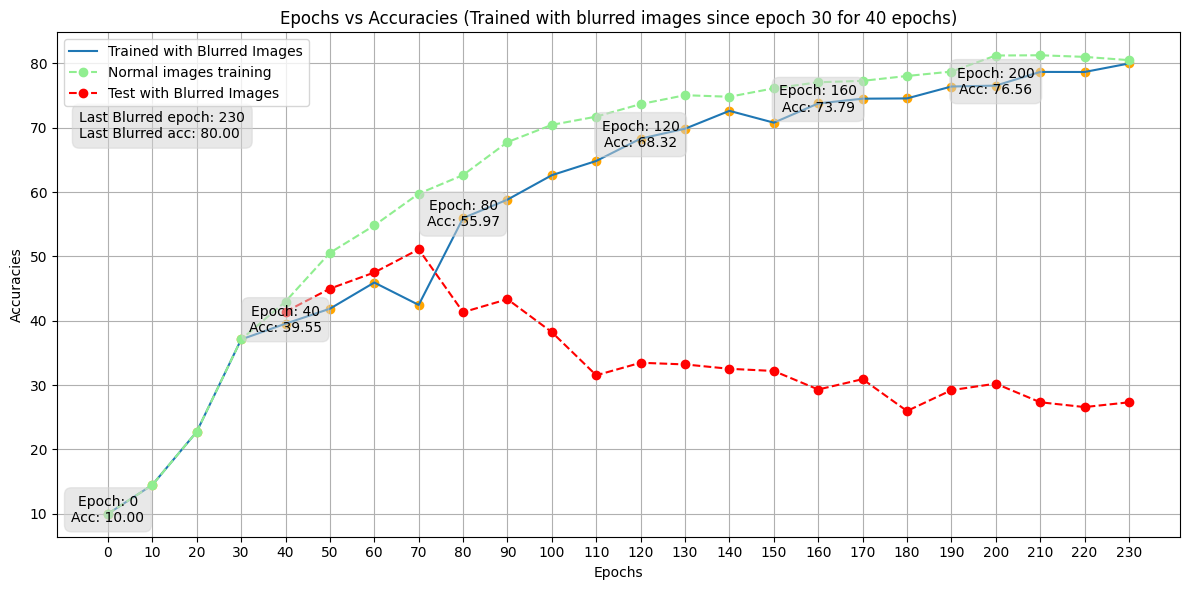

In [16]:
checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40Blurred_from_30.pt"
save_model(pretrained_epochs=model_data['pretrained_epochs'],
           model_state_dict=model_info['model'].state_dict(),
           optimizer_state_dict=model_info['optimizer'].state_dict(),
           final_accuracy=round(model_info['final_accuracy'], 2),
           training_data_dict=model_info['training_data_dict'],
           test_data_dict=model_info['test_data_dict'],
           checkpt_path=checkpoint_save_path)

plot_path = std_text + f"/Graficos/Blur training graphs/Blur_training_from_30.png"
save_plot(plot_path, training_data=model_info['training_data_dict'],
          altered_testing_data=model_info['test_data_dict'],
          altered_begin='30', blur=True)

#### En caso de que se guardó mal, editar y ejecutar este:

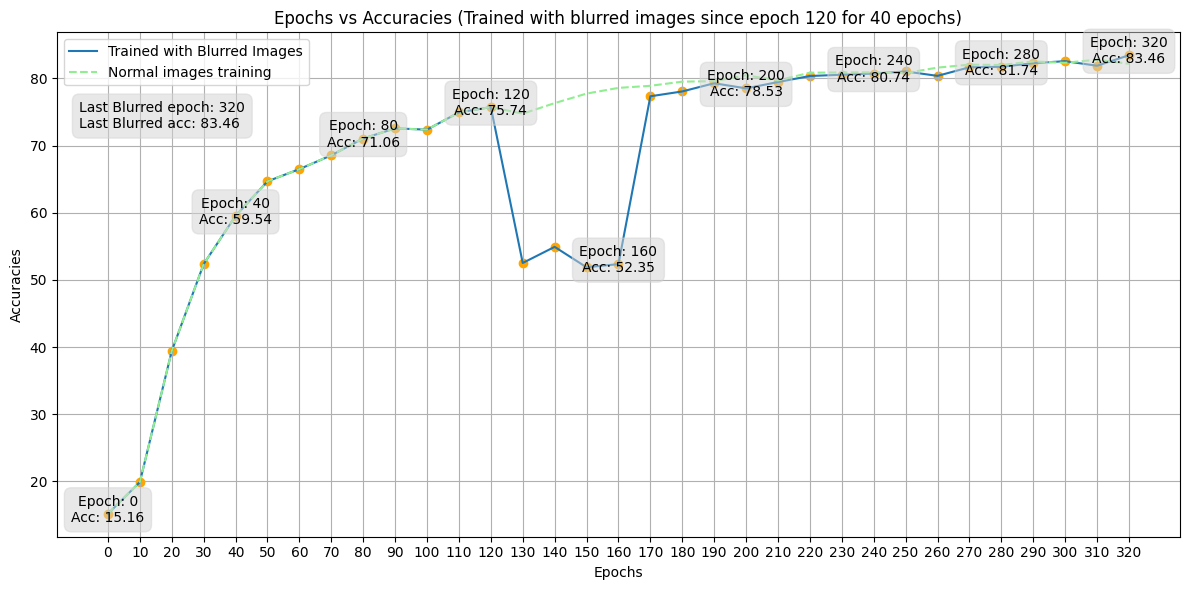

In [ ]:
pretrained_epochs = model_data['pretrained_epochs']
checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40Blurred_from_120.pt"
save_model(began_blur_epoch=pretrained_epochs,
           model_state_dict=model_info['model'].state_dict(),
           optimizer_state_dict=model_info['optimizer'].state_dict(),
           final_accuracy=round(model_info['final_accuracy'], 2),
           training_data_dict=model_info['training_data_dict'],
           checkpt_path=checkpoint_save_path)

plot_path = std_text + f"/Graficos/Blur training graphs/Blur_training_from_120.png"
save_plot(plot_path, model_info['training_data_dict'], '120', blur=True)

## 5.1. Generar gráfico de precisión vs época en donde se comenzó a entrenar con blur

In [ ]:
cant_archivos = 10 # cambiarlo a la cantidad de modelos que ya se encuentren en la carpeta 40epochs_blur_checkpoints

model_paths = [f"/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos/40epochs_blur_checkpts/40Blurred_from_{10*i}.pt" for i in range(1,cant_archivos)]
accuracies = []
begin_epoch = [10*i for i in range(1,cant_archivos)]

for path in model_paths:
  model_data = torch.load(path)
  accuracies.append(model_data['final_accuracy'])

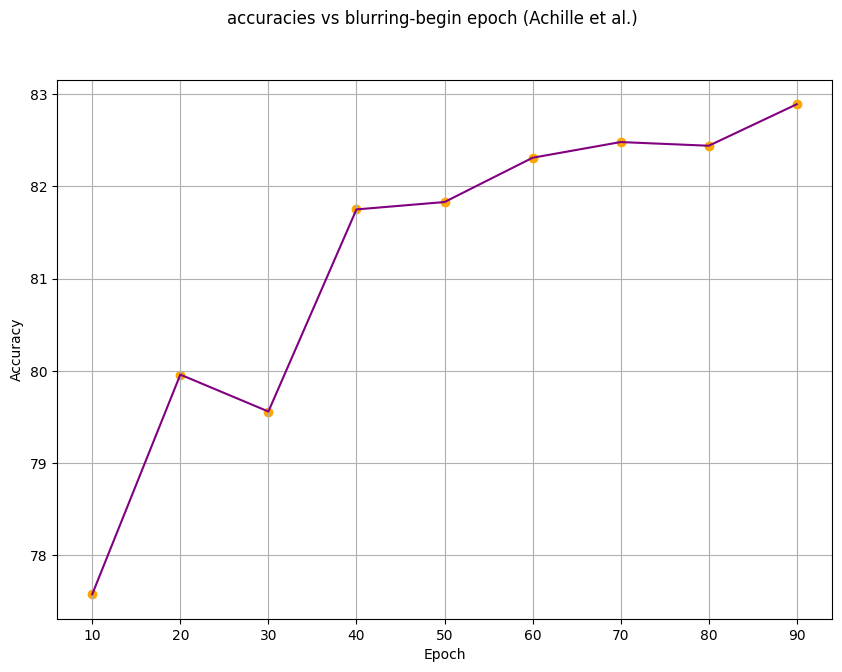

In [ ]:

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(begin_epoch, accuracies, color='purple')
ax.grid()
ax.scatter(begin_epoch, accuracies, color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.suptitle('accuracies vs blurring-begin epoch (Achille et al.)');

In [ ]:
save_path = f"/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos/Graficos/Acc Vs Epoch  (Epoch when blurred training began).png"
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)

<Figure size 640x480 with 0 Axes>